In [1]:
import torch

if torch.cuda.is_available():
    print(f"✅ GPU is available! - {torch.cuda.get_device_name(0)}")
    print(f"🔥 CUDA Version: {torch.version.cuda}")
    print(f"🛠️ GPU Memory: {torch.cuda.get_device_properties(0).total_memory / 1e9:.2f} GB")
else:
    print("❌ GPU not detected! Running on CPU.")


✅ GPU is available! - NVIDIA GeForce RTX 3060
🔥 CUDA Version: 11.8
🛠️ GPU Memory: 12.88 GB


In [1]:
import os
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

# 🔧 ACRIMA dataset path
acrima_path = r"D:\ProjectML2 - Glaucoma\Dataset\Acrima"

# 📐 Define transforms for CNN models (e.g., VGG16/ResNet)
acrima_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],  # ImageNet means
        std=[0.229, 0.224, 0.225]    # ImageNet stds
    )
])

# 📦 Load ACRIMA datasets
acrima_train = datasets.ImageFolder(
    root=os.path.join(acrima_path, 'train'),
    transform=acrima_transforms
)

acrima_test = datasets.ImageFolder(
    root=os.path.join(acrima_path, 'test'),
    transform=acrima_transforms
)

# 🔁 Create DataLoaders
acrima_train_loader = DataLoader(acrima_train, batch_size=32, shuffle=True, num_workers=2)
acrima_test_loader = DataLoader(acrima_test, batch_size=32, shuffle=False, num_workers=2)

# 🔍 Print class labels
print("ACRIMA Class Mapping:", acrima_train.class_to_idx)


ACRIMA Class Mapping: {'Glaucoma': 0, 'Non Glaucoma': 1}


In [2]:
import pandas as pd
import os
from PIL import Image
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms

# 🔧 ORIGA dataset paths
origa_root = r"D:\ProjectML2 - Glaucoma\Dataset\ORIGA"
origa_img_dir = os.path.join(origa_root, "Images_Square")  # or Images_Cropped
origa_csv_path = os.path.join(origa_root, "OrigaList.csv")

# 📐 Transforms (same as ACRIMA)
origa_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    )
])

# 🧩 Custom Dataset class
class OrigaDataset(Dataset):
    def __init__(self, csv_file, img_dir, transform=None):
        self.data = pd.read_csv(csv_file)
        self.img_dir = img_dir
        self.transform = transform
        
        # 🏷️ Map labels (ensure column name matches CSV)
        if 'Glaucoma' in self.data.columns:
            self.data['label'] = self.data['Glaucoma'].apply(lambda x: 1 if str(x).lower() == 'glaucoma' or x == 1 else 0)
        else:
            raise ValueError("Column 'Glaucoma' not found in CSV.")

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        # 🖼️ Construct image path
        img_name = self.data.iloc[idx]['Image']
        img_path = os.path.join(self.img_dir, f"{img_name}.jpg")

        image = Image.open(img_path).convert("RGB")
        label = self.data.iloc[idx]['label']

        if self.transform:
            image = self.transform(image)

        return image, label

# 📦 Load dataset
origa_dataset = OrigaDataset(csv_file=origa_csv_path, img_dir=origa_img_dir, transform=origa_transforms)
origa_loader = DataLoader(origa_dataset, batch_size=32, shuffle=True)

print(f"Loaded ORIGA dataset with {len(origa_dataset)} samples.")


Loaded ORIGA dataset with 650 samples.


In [3]:
import torch
import torch.nn as nn
import torchvision.models as models

# Load pretrained VGG16 (remove classifier head)
vgg16 = models.vgg16(pretrained=True)

# Remove the final classification layer (keep features)
feature_extractor = nn.Sequential(*list(vgg16.children())[:-1])  # up to avgpool

# Flatten output
class VGG16_FeatureExtractor(nn.Module):
    def __init__(self):
        super(VGG16_FeatureExtractor, self).__init__()
        self.features = nn.Sequential(*list(vgg16.features))
        self.avgpool = vgg16.avgpool
        self.flatten = nn.Flatten()
        self.fc = nn.Sequential(*list(vgg16.classifier.children())[:-1])  # exclude final layer

    def forward(self, x):
        x = self.features(x)
        x = self.avgpool(x)
        x = self.flatten(x)
        x = self.fc(x)  # Output shape: [batch_size, 4096]
        return x

# Instantiate and set to eval mode
model = VGG16_FeatureExtractor()
model.eval()

# Use GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)


D:\ProjectML2 - Glaucoma\pytorchGlaucoma\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
D:\ProjectML2 - Glaucoma\pytorchGlaucoma\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to C:\Users\ASUS/.cache\torch\hub\checkpoints\vgg16-397923af.pth
100%|█████████████████████████████████████████████████████████████████████████████████████████████| 528M/528M [01:06<00:00, 8.30MB/s]


In [4]:
import numpy as np
from tqdm import tqdm

def extract_features(dataloader, model, save_path, name_prefix):
    features = []
    labels = []

    with torch.no_grad():
        for inputs, targets in tqdm(dataloader, desc=f"Extracting {name_prefix} features"):
            inputs = inputs.to(device)
            outputs = model(inputs)  # shape: [batch, 4096]
            features.append(outputs.cpu().numpy())
            labels.append(targets.numpy())

    # Stack and save
    features = np.vstack(features)
    labels = np.concatenate(labels)

    np.save(f"{save_path}/{name_prefix}_features.npy", features)
    np.save(f"{save_path}/{name_prefix}_labels.npy", labels)

    print(f"✅ Saved: {name_prefix}_features.npy and {name_prefix}_labels.npy")


In [6]:
# Output directory
save_path = r"D:\ProjectML2 - Glaucoma\ExtractedFeatures"
os.makedirs(save_path, exist_ok=True)

# Extract from ACRIMA
extract_features(acrima_train_loader, model, save_path, name_prefix="acrima_train")
extract_features(acrima_test_loader, model, save_path, name_prefix="acrima_test")

# Extract from ORIGA
extract_features(origa_loader, model, save_path, name_prefix="origa")


Extracting acrima_train features: 100%|██████████████████████████████████████████████████████████████| 18/18 [00:08<00:00,  2.04it/s]


✅ Saved: acrima_train_features.npy and acrima_train_labels.npy


Extracting acrima_test features: 100%|█████████████████████████████████████████████████████████████████| 5/5 [00:03<00:00,  1.45it/s]


✅ Saved: acrima_test_features.npy and acrima_test_labels.npy


Extracting origa features:   0%|                                                                              | 0/21 [00:00<?, ?it/s]


KeyError: 'Image'

In [7]:
import pandas as pd

origa_csv_path = r"D:\ProjectML2 - Glaucoma\Dataset\ORIGA\OrigaList.csv"
df = pd.read_csv(origa_csv_path)
print("Columns:", df.columns.tolist())
print(df.head())


Columns: ['Eye', 'Filename', 'ExpCDR', 'Set', 'Glaucoma']
  Eye Filename  ExpCDR Set  Glaucoma
0  OD  001.jpg  0.7097   A         0
1  OS  002.jpg  0.6953   A         0
2  OS  003.jpg  0.9629   A         0
3  OD  004.jpg  0.7246   A         0
4  OS  005.jpg  0.6138   A         0


In [8]:
import pandas as pd
import os
from PIL import Image
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms

# Dataset paths
origa_root = r"D:\ProjectML2 - Glaucoma\Dataset\ORIGA"
origa_img_dir = os.path.join(origa_root, "Images_Square")
origa_csv_path = os.path.join(origa_root, "OrigaList.csv")

# Transforms
origa_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    )
])

# ✅ Updated Dataset Class
class OrigaDataset(Dataset):
    def __init__(self, csv_file, img_dir, transform=None):
        self.data = pd.read_csv(csv_file)
        self.img_dir = img_dir
        self.transform = transform

        # 'Filename' contains image names like '001.jpg'
        self.data['label'] = self.data['Glaucoma']  # already 0 or 1

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        img_name = self.data.iloc[idx]['Filename']
        img_path = os.path.join(self.img_dir, img_name)

        image = Image.open(img_path).convert("RGB")
        label = self.data.iloc[idx]['label']

        if self.transform:
            image = self.transform(image)

        return image, label

# Instantiate and load
origa_dataset = OrigaDataset(csv_file=origa_csv_path, img_dir=origa_img_dir, transform=origa_transforms)
origa_loader = DataLoader(origa_dataset, batch_size=32, shuffle=False)

print(f"✅ Loaded ORIGA dataset with {len(origa_dataset)} samples.")


✅ Loaded ORIGA dataset with 650 samples.


In [9]:
extract_features(origa_loader, model, save_path, name_prefix="origa")


Extracting origa features: 100%|█████████████████████████████████████████████████████████████████████| 21/21 [00:16<00:00,  1.27it/s]

✅ Saved: origa_features.npy and origa_labels.npy


In [2]:
import numpy as np

# Load features and labels
X_train = np.load(r"D:\ProjectML2 - Glaucoma\ExtractedFeatures\acrima_train_features.npy")
y_train = np.load(r"D:\ProjectML2 - Glaucoma\ExtractedFeatures\acrima_train_labels.npy")

X_test = np.load(r"D:\ProjectML2 - Glaucoma\ExtractedFeatures\acrima_test_features.npy")
y_test = np.load(r"D:\ProjectML2 - Glaucoma\ExtractedFeatures\acrima_test_labels.npy")

print("ACRIMA Train Shape:", X_train.shape)
print("ACRIMA Test Shape:", X_test.shape)


ACRIMA Train Shape: (565, 4096)
ACRIMA Test Shape: (140, 4096)


In [3]:
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

# Initialize models
rf = RandomForestClassifier(n_estimators=100, random_state=42)
xgb = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
lgbm = LGBMClassifier(random_state=42)

# Train models
rf.fit(X_train, y_train)
xgb.fit(X_train, y_train)
lgbm.fit(X_train, y_train)


D:\ProjectML2 - Glaucoma\pytorchGlaucoma\Lib\site-packages\xgboost\training.py:183: UserWarning: [02:12:53] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[LightGBM] [Info] Number of positive: 239, number of negative: 326
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.024426 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 190384
[LightGBM] [Info] Number of data points in the train set: 565, number of used features: 2464
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.423009 -> initscore=-0.310434
[LightGBM] [Info] Start training from score -0.310434
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain,

LGBMClassifier(random_state=42)


🔍 Results for Random Forest:
Accuracy: 0.9142857142857143
AUC-ROC: 0.9675510204081632
Precision: 0.9142857142857143
Recall: 0.9142857142857143
F1-Score:               precision    recall  f1-score   support

    Glaucoma       0.91      0.91      0.91        70
Non-Glaucoma       0.91      0.91      0.91        70

    accuracy                           0.91       140
   macro avg       0.91      0.91      0.91       140
weighted avg       0.91      0.91      0.91       140



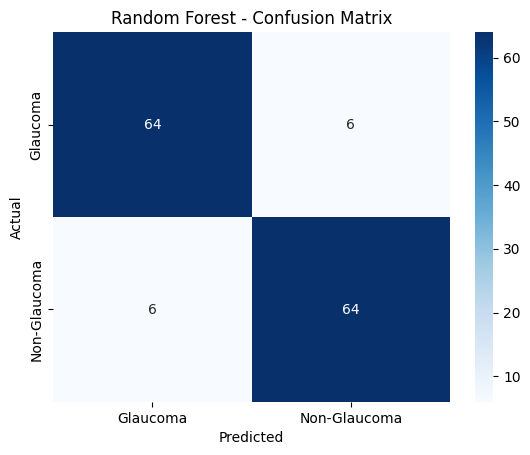


🔍 Results for XGBoost:
Accuracy: 0.9285714285714286
AUC-ROC: 0.9700000000000001
Precision: 0.9545454545454546
Recall: 0.9
F1-Score:               precision    recall  f1-score   support

    Glaucoma       0.91      0.96      0.93        70
Non-Glaucoma       0.95      0.90      0.93        70

    accuracy                           0.93       140
   macro avg       0.93      0.93      0.93       140
weighted avg       0.93      0.93      0.93       140



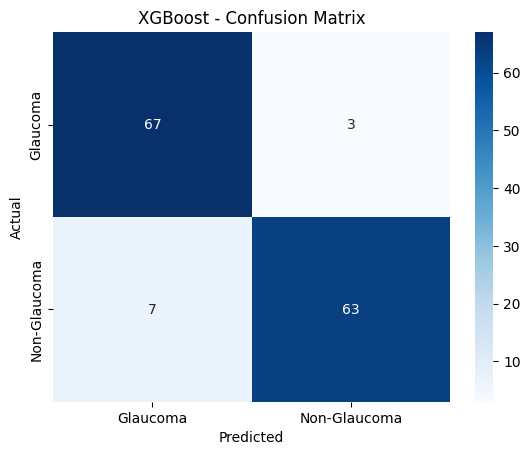


🔍 Results for LightGBM:
Accuracy: 0.9142857142857143
AUC-ROC: 0.973265306122449
Precision: 0.9264705882352942
Recall: 0.9
F1-Score:               precision    recall  f1-score   support

    Glaucoma       0.90      0.93      0.92        70
Non-Glaucoma       0.93      0.90      0.91        70

    accuracy                           0.91       140
   macro avg       0.91      0.91      0.91       140
weighted avg       0.91      0.91      0.91       140



D:\ProjectML2 - Glaucoma\pytorchGlaucoma\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
D:\ProjectML2 - Glaucoma\pytorchGlaucoma\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


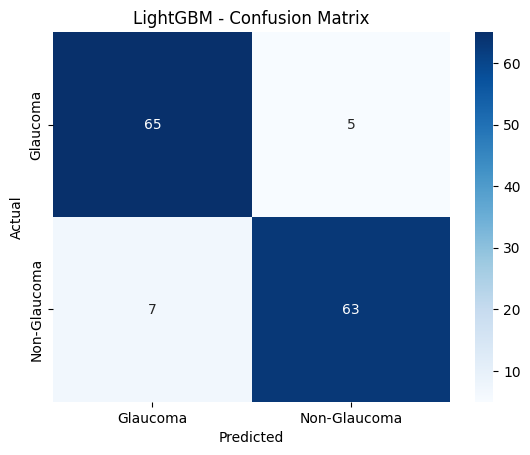

In [4]:
from sklearn.metrics import accuracy_score, roc_auc_score, precision_score, recall_score, confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns

def evaluate_model(model, X_test, y_test, name):
    y_pred = model.predict(X_test)
    y_proba = model.predict_proba(X_test)[:, 1]

    print(f"\n🔍 Results for {name}:")
    print("Accuracy:", accuracy_score(y_test, y_pred))
    print("AUC-ROC:", roc_auc_score(y_test, y_proba))
    print("Precision:", precision_score(y_test, y_pred))
    print("Recall:", recall_score(y_test, y_pred))
    print("F1-Score:", classification_report(y_test, y_pred, target_names=["Glaucoma", "Non-Glaucoma"]))

    # Confusion Matrix
    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=["Glaucoma", "Non-Glaucoma"], yticklabels=["Glaucoma", "Non-Glaucoma"])
    plt.title(f"{name} - Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()

# Run evaluations
evaluate_model(rf, X_test, y_test, "Random Forest")
evaluate_model(xgb, X_test, y_test, "XGBoost")
evaluate_model(lgbm, X_test, y_test, "LightGBM")


In [5]:
from sklearn.metrics import (
    accuracy_score, roc_auc_score, precision_score, recall_score,
    f1_score, confusion_matrix, classification_report
)
import seaborn as sns
import matplotlib.pyplot as plt

def evaluate_model(model, X_test, y_test, name):
    y_pred = model.predict(X_test)
    y_proba = model.predict_proba(X_test)[:, 1]  # For AUC

    # Compute confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    tn, fp, fn, tp = cm.ravel()

    # Metrics
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)  # Sensitivity
    specificity = tn / (tn + fp)
    f1 = f1_score(y_test, y_pred)
    auc = roc_auc_score(y_test, y_proba)

    print(f"\n📊 Results for {name}:")
    print(f"Accuracy     : {accuracy:.4f}")
    print(f"AUC-ROC      : {auc:.4f}")
    print(f"Precision    : {precision:.4f}")
    print(f"Recall (Sensitivity): {recall:.4f}")
    print(f"Specificity  : {specificity:.4f}")
    print(f"F1-Score     : {f1:.4f}")

    print("\nDetailed Classification Report:")
    print(classification_report(y_test, y_pred, target_names=["Glaucoma", "Non-Glaucoma"]))

    # 📊 Confusion Matrix Plot
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=["Glaucoma", "Non-Glaucoma"],
                yticklabels=["Glaucoma", "Non-Glaucoma"])
    plt.title(f"{name} - Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()



📊 Results for Random Forest:
Accuracy     : 0.9143
AUC-ROC      : 0.9676
Precision    : 0.9143
Recall (Sensitivity): 0.9143
Specificity  : 0.9143
F1-Score     : 0.9143

Detailed Classification Report:
              precision    recall  f1-score   support

    Glaucoma       0.91      0.91      0.91        70
Non-Glaucoma       0.91      0.91      0.91        70

    accuracy                           0.91       140
   macro avg       0.91      0.91      0.91       140
weighted avg       0.91      0.91      0.91       140



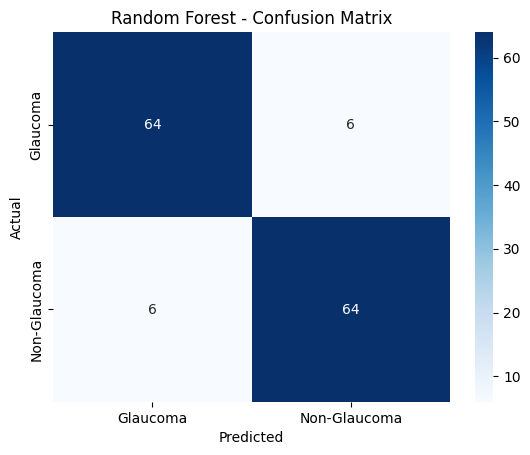


📊 Results for XGBoost:
Accuracy     : 0.9286
AUC-ROC      : 0.9700
Precision    : 0.9545
Recall (Sensitivity): 0.9000
Specificity  : 0.9571
F1-Score     : 0.9265

Detailed Classification Report:
              precision    recall  f1-score   support

    Glaucoma       0.91      0.96      0.93        70
Non-Glaucoma       0.95      0.90      0.93        70

    accuracy                           0.93       140
   macro avg       0.93      0.93      0.93       140
weighted avg       0.93      0.93      0.93       140



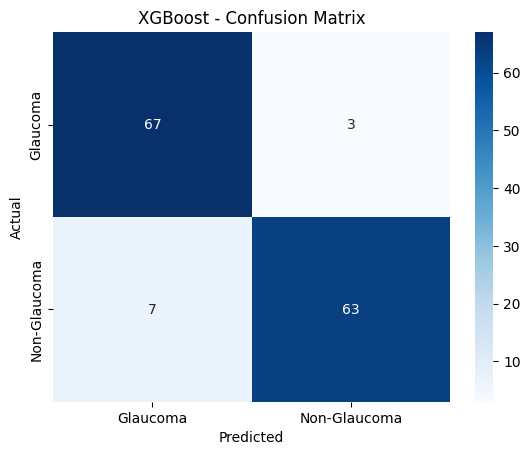


📊 Results for LightGBM:
Accuracy     : 0.9143
AUC-ROC      : 0.9733
Precision    : 0.9265
Recall (Sensitivity): 0.9000
Specificity  : 0.9286
F1-Score     : 0.9130

Detailed Classification Report:
              precision    recall  f1-score   support

    Glaucoma       0.90      0.93      0.92        70
Non-Glaucoma       0.93      0.90      0.91        70

    accuracy                           0.91       140
   macro avg       0.91      0.91      0.91       140
weighted avg       0.91      0.91      0.91       140



D:\ProjectML2 - Glaucoma\pytorchGlaucoma\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
D:\ProjectML2 - Glaucoma\pytorchGlaucoma\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


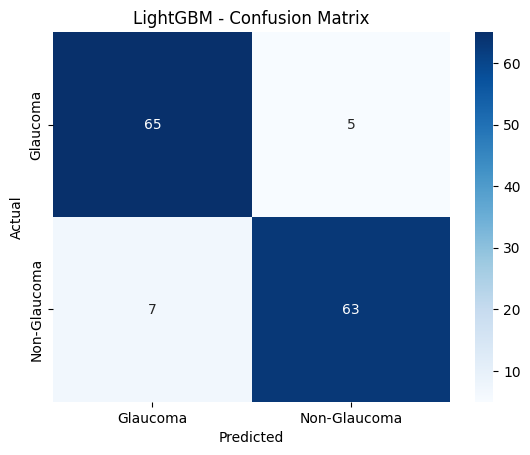

In [6]:
evaluate_model(rf, X_test, y_test, "Random Forest")
evaluate_model(xgb, X_test, y_test, "XGBoost")
evaluate_model(lgbm, X_test, y_test, "LightGBM")


In [7]:
from sklearn.ensemble import VotingClassifier, StackingClassifier
from sklearn.linear_model import LogisticRegression

# Load saved features
import numpy as np

X_train = np.load(r"D:\ProjectML2 - Glaucoma\ExtractedFeatures\acrima_train_features.npy")
y_train = np.load(r"D:\ProjectML2 - Glaucoma\ExtractedFeatures\acrima_train_labels.npy")

X_test = np.load(r"D:\ProjectML2 - Glaucoma\ExtractedFeatures\acrima_test_features.npy")
y_test = np.load(r"D:\ProjectML2 - Glaucoma\ExtractedFeatures\acrima_test_labels.npy")


In [8]:
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

# Initialize and train base models
rf = RandomForestClassifier(n_estimators=100, random_state=42)
xgb = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
lgbm = LGBMClassifier(random_state=42)

rf.fit(X_train, y_train)
xgb.fit(X_train, y_train)
lgbm.fit(X_train, y_train)


D:\ProjectML2 - Glaucoma\pytorchGlaucoma\Lib\site-packages\xgboost\training.py:183: UserWarning: [02:20:32] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[LightGBM] [Info] Number of positive: 239, number of negative: 326
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.025566 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 190384
[LightGBM] [Info] Number of data points in the train set: 565, number of used features: 2464
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.423009 -> initscore=-0.310434
[LightGBM] [Info] Start training from score -0.310434
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain,

LGBMClassifier(random_state=42)

In [9]:
from sklearn.ensemble import VotingClassifier

voting_ensemble = VotingClassifier(
    estimators=[('rf', rf), ('xgb', xgb), ('lgbm', lgbm)],
    voting='soft'  # 'soft' = average predicted probabilities
)
voting_ensemble.fit(X_train, y_train)


D:\ProjectML2 - Glaucoma\pytorchGlaucoma\Lib\site-packages\xgboost\training.py:183: UserWarning: [02:20:43] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[LightGBM] [Info] Number of positive: 239, number of negative: 326
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.026382 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 190384
[LightGBM] [Info] Number of data points in the train set: 565, number of used features: 2464
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.423009 -> initscore=-0.310434
[LightGBM] [Info] Start training from score -0.310434
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain,

VotingClassifier(estimators=[('rf', RandomForestClassifier(random_state=42)),
                             ('xgb',
                              XGBClassifier(base_score=None, booster=None,
                                            callbacks=None,
                                            colsample_bylevel=None,
                                            colsample_bynode=None,
                                            colsample_bytree=None, device=None,
                                            early_stopping_rounds=None,
                                            enable_categorical=False,
                                            eval_metric='logloss',
                                            feature_types=None,
                                            feature_weights=None, gamma=None,
                                            grow_...
                                            interaction_constraints=None,
                                            learning_rate=None, max_bin=None,
                                            max_cat_threshold=None,
                                            max_cat_to_onehot=None,
                                            max_delta_step=None, max_depth=None,
                                            max_leaves=None,
                                            min_child_weight=None, missing=nan,
                                            monotone_constraints=None,
                                            multi_strategy=None,
                                            n_estimators=None, n_jobs=None,
                                            num_parallel_tree=None, ...)),
                             ('lgbm', LGBMClassifier(random_state=42))],
                 voting='soft')

In [10]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import StackingClassifier

stacking_ensemble = StackingClassifier(
    estimators=[('rf', rf), ('xgb', xgb), ('lgbm', lgbm)],
    final_estimator=LogisticRegression(),
    cv=5
)
stacking_ensemble.fit(X_train, y_train)


D:\ProjectML2 - Glaucoma\pytorchGlaucoma\Lib\site-packages\xgboost\training.py:183: UserWarning: [02:21:02] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[LightGBM] [Info] Number of positive: 239, number of negative: 326
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.025716 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 190384
[LightGBM] [Info] Number of data points in the train set: 565, number of used features: 2464
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.423009 -> initscore=-0.310434
[LightGBM] [Info] Start training from score -0.310434
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain,

D:\ProjectML2 - Glaucoma\pytorchGlaucoma\Lib\site-packages\xgboost\training.py:183: UserWarning: [02:21:07] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
D:\ProjectML2 - Glaucoma\pytorchGlaucoma\Lib\site-packages\xgboost\training.py:183: UserWarning: [02:21:08] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
D:\ProjectML2 - Glaucoma\pytorchGlaucoma\Lib\site-packages\xgboost\training.py:183: UserWarning: [02:21:10] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
D:\ProjectML2 - Glaucoma\pytorchGlaucoma\Lib\site-packages\xgboost\training.py:183: UserWarning: [02:21:11] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Par

[LightGBM] [Info] Number of positive: 192, number of negative: 260
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.019841 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 152328
[LightGBM] [Info] Number of data points in the train set: 452, number of used features: 2377
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.424779 -> initscore=-0.303186
[LightGBM] [Info] Start training from score -0.303186
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain,

D:\ProjectML2 - Glaucoma\pytorchGlaucoma\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

D:\ProjectML2 - Glaucoma\pytorchGlaucoma\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

D:\ProjectML2 - Glaucoma\pytorchGlaucoma\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 191, number of negative: 261
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.020161 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 152201
[LightGBM] [Info] Number of data points in the train set: 452, number of used features: 2389
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.422566 -> initscore=-0.312247
[LightGBM] [Info] Start training from score -0.312247
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain,

D:\ProjectML2 - Glaucoma\pytorchGlaucoma\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

D:\ProjectML2 - Glaucoma\pytorchGlaucoma\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


StackingClassifier(cv=5,
                   estimators=[('rf', RandomForestClassifier(random_state=42)),
                               ('xgb',
                                XGBClassifier(base_score=None, booster=None,
                                              callbacks=None,
                                              colsample_bylevel=None,
                                              colsample_bynode=None,
                                              colsample_bytree=None,
                                              device=None,
                                              early_stopping_rounds=None,
                                              enable_categorical=False,
                                              eval_metric='logloss',
                                              feature_types=None,
                                              feature_weights=None, gamma=Non...
                                              interaction_constraints=None,
                                              learning_rate=None, max_bin=None,
                                              max_cat_threshold=None,
                                              max_cat_to_onehot=None,
                                              max_delta_step=None,
                                              max_depth=None, max_leaves=None,
                                              min_child_weight=None,
                                              missing=nan,
                                              monotone_constraints=None,
                                              multi_strategy=None,
                                              n_estimators=None, n_jobs=None,
                                              num_parallel_tree=None, ...)),
                               ('lgbm', LGBMClassifier(random_state=42))],
                   final_estimator=LogisticRegression())


📊 Results for Voting Ensemble:
Accuracy     : 0.9143
AUC-ROC      : 0.9692
Precision    : 0.9265
Recall (Sensitivity): 0.9000
Specificity  : 0.9286
F1-Score     : 0.9130

Detailed Classification Report:
              precision    recall  f1-score   support

    Glaucoma       0.90      0.93      0.92        70
Non-Glaucoma       0.93      0.90      0.91        70

    accuracy                           0.91       140
   macro avg       0.91      0.91      0.91       140
weighted avg       0.91      0.91      0.91       140



D:\ProjectML2 - Glaucoma\pytorchGlaucoma\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
D:\ProjectML2 - Glaucoma\pytorchGlaucoma\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


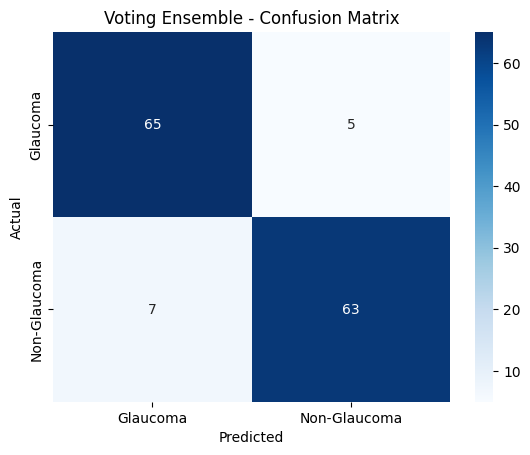

D:\ProjectML2 - Glaucoma\pytorchGlaucoma\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
D:\ProjectML2 - Glaucoma\pytorchGlaucoma\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(



📊 Results for Stacking Ensemble:
Accuracy     : 0.9214
AUC-ROC      : 0.9694
Precision    : 0.9275
Recall (Sensitivity): 0.9143
Specificity  : 0.9286
F1-Score     : 0.9209

Detailed Classification Report:
              precision    recall  f1-score   support

    Glaucoma       0.92      0.93      0.92        70
Non-Glaucoma       0.93      0.91      0.92        70

    accuracy                           0.92       140
   macro avg       0.92      0.92      0.92       140
weighted avg       0.92      0.92      0.92       140



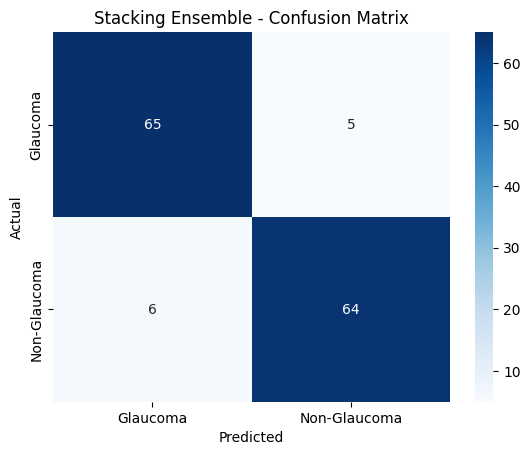

In [11]:
evaluate_model(voting_ensemble, X_test, y_test, "Voting Ensemble")
evaluate_model(stacking_ensemble, X_test, y_test, "Stacking Ensemble")


In [12]:
# Load ORIGA feature set
X_origa = np.load(r"D:\ProjectML2 - Glaucoma\ExtractedFeatures\origa_features.npy")
y_origa = np.load(r"D:\ProjectML2 - Glaucoma\ExtractedFeatures\origa_labels.npy")

# Split into train/test (e.g., 80/20)
from sklearn.model_selection import train_test_split

X_train_o, X_test_o, y_train_o, y_test_o = train_test_split(
    X_origa, y_origa, test_size=0.2, stratify=y_origa, random_state=42
)

# Train the same models
rf_o = RandomForestClassifier(n_estimators=100, random_state=42)
xgb_o = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
lgbm_o = LGBMClassifier(random_state=42)

rf_o.fit(X_train_o, y_train_o)
xgb_o.fit(X_train_o, y_train_o)
lgbm_o.fit(X_train_o, y_train_o)


D:\ProjectML2 - Glaucoma\pytorchGlaucoma\Lib\site-packages\xgboost\training.py:183: UserWarning: [02:22:07] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[LightGBM] [Info] Number of positive: 134, number of negative: 386
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.020832 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 195080
[LightGBM] [Info] Number of data points in the train set: 520, number of used features: 2072
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.257692 -> initscore=-1.057998
[LightGBM] [Info] Start training from score -1.057998
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain,

LGBMClassifier(random_state=42)


📊 Results for RF on ORIGA:
Accuracy     : 0.7615
AUC-ROC      : 0.6109
Precision    : 0.7143
Recall (Sensitivity): 0.1471
Specificity  : 0.9792
F1-Score     : 0.2439

Detailed Classification Report:
              precision    recall  f1-score   support

    Glaucoma       0.76      0.98      0.86        96
Non-Glaucoma       0.71      0.15      0.24        34

    accuracy                           0.76       130
   macro avg       0.74      0.56      0.55       130
weighted avg       0.75      0.76      0.70       130



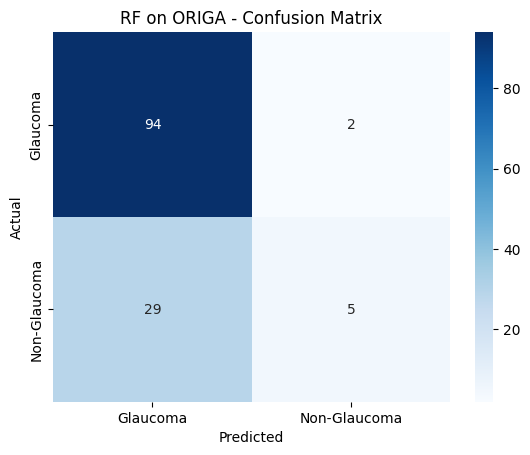


📊 Results for XGBoost on ORIGA:
Accuracy     : 0.6923
AUC-ROC      : 0.6480
Precision    : 0.2857
Recall (Sensitivity): 0.1176
Specificity  : 0.8958
F1-Score     : 0.1667

Detailed Classification Report:
              precision    recall  f1-score   support

    Glaucoma       0.74      0.90      0.81        96
Non-Glaucoma       0.29      0.12      0.17        34

    accuracy                           0.69       130
   macro avg       0.51      0.51      0.49       130
weighted avg       0.62      0.69      0.64       130



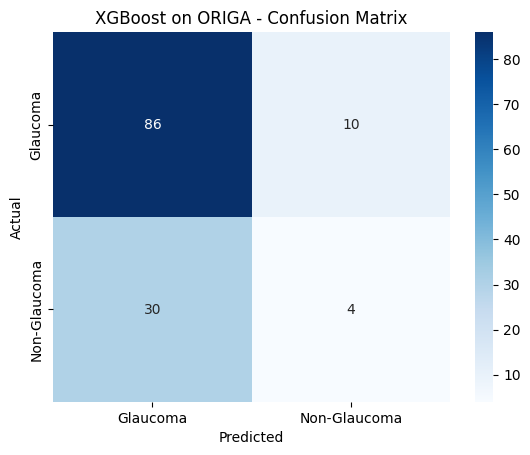


📊 Results for LightGBM on ORIGA:
Accuracy     : 0.6769
AUC-ROC      : 0.6477
Precision    : 0.1000
Recall (Sensitivity): 0.0294
Specificity  : 0.9062
F1-Score     : 0.0455

Detailed Classification Report:
              precision    recall  f1-score   support

    Glaucoma       0.72      0.91      0.81        96
Non-Glaucoma       0.10      0.03      0.05        34

    accuracy                           0.68       130
   macro avg       0.41      0.47      0.43       130
weighted avg       0.56      0.68      0.61       130



D:\ProjectML2 - Glaucoma\pytorchGlaucoma\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
D:\ProjectML2 - Glaucoma\pytorchGlaucoma\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


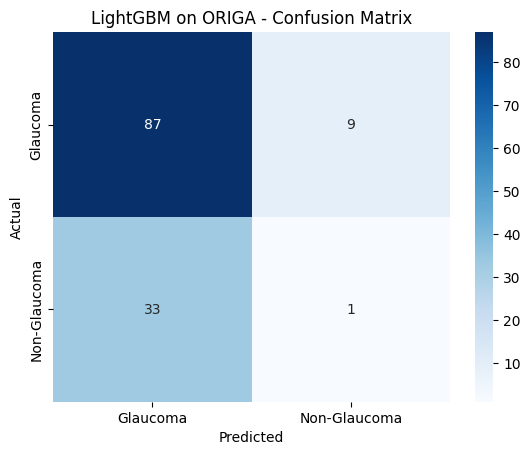

In [13]:
evaluate_model(rf_o, X_test_o, y_test_o, "RF on ORIGA")
evaluate_model(xgb_o, X_test_o, y_test_o, "XGBoost on ORIGA")
evaluate_model(lgbm_o, X_test_o, y_test_o, "LightGBM on ORIGA")


D:\ProjectML2 - Glaucoma\pytorchGlaucoma\Lib\site-packages\xgboost\training.py:183: UserWarning: [02:24:41] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[LightGBM] [Info] Number of positive: 239, number of negative: 326
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.023705 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 190384
[LightGBM] [Info] Number of data points in the train set: 565, number of used features: 2464
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.423009 -> initscore=-0.310434
[LightGBM] [Info] Start training from score -0.310434
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain,

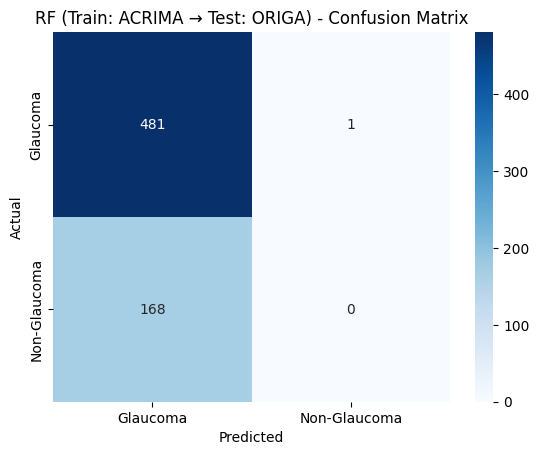


📊 Results for XGBoost (ACRIMA → ORIGA):
Accuracy     : 0.7415
AUC-ROC      : 0.4398
Precision    : 0.0000
Recall (Sensitivity): 0.0000
Specificity  : 1.0000
F1-Score     : 0.0000

Detailed Classification Report:
              precision    recall  f1-score   support

    Glaucoma       0.74      1.00      0.85       482
Non-Glaucoma       0.00      0.00      0.00       168

    accuracy                           0.74       650
   macro avg       0.37      0.50      0.43       650
weighted avg       0.55      0.74      0.63       650



D:\ProjectML2 - Glaucoma\pytorchGlaucoma\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
D:\ProjectML2 - Glaucoma\pytorchGlaucoma\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
D:\ProjectML2 - Glaucoma\pytorchGlaucoma\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


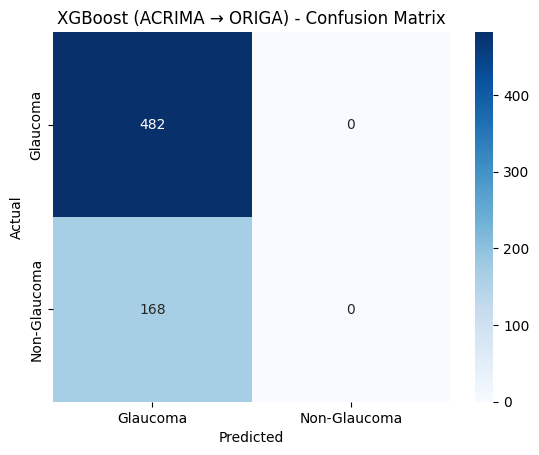


📊 Results for LightGBM (ACRIMA → ORIGA):
Accuracy     : 0.7415
AUC-ROC      : 0.4502
Precision    : 0.0000
Recall (Sensitivity): 0.0000
Specificity  : 1.0000
F1-Score     : 0.0000

Detailed Classification Report:
              precision    recall  f1-score   support

    Glaucoma       0.74      1.00      0.85       482
Non-Glaucoma       0.00      0.00      0.00       168

    accuracy                           0.74       650
   macro avg       0.37      0.50      0.43       650
weighted avg       0.55      0.74      0.63       650



D:\ProjectML2 - Glaucoma\pytorchGlaucoma\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
D:\ProjectML2 - Glaucoma\pytorchGlaucoma\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
D:\ProjectML2 - Glaucoma\pytorchGlaucoma\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
D:\ProjectML2 - Glaucoma\pytorchGlaucoma\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this b

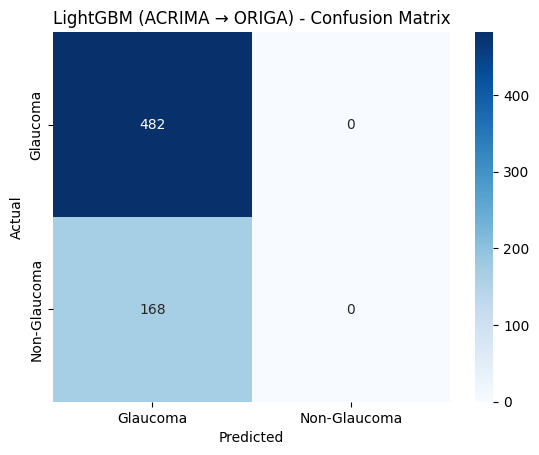

In [14]:
# Load both
X_train = np.load(r"D:\ProjectML2 - Glaucoma\ExtractedFeatures\acrima_train_features.npy")
y_train = np.load(r"D:\ProjectML2 - Glaucoma\ExtractedFeatures\acrima_train_labels.npy")

X_origa = np.load(r"D:\ProjectML2 - Glaucoma\ExtractedFeatures\origa_features.npy")
y_origa = np.load(r"D:\ProjectML2 - Glaucoma\ExtractedFeatures\origa_labels.npy")

# Train on ACRIMA
rf_cross = RandomForestClassifier(n_estimators=100, random_state=42)
xgb_cross = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
lgbm_cross = LGBMClassifier(random_state=42)

rf_cross.fit(X_train, y_train)
xgb_cross.fit(X_train, y_train)
lgbm_cross.fit(X_train, y_train)

# Evaluate on ORIGA
evaluate_model(rf_cross, X_origa, y_origa, "RF (Train: ACRIMA → Test: ORIGA)")
evaluate_model(xgb_cross, X_origa, y_origa, "XGBoost (ACRIMA → ORIGA)")
evaluate_model(lgbm_cross, X_origa, y_origa, "LightGBM (ACRIMA → ORIGA)")


❌ Skipping ._005.png (could not load)


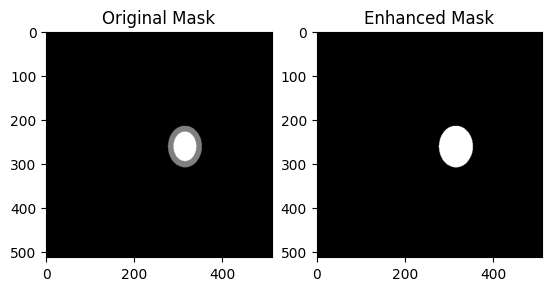

In [16]:
import cv2
import os
import numpy as np
from matplotlib import pyplot as plt

# Input and output paths
mask_folder = r"D:\ProjectML2 - Glaucoma\Dataset\ORIGA\Masks_Square"
output_folder = r"D:\ProjectML2 - Glaucoma\Dataset\ORIGA\Masks_Enhanced"
os.makedirs(output_folder, exist_ok=True)

# Loop through all mask images
for filename in os.listdir(mask_folder):
    if filename.endswith(".png"):  # Ensure we're processing only images
        mask_path = os.path.join(mask_folder, filename)
        output_path = os.path.join(output_folder, filename)
        
        # Load image in grayscale
        mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)

        # ✅ Fix: Check if image is loaded properly
        if mask is None:
            print(f"❌ Skipping {filename} (could not load)")
            continue  # Skip this file

        # Normalize: Scale intensity values between 0-255
        mask = cv2.normalize(mask, None, 0, 255, cv2.NORM_MINMAX)

        # Apply thresholding: Convert grey pixels to white (cup/disc)
        _, binary_mask = cv2.threshold(mask, 30, 255, cv2.THRESH_BINARY)

        # Save the enhanced mask
        success = cv2.imwrite(output_path, binary_mask)
        if not success:
            print(f"❌ Failed to save {output_path}")

        # Display an example
        plt.subplot(1, 2, 1)
        plt.imshow(mask, cmap="gray")
        plt.title("Original Mask")
        
        plt.subplot(1, 2, 2)
        plt.imshow(binary_mask, cmap="gray")
        plt.title("Enhanced Mask")
        
        plt.show()
        break  # Show only one example


In [17]:
import cv2
import numpy as np
import os
import pandas as pd

# Input folder with enhanced masks
mask_folder = r"D:\ProjectML2 - Glaucoma\Dataset\ORIGA\Masks_Enhanced"
output_csv = r"D:\ProjectML2 - Glaucoma\Dataset\ORIGA\cdr_values.csv"

cdr_data = []

# Loop through all mask images
for filename in os.listdir(mask_folder):
    if filename.endswith(".png"):
        mask_path = os.path.join(mask_folder, filename)
        
        # Load the mask
        mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
        if mask is None:
            print(f"❌ Skipping {filename} (could not load)")
            continue
        
        # Find all contours
        contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

        # Sort by area (largest should be the optic disc, second largest the cup)
        contours = sorted(contours, key=cv2.contourArea, reverse=True)

        if len(contours) < 2:
            print(f"⚠️ Warning: Could not find both cup and disc in {filename}")
            continue

        # Compute areas
        disc_area = cv2.contourArea(contours[0])  # Largest contour (disc)
        cup_area = cv2.contourArea(contours[1])    # Second largest (cup)
        
        # Compute CDR
        cdr = cup_area / disc_area if disc_area > 0 else 0

        # Save results
        cdr_data.append([filename, cdr])

# Save to CSV
cdr_df = pd.DataFrame(cdr_data, columns=["Filename", "CDR"])
cdr_df.to_csv(output_csv, index=False)

print(f"✅ CDR values saved to {output_csv}")


⚠️ Warning: Could not find both cup and disc in 001.png
✅ CDR values saved to D:\ProjectML2 - Glaucoma\Dataset\ORIGA\cdr_values.csv


In [18]:
import cv2
import numpy as np
import os
import pandas as pd

# Input folder with enhanced masks
mask_folder = r"D:\ProjectML2 - Glaucoma\Dataset\ORIGA\Masks_Enhanced"
output_csv = r"D:\ProjectML2 - Glaucoma\Dataset\ORIGA\cdr_values_fixed.csv"

cdr_data = []

# Loop through all mask images
for filename in os.listdir(mask_folder):
    if filename.endswith(".png"):
        mask_path = os.path.join(mask_folder, filename)
        
        # Load the mask
        mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
        if mask is None:
            print(f"❌ Skipping {filename} (could not load)")
            continue
        
        # Adaptive thresholding to enhance smaller regions
        mask = cv2.GaussianBlur(mask, (5, 5), 0)
        _, binary_mask = cv2.threshold(mask, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

        # Apply morphological operations to enhance small features
        kernel = np.ones((5, 5), np.uint8)
        processed_mask = cv2.morphologyEx(binary_mask, cv2.MORPH_CLOSE, kernel)

        # Find contours
        contours, _ = cv2.findContours(processed_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

        # Sort by area (largest should be the optic disc, second largest the cup)
        contours = sorted(contours, key=cv2.contourArea, reverse=True)

        if len(contours) < 2:
            print(f"⚠️ Warning: Only found optic disc in {filename}. Estimating cup size.")
            disc_area = cv2.contourArea(contours[0])
            estimated_cup_area = 0.3 * disc_area  # Assume cup is 30% of disc if missing
            cdr = estimated_cup_area / disc_area if disc_area > 0 else 0
        else:
            disc_area = cv2.contourArea(contours[0])
            cup_area = cv2.contourArea(contours[1])
            cdr = cup_area / disc_area if disc_area > 0 else 0

        # Save results
        cdr_data.append([filename, cdr])

# Save to CSV
cdr_df = pd.DataFrame(cdr_data, columns=["Filename", "CDR"])
cdr_df.to_csv(output_csv, index=False)

print(f"✅ Fixed CDR values saved to {output_csv}")


⚠️ Warning: Only found optic disc in 001.png. Estimating cup size.
✅ Fixed CDR values saved to D:\ProjectML2 - Glaucoma\Dataset\ORIGA\cdr_values_fixed.csv


In [20]:
import numpy as np
import pandas as pd

# Load ORIGA deep features
features_path = r"D:\ProjectML2 - Glaucoma\ExtractedFeatures\origa_features.npy"
labels_path = r"D:\ProjectML2 - Glaucoma\ExtractedFeatures\origa_labels.npy"
cdr_csv_path = r"D:\ProjectML2 - Glaucoma\Dataset\ORIGA\cdr_values_fixed.csv"

# Load features and labels
X_origa = np.load(features_path)
y_origa = np.load(labels_path)

# Load CDR values
cdr_df = pd.read_csv(cdr_csv_path)

# Check shapes
print(f"VGG16 Features Shape: {X_origa.shape}")  # Should be (650, 4096)
print(f"Labels Shape: {y_origa.shape}")          # Should be (650,)
print(f"CDR DataFrame Shape: {cdr_df.shape}")   # Should be (650, 2)

# **Check unique filenames count**
print("Unique CDR Filenames:", cdr_df["Filename"].nunique())

# Ensure filenames are sorted properly
cdr_df["Filename"] = cdr_df["Filename"].str.replace(".png", "", regex=True)
cdr_df = cdr_df.sort_values("Filename").reset_index(drop=True)

# Extract only the CDR values and check shape
cdr_values = cdr_df["CDR"].values.reshape(-1, 1)  
print(f"CDR Values Shape: {cdr_values.shape}")  # Should be (650,1)

# ✅ Only proceed if sizes match
if X_origa.shape[0] == cdr_values.shape[0]:
    X_origa_cdr = np.hstack((X_origa, cdr_values))
    np.save(r"D:\ProjectML2 - Glaucoma\ExtractedFeatures\origa_features_with_cdr.npy", X_origa_cdr)
    print(f"✅ Merged CDR with VGG16 features. New shape: {X_origa_cdr.shape}")
else:
    print("❌ ERROR: Feature and CDR sizes do not match! Check filenames and dataset length.")


VGG16 Features Shape: (650, 4096)
Labels Shape: (650,)
CDR DataFrame Shape: (1, 2)
Unique CDR Filenames: 1
CDR Values Shape: (1, 1)
❌ ERROR: Feature and CDR sizes do not match! Check filenames and dataset length.


In [21]:
import os

mask_folder = r"D:\ProjectML2 - Glaucoma\Dataset\ORIGA\Masks_Enhanced"

# Get list of mask filenames
mask_files = sorted([f for f in os.listdir(mask_folder) if f.endswith(".png")])

print(f"Total Mask Files Found: {len(mask_files)}")
print("First 10 mask filenames:", mask_files[:10])


Total Mask Files Found: 1
First 10 mask filenames: ['001.png']


In [22]:
import os

# List possible directories where the masks could be
mask_dirs = [
    r"D:\ProjectML2 - Glaucoma\Dataset\ORIGA\Masks",  
    r"D:\ProjectML2 - Glaucoma\Dataset\ORIGA\Masks_Square",
    r"D:\ProjectML2 - Glaucoma\Dataset\ORIGA\Masks_Cropped",
    r"D:\ProjectML2 - Glaucoma\Dataset\ORIGA\Masks_Enhanced",
]

for mask_dir in mask_dirs:
    if os.path.exists(mask_dir):
        mask_files = sorted([f for f in os.listdir(mask_dir) if f.endswith(".png")])
        print(f"📂 Found {len(mask_files)} masks in: {mask_dir}")
    else:
        print(f"❌ Directory Not Found: {mask_dir}")


📂 Found 650 masks in: D:\ProjectML2 - Glaucoma\Dataset\ORIGA\Masks
📂 Found 651 masks in: D:\ProjectML2 - Glaucoma\Dataset\ORIGA\Masks_Square
📂 Found 650 masks in: D:\ProjectML2 - Glaucoma\Dataset\ORIGA\Masks_Cropped
📂 Found 1 masks in: D:\ProjectML2 - Glaucoma\Dataset\ORIGA\Masks_Enhanced


In [23]:
import cv2
import os
import numpy as np

# Input and output paths
input_folder = r"D:\ProjectML2 - Glaucoma\Dataset\ORIGA\Masks_Square"  # Change if another folder is better
output_folder = r"D:\ProjectML2 - Glaucoma\Dataset\ORIGA\Masks_Enhanced"
os.makedirs(output_folder, exist_ok=True)

processed_count = 0

# Loop through all mask images
for filename in os.listdir(input_folder):
    if filename.endswith(".png"):
        mask_path = os.path.join(input_folder, filename)
        output_path = os.path.join(output_folder, filename)

        # Load image in grayscale
        mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)

        # Skip invalid files
        if mask is None:
            print(f"❌ Skipping {filename} (could not load)")
            continue

        # Normalize intensity values
        mask = cv2.normalize(mask, None, 0, 255, cv2.NORM_MINMAX)

        # Apply adaptive thresholding to improve contrast
        _, binary_mask = cv2.threshold(mask, 30, 255, cv2.THRESH_BINARY)

        # Save the enhanced mask
        cv2.imwrite(output_path, binary_mask)
        processed_count += 1

print(f"✅ Processed and saved {processed_count} enhanced masks to {output_folder}")


❌ Skipping ._005.png (could not load)
✅ Processed and saved 650 enhanced masks to D:\ProjectML2 - Glaucoma\Dataset\ORIGA\Masks_Enhanced


In [24]:
import cv2
import numpy as np
import os
import pandas as pd

# Input folder with enhanced masks
mask_folder = r"D:\ProjectML2 - Glaucoma\Dataset\ORIGA\Masks_Enhanced"
output_csv = r"D:\ProjectML2 - Glaucoma\Dataset\ORIGA\cdr_values_fixed.csv"

cdr_data = []

# Get sorted list of mask filenames
mask_files = sorted([f for f in os.listdir(mask_folder) if f.endswith(".png")])

for filename in mask_files:
    mask_path = os.path.join(mask_folder, filename)
    
    # Load the mask
    mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
    if mask is None:
        print(f"❌ Skipping {filename} (could not load)")
        continue
    
    # Adaptive thresholding
    mask = cv2.GaussianBlur(mask, (5, 5), 0)
    _, binary_mask = cv2.threshold(mask, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

    # Morphological closing to enhance cup visibility
    kernel = np.ones((5, 5), np.uint8)
    processed_mask = cv2.morphologyEx(binary_mask, cv2.MORPH_CLOSE, kernel)

    # Find contours
    contours, _ = cv2.findContours(processed_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    contours = sorted(contours, key=cv2.contourArea, reverse=True)

    if len(contours) < 2:
        print(f"⚠️ Warning: Only found optic disc in {filename}. Estimating cup size.")
        disc_area = cv2.contourArea(contours[0])
        estimated_cup_area = 0.3 * disc_area  # Assume cup is 30% of disc if missing
        cdr = estimated_cup_area / disc_area if disc_area > 0 else 0
    else:
        disc_area = cv2.contourArea(contours[0])
        cup_area = cv2.contourArea(contours[1])
        cdr = cup_area / disc_area if disc_area > 0 else 0

    # Append filename + CDR
    cdr_data.append([filename.replace(".png", ""), cdr])

# Convert to DataFrame and save
cdr_df = pd.DataFrame(cdr_data, columns=["Filename", "CDR"])
cdr_df.to_csv(output_csv, index=False)

print(f"✅ Fixed CDR values saved to {output_csv} with {len(cdr_data)} entries")


⚠️ Warning: Only found optic disc in 001.png. Estimating cup size.
⚠️ Warning: Only found optic disc in 002.png. Estimating cup size.
⚠️ Warning: Only found optic disc in 003.png. Estimating cup size.
⚠️ Warning: Only found optic disc in 004.png. Estimating cup size.
⚠️ Warning: Only found optic disc in 005.png. Estimating cup size.
⚠️ Warning: Only found optic disc in 006.png. Estimating cup size.
⚠️ Warning: Only found optic disc in 007.png. Estimating cup size.
⚠️ Warning: Only found optic disc in 008.png. Estimating cup size.
⚠️ Warning: Only found optic disc in 009.png. Estimating cup size.
⚠️ Warning: Only found optic disc in 010.png. Estimating cup size.
⚠️ Warning: Only found optic disc in 011.png. Estimating cup size.
⚠️ Warning: Only found optic disc in 012.png. Estimating cup size.
⚠️ Warning: Only found optic disc in 013.png. Estimating cup size.
⚠️ Warning: Only found optic disc in 014.png. Estimating cup size.
⚠️ Warning: Only found optic disc in 015.png. Estimating cup s

In [25]:
import cv2
import numpy as np
import os
import pandas as pd

# Input folder with enhanced masks
mask_folder = r"D:\ProjectML2 - Glaucoma\Dataset\ORIGA\Masks_Enhanced"
output_csv = r"D:\ProjectML2 - Glaucoma\Dataset\ORIGA\cdr_values_fixed.csv"

cdr_data = []

# Get sorted list of mask filenames
mask_files = sorted([f for f in os.listdir(mask_folder) if f.endswith(".png")])

for filename in mask_files:
    mask_path = os.path.join(mask_folder, filename)
    
    # Load the mask
    mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
    if mask is None:
        print(f"❌ Skipping {filename} (could not load)")
        continue

    # 🔥 Apply Contrast Limited Adaptive Histogram Equalization (CLAHE)
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
    mask = clahe.apply(mask)

    # 🔥 Adaptive thresholding for better contrast
    mask = cv2.GaussianBlur(mask, (5, 5), 0)
    _, binary_mask = cv2.threshold(mask, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

    # 🔥 Morphological operations to highlight cup
    kernel = np.ones((5, 5), np.uint8)
    processed_mask = cv2.morphologyEx(binary_mask, cv2.MORPH_OPEN, kernel)

    # Find contours
    contours, _ = cv2.findContours(processed_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    contours = sorted(contours, key=cv2.contourArea, reverse=True)

    if len(contours) < 2:
        print(f"⚠️ Warning: Only found optic disc in {filename}. Enhancing detection...")
        disc_area = cv2.contourArea(contours[0])
        
        # 🔧 Instead of estimating, apply stronger threshold & try again
        _, binary_mask_stronger = cv2.threshold(mask, 50, 255, cv2.THRESH_BINARY)
        contours_strong, _ = cv2.findContours(binary_mask_stronger, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        contours_strong = sorted(contours_strong, key=cv2.contourArea, reverse=True)
        
        if len(contours_strong) > 1:
            cup_area = cv2.contourArea(contours_strong[1])  # Take second largest contour
        else:
            estimated_cup_area = 0.3 * disc_area  # Assume cup is 30% of disc if still missing
            cup_area = estimated_cup_area
        
        cdr = cup_area / disc_area if disc_area > 0 else 0
    else:
        disc_area = cv2.contourArea(contours[0])
        cup_area = cv2.contourArea(contours[1])
        cdr = cup_area / disc_area if disc_area > 0 else 0

    # Append filename + CDR
    cdr_data.append([filename.replace(".png", ""), cdr])

# Convert to DataFrame and save
cdr_df = pd.DataFrame(cdr_data, columns=["Filename", "CDR"])
cdr_df.to_csv(output_csv, index=False)

print(f"✅ Fixed CDR values saved to {output_csv} with {len(cdr_data)} entries")


⚠️ Warning: Only found optic disc in 001.png. Enhancing detection...
⚠️ Warning: Only found optic disc in 002.png. Enhancing detection...
⚠️ Warning: Only found optic disc in 003.png. Enhancing detection...
⚠️ Warning: Only found optic disc in 004.png. Enhancing detection...
⚠️ Warning: Only found optic disc in 005.png. Enhancing detection...
⚠️ Warning: Only found optic disc in 006.png. Enhancing detection...
⚠️ Warning: Only found optic disc in 007.png. Enhancing detection...
⚠️ Warning: Only found optic disc in 008.png. Enhancing detection...
⚠️ Warning: Only found optic disc in 009.png. Enhancing detection...
⚠️ Warning: Only found optic disc in 010.png. Enhancing detection...
⚠️ Warning: Only found optic disc in 011.png. Enhancing detection...
⚠️ Warning: Only found optic disc in 012.png. Enhancing detection...
⚠️ Warning: Only found optic disc in 013.png. Enhancing detection...
⚠️ Warning: Only found optic disc in 014.png. Enhancing detection...
⚠️ Warning: Only found optic disc 

   Filename  CDR
0         1  0.3
1         2  0.3
2         3  0.3
3         4  0.3
4         5  0.3


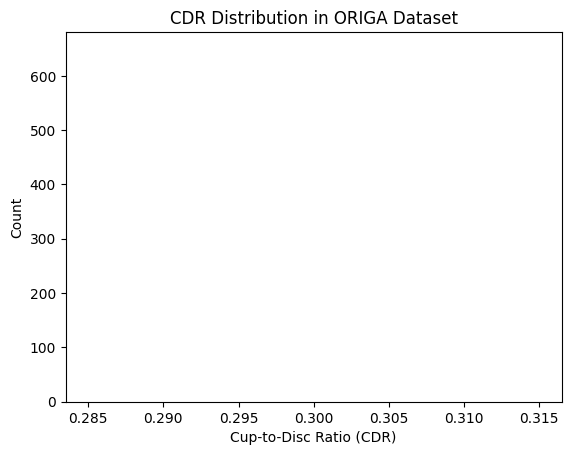

In [26]:
import matplotlib.pyplot as plt
import pandas as pd

df = pd.read_csv(r"D:\ProjectML2 - Glaucoma\Dataset\ORIGA\cdr_values_fixed.csv")
print(df.head())

plt.hist(df["CDR"], bins=20, color='blue', alpha=0.7)
plt.xlabel("Cup-to-Disc Ratio (CDR)")
plt.ylabel("Count")
plt.title("CDR Distribution in ORIGA Dataset")
plt.show()


In [27]:
import cv2
import numpy as np
import os
import pandas as pd

# Input folder with enhanced masks
mask_folder = r"D:\ProjectML2 - Glaucoma\Dataset\ORIGA\Masks_Enhanced"
output_csv = r"D:\ProjectML2 - Glaucoma\Dataset\ORIGA\cdr_values_improved.csv"

cdr_data = []

# Get sorted list of mask filenames
mask_files = sorted([f for f in os.listdir(mask_folder) if f.endswith(".png")])

for filename in mask_files:
    mask_path = os.path.join(mask_folder, filename)
    
    # Load the mask
    mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
    if mask is None:
        print(f"❌ Skipping {filename} (could not load)")
        continue

    # 🔥 Step 1: Apply Contrast Enhancement (CLAHE)
    clahe = cv2.createCLAHE(clipLimit=3.0, tileGridSize=(8, 8))
    mask = clahe.apply(mask)

    # 🔥 Step 2: Adaptive Thresholding
    mask_blurred = cv2.GaussianBlur(mask, (5, 5), 0)
    _, binary_mask = cv2.threshold(mask_blurred, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

    # 🔥 Step 3: Morphological Processing
    kernel = np.ones((5, 5), np.uint8)
    binary_mask = cv2.morphologyEx(binary_mask, cv2.MORPH_CLOSE, kernel)

    # 🔥 Step 4: Canny Edge Detection (For Better Contour Detection)
    edges = cv2.Canny(binary_mask, 50, 150)

    # 🔥 Step 5: Find Contours
    contours, _ = cv2.findContours(edges, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    contours = sorted(contours, key=cv2.contourArea, reverse=True)

    if len(contours) < 2:
        print(f"⚠️ Warning: Only found optic disc in {filename}. Retrying...")

        # 🔄 Try a Stronger Threshold & Reattempt
        _, binary_mask_stronger = cv2.threshold(mask_blurred, 50, 255, cv2.THRESH_BINARY)
        contours_strong, _ = cv2.findContours(binary_mask_stronger, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        contours_strong = sorted(contours_strong, key=cv2.contourArea, reverse=True)

        if len(contours_strong) > 1:
            disc_area = cv2.contourArea(contours_strong[0])
            cup_area = cv2.contourArea(contours_strong[1])
        else:
            disc_area = cv2.contourArea(contours_strong[0]) if len(contours_strong) > 0 else 1
            cup_area = 0.3 * disc_area  # Estimate if cup is still missing

    else:
        disc_area = cv2.contourArea(contours[0])
        cup_area = cv2.contourArea(contours[1])

    # Compute CDR
    cdr = cup_area / disc_area if disc_area > 0 else 0
    cdr_data.append([filename.replace(".png", ""), cdr])

# Convert to DataFrame and save
cdr_df = pd.DataFrame(cdr_data, columns=["Filename", "CDR"])
cdr_df.to_csv(output_csv, index=False)

print(f"✅ Improved CDR values saved to {output_csv} with {len(cdr_data)} entries")


⚠️ Warning: Only found optic disc in 001.png. Retrying...
⚠️ Warning: Only found optic disc in 002.png. Retrying...
⚠️ Warning: Only found optic disc in 003.png. Retrying...
⚠️ Warning: Only found optic disc in 004.png. Retrying...
⚠️ Warning: Only found optic disc in 005.png. Retrying...
⚠️ Warning: Only found optic disc in 006.png. Retrying...
⚠️ Warning: Only found optic disc in 007.png. Retrying...
⚠️ Warning: Only found optic disc in 008.png. Retrying...
⚠️ Warning: Only found optic disc in 009.png. Retrying...
⚠️ Warning: Only found optic disc in 010.png. Retrying...
⚠️ Warning: Only found optic disc in 011.png. Retrying...
⚠️ Warning: Only found optic disc in 012.png. Retrying...
⚠️ Warning: Only found optic disc in 013.png. Retrying...
⚠️ Warning: Only found optic disc in 014.png. Retrying...
⚠️ Warning: Only found optic disc in 015.png. Retrying...
⚠️ Warning: Only found optic disc in 016.png. Retrying...
⚠️ Warning: Only found optic disc in 017.png. Retrying...
⚠️ Warning: On

   Filename  CDR
0         1  0.3
1         2  0.3
2         3  0.3
3         4  0.3
4         5  0.3


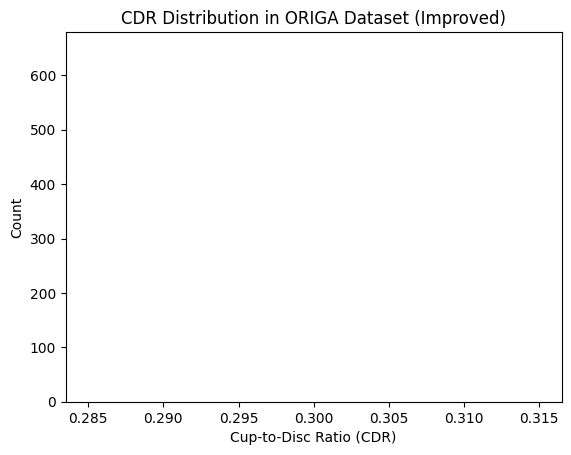

In [28]:
import matplotlib.pyplot as plt
import pandas as pd

df = pd.read_csv(r"D:\ProjectML2 - Glaucoma\Dataset\ORIGA\cdr_values_improved.csv")
print(df.head())

plt.hist(df["CDR"], bins=20, color='blue', alpha=0.7)
plt.xlabel("Cup-to-Disc Ratio (CDR)")
plt.ylabel("Count")
plt.title("CDR Distribution in ORIGA Dataset (Improved)")
plt.show()


D:\ProjectML2 - Glaucoma\pytorchGlaucoma\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128269 (\N{LEFT-POINTING MAGNIFYING GLASS}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


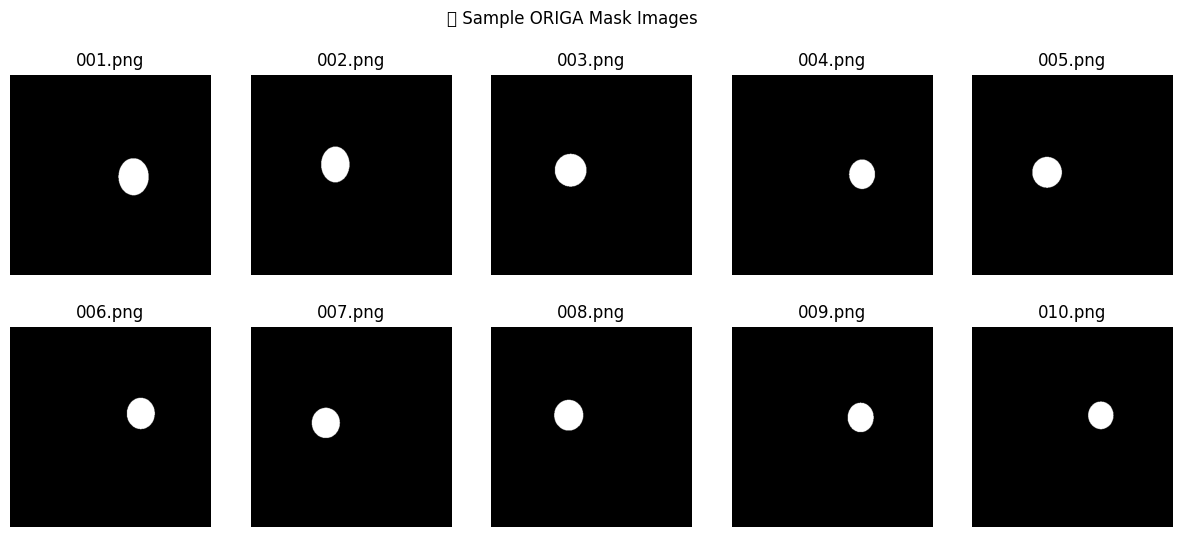

In [29]:
import cv2
import os
import matplotlib.pyplot as plt

mask_folder = r"D:\ProjectML2 - Glaucoma\Dataset\ORIGA\Masks_Enhanced"
sample_images = sorted([f for f in os.listdir(mask_folder) if f.endswith(".png")])[:10]  # Pick first 10

fig, axes = plt.subplots(2, 5, figsize=(15, 6))

for idx, filename in enumerate(sample_images):
    mask_path = os.path.join(mask_folder, filename)
    mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)

    if mask is None:
        continue

    ax = axes[idx // 5, idx % 5]
    ax.imshow(mask, cmap='gray')
    ax.set_title(filename)
    ax.axis("off")

plt.suptitle("🔍 Sample ORIGA Mask Images")
plt.show()


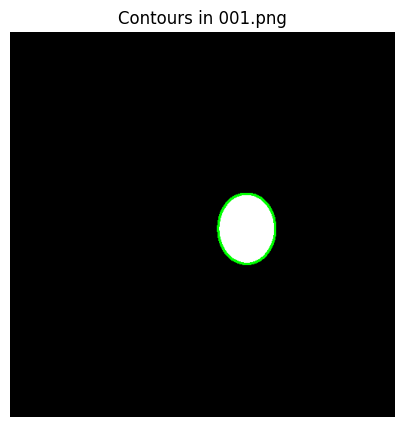

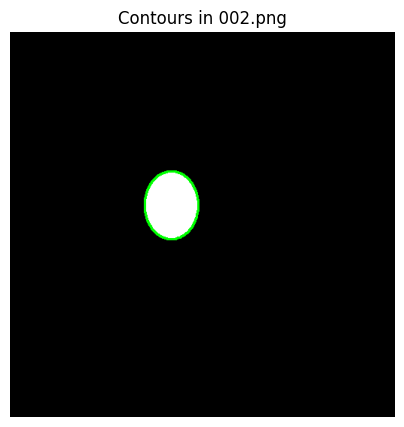

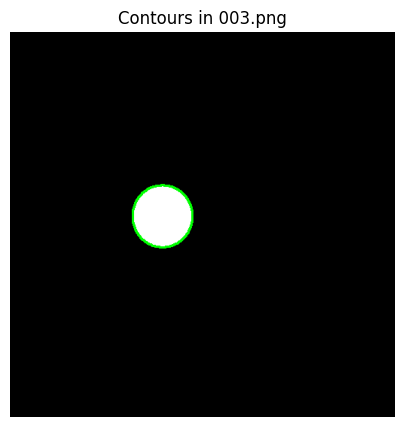

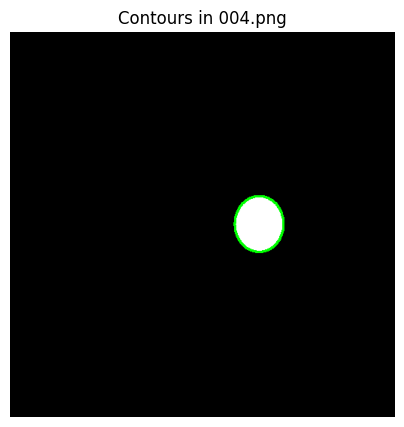

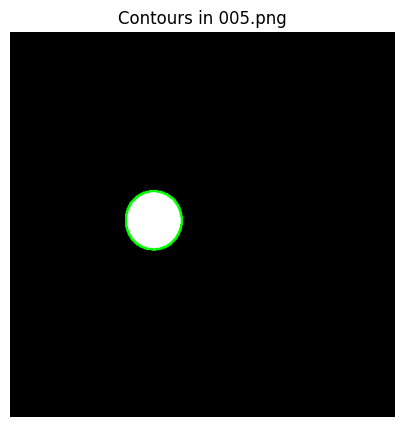

In [30]:
import cv2
import numpy as np
import os
import matplotlib.pyplot as plt

mask_folder = r"D:\ProjectML2 - Glaucoma\Dataset\ORIGA\Masks_Enhanced"
sample_images = sorted([f for f in os.listdir(mask_folder) if f.endswith(".png")])[:5]  # Pick 5 samples

for filename in sample_images:
    mask_path = os.path.join(mask_folder, filename)
    mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)

    if mask is None:
        print(f"❌ Skipping {filename}")
        continue

    # Apply Otsu's Threshold
    _, binary_mask = cv2.threshold(mask, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

    # Find contours
    contours, _ = cv2.findContours(binary_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    contours = sorted(contours, key=cv2.contourArea, reverse=True)

    # Draw contours
    mask_rgb = cv2.cvtColor(mask, cv2.COLOR_GRAY2BGR)
    cv2.drawContours(mask_rgb, contours, -1, (0, 255, 0), 2)

    # Show Image with Contours
    plt.figure(figsize=(5, 5))
    plt.imshow(mask_rgb)
    plt.title(f"Contours in {filename}")
    plt.axis("off")
    plt.show()


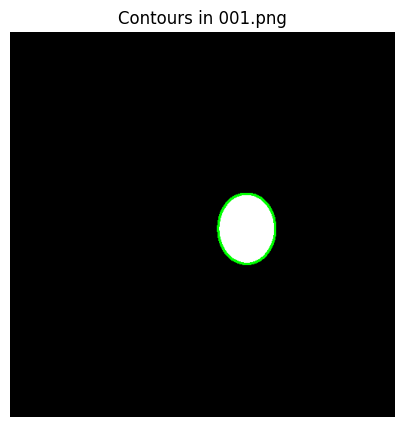

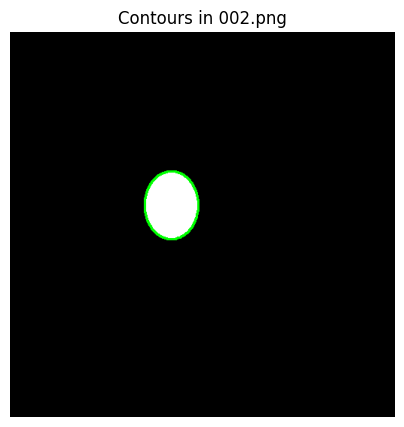

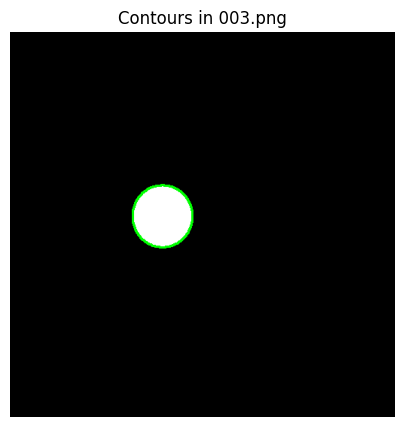

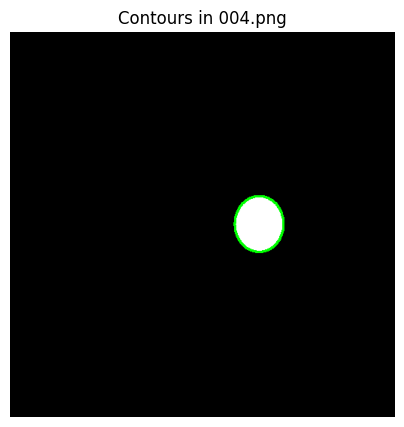

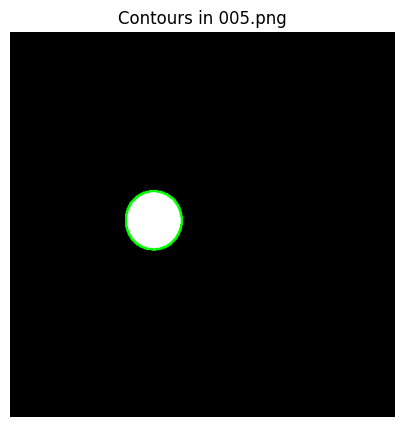

In [31]:
import cv2
import numpy as np
import os
import matplotlib.pyplot as plt

mask_folder = r"D:\ProjectML2 - Glaucoma\Dataset\ORIGA\Masks_Enhanced"
sample_images = sorted([f for f in os.listdir(mask_folder) if f.endswith(".png")])[:5]  # Pick 5 samples

for filename in sample_images:
    mask_path = os.path.join(mask_folder, filename)
    mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)

    if mask is None:
        print(f"❌ Skipping {filename}")
        continue

    # Apply Otsu's Threshold
    _, binary_mask = cv2.threshold(mask, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

    # Find contours
    contours, _ = cv2.findContours(binary_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    contours = sorted(contours, key=cv2.contourArea, reverse=True)

    # Draw contours
    mask_rgb = cv2.cvtColor(mask, cv2.COLOR_GRAY2BGR)
    cv2.drawContours(mask_rgb, contours, -1, (0, 255, 0), 2)

    # Show Image with Contours
    plt.figure(figsize=(5, 5))
    plt.imshow(mask_rgb)
    plt.title(f"Contours in {filename}")
    plt.axis("off")
    plt.show()


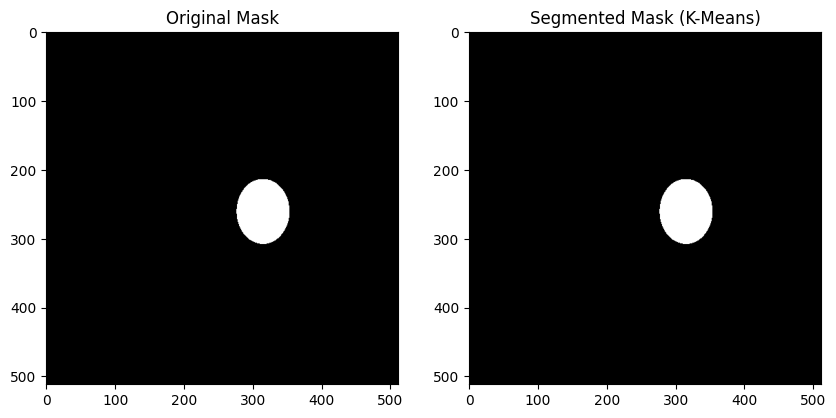

In [32]:
def segment_optic_cup_kmeans(mask):
    Z = mask.reshape((-1, 1))  # Flatten image
    Z = np.float32(Z)

    # Apply K-Means Clustering (2 clusters: cup vs. disc)
    K = 2
    criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 10, 1.0)
    _, labels, centers = cv2.kmeans(Z, K, None, criteria, 10, cv2.KMEANS_RANDOM_CENTERS)

    centers = np.uint8(centers)
    segmented_mask = centers[labels.flatten()].reshape(mask.shape)

    return segmented_mask

# Apply segmentation
sample_image = cv2.imread(r"D:\ProjectML2 - Glaucoma\Dataset\ORIGA\Masks_Enhanced\001.png", cv2.IMREAD_GRAYSCALE)
segmented_mask = segment_optic_cup_kmeans(sample_image)

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(sample_image, cmap='gray')
plt.title("Original Mask")

plt.subplot(1, 2, 2)
plt.imshow(segmented_mask, cmap='gray')
plt.title("Segmented Mask (K-Means)")
plt.show()


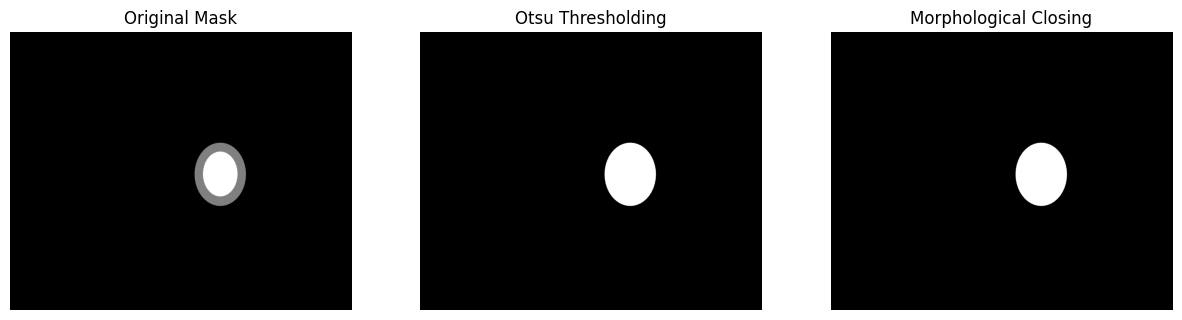

In [34]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Replace this with the actual path to your mask image
image_path = r"D:\ProjectML2 - Glaucoma\Dataset\ORIGA\masks\001.png"  # Update with correct path

# Load the image
original_mask = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)

# Check if image was loaded correctly
if original_mask is None:
    raise FileNotFoundError(f"Error: Could not load image at {image_path}. Check the file path.")

# Apply Gaussian Blur
blurred = cv2.GaussianBlur(original_mask, (5, 5), 0)

# Apply Otsu's thresholding
_, otsu_thresh = cv2.threshold(blurred, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

# Perform morphological closing to refine the mask
kernel = np.ones((5,5), np.uint8)
morph_closed = cv2.morphologyEx(otsu_thresh, cv2.MORPH_CLOSE, kernel)

# Display images
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

axes[0].imshow(original_mask, cmap='gray')
axes[0].set_title("Original Mask")
axes[0].axis("off")

axes[1].imshow(otsu_thresh, cmap='gray')
axes[1].set_title("Otsu Thresholding")
axes[1].axis("off")

axes[2].imshow(morph_closed, cmap='gray')
axes[2].set_title("Morphological Closing")
axes[2].axis("off")

plt.show()


In [35]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Set paths
mask_dir = r"D:\ProjectML2 - Glaucoma\Dataset\ORIGA\masks"  # Change to your actual path
output_dir = r"D:\ProjectML2 - Glaucoma\Dataset\ORIGA\processed_masks"

# Create output directory if it doesn't exist
os.makedirs(output_dir, exist_ok=True)

# Get all image files in mask directory
mask_files = [f for f in os.listdir(mask_dir) if f.endswith(".png")]

# Process each mask
for file in mask_files:
    image_path = os.path.join(mask_dir, file)
    save_path = os.path.join(output_dir, file)

    # Read the mask image
    original_mask = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    if original_mask is None:
        print(f"Error reading {file}. Skipping...")
        continue

    # Apply Gaussian Blur to smooth edges
    blurred = cv2.GaussianBlur(original_mask, (5, 5), 0)

    # Apply Otsu's Thresholding
    _, otsu_thresh = cv2.threshold(blurred, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

    # Apply morphological closing to fill gaps
    kernel = np.ones((5, 5), np.uint8)
    morph_closed = cv2.morphologyEx(otsu_thresh, cv2.MORPH_CLOSE, kernel)

    # Save processed mask
    cv2.imwrite(save_path, morph_closed)

    print(f"Processed and saved: {file}")

print("\n✅ All masks processed and saved successfully!")


Processed and saved: 001.png
Processed and saved: 002.png
Processed and saved: 003.png
Processed and saved: 004.png
Processed and saved: 005.png
Processed and saved: 006.png
Processed and saved: 007.png
Processed and saved: 008.png
Processed and saved: 009.png
Processed and saved: 010.png
Processed and saved: 011.png
Processed and saved: 012.png
Processed and saved: 013.png
Processed and saved: 014.png
Processed and saved: 015.png
Processed and saved: 016.png
Processed and saved: 017.png
Processed and saved: 018.png
Processed and saved: 019.png
Processed and saved: 020.png
Processed and saved: 021.png
Processed and saved: 022.png
Processed and saved: 023.png
Processed and saved: 024.png
Processed and saved: 025.png
Processed and saved: 026.png
Processed and saved: 027.png
Processed and saved: 028.png
Processed and saved: 029.png
Processed and saved: 030.png
Processed and saved: 031.png
Processed and saved: 032.png
Processed and saved: 033.png
Processed and saved: 034.png
Processed and 

In [36]:
import os
import cv2
import numpy as np
import pandas as pd

# Set paths
mask_dir = r"D:\ProjectML2 - Glaucoma\Dataset\ORIGA\processed_masks"  # Change this to processed mask directory
output_csv = r"D:\ProjectML2 - Glaucoma\Dataset\ORIGA\cdr_values.csv"

# Initialize list to store results
cdr_data = []

# Get all processed mask files
mask_files = [f for f in os.listdir(mask_dir) if f.endswith(".png")]

# Function to compute area of the largest contour
def compute_area(binary_image):
    contours, _ = cv2.findContours(binary_image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    if len(contours) == 0:
        return 0
    return max(cv2.contourArea(c) for c in contours)  # Take the largest contour area

# Process each mask
for file in mask_files:
    image_path = os.path.join(mask_dir, file)

    # Read the mask image
    mask = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    if mask is None:
        print(f"Error reading {file}. Skipping...")
        continue

    # Apply thresholding to binarize the mask
    _, binary_mask = cv2.threshold(mask, 127, 255, cv2.THRESH_BINARY)

    # Compute cup area (white region in mask)
    cup_area = compute_area(binary_mask)

    # Approximate disc area (assuming disc covers the entire segmented mask)
    disc_area = np.count_nonzero(binary_mask)

    # Compute CDR
    cdr = round(cup_area / disc_area, 4) if disc_area > 0 else 0

    # Append to list
    cdr_data.append([file, cup_area, disc_area, cdr])

# Save results to CSV
cdr_df = pd.DataFrame(cdr_data, columns=["Filename", "Cup Area", "Disc Area", "CDR"])
cdr_df.to_csv(output_csv, index=False)

print("\n✅ CDR values computed and saved successfully!")



✅ CDR values computed and saved successfully!


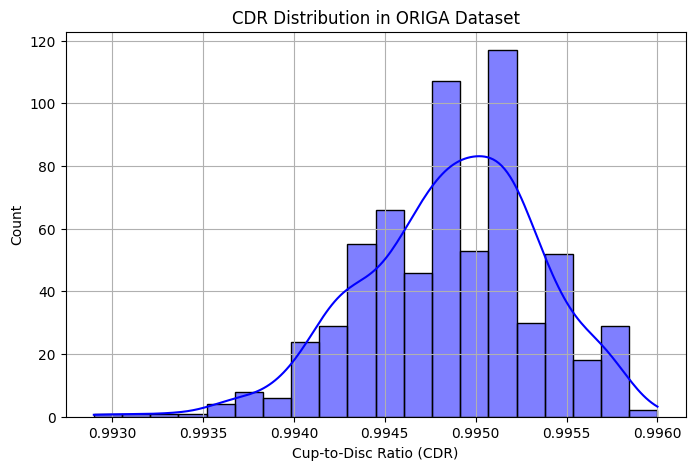

In [37]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load the computed CDR values
cdr_csv = r"D:\ProjectML2 - Glaucoma\Dataset\ORIGA\cdr_values.csv"
cdr_df = pd.read_csv(cdr_csv)

# Plot CDR distribution
plt.figure(figsize=(8, 5))
sns.histplot(cdr_df["CDR"], bins=20, kde=True, color="blue")
plt.xlabel("Cup-to-Disc Ratio (CDR)")
plt.ylabel("Count")
plt.title("CDR Distribution in ORIGA Dataset")
plt.grid(True)
plt.show()


In [38]:
print(cdr_df.describe())


            Cup Area      Disc Area         CDR
count     650.000000     650.000000  650.000000
mean    99459.043846   99963.561538    0.994867
std     18459.728054   18506.371870    0.000485
min     50022.000000   50380.000000    0.992900
25%     86371.000000   86843.250000    0.994600
50%     98135.500000   98638.500000    0.994900
75%    110567.000000  111100.250000    0.995200
max    157635.000000  158274.000000    0.996000


In [39]:
import numpy as np

# Correcting CDR using diameters instead of areas
cdr_df["CDR"] = np.sqrt(cdr_df["Cup Area"]) / np.sqrt(cdr_df["Disc Area"])

# Save the corrected CDR values
cdr_df.to_csv("corrected_cdr_values.csv", index=False)

# Display summary statistics
print(cdr_df.describe())


            Cup Area      Disc Area         CDR
count     650.000000     650.000000  650.000000
mean    99459.043846   99963.561538    0.997429
std     18459.728054   18506.371870    0.000243
min     50022.000000   50380.000000    0.996441
25%     86371.000000   86843.250000    0.997277
50%     98135.500000   98638.500000    0.997447
75%    110567.000000  111100.250000    0.997592
max    157635.000000  158274.000000    0.997979


In [40]:
print(cdr_df.head(10))


  Filename  Cup Area  Disc Area       CDR
0  001.png  137343.0     137943  0.997823
1  002.png  121725.5     122292  0.997681
2  003.png  123006.0     123567  0.997727
3  004.png   95160.5      95657  0.997401
4  005.png  114171.0     114712  0.997639
5  006.png  103423.0     103940  0.997510
6  007.png  100187.0     100695  0.997474
7  008.png  109193.0     109722  0.997586
8  009.png   91569.0      92056  0.997351
9  010.png   85252.0      85721  0.997261


✅ Found 650 mask images!
🖼️ 001.png - Unique values: {np.uint8(0), np.uint8(1), np.uint8(2)}


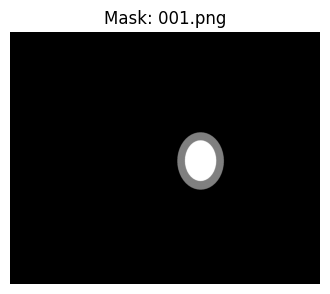

🖼️ 002.png - Unique values: {np.uint8(0), np.uint8(1), np.uint8(2)}


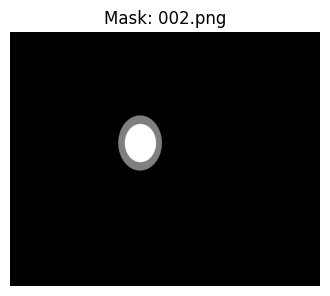

🖼️ 003.png - Unique values: {np.uint8(0), np.uint8(1), np.uint8(2)}


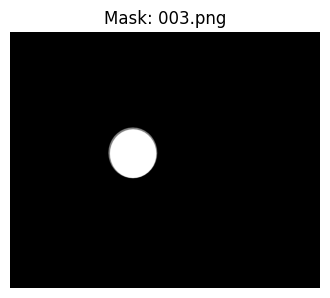

🖼️ 004.png - Unique values: {np.uint8(0), np.uint8(1), np.uint8(2)}


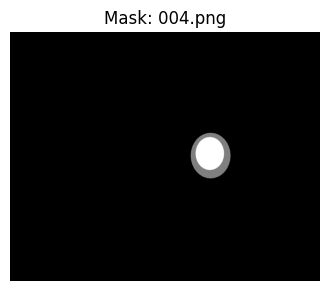

🖼️ 005.png - Unique values: {np.uint8(0), np.uint8(1), np.uint8(2)}


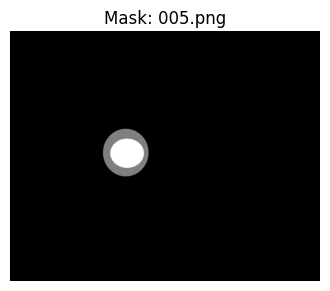

🖼️ 006.png - Unique values: {np.uint8(0), np.uint8(1), np.uint8(2)}


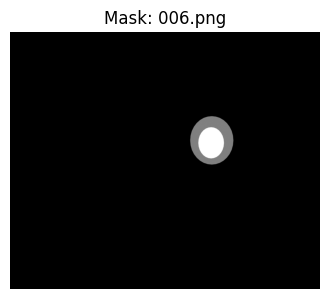

🖼️ 007.png - Unique values: {np.uint8(0), np.uint8(1), np.uint8(2)}


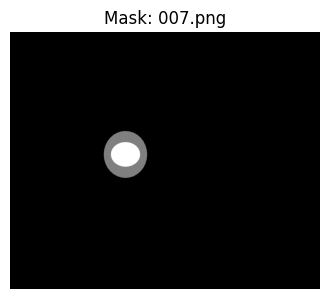

🖼️ 008.png - Unique values: {np.uint8(0), np.uint8(1), np.uint8(2)}


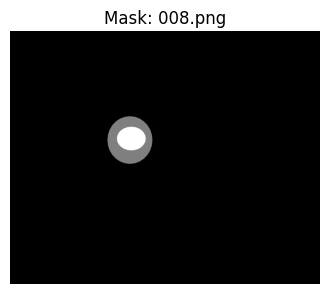

🖼️ 009.png - Unique values: {np.uint8(0), np.uint8(1), np.uint8(2)}


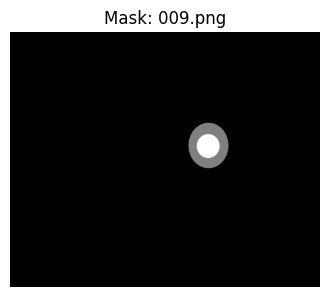

🖼️ 010.png - Unique values: {np.uint8(0), np.uint8(1), np.uint8(2)}


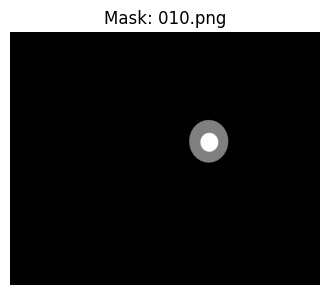

🖼️ 011.png - Unique values: {np.uint8(0), np.uint8(1), np.uint8(2)}


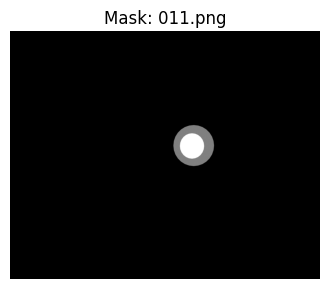

🖼️ 012.png - Unique values: {np.uint8(0), np.uint8(1), np.uint8(2)}


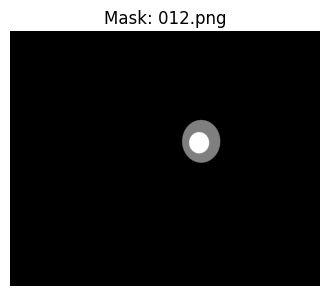

🖼️ 013.png - Unique values: {np.uint8(0), np.uint8(1), np.uint8(2)}


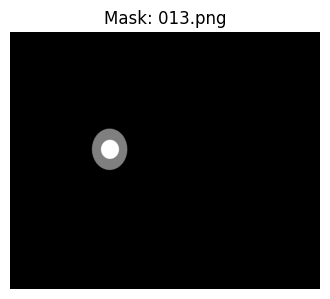

🖼️ 014.png - Unique values: {np.uint8(0), np.uint8(1), np.uint8(2)}


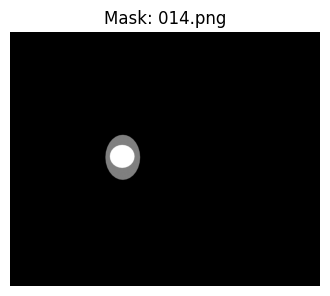

🖼️ 015.png - Unique values: {np.uint8(0), np.uint8(1), np.uint8(2)}


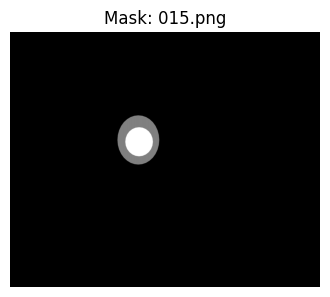

🖼️ 016.png - Unique values: {np.uint8(0), np.uint8(1), np.uint8(2)}


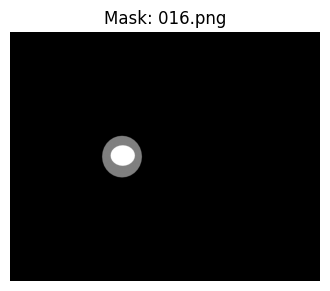

🖼️ 017.png - Unique values: {np.uint8(0), np.uint8(1), np.uint8(2)}


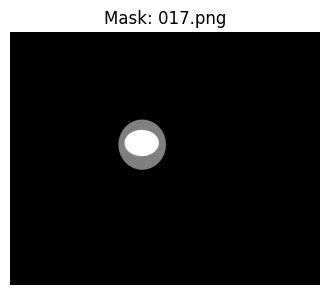

🖼️ 018.png - Unique values: {np.uint8(0), np.uint8(1), np.uint8(2)}


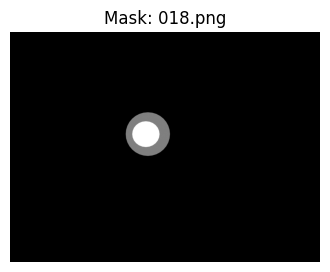

🖼️ 019.png - Unique values: {np.uint8(0), np.uint8(1), np.uint8(2)}


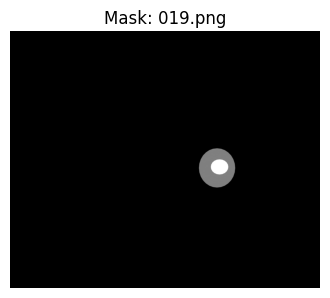

🖼️ 020.png - Unique values: {np.uint8(0), np.uint8(1), np.uint8(2)}


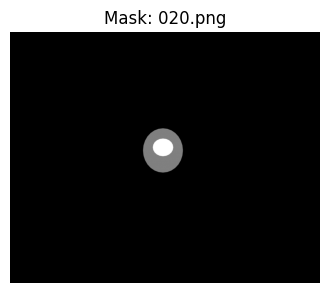

🖼️ 021.png - Unique values: {np.uint8(0), np.uint8(1), np.uint8(2)}


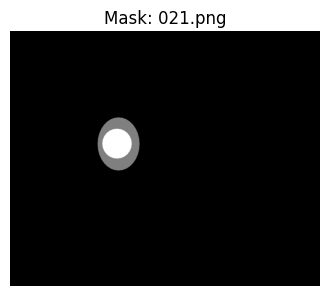

🖼️ 022.png - Unique values: {np.uint8(0), np.uint8(1), np.uint8(2)}


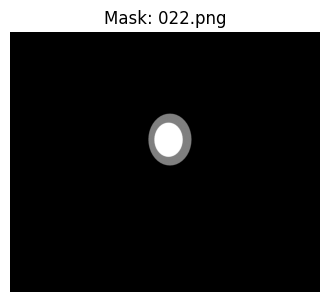

🖼️ 023.png - Unique values: {np.uint8(0), np.uint8(1), np.uint8(2)}


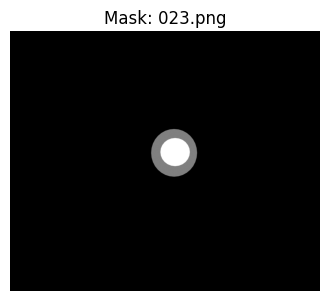

🖼️ 024.png - Unique values: {np.uint8(0), np.uint8(1), np.uint8(2)}


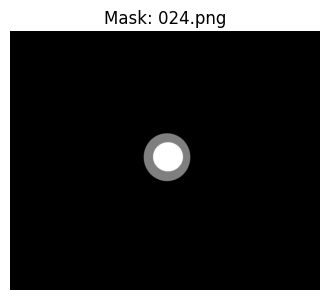

🖼️ 025.png - Unique values: {np.uint8(0), np.uint8(1), np.uint8(2)}


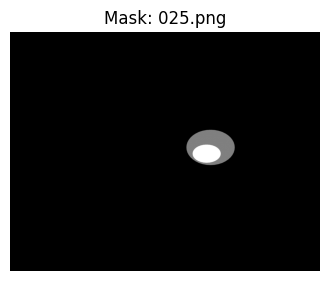

🖼️ 026.png - Unique values: {np.uint8(0), np.uint8(1), np.uint8(2)}


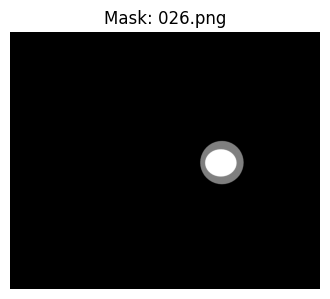

🖼️ 027.png - Unique values: {np.uint8(0), np.uint8(1), np.uint8(2)}


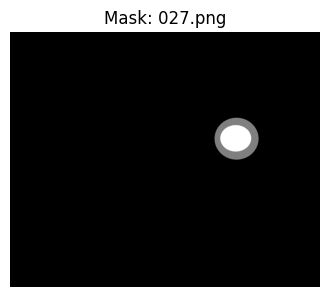

🖼️ 028.png - Unique values: {np.uint8(0), np.uint8(1), np.uint8(2)}


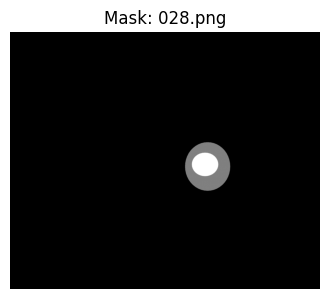

🖼️ 029.png - Unique values: {np.uint8(0), np.uint8(1), np.uint8(2)}


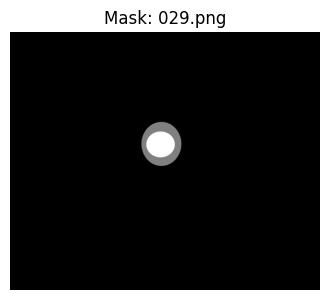

🖼️ 030.png - Unique values: {np.uint8(0), np.uint8(1), np.uint8(2)}


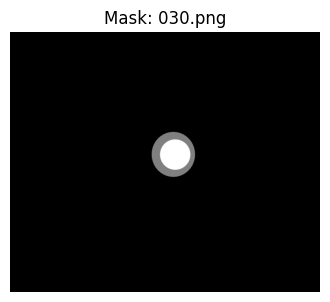

🖼️ 031.png - Unique values: {np.uint8(0), np.uint8(1), np.uint8(2)}


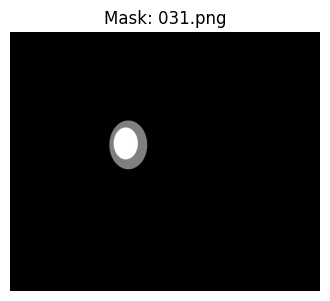

🖼️ 032.png - Unique values: {np.uint8(0), np.uint8(1), np.uint8(2)}


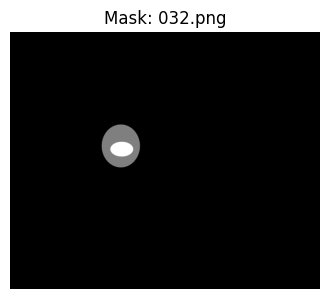

🖼️ 033.png - Unique values: {np.uint8(0), np.uint8(1), np.uint8(2)}


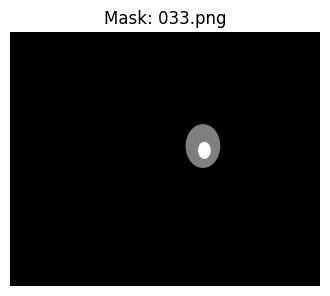

🖼️ 034.png - Unique values: {np.uint8(0), np.uint8(1), np.uint8(2)}


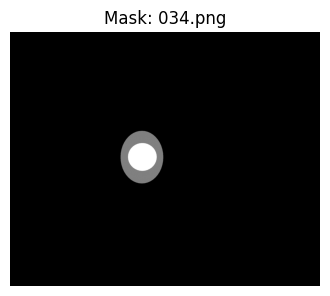

🖼️ 035.png - Unique values: {np.uint8(0), np.uint8(1), np.uint8(2)}


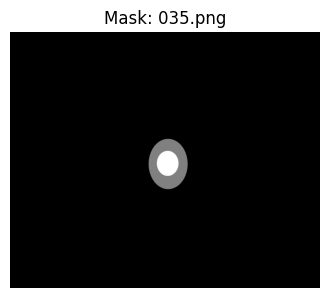

🖼️ 036.png - Unique values: {np.uint8(0), np.uint8(1), np.uint8(2)}


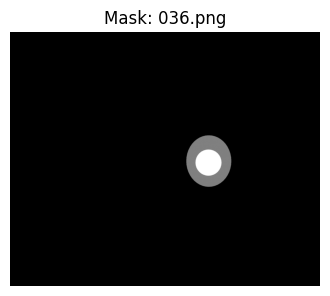

🖼️ 037.png - Unique values: {np.uint8(0), np.uint8(1), np.uint8(2)}


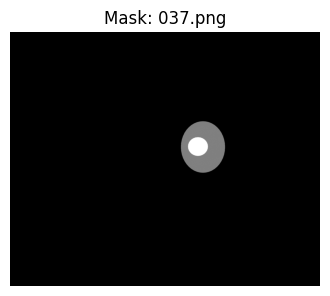

🖼️ 038.png - Unique values: {np.uint8(0), np.uint8(1), np.uint8(2)}


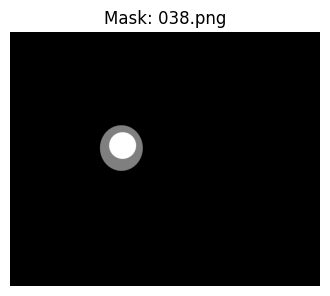

🖼️ 039.png - Unique values: {np.uint8(0), np.uint8(1), np.uint8(2)}


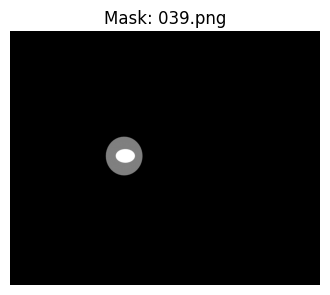

🖼️ 040.png - Unique values: {np.uint8(0), np.uint8(1), np.uint8(2)}


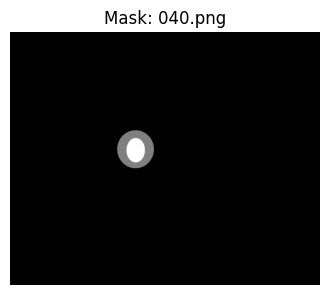

🖼️ 041.png - Unique values: {np.uint8(0), np.uint8(1), np.uint8(2)}


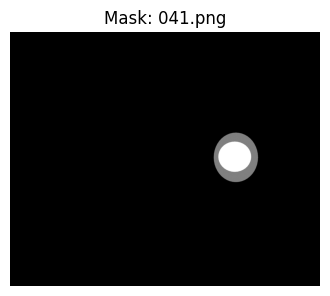

🖼️ 042.png - Unique values: {np.uint8(0), np.uint8(1), np.uint8(2)}


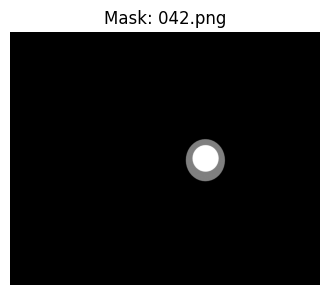

🖼️ 043.png - Unique values: {np.uint8(0), np.uint8(1), np.uint8(2)}


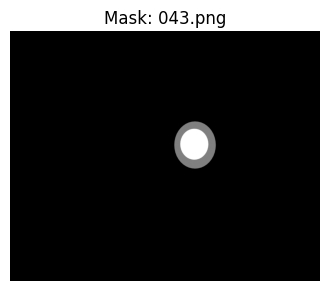

🖼️ 044.png - Unique values: {np.uint8(0), np.uint8(1), np.uint8(2)}


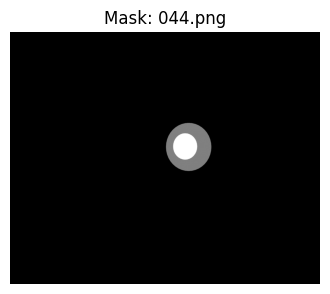

🖼️ 045.png - Unique values: {np.uint8(0), np.uint8(1), np.uint8(2)}


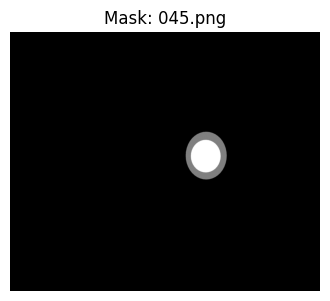

🖼️ 046.png - Unique values: {np.uint8(0), np.uint8(1), np.uint8(2)}


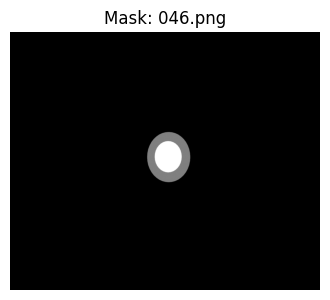

🖼️ 047.png - Unique values: {np.uint8(0), np.uint8(1), np.uint8(2)}


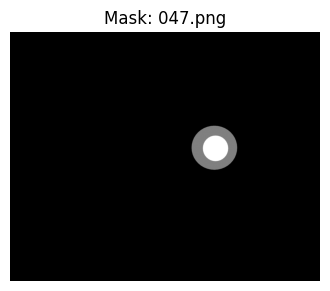

🖼️ 048.png - Unique values: {np.uint8(0), np.uint8(1), np.uint8(2)}


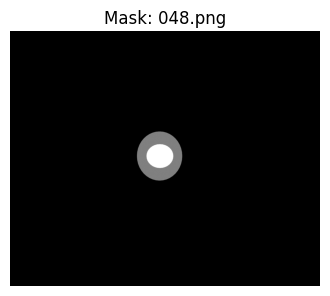

🖼️ 049.png - Unique values: {np.uint8(0), np.uint8(1), np.uint8(2)}


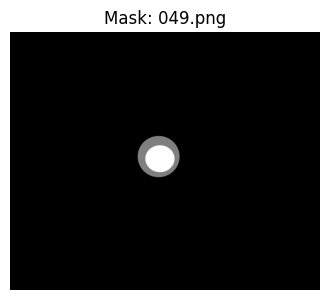

🖼️ 050.png - Unique values: {np.uint8(0), np.uint8(1), np.uint8(2)}


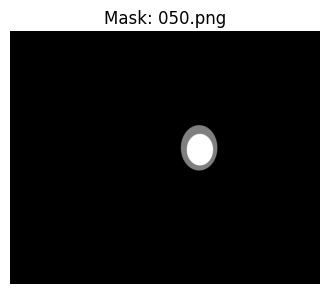

🖼️ 051.png - Unique values: {np.uint8(0), np.uint8(1), np.uint8(2)}


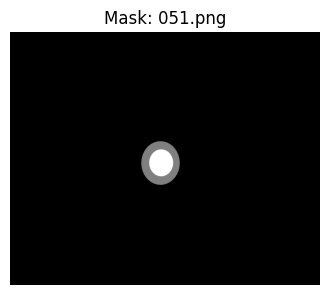

🖼️ 052.png - Unique values: {np.uint8(0), np.uint8(1), np.uint8(2)}


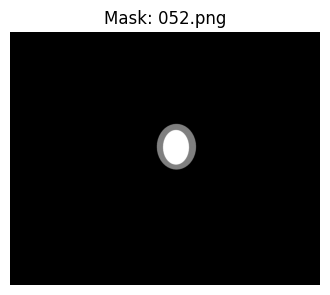

🖼️ 053.png - Unique values: {np.uint8(0), np.uint8(1), np.uint8(2)}


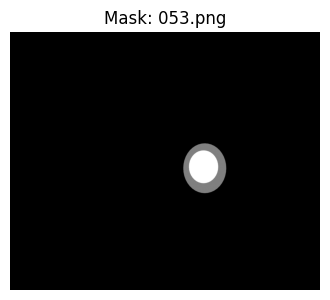

🖼️ 054.png - Unique values: {np.uint8(0), np.uint8(1), np.uint8(2)}


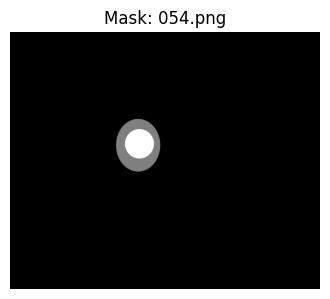

🖼️ 055.png - Unique values: {np.uint8(0), np.uint8(1), np.uint8(2)}


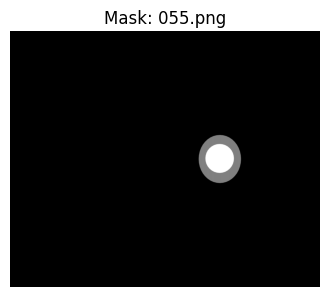

🖼️ 056.png - Unique values: {np.uint8(0), np.uint8(1), np.uint8(2)}


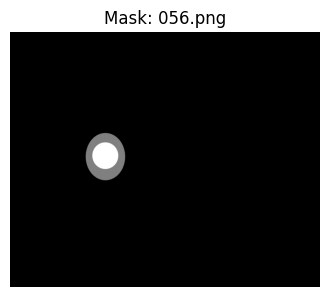

🖼️ 057.png - Unique values: {np.uint8(0), np.uint8(1), np.uint8(2)}


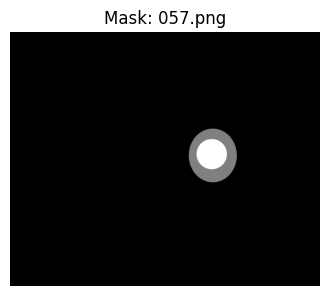

🖼️ 058.png - Unique values: {np.uint8(0), np.uint8(1), np.uint8(2)}


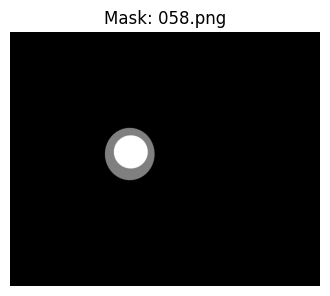

🖼️ 059.png - Unique values: {np.uint8(0), np.uint8(1), np.uint8(2)}


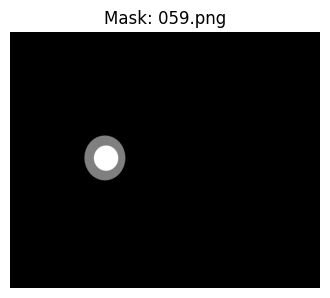

🖼️ 060.png - Unique values: {np.uint8(0), np.uint8(1), np.uint8(2)}


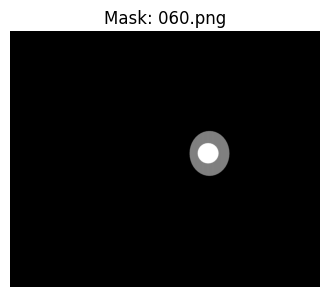

🖼️ 061.png - Unique values: {np.uint8(0), np.uint8(1), np.uint8(2)}


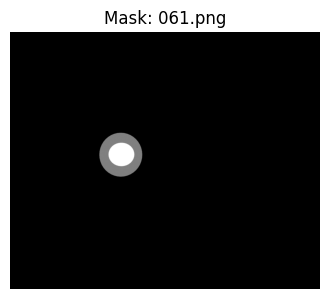

🖼️ 062.png - Unique values: {np.uint8(0), np.uint8(1), np.uint8(2)}


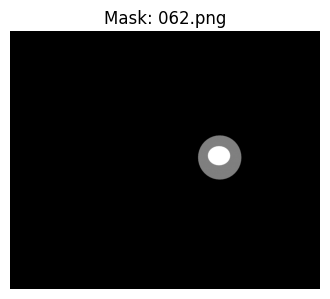

🖼️ 063.png - Unique values: {np.uint8(0), np.uint8(1), np.uint8(2)}


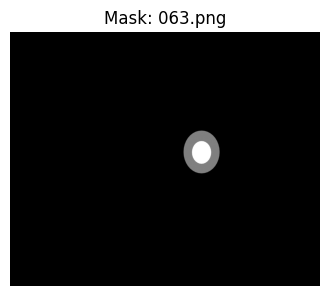

🖼️ 064.png - Unique values: {np.uint8(0), np.uint8(1), np.uint8(2)}


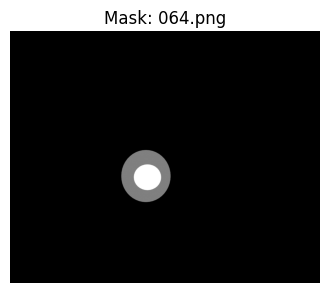

🖼️ 065.png - Unique values: {np.uint8(0), np.uint8(1), np.uint8(2)}


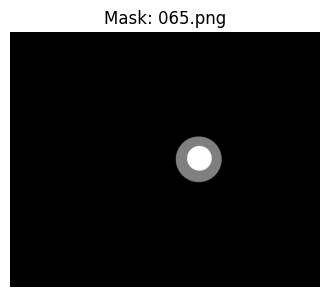

🖼️ 066.png - Unique values: {np.uint8(0), np.uint8(1), np.uint8(2)}


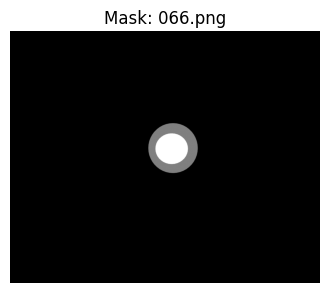

🖼️ 067.png - Unique values: {np.uint8(0), np.uint8(1), np.uint8(2)}


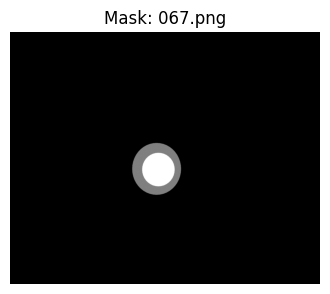

🖼️ 068.png - Unique values: {np.uint8(0), np.uint8(1), np.uint8(2)}


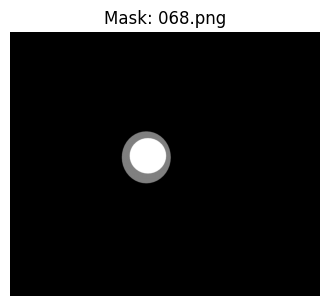

🖼️ 069.png - Unique values: {np.uint8(0), np.uint8(1), np.uint8(2)}


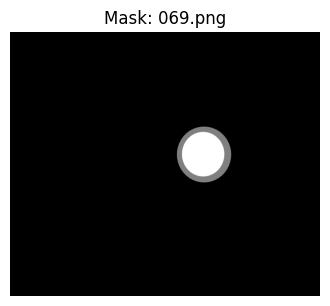

🖼️ 070.png - Unique values: {np.uint8(0), np.uint8(1), np.uint8(2)}


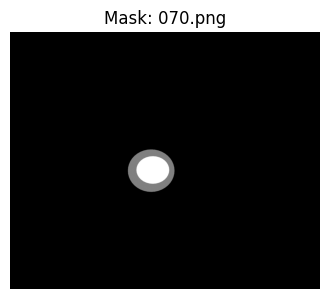

🖼️ 071.png - Unique values: {np.uint8(0), np.uint8(1), np.uint8(2)}


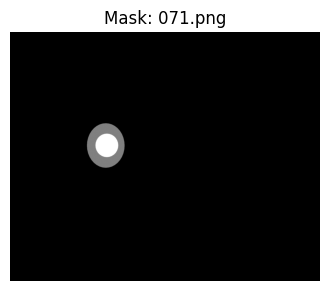

🖼️ 072.png - Unique values: {np.uint8(0), np.uint8(1), np.uint8(2)}


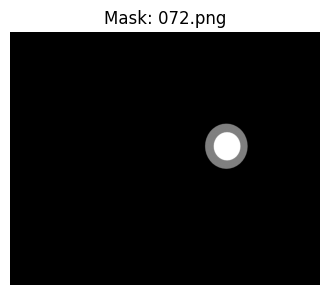

🖼️ 073.png - Unique values: {np.uint8(0), np.uint8(1), np.uint8(2)}


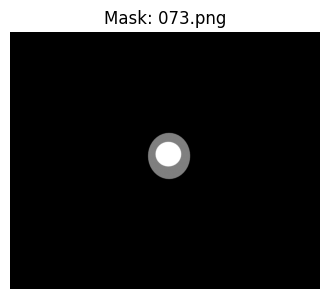

🖼️ 074.png - Unique values: {np.uint8(0), np.uint8(1), np.uint8(2)}


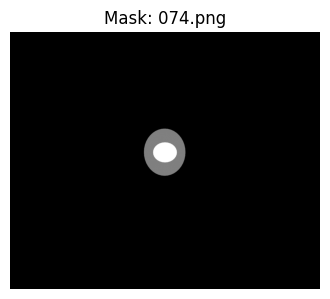

🖼️ 075.png - Unique values: {np.uint8(0), np.uint8(1), np.uint8(2)}


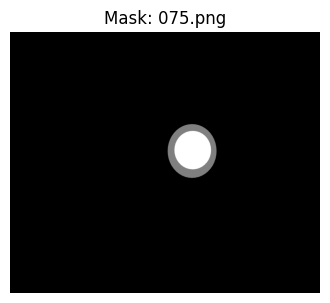

🖼️ 076.png - Unique values: {np.uint8(0), np.uint8(1), np.uint8(2)}


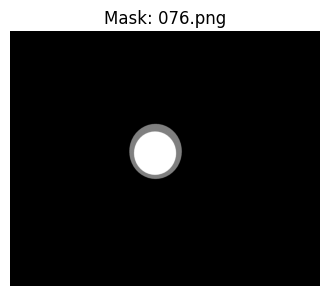

🖼️ 077.png - Unique values: {np.uint8(0), np.uint8(1), np.uint8(2)}


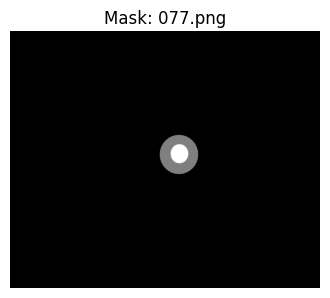

🖼️ 078.png - Unique values: {np.uint8(0), np.uint8(1), np.uint8(2)}


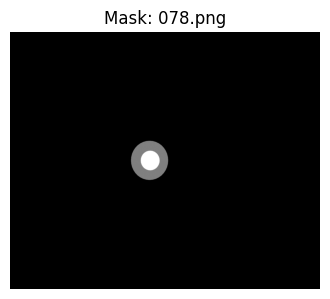

🖼️ 079.png - Unique values: {np.uint8(0), np.uint8(1), np.uint8(2)}


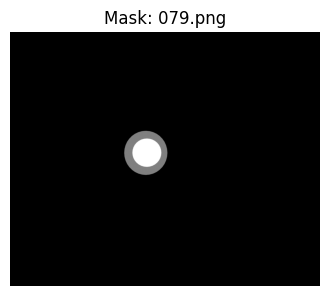

🖼️ 080.png - Unique values: {np.uint8(0), np.uint8(1), np.uint8(2)}


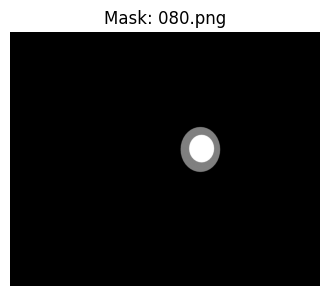

🖼️ 081.png - Unique values: {np.uint8(0), np.uint8(1), np.uint8(2)}


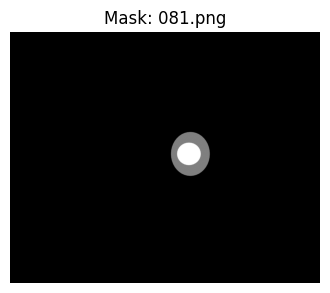

🖼️ 082.png - Unique values: {np.uint8(0), np.uint8(1), np.uint8(2)}


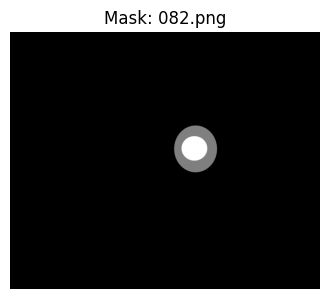

🖼️ 083.png - Unique values: {np.uint8(0), np.uint8(1), np.uint8(2)}


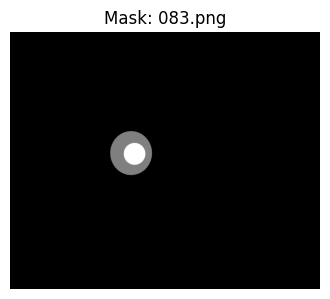

🖼️ 084.png - Unique values: {np.uint8(0), np.uint8(1), np.uint8(2)}


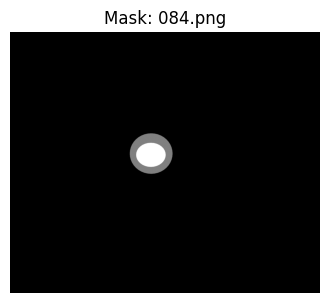

🖼️ 085.png - Unique values: {np.uint8(0), np.uint8(1), np.uint8(2)}


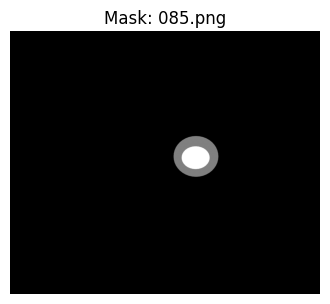

🖼️ 086.png - Unique values: {np.uint8(0), np.uint8(1), np.uint8(2)}


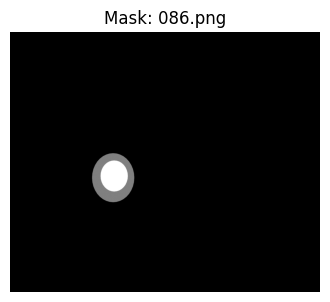

🖼️ 087.png - Unique values: {np.uint8(0), np.uint8(1), np.uint8(2)}


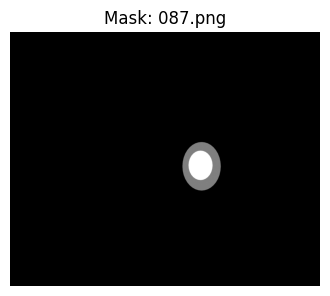

🖼️ 088.png - Unique values: {np.uint8(0), np.uint8(1), np.uint8(2)}


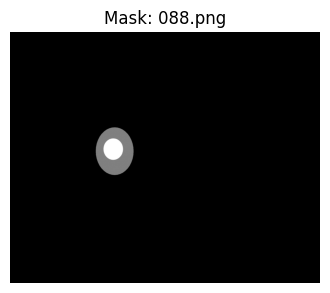

🖼️ 089.png - Unique values: {np.uint8(0), np.uint8(1), np.uint8(2)}


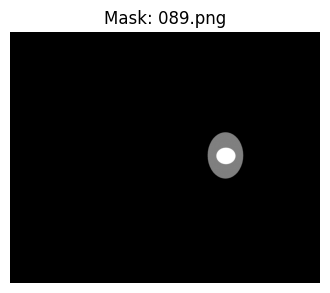

🖼️ 090.png - Unique values: {np.uint8(0), np.uint8(1), np.uint8(2)}


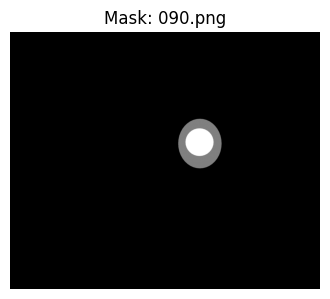

🖼️ 091.png - Unique values: {np.uint8(0), np.uint8(1), np.uint8(2)}


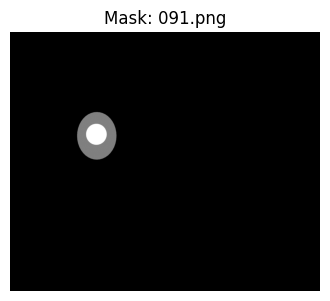

🖼️ 092.png - Unique values: {np.uint8(0), np.uint8(1), np.uint8(2)}


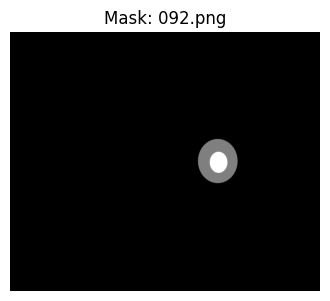

🖼️ 093.png - Unique values: {np.uint8(0), np.uint8(1), np.uint8(2)}


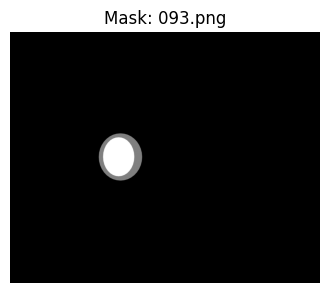

🖼️ 094.png - Unique values: {np.uint8(0), np.uint8(1), np.uint8(2)}


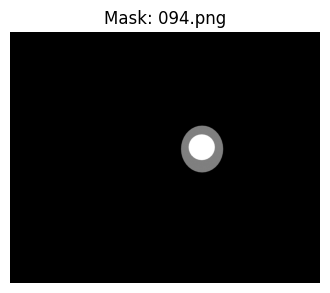

🖼️ 095.png - Unique values: {np.uint8(0), np.uint8(1), np.uint8(2)}


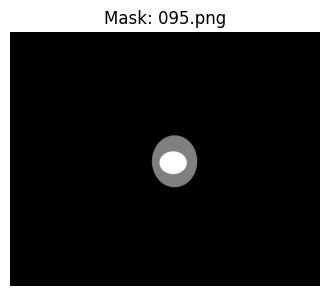

🖼️ 096.png - Unique values: {np.uint8(0), np.uint8(1), np.uint8(2)}


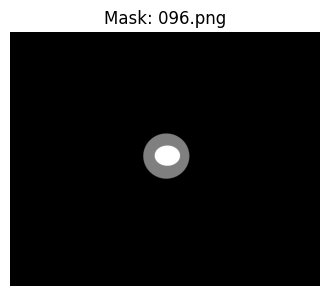

🖼️ 097.png - Unique values: {np.uint8(0), np.uint8(1), np.uint8(2)}


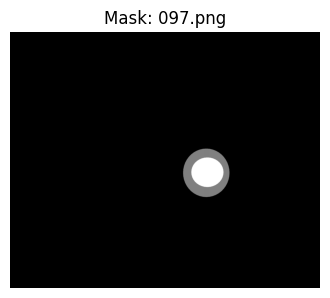

🖼️ 098.png - Unique values: {np.uint8(0), np.uint8(1), np.uint8(2)}


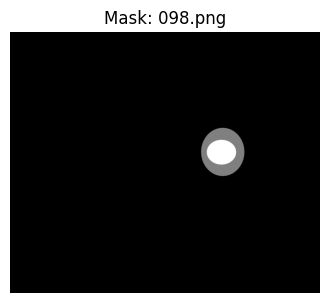

🖼️ 099.png - Unique values: {np.uint8(0), np.uint8(1), np.uint8(2)}


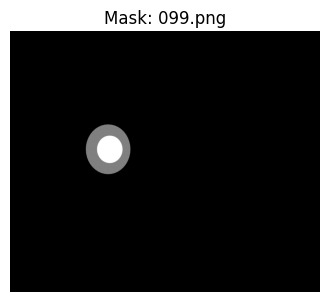

🖼️ 100.png - Unique values: {np.uint8(0), np.uint8(1), np.uint8(2)}


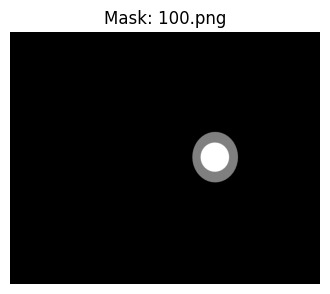

🖼️ 101.png - Unique values: {np.uint8(0), np.uint8(1), np.uint8(2)}


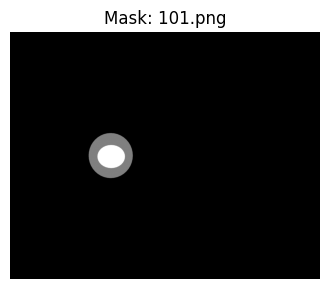

🖼️ 102.png - Unique values: {np.uint8(0), np.uint8(1), np.uint8(2)}


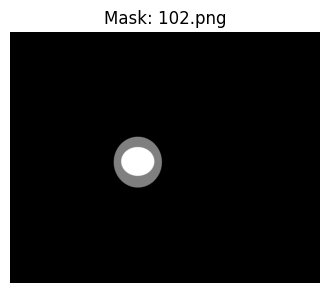

🖼️ 103.png - Unique values: {np.uint8(0), np.uint8(1), np.uint8(2)}


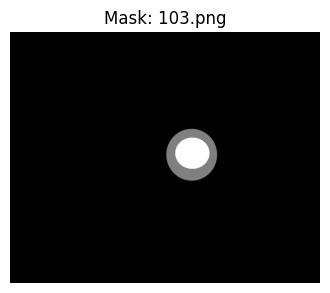

🖼️ 104.png - Unique values: {np.uint8(0), np.uint8(1), np.uint8(2)}


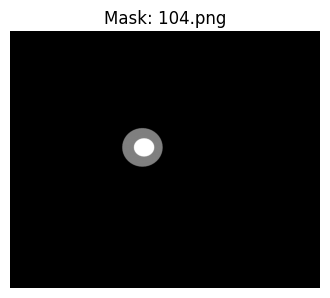

🖼️ 105.png - Unique values: {np.uint8(0), np.uint8(1), np.uint8(2)}


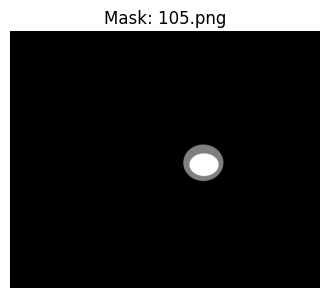

🖼️ 106.png - Unique values: {np.uint8(0), np.uint8(1), np.uint8(2)}


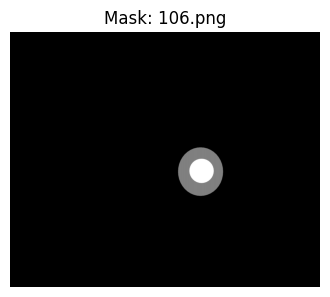

🖼️ 107.png - Unique values: {np.uint8(0), np.uint8(1), np.uint8(2)}


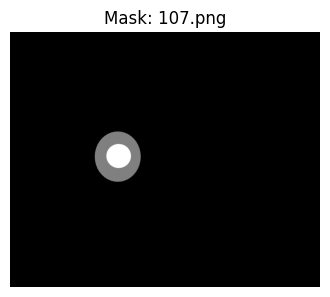

🖼️ 108.png - Unique values: {np.uint8(0), np.uint8(1), np.uint8(2)}


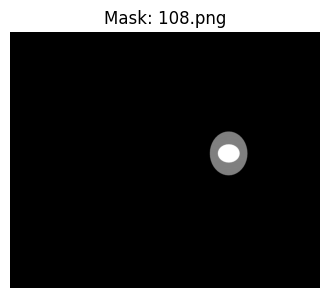

🖼️ 109.png - Unique values: {np.uint8(0), np.uint8(1), np.uint8(2)}


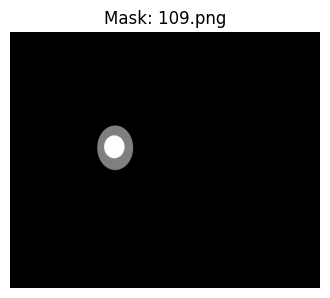

🖼️ 110.png - Unique values: {np.uint8(0), np.uint8(1), np.uint8(2)}


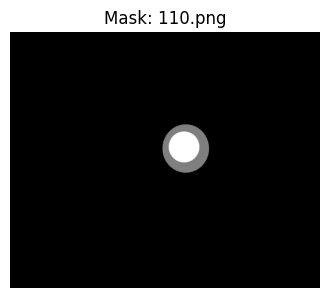

🖼️ 111.png - Unique values: {np.uint8(0), np.uint8(1), np.uint8(2)}


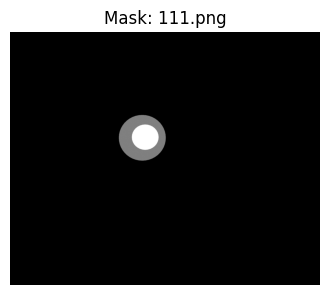

🖼️ 112.png - Unique values: {np.uint8(0), np.uint8(1), np.uint8(2)}


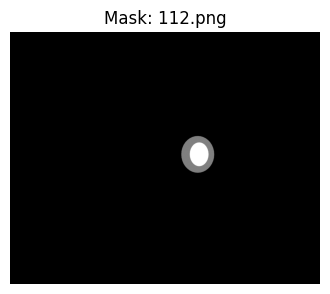

🖼️ 113.png - Unique values: {np.uint8(0), np.uint8(1), np.uint8(2)}


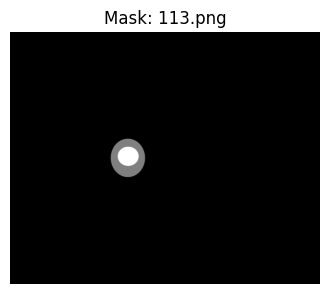

🖼️ 114.png - Unique values: {np.uint8(0), np.uint8(1), np.uint8(2)}


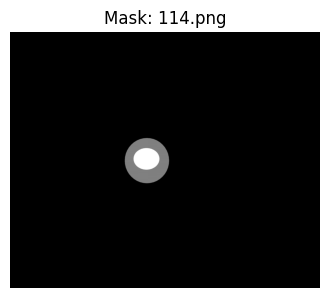

🖼️ 115.png - Unique values: {np.uint8(0), np.uint8(1), np.uint8(2)}


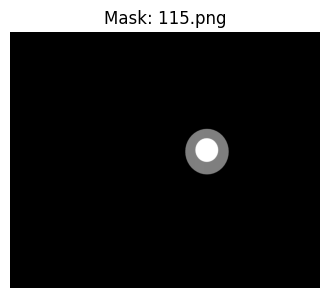

🖼️ 116.png - Unique values: {np.uint8(0), np.uint8(1), np.uint8(2)}


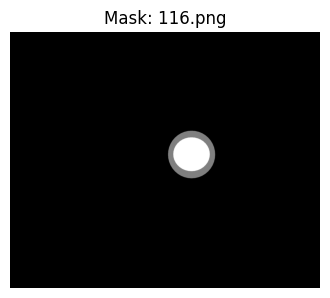

🖼️ 117.png - Unique values: {np.uint8(0), np.uint8(1), np.uint8(2)}


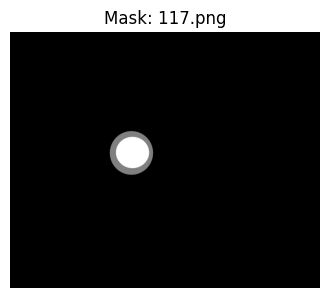

🖼️ 118.png - Unique values: {np.uint8(0), np.uint8(1), np.uint8(2)}


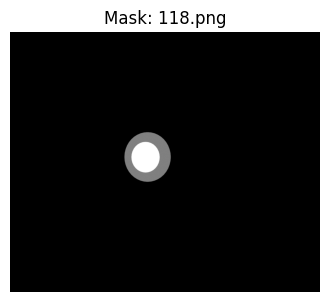

🖼️ 119.png - Unique values: {np.uint8(0), np.uint8(1), np.uint8(2)}


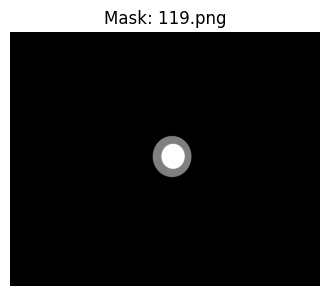

🖼️ 120.png - Unique values: {np.uint8(0), np.uint8(1), np.uint8(2)}


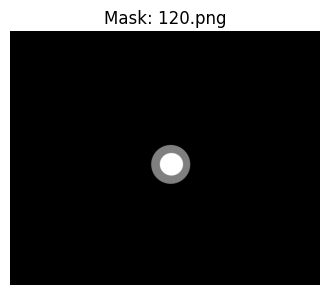

🖼️ 121.png - Unique values: {np.uint8(0), np.uint8(1), np.uint8(2)}


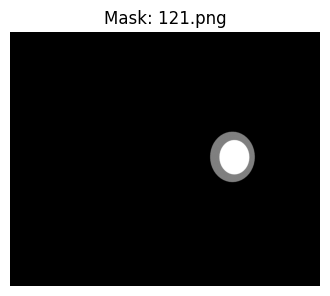

🖼️ 122.png - Unique values: {np.uint8(0), np.uint8(1), np.uint8(2)}


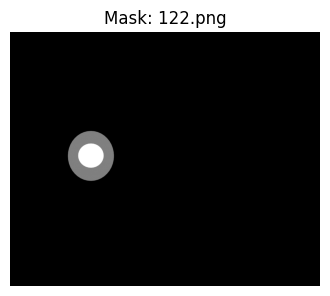

🖼️ 123.png - Unique values: {np.uint8(0), np.uint8(1), np.uint8(2)}


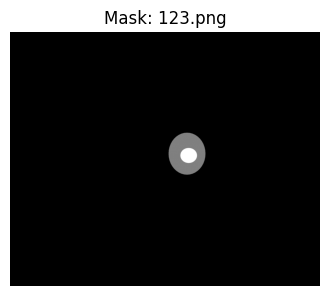

🖼️ 124.png - Unique values: {np.uint8(0), np.uint8(1), np.uint8(2)}


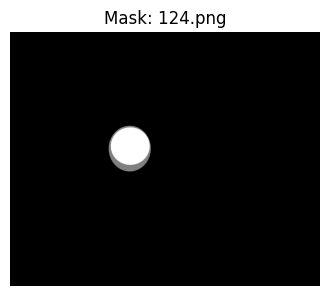

🖼️ 125.png - Unique values: {np.uint8(0), np.uint8(1), np.uint8(2)}


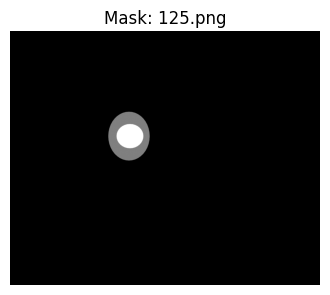

🖼️ 126.png - Unique values: {np.uint8(0), np.uint8(1), np.uint8(2)}


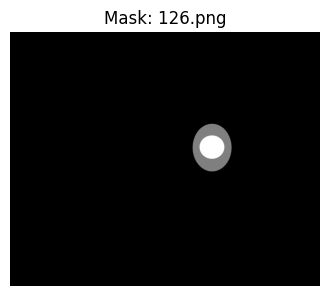

🖼️ 127.png - Unique values: {np.uint8(0), np.uint8(1), np.uint8(2)}


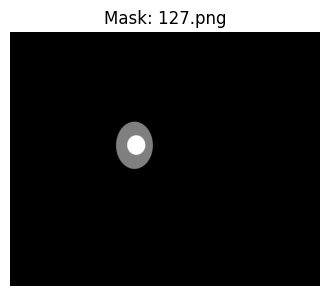

🖼️ 128.png - Unique values: {np.uint8(0), np.uint8(1), np.uint8(2)}


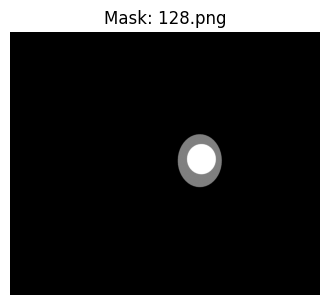

🖼️ 129.png - Unique values: {np.uint8(0), np.uint8(1), np.uint8(2)}


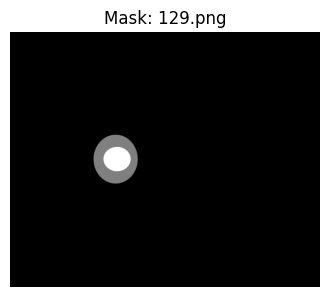

🖼️ 130.png - Unique values: {np.uint8(0), np.uint8(1), np.uint8(2)}


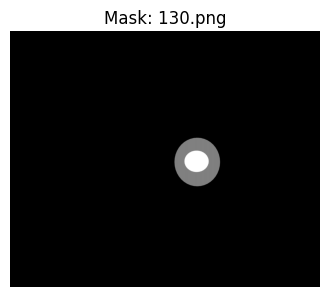

🖼️ 131.png - Unique values: {np.uint8(0), np.uint8(1), np.uint8(2)}


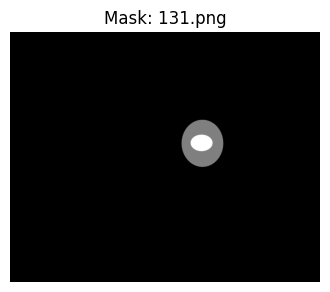

🖼️ 132.png - Unique values: {np.uint8(0), np.uint8(1), np.uint8(2)}


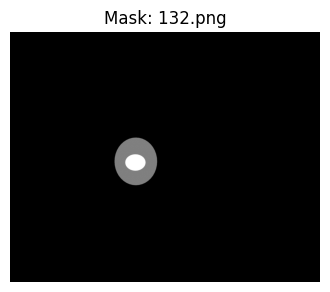

🖼️ 133.png - Unique values: {np.uint8(0), np.uint8(1), np.uint8(2)}


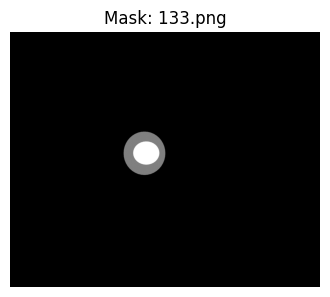

🖼️ 134.png - Unique values: {np.uint8(0), np.uint8(1), np.uint8(2)}


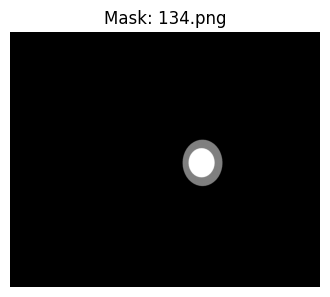

🖼️ 135.png - Unique values: {np.uint8(0), np.uint8(1), np.uint8(2)}


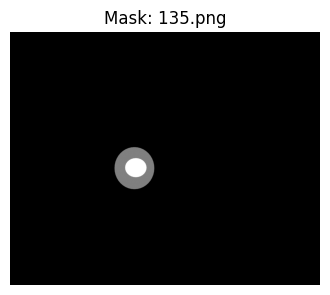

🖼️ 136.png - Unique values: {np.uint8(0), np.uint8(1), np.uint8(2)}


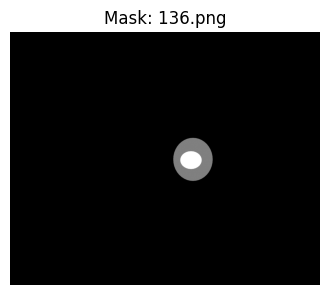

🖼️ 137.png - Unique values: {np.uint8(0), np.uint8(1), np.uint8(2)}


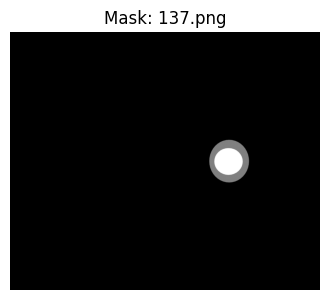

🖼️ 138.png - Unique values: {np.uint8(0), np.uint8(1), np.uint8(2)}


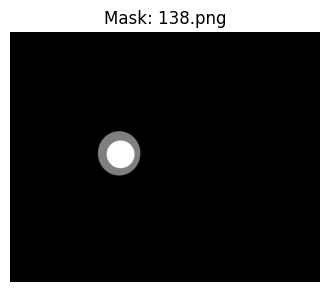

🖼️ 139.png - Unique values: {np.uint8(0), np.uint8(1), np.uint8(2)}


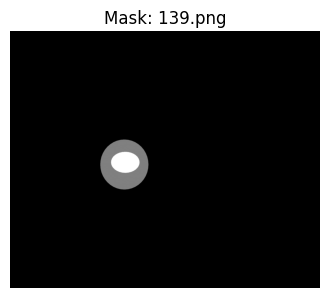

🖼️ 140.png - Unique values: {np.uint8(0), np.uint8(1), np.uint8(2)}


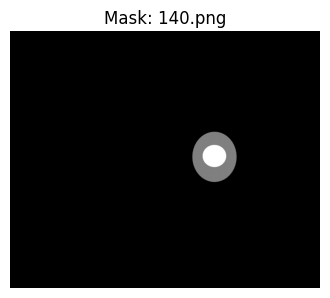

🖼️ 141.png - Unique values: {np.uint8(0), np.uint8(1), np.uint8(2)}


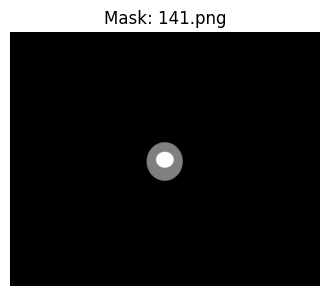

🖼️ 142.png - Unique values: {np.uint8(0), np.uint8(1), np.uint8(2)}


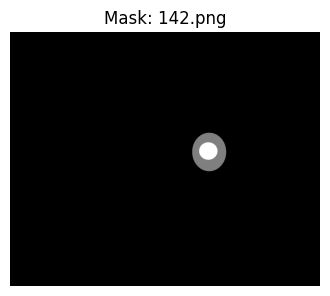

🖼️ 143.png - Unique values: {np.uint8(0), np.uint8(1), np.uint8(2)}


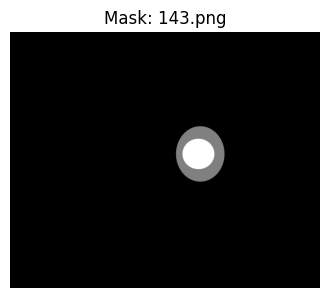

🖼️ 144.png - Unique values: {np.uint8(0), np.uint8(1), np.uint8(2)}


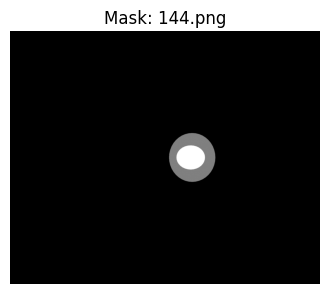

🖼️ 145.png - Unique values: {np.uint8(0), np.uint8(1), np.uint8(2)}


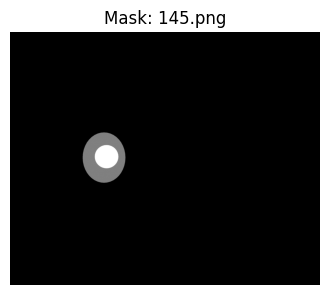

🖼️ 146.png - Unique values: {np.uint8(0), np.uint8(1), np.uint8(2)}


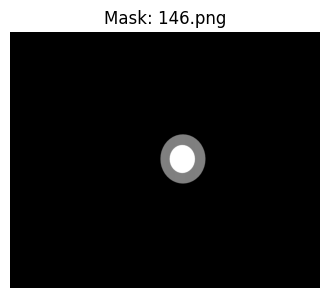

🖼️ 147.png - Unique values: {np.uint8(0), np.uint8(1), np.uint8(2)}


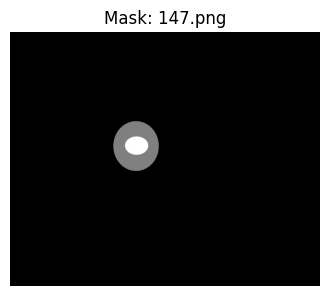

🖼️ 148.png - Unique values: {np.uint8(0), np.uint8(1), np.uint8(2)}


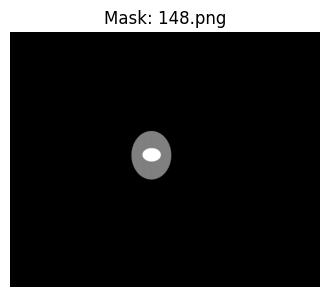

🖼️ 149.png - Unique values: {np.uint8(0), np.uint8(1), np.uint8(2)}


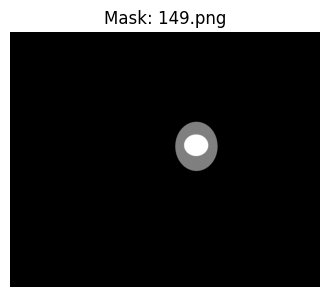

🖼️ 150.png - Unique values: {np.uint8(0), np.uint8(1), np.uint8(2)}


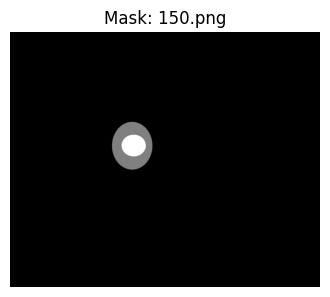

🖼️ 151.png - Unique values: {np.uint8(0), np.uint8(1), np.uint8(2)}


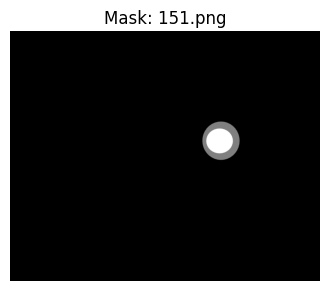

🖼️ 152.png - Unique values: {np.uint8(0), np.uint8(1), np.uint8(2)}


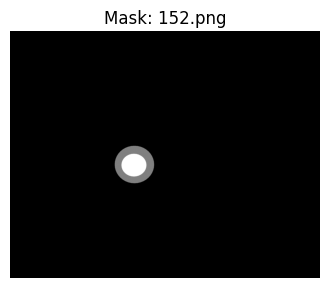

🖼️ 153.png - Unique values: {np.uint8(0), np.uint8(1), np.uint8(2)}


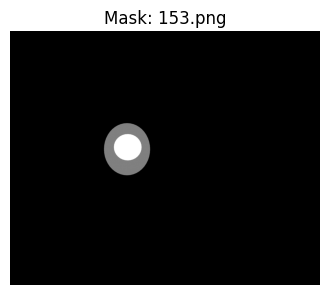

🖼️ 154.png - Unique values: {np.uint8(0), np.uint8(1), np.uint8(2)}


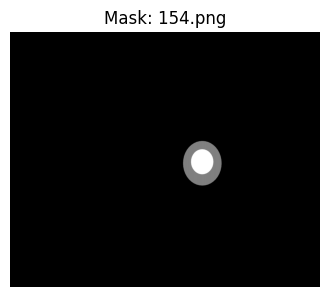

🖼️ 155.png - Unique values: {np.uint8(0), np.uint8(1), np.uint8(2)}


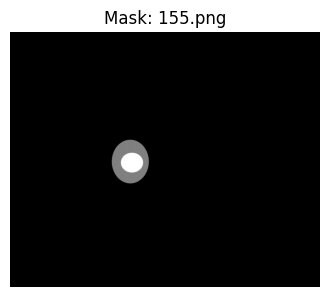

🖼️ 156.png - Unique values: {np.uint8(0), np.uint8(1), np.uint8(2)}


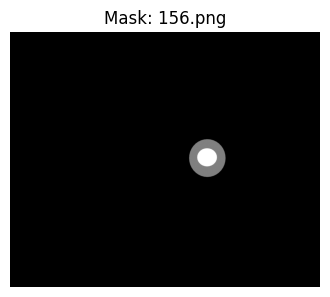

🖼️ 157.png - Unique values: {np.uint8(0), np.uint8(1), np.uint8(2)}


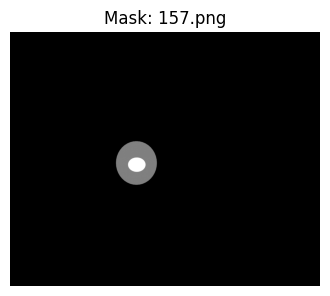

🖼️ 158.png - Unique values: {np.uint8(0), np.uint8(1), np.uint8(2)}


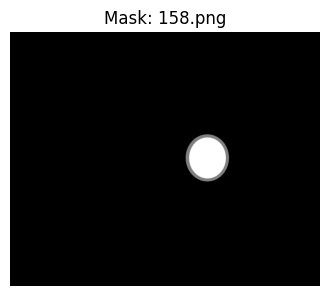

🖼️ 159.png - Unique values: {np.uint8(0), np.uint8(1), np.uint8(2)}


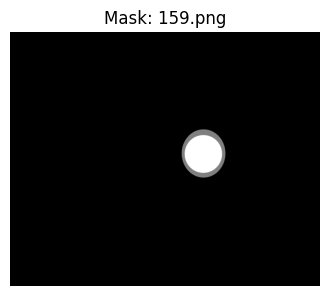

🖼️ 160.png - Unique values: {np.uint8(0), np.uint8(1), np.uint8(2)}


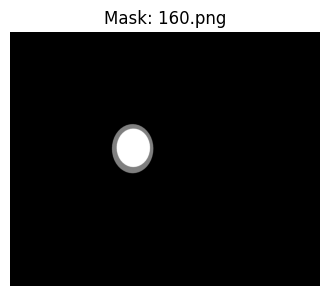

🖼️ 161.png - Unique values: {np.uint8(0), np.uint8(1), np.uint8(2)}


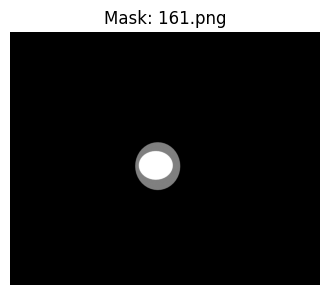

🖼️ 162.png - Unique values: {np.uint8(0), np.uint8(1), np.uint8(2)}


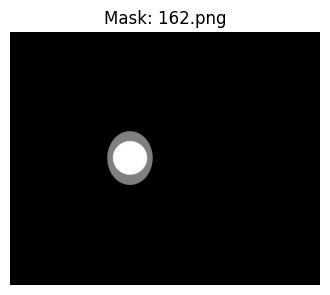

🖼️ 163.png - Unique values: {np.uint8(0), np.uint8(1), np.uint8(2)}


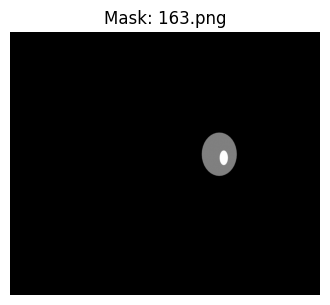

🖼️ 164.png - Unique values: {np.uint8(0), np.uint8(1), np.uint8(2)}


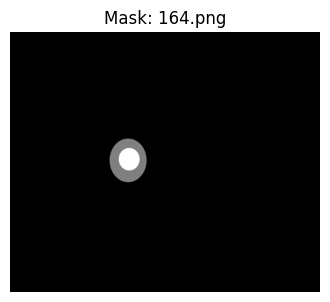

🖼️ 165.png - Unique values: {np.uint8(0), np.uint8(1), np.uint8(2)}


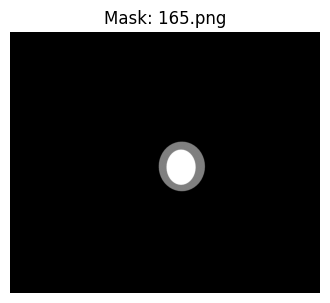

🖼️ 166.png - Unique values: {np.uint8(0), np.uint8(1), np.uint8(2)}


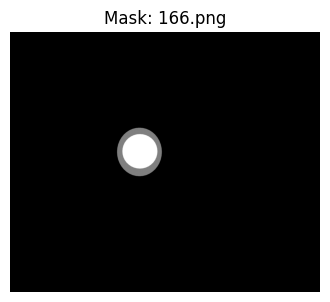

🖼️ 167.png - Unique values: {np.uint8(0), np.uint8(1), np.uint8(2)}


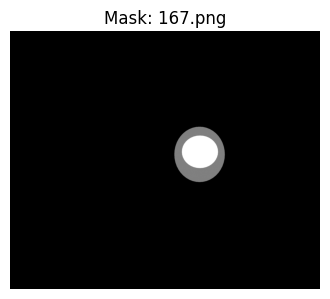

🖼️ 168.png - Unique values: {np.uint8(0), np.uint8(1), np.uint8(2)}


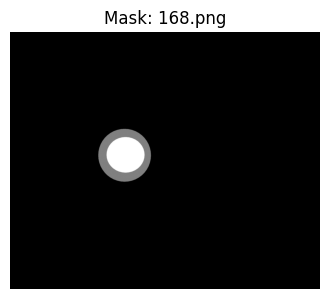

🖼️ 169.png - Unique values: {np.uint8(0), np.uint8(1), np.uint8(2)}


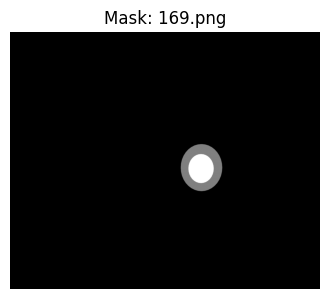

🖼️ 170.png - Unique values: {np.uint8(0), np.uint8(1), np.uint8(2)}


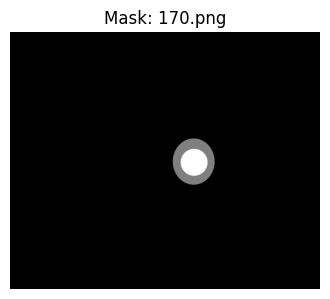

🖼️ 171.png - Unique values: {np.uint8(0), np.uint8(1), np.uint8(2)}


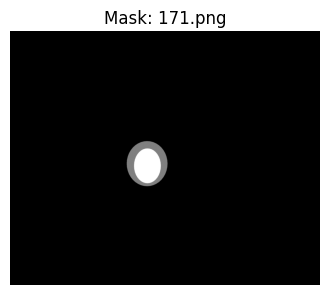

🖼️ 172.png - Unique values: {np.uint8(0), np.uint8(1), np.uint8(2)}


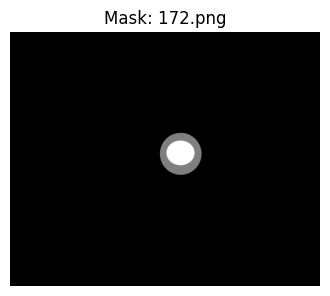

🖼️ 173.png - Unique values: {np.uint8(0), np.uint8(1), np.uint8(2)}


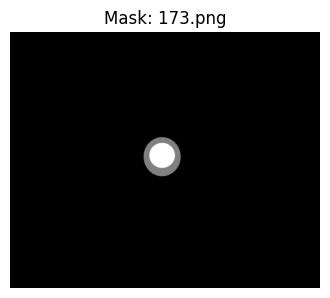

🖼️ 174.png - Unique values: {np.uint8(0), np.uint8(1), np.uint8(2)}


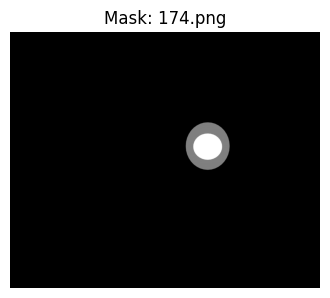

🖼️ 175.png - Unique values: {np.uint8(0), np.uint8(1), np.uint8(2)}


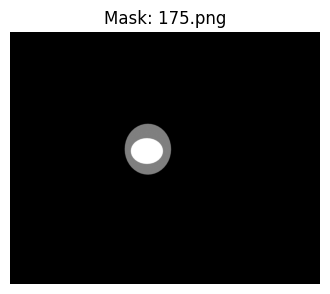

🖼️ 176.png - Unique values: {np.uint8(0), np.uint8(1), np.uint8(2)}


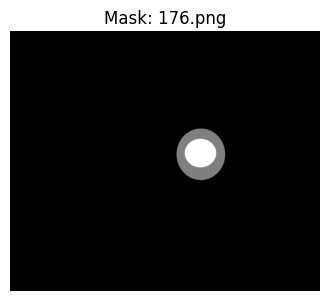

🖼️ 177.png - Unique values: {np.uint8(0), np.uint8(1), np.uint8(2)}


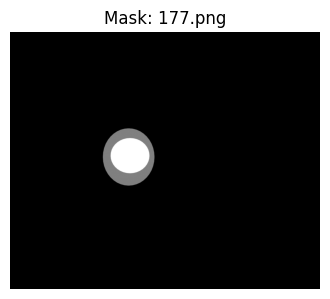

🖼️ 178.png - Unique values: {np.uint8(0), np.uint8(1), np.uint8(2)}


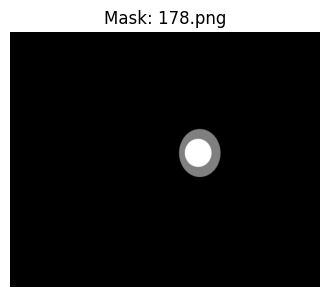

🖼️ 179.png - Unique values: {np.uint8(0), np.uint8(1), np.uint8(2)}


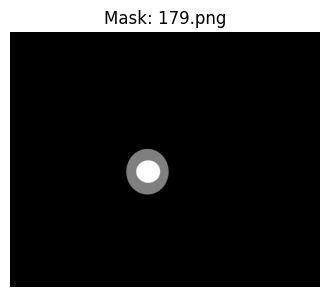

🖼️ 180.png - Unique values: {np.uint8(0), np.uint8(1), np.uint8(2)}


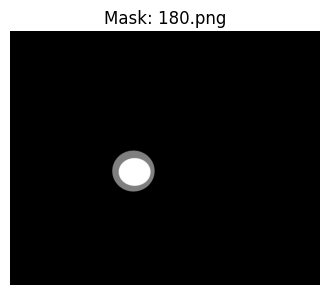

🖼️ 181.png - Unique values: {np.uint8(0), np.uint8(1), np.uint8(2)}


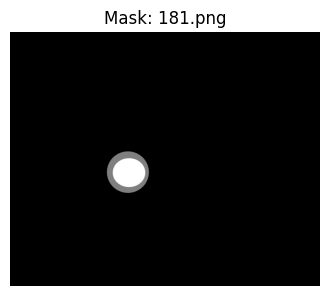

🖼️ 182.png - Unique values: {np.uint8(0), np.uint8(1), np.uint8(2)}


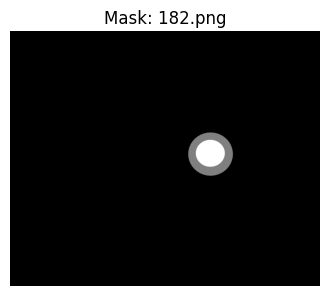

🖼️ 183.png - Unique values: {np.uint8(0), np.uint8(1), np.uint8(2)}


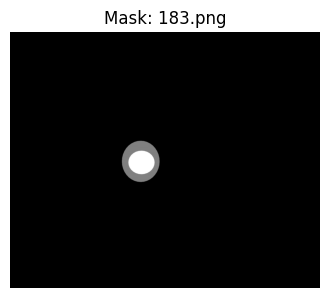

🖼️ 184.png - Unique values: {np.uint8(0), np.uint8(1), np.uint8(2)}


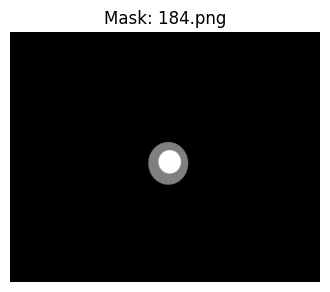

🖼️ 185.png - Unique values: {np.uint8(0), np.uint8(1), np.uint8(2)}


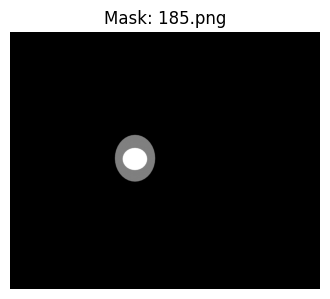

🖼️ 186.png - Unique values: {np.uint8(0), np.uint8(1), np.uint8(2)}


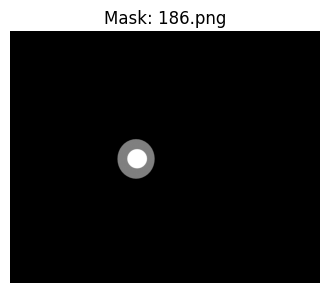

🖼️ 187.png - Unique values: {np.uint8(0), np.uint8(1), np.uint8(2)}


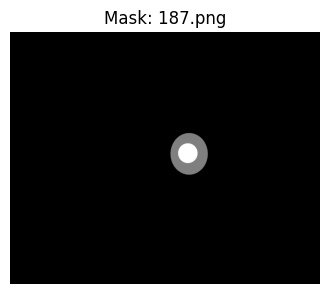

🖼️ 188.png - Unique values: {np.uint8(0), np.uint8(1), np.uint8(2)}


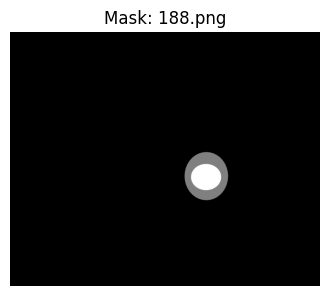

🖼️ 189.png - Unique values: {np.uint8(0), np.uint8(1), np.uint8(2)}


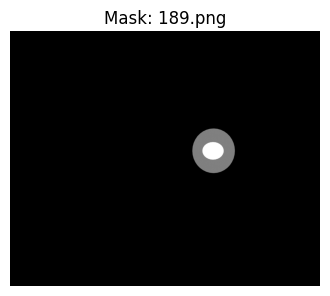

🖼️ 190.png - Unique values: {np.uint8(0), np.uint8(1), np.uint8(2)}


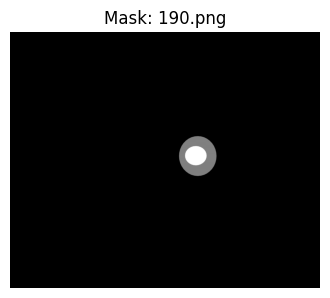

🖼️ 191.png - Unique values: {np.uint8(0), np.uint8(1), np.uint8(2)}


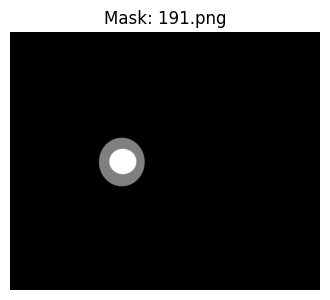

🖼️ 192.png - Unique values: {np.uint8(0), np.uint8(1), np.uint8(2)}


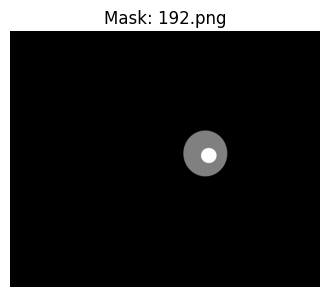

🖼️ 193.png - Unique values: {np.uint8(0), np.uint8(1), np.uint8(2)}


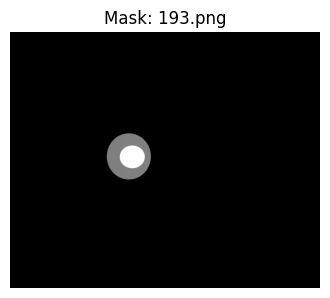

🖼️ 194.png - Unique values: {np.uint8(0), np.uint8(1), np.uint8(2)}


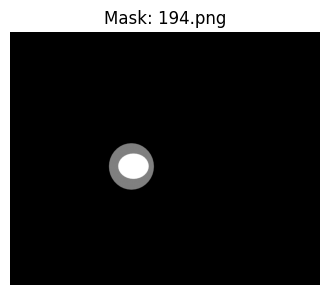

🖼️ 195.png - Unique values: {np.uint8(0), np.uint8(1), np.uint8(2)}


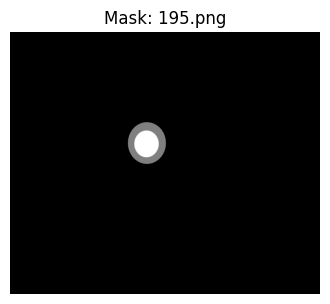

🖼️ 196.png - Unique values: {np.uint8(0), np.uint8(1), np.uint8(2)}


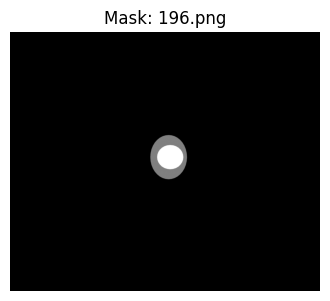

🖼️ 197.png - Unique values: {np.uint8(0), np.uint8(1), np.uint8(2)}


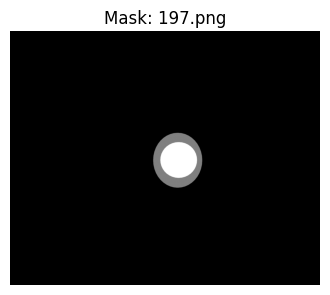

🖼️ 198.png - Unique values: {np.uint8(0), np.uint8(1), np.uint8(2)}


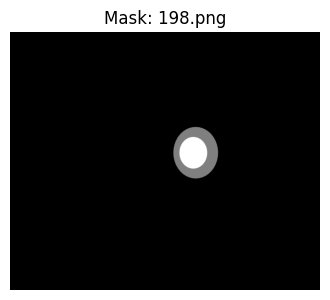

🖼️ 199.png - Unique values: {np.uint8(0), np.uint8(1), np.uint8(2)}


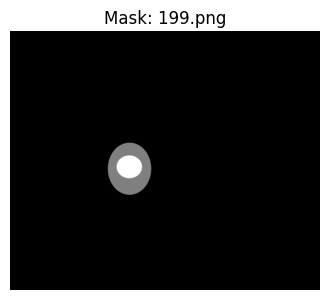

🖼️ 200.png - Unique values: {np.uint8(0), np.uint8(1), np.uint8(2)}


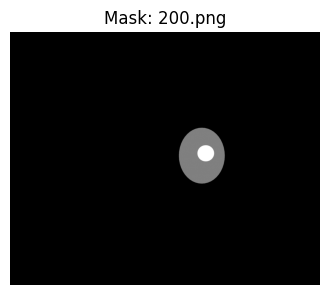

🖼️ 201.png - Unique values: {np.uint8(0), np.uint8(1), np.uint8(2)}


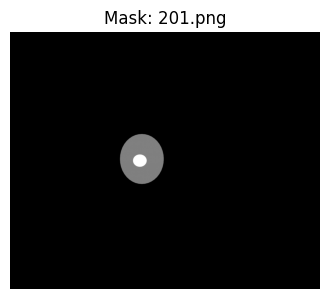

🖼️ 202.png - Unique values: {np.uint8(0), np.uint8(1), np.uint8(2)}


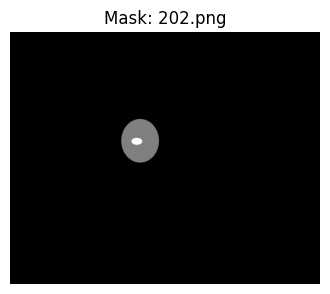

🖼️ 203.png - Unique values: {np.uint8(0), np.uint8(1), np.uint8(2)}


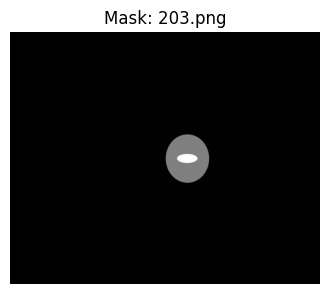

🖼️ 204.png - Unique values: {np.uint8(0), np.uint8(1), np.uint8(2)}


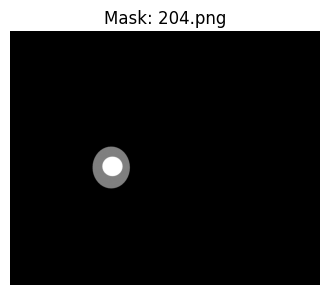

🖼️ 205.png - Unique values: {np.uint8(0), np.uint8(1), np.uint8(2)}


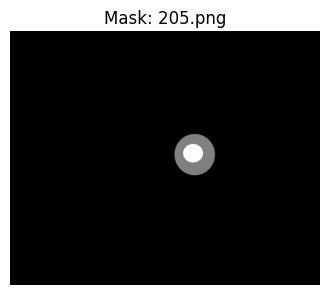

🖼️ 206.png - Unique values: {np.uint8(0), np.uint8(1), np.uint8(2)}


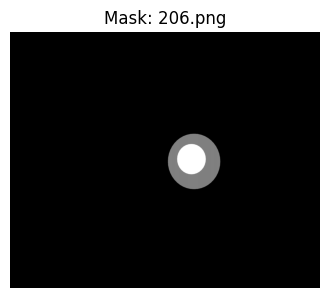

🖼️ 207.png - Unique values: {np.uint8(0), np.uint8(1), np.uint8(2)}


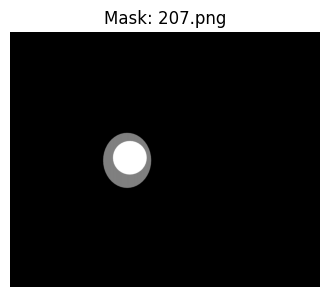

🖼️ 208.png - Unique values: {np.uint8(0), np.uint8(1), np.uint8(2)}


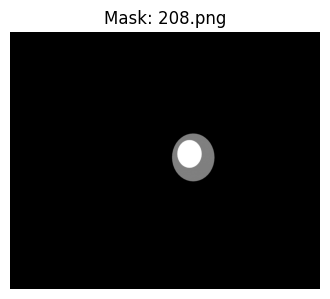

🖼️ 209.png - Unique values: {np.uint8(0), np.uint8(1), np.uint8(2)}


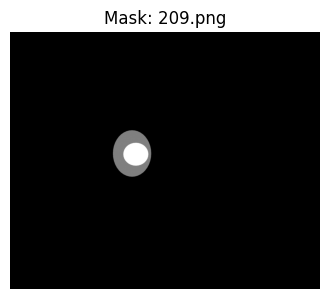

🖼️ 210.png - Unique values: {np.uint8(0), np.uint8(1), np.uint8(2)}


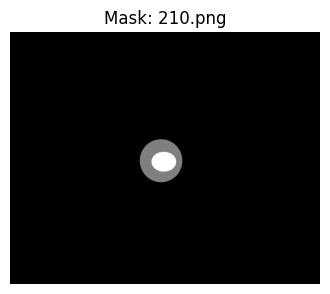

🖼️ 211.png - Unique values: {np.uint8(0), np.uint8(1), np.uint8(2)}


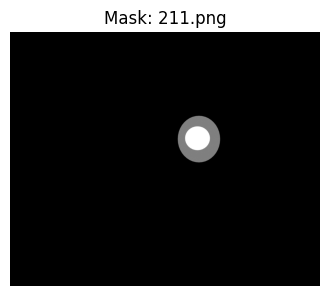

🖼️ 212.png - Unique values: {np.uint8(0), np.uint8(1), np.uint8(2)}


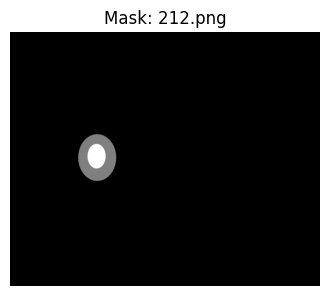

🖼️ 213.png - Unique values: {np.uint8(0), np.uint8(1), np.uint8(2)}


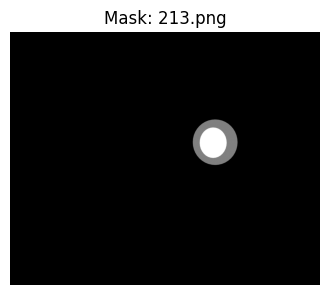

🖼️ 214.png - Unique values: {np.uint8(0), np.uint8(1), np.uint8(2)}


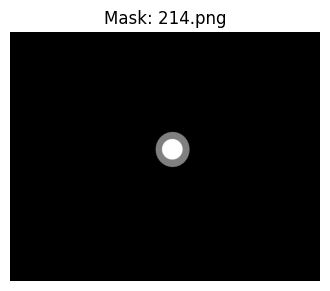

🖼️ 215.png - Unique values: {np.uint8(0), np.uint8(1), np.uint8(2)}


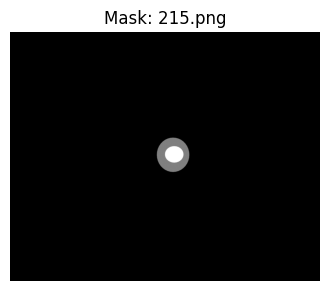

🖼️ 216.png - Unique values: {np.uint8(0), np.uint8(1), np.uint8(2)}


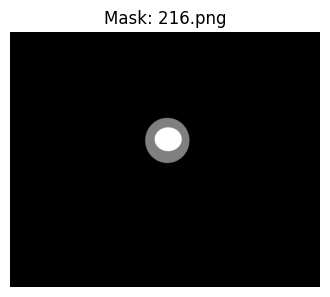

🖼️ 217.png - Unique values: {np.uint8(0), np.uint8(1), np.uint8(2)}


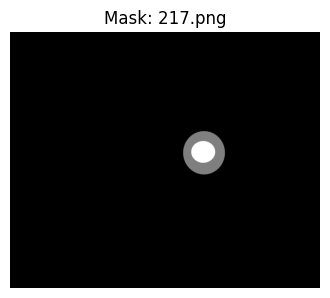

🖼️ 218.png - Unique values: {np.uint8(0), np.uint8(1), np.uint8(2)}


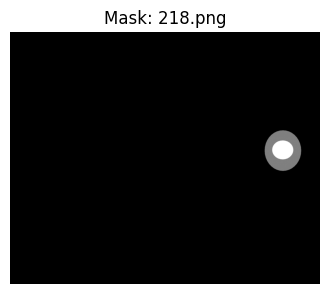

🖼️ 219.png - Unique values: {np.uint8(0), np.uint8(1), np.uint8(2)}


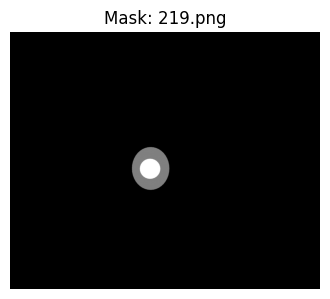

🖼️ 220.png - Unique values: {np.uint8(0), np.uint8(1), np.uint8(2)}


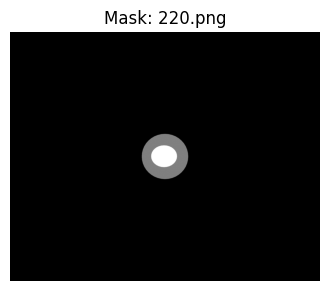

🖼️ 221.png - Unique values: {np.uint8(0), np.uint8(1), np.uint8(2)}


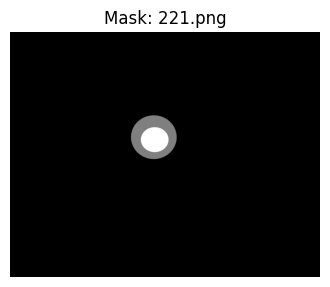

🖼️ 222.png - Unique values: {np.uint8(0), np.uint8(1), np.uint8(2)}


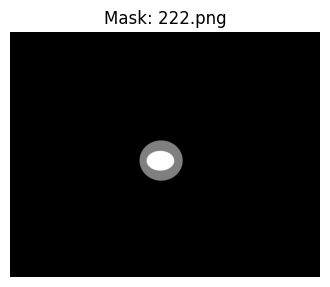

🖼️ 223.png - Unique values: {np.uint8(0), np.uint8(1), np.uint8(2)}


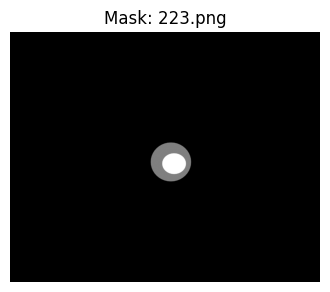

🖼️ 224.png - Unique values: {np.uint8(0), np.uint8(1), np.uint8(2)}


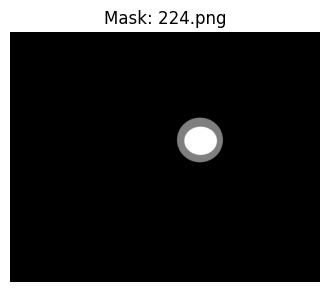

🖼️ 225.png - Unique values: {np.uint8(0), np.uint8(1), np.uint8(2)}


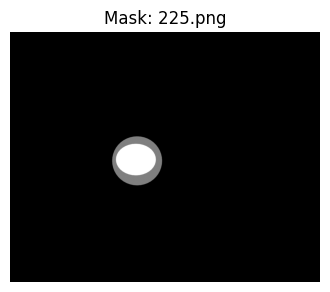

🖼️ 226.png - Unique values: {np.uint8(0), np.uint8(1), np.uint8(2)}


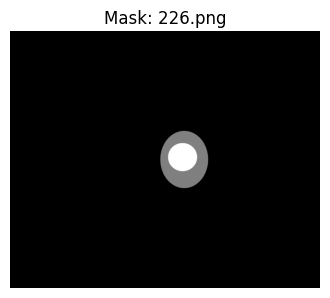

🖼️ 227.png - Unique values: {np.uint8(0), np.uint8(1), np.uint8(2)}


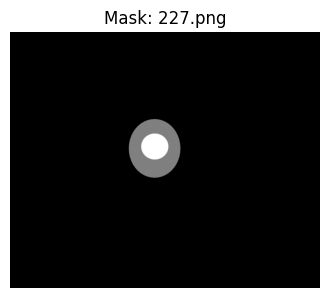

🖼️ 228.png - Unique values: {np.uint8(0), np.uint8(1), np.uint8(2)}


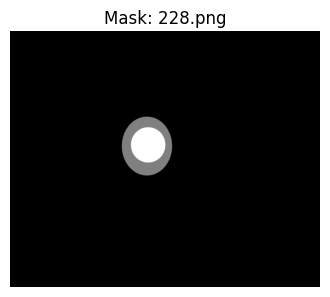

🖼️ 229.png - Unique values: {np.uint8(0), np.uint8(1), np.uint8(2)}


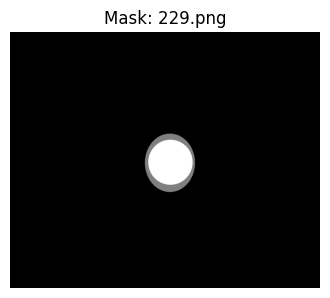

🖼️ 230.png - Unique values: {np.uint8(0), np.uint8(1), np.uint8(2)}


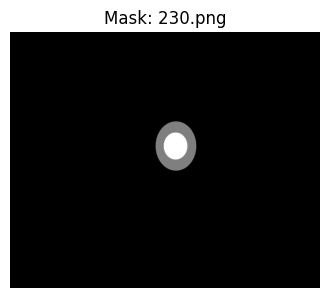

🖼️ 231.png - Unique values: {np.uint8(0), np.uint8(1), np.uint8(2)}


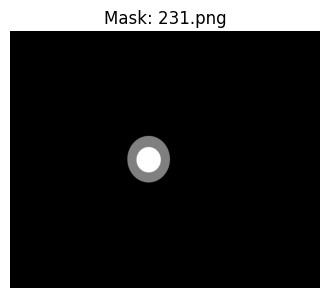

🖼️ 232.png - Unique values: {np.uint8(0), np.uint8(1), np.uint8(2)}


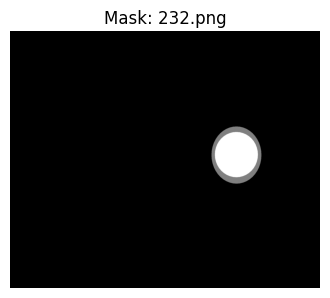

🖼️ 233.png - Unique values: {np.uint8(0), np.uint8(1), np.uint8(2)}


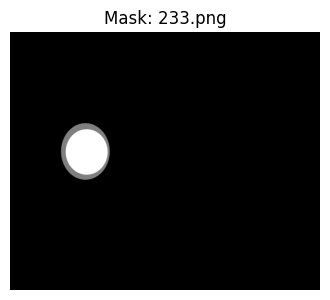

🖼️ 234.png - Unique values: {np.uint8(0), np.uint8(1), np.uint8(2)}


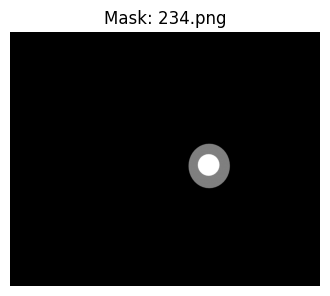

🖼️ 235.png - Unique values: {np.uint8(0), np.uint8(1), np.uint8(2)}


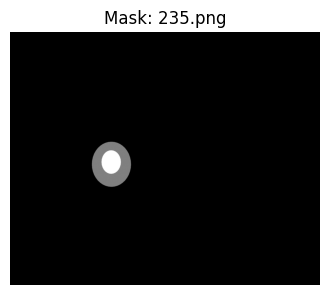

🖼️ 236.png - Unique values: {np.uint8(0), np.uint8(1), np.uint8(2)}


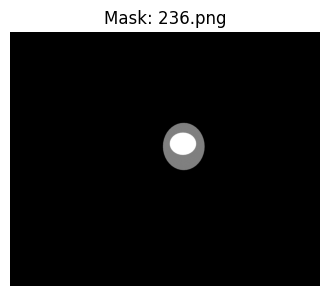

🖼️ 237.png - Unique values: {np.uint8(0), np.uint8(1), np.uint8(2)}


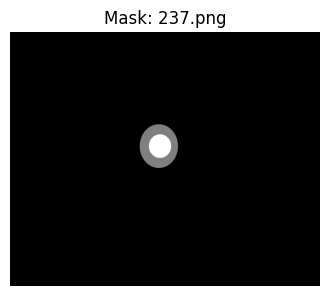

🖼️ 238.png - Unique values: {np.uint8(0), np.uint8(1), np.uint8(2)}


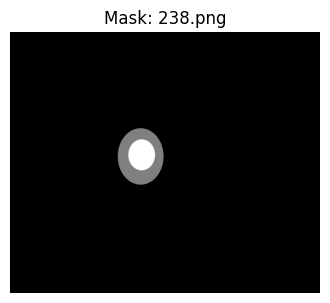

🖼️ 239.png - Unique values: {np.uint8(0), np.uint8(1), np.uint8(2)}


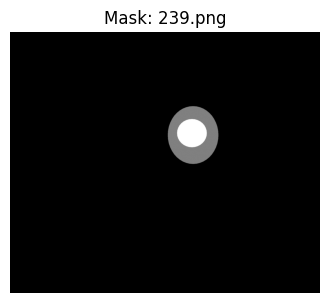

🖼️ 240.png - Unique values: {np.uint8(0), np.uint8(1), np.uint8(2)}


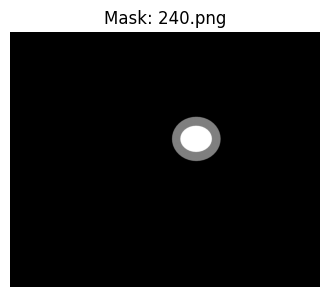

🖼️ 241.png - Unique values: {np.uint8(0), np.uint8(1), np.uint8(2)}


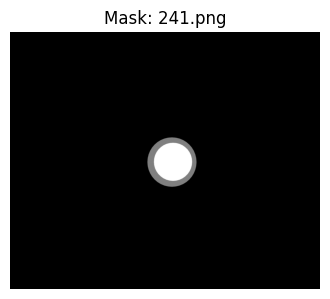

🖼️ 242.png - Unique values: {np.uint8(0), np.uint8(1), np.uint8(2)}


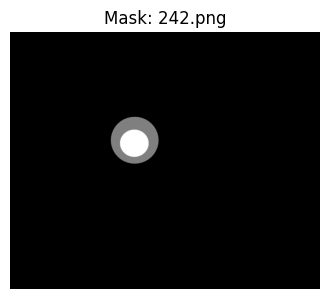

🖼️ 243.png - Unique values: {np.uint8(0), np.uint8(1), np.uint8(2)}


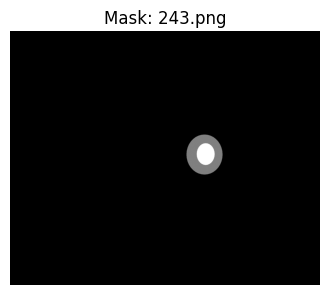

🖼️ 244.png - Unique values: {np.uint8(0), np.uint8(1), np.uint8(2)}


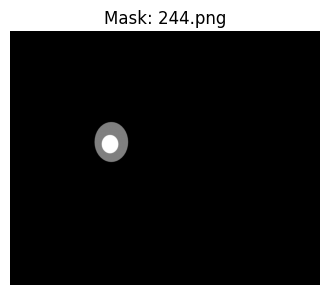

🖼️ 245.png - Unique values: {np.uint8(0), np.uint8(1), np.uint8(2)}


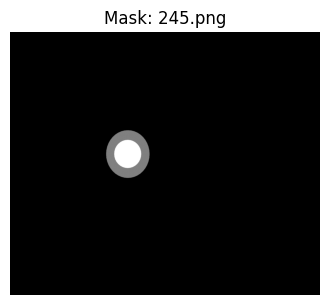

🖼️ 246.png - Unique values: {np.uint8(0), np.uint8(1), np.uint8(2)}


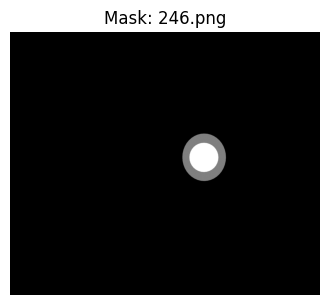

🖼️ 247.png - Unique values: {np.uint8(0), np.uint8(1), np.uint8(2)}


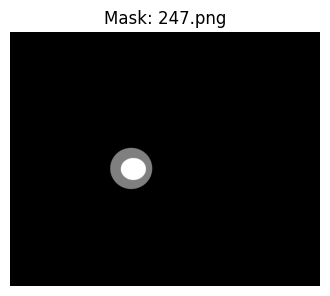

🖼️ 248.png - Unique values: {np.uint8(0), np.uint8(1), np.uint8(2)}


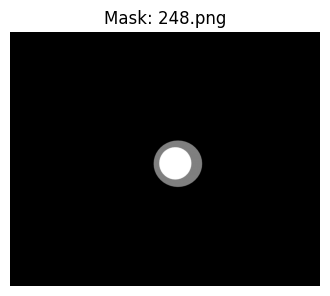

🖼️ 249.png - Unique values: {np.uint8(0), np.uint8(1), np.uint8(2)}


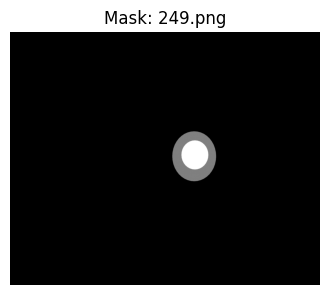

🖼️ 250.png - Unique values: {np.uint8(0), np.uint8(1), np.uint8(2)}


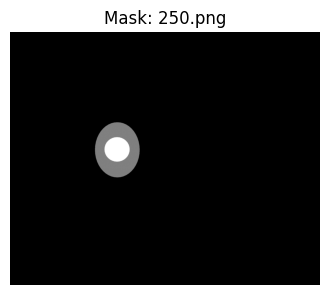

🖼️ 251.png - Unique values: {np.uint8(0), np.uint8(1), np.uint8(2)}


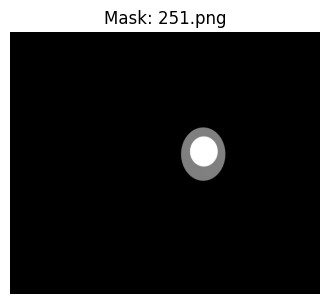

🖼️ 252.png - Unique values: {np.uint8(0), np.uint8(1), np.uint8(2)}


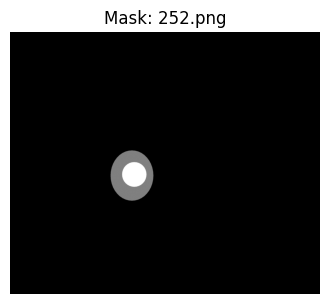

🖼️ 253.png - Unique values: {np.uint8(0), np.uint8(1), np.uint8(2)}


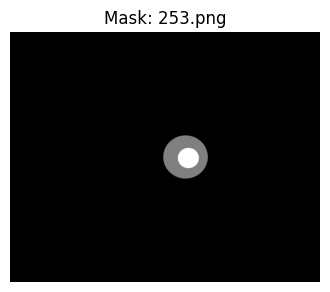

🖼️ 254.png - Unique values: {np.uint8(0), np.uint8(1), np.uint8(2)}


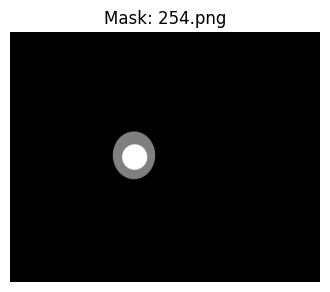

🖼️ 255.png - Unique values: {np.uint8(0), np.uint8(1), np.uint8(2)}


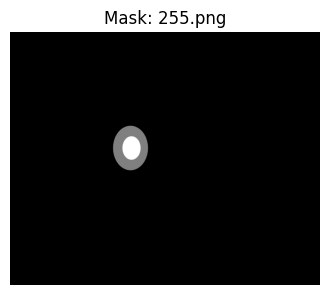

🖼️ 256.png - Unique values: {np.uint8(0), np.uint8(1), np.uint8(2)}


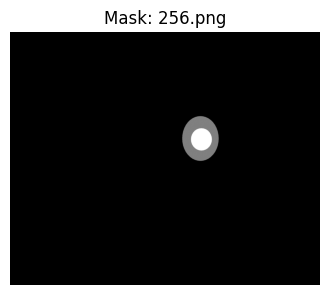

🖼️ 257.png - Unique values: {np.uint8(0), np.uint8(1), np.uint8(2)}


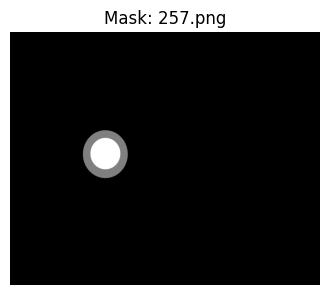

🖼️ 258.png - Unique values: {np.uint8(0), np.uint8(1), np.uint8(2)}


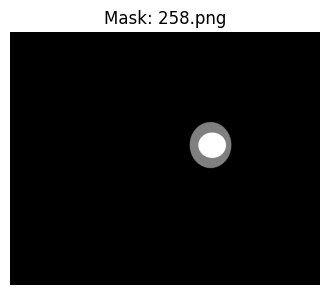

🖼️ 259.png - Unique values: {np.uint8(0), np.uint8(1), np.uint8(2)}


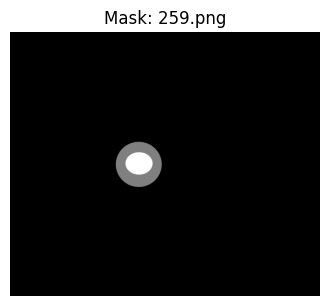

🖼️ 260.png - Unique values: {np.uint8(0), np.uint8(1), np.uint8(2)}


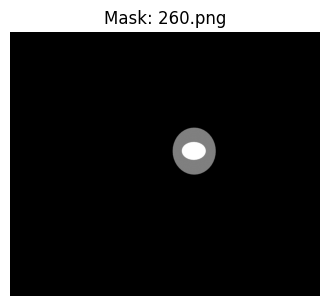

🖼️ 261.png - Unique values: {np.uint8(0), np.uint8(1), np.uint8(2)}


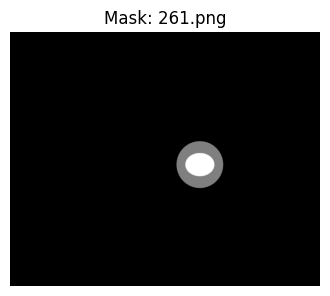

🖼️ 262.png - Unique values: {np.uint8(0), np.uint8(1), np.uint8(2)}


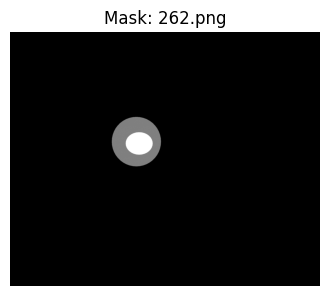

🖼️ 263.png - Unique values: {np.uint8(0), np.uint8(1), np.uint8(2)}


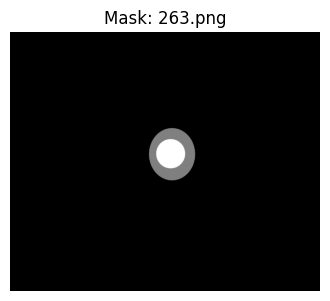

🖼️ 264.png - Unique values: {np.uint8(0), np.uint8(1), np.uint8(2)}


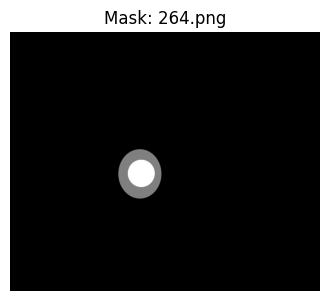

🖼️ 265.png - Unique values: {np.uint8(0), np.uint8(1), np.uint8(2)}


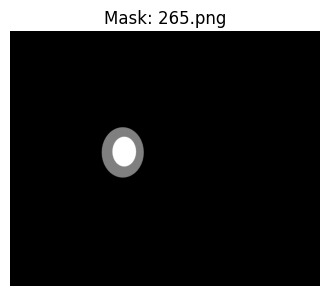

🖼️ 266.png - Unique values: {np.uint8(0), np.uint8(1), np.uint8(2)}


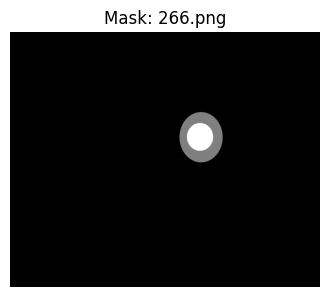

🖼️ 267.png - Unique values: {np.uint8(0), np.uint8(1), np.uint8(2)}


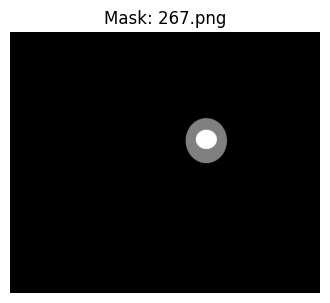

🖼️ 268.png - Unique values: {np.uint8(0), np.uint8(1), np.uint8(2)}


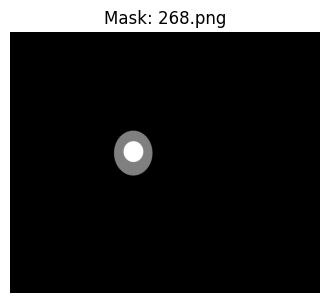

🖼️ 269.png - Unique values: {np.uint8(0), np.uint8(1), np.uint8(2)}


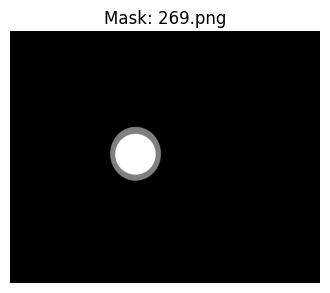

🖼️ 270.png - Unique values: {np.uint8(0), np.uint8(1), np.uint8(2)}


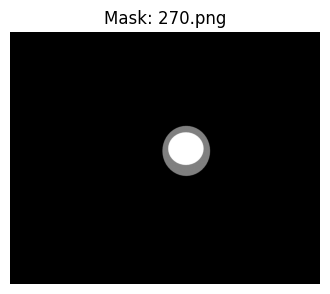

🖼️ 271.png - Unique values: {np.uint8(0), np.uint8(1), np.uint8(2)}


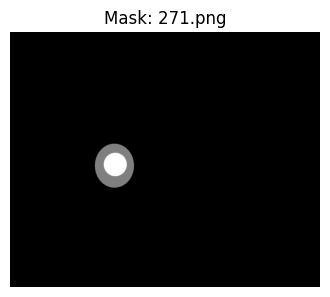

🖼️ 272.png - Unique values: {np.uint8(0), np.uint8(1), np.uint8(2)}


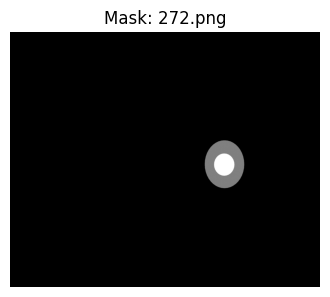

🖼️ 273.png - Unique values: {np.uint8(0), np.uint8(1), np.uint8(2)}


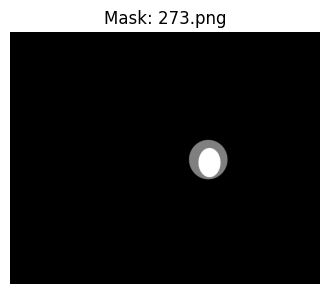

🖼️ 274.png - Unique values: {np.uint8(0), np.uint8(1), np.uint8(2)}


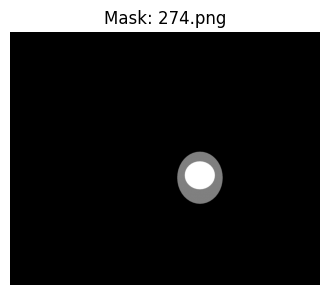

🖼️ 275.png - Unique values: {np.uint8(0), np.uint8(1), np.uint8(2)}


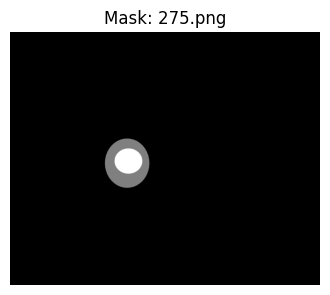

🖼️ 276.png - Unique values: {np.uint8(0), np.uint8(1), np.uint8(2)}


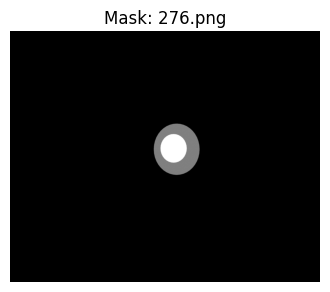

🖼️ 277.png - Unique values: {np.uint8(0), np.uint8(1), np.uint8(2)}


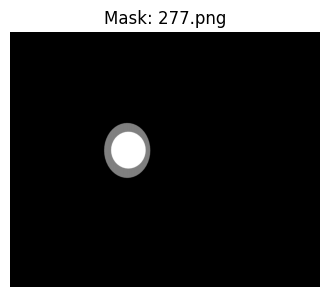

🖼️ 278.png - Unique values: {np.uint8(0), np.uint8(1), np.uint8(2)}


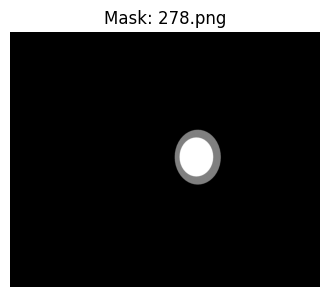

🖼️ 279.png - Unique values: {np.uint8(0), np.uint8(1), np.uint8(2)}


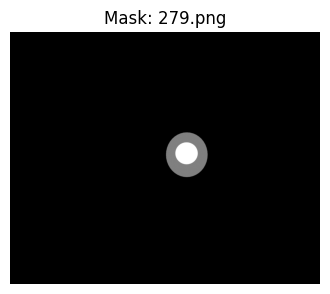

🖼️ 280.png - Unique values: {np.uint8(0), np.uint8(1), np.uint8(2)}


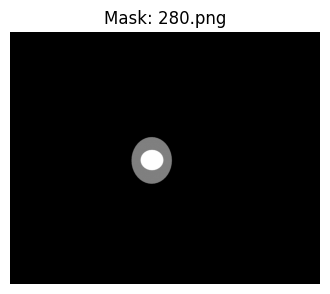

🖼️ 281.png - Unique values: {np.uint8(0), np.uint8(1), np.uint8(2)}


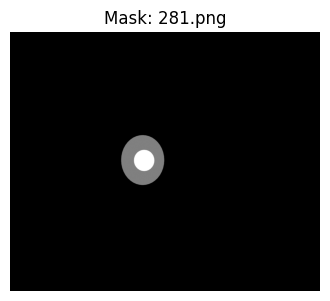

🖼️ 282.png - Unique values: {np.uint8(0), np.uint8(1), np.uint8(2)}


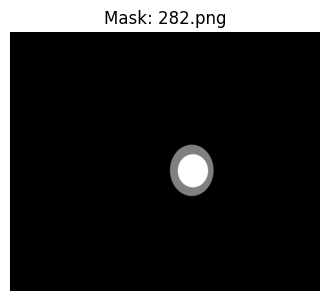

🖼️ 283.png - Unique values: {np.uint8(0), np.uint8(1), np.uint8(2)}


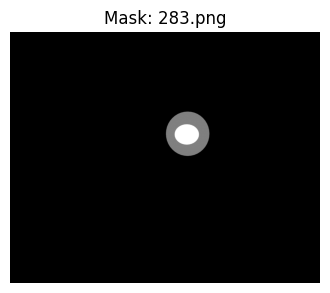

🖼️ 284.png - Unique values: {np.uint8(0), np.uint8(1), np.uint8(2)}


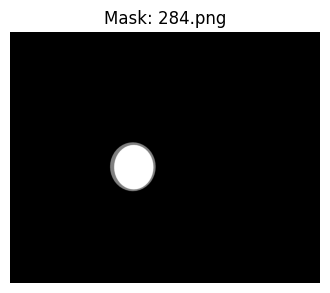

🖼️ 285.png - Unique values: {np.uint8(0), np.uint8(1), np.uint8(2)}


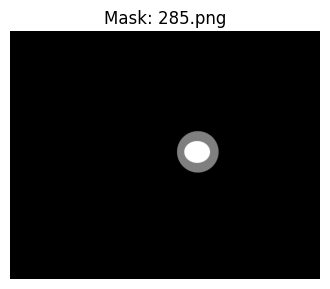

🖼️ 286.png - Unique values: {np.uint8(0), np.uint8(1), np.uint8(2)}


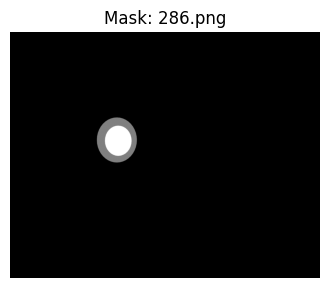

🖼️ 287.png - Unique values: {np.uint8(0), np.uint8(1), np.uint8(2)}


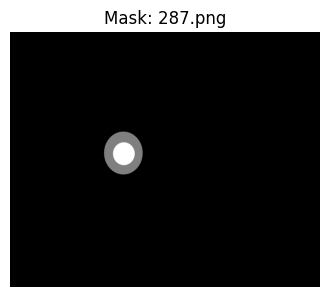

🖼️ 288.png - Unique values: {np.uint8(0), np.uint8(1), np.uint8(2)}


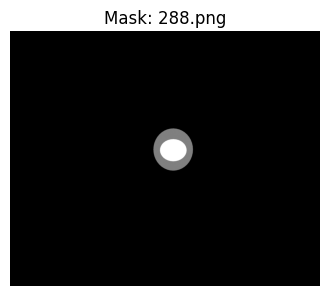

🖼️ 289.png - Unique values: {np.uint8(0), np.uint8(1), np.uint8(2)}


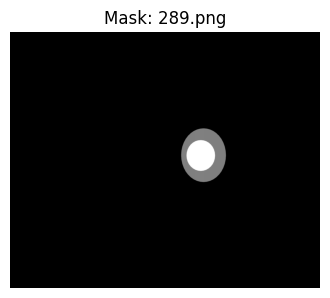

🖼️ 290.png - Unique values: {np.uint8(0), np.uint8(1), np.uint8(2)}


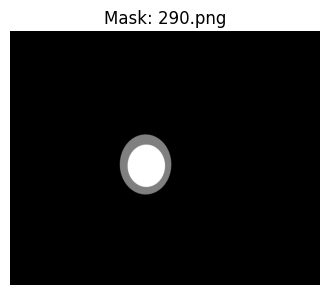

🖼️ 291.png - Unique values: {np.uint8(0), np.uint8(1), np.uint8(2)}


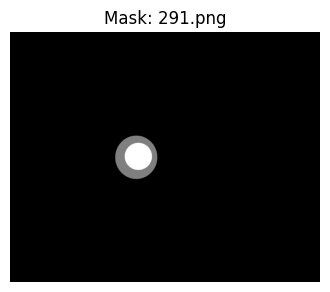

🖼️ 292.png - Unique values: {np.uint8(0), np.uint8(1), np.uint8(2)}


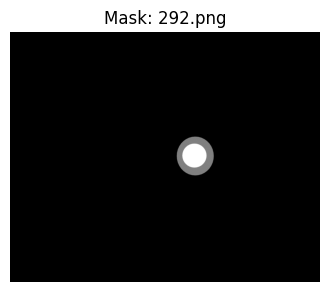

🖼️ 293.png - Unique values: {np.uint8(0), np.uint8(1), np.uint8(2)}


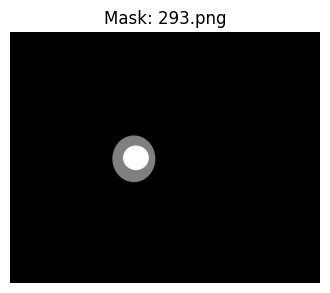

🖼️ 294.png - Unique values: {np.uint8(0), np.uint8(1), np.uint8(2)}


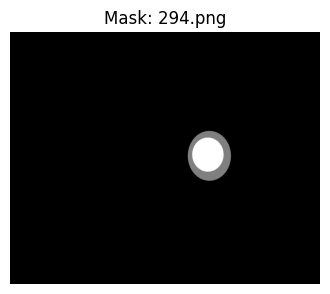

🖼️ 295.png - Unique values: {np.uint8(0), np.uint8(1), np.uint8(2)}


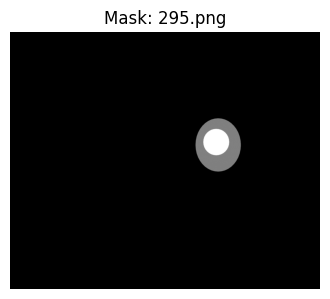

🖼️ 296.png - Unique values: {np.uint8(0), np.uint8(1), np.uint8(2)}


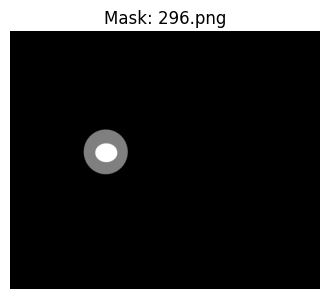

🖼️ 297.png - Unique values: {np.uint8(0), np.uint8(1), np.uint8(2)}


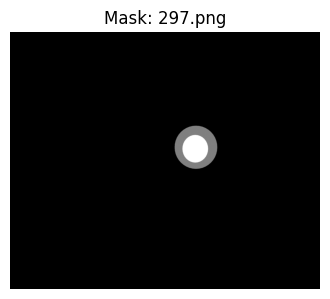

🖼️ 298.png - Unique values: {np.uint8(0), np.uint8(1), np.uint8(2)}


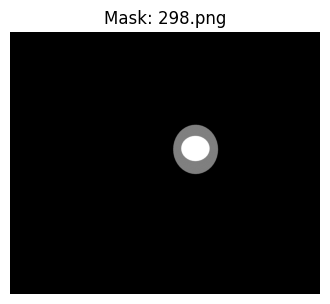

🖼️ 299.png - Unique values: {np.uint8(0), np.uint8(1), np.uint8(2)}


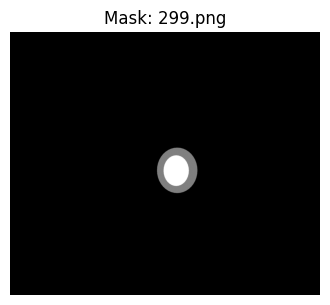

🖼️ 300.png - Unique values: {np.uint8(0), np.uint8(1), np.uint8(2)}


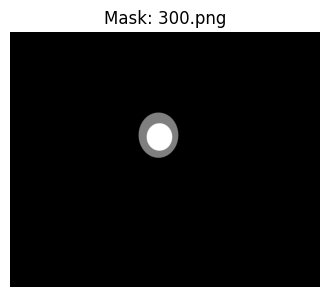

🖼️ 301.png - Unique values: {np.uint8(0), np.uint8(1), np.uint8(2)}


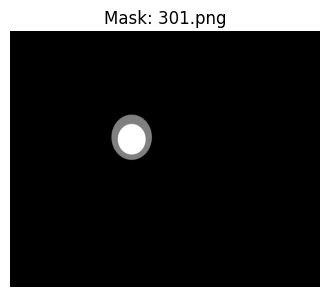

🖼️ 302.png - Unique values: {np.uint8(0), np.uint8(1), np.uint8(2)}


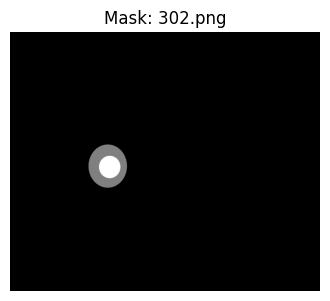

🖼️ 303.png - Unique values: {np.uint8(0), np.uint8(1), np.uint8(2)}


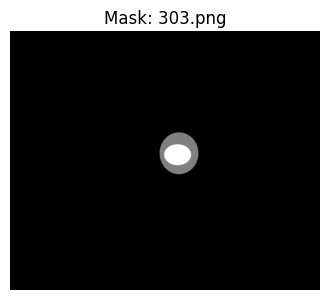

🖼️ 304.png - Unique values: {np.uint8(0), np.uint8(1), np.uint8(2)}


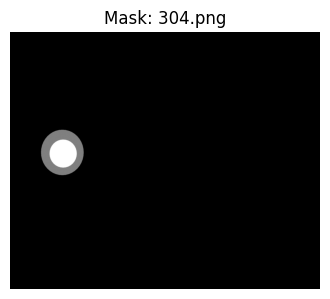

🖼️ 305.png - Unique values: {np.uint8(0), np.uint8(1), np.uint8(2)}


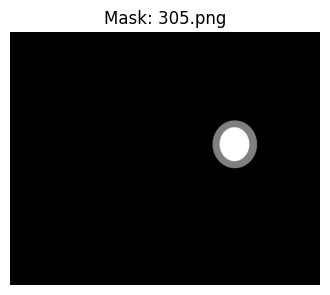

🖼️ 306.png - Unique values: {np.uint8(0), np.uint8(1), np.uint8(2)}


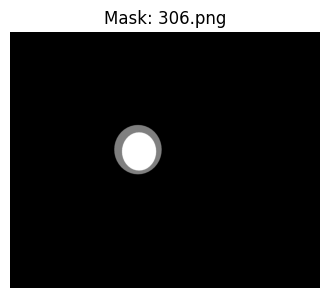

🖼️ 307.png - Unique values: {np.uint8(0), np.uint8(1), np.uint8(2)}


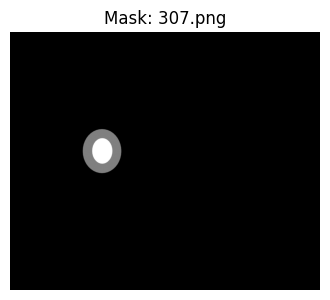

🖼️ 308.png - Unique values: {np.uint8(0), np.uint8(1), np.uint8(2)}


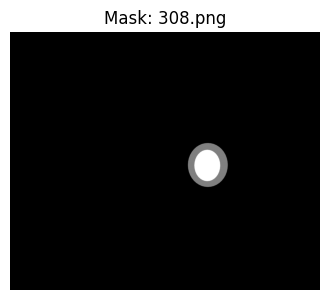

🖼️ 309.png - Unique values: {np.uint8(0), np.uint8(1), np.uint8(2)}


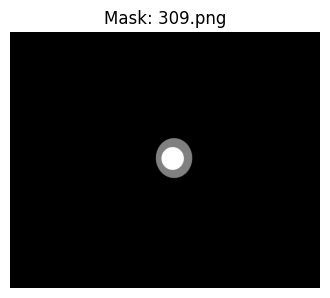

🖼️ 310.png - Unique values: {np.uint8(0), np.uint8(1), np.uint8(2)}


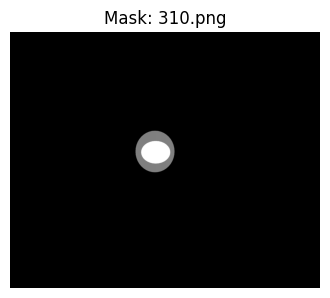

🖼️ 311.png - Unique values: {np.uint8(0), np.uint8(1), np.uint8(2)}


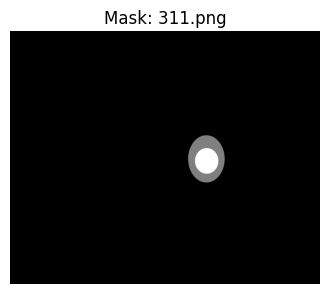

🖼️ 312.png - Unique values: {np.uint8(0), np.uint8(1), np.uint8(2)}


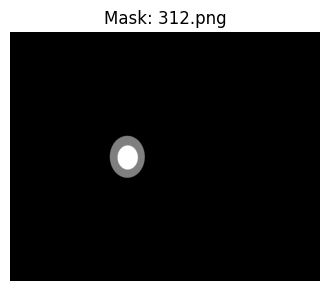

🖼️ 313.png - Unique values: {np.uint8(0), np.uint8(1), np.uint8(2)}


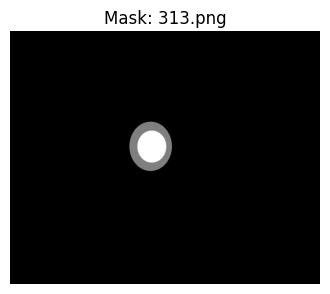

🖼️ 314.png - Unique values: {np.uint8(0), np.uint8(1), np.uint8(2)}


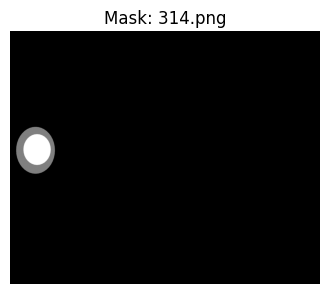

🖼️ 315.png - Unique values: {np.uint8(0), np.uint8(1), np.uint8(2)}


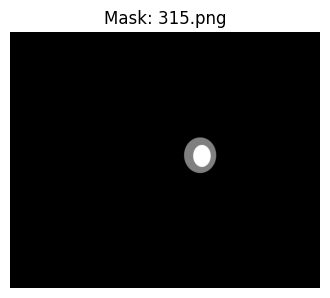

🖼️ 316.png - Unique values: {np.uint8(0), np.uint8(1), np.uint8(2)}


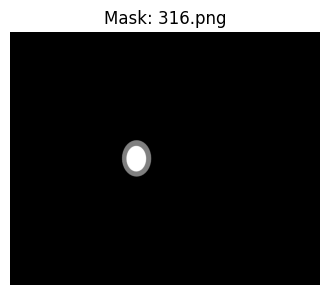

🖼️ 317.png - Unique values: {np.uint8(0), np.uint8(1), np.uint8(2)}


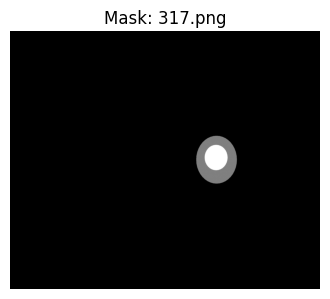

🖼️ 318.png - Unique values: {np.uint8(0), np.uint8(1), np.uint8(2)}


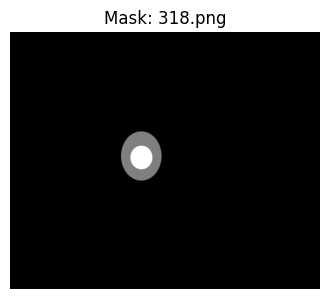

🖼️ 319.png - Unique values: {np.uint8(0), np.uint8(1), np.uint8(2)}


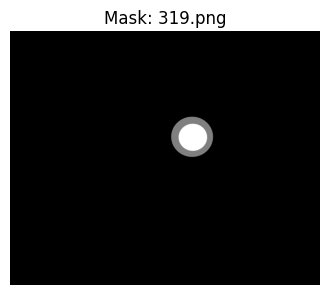

🖼️ 320.png - Unique values: {np.uint8(0), np.uint8(1), np.uint8(2)}


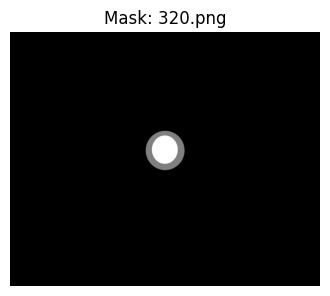

🖼️ 321.png - Unique values: {np.uint8(0), np.uint8(1), np.uint8(2)}


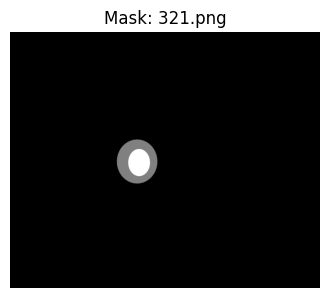

🖼️ 322.png - Unique values: {np.uint8(0), np.uint8(1), np.uint8(2)}


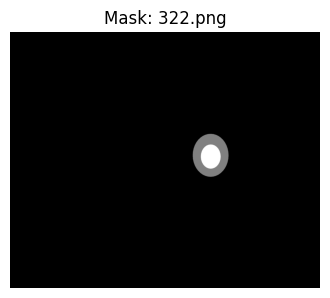

🖼️ 323.png - Unique values: {np.uint8(0), np.uint8(1), np.uint8(2)}


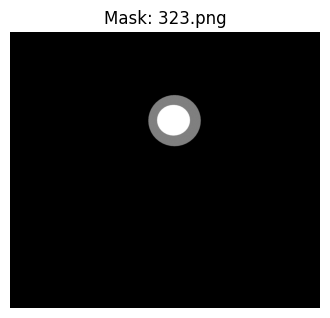

🖼️ 324.png - Unique values: {np.uint8(0), np.uint8(1), np.uint8(2)}


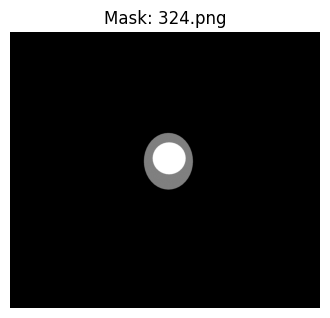

🖼️ 325.png - Unique values: {np.uint8(0), np.uint8(1), np.uint8(2)}


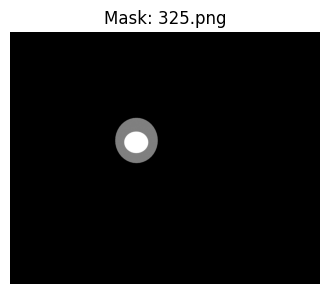

🖼️ 326.png - Unique values: {np.uint8(0), np.uint8(1), np.uint8(2)}


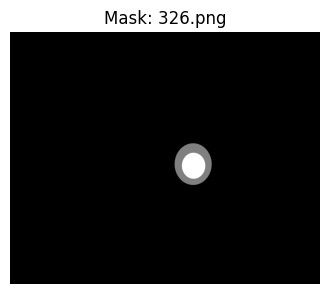

🖼️ 327.png - Unique values: {np.uint8(0), np.uint8(1), np.uint8(2)}


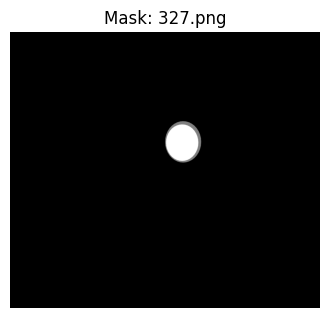

🖼️ 328.png - Unique values: {np.uint8(0), np.uint8(1), np.uint8(2)}


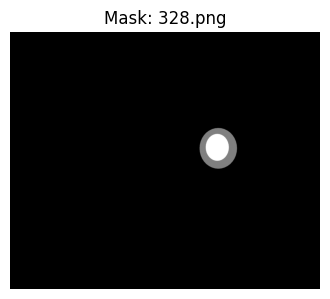

🖼️ 329.png - Unique values: {np.uint8(0), np.uint8(1), np.uint8(2)}


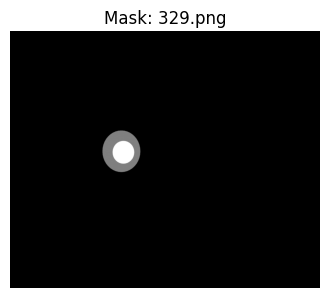

🖼️ 330.png - Unique values: {np.uint8(0), np.uint8(1), np.uint8(2)}


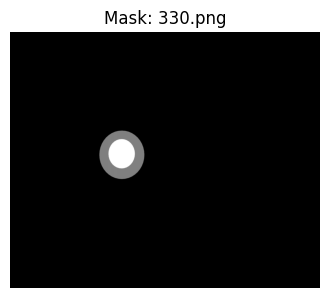

🖼️ 331.png - Unique values: {np.uint8(0), np.uint8(1), np.uint8(2)}


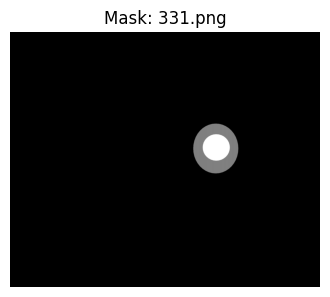

🖼️ 332.png - Unique values: {np.uint8(0), np.uint8(1), np.uint8(2)}


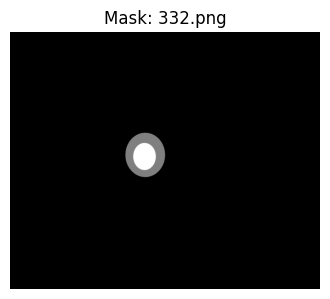

🖼️ 333.png - Unique values: {np.uint8(0), np.uint8(1), np.uint8(2)}


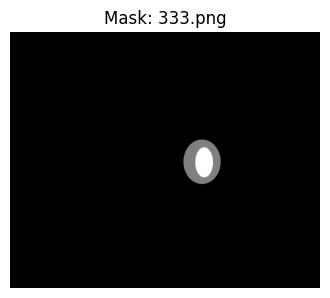

🖼️ 334.png - Unique values: {np.uint8(0), np.uint8(1), np.uint8(2)}


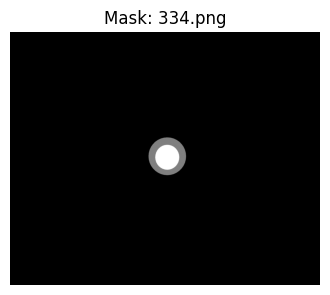

🖼️ 335.png - Unique values: {np.uint8(0), np.uint8(1), np.uint8(2)}


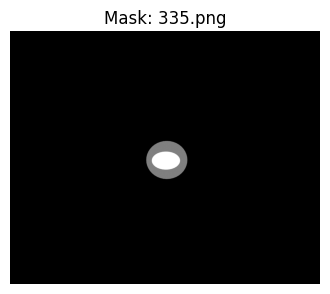

🖼️ 336.png - Unique values: {np.uint8(0), np.uint8(1), np.uint8(2)}


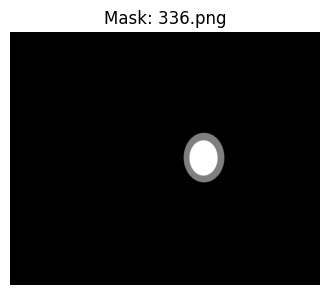

🖼️ 337.png - Unique values: {np.uint8(0), np.uint8(1), np.uint8(2)}


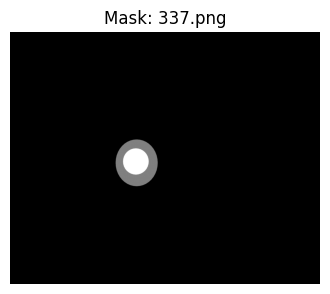

🖼️ 338.png - Unique values: {np.uint8(0), np.uint8(1), np.uint8(2)}


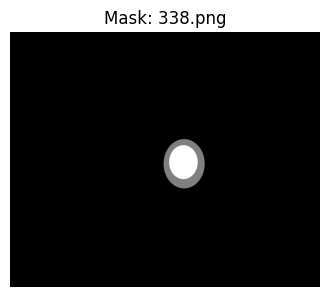

🖼️ 339.png - Unique values: {np.uint8(0), np.uint8(1), np.uint8(2)}


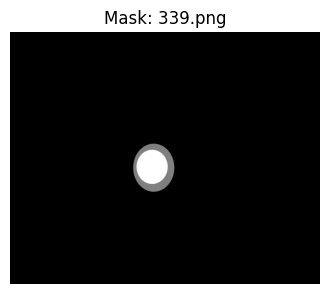

🖼️ 340.png - Unique values: {np.uint8(0), np.uint8(1), np.uint8(2)}


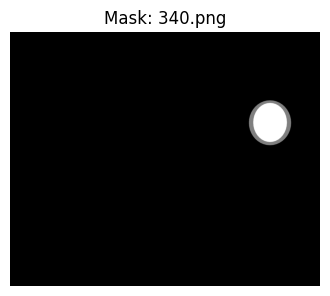

🖼️ 341.png - Unique values: {np.uint8(0), np.uint8(1), np.uint8(2)}


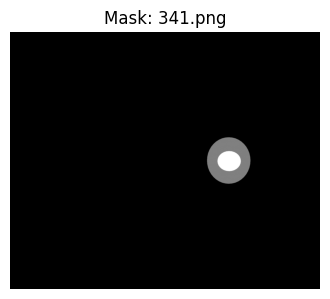

🖼️ 342.png - Unique values: {np.uint8(0), np.uint8(1), np.uint8(2)}


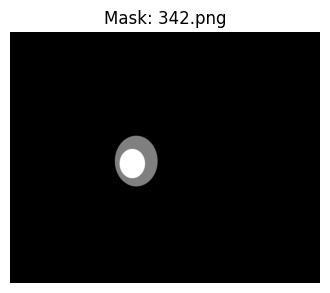

🖼️ 343.png - Unique values: {np.uint8(0), np.uint8(1), np.uint8(2)}


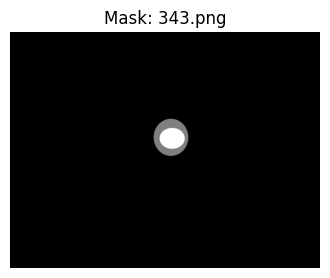

🖼️ 344.png - Unique values: {np.uint8(0), np.uint8(1), np.uint8(2)}


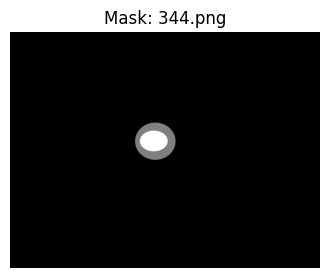

🖼️ 345.png - Unique values: {np.uint8(0), np.uint8(1), np.uint8(2)}


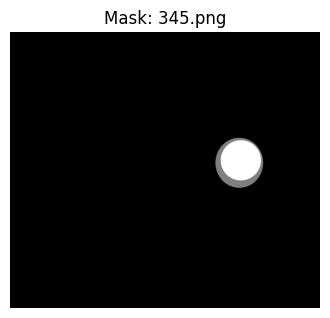

🖼️ 346.png - Unique values: {np.uint8(0), np.uint8(1), np.uint8(2)}


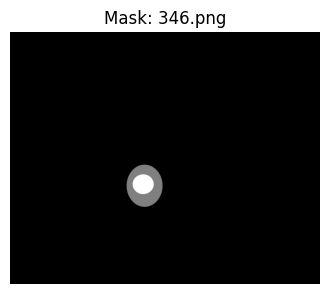

🖼️ 347.png - Unique values: {np.uint8(0), np.uint8(1), np.uint8(2)}


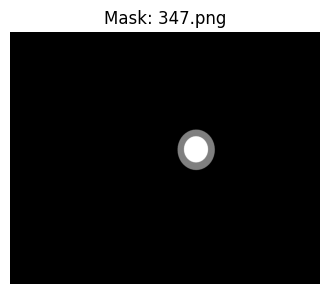

🖼️ 348.png - Unique values: {np.uint8(0), np.uint8(1), np.uint8(2)}


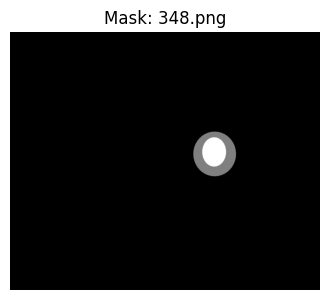

🖼️ 349.png - Unique values: {np.uint8(0), np.uint8(1), np.uint8(2)}


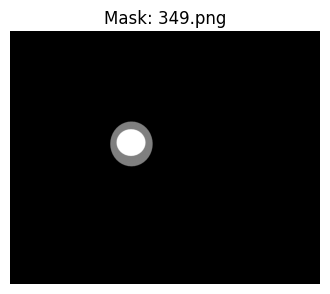

🖼️ 350.png - Unique values: {np.uint8(0), np.uint8(1), np.uint8(2)}


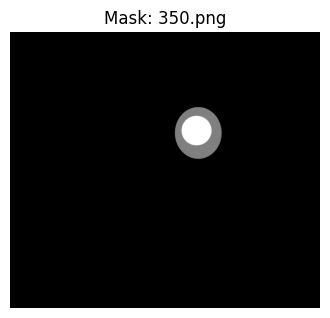

🖼️ 351.png - Unique values: {np.uint8(0), np.uint8(1), np.uint8(2)}


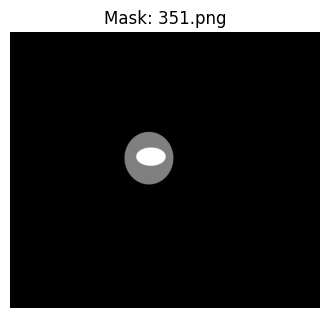

🖼️ 352.png - Unique values: {np.uint8(0), np.uint8(1), np.uint8(2)}


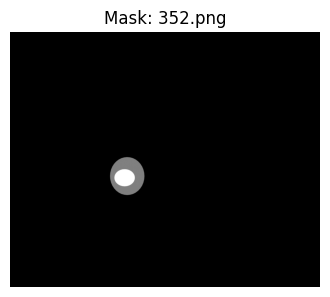

🖼️ 353.png - Unique values: {np.uint8(0), np.uint8(1), np.uint8(2)}


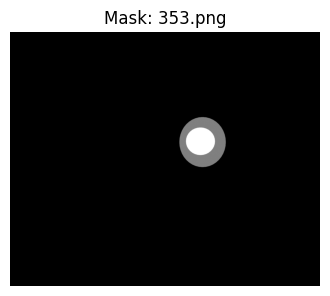

🖼️ 354.png - Unique values: {np.uint8(0), np.uint8(1), np.uint8(2)}


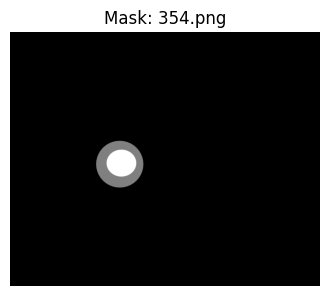

🖼️ 355.png - Unique values: {np.uint8(0), np.uint8(1), np.uint8(2)}


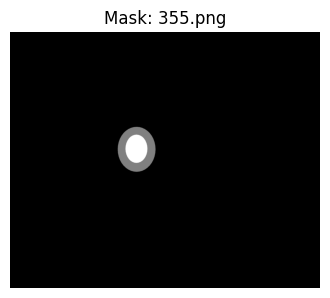

🖼️ 356.png - Unique values: {np.uint8(0), np.uint8(1), np.uint8(2)}


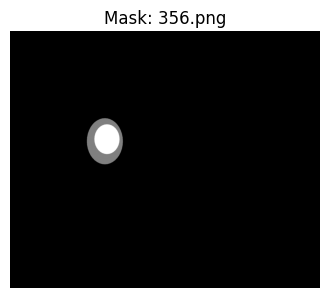

🖼️ 357.png - Unique values: {np.uint8(0), np.uint8(1), np.uint8(2)}


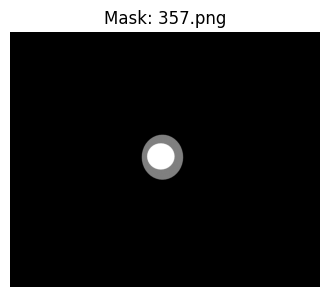

🖼️ 358.png - Unique values: {np.uint8(0), np.uint8(1), np.uint8(2)}


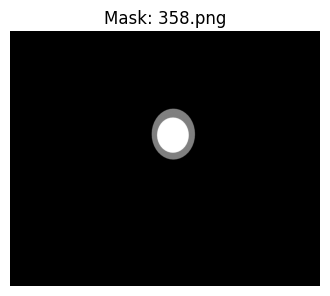

🖼️ 359.png - Unique values: {np.uint8(0), np.uint8(1), np.uint8(2)}


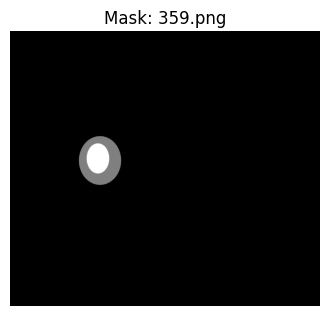

🖼️ 360.png - Unique values: {np.uint8(0), np.uint8(1), np.uint8(2)}


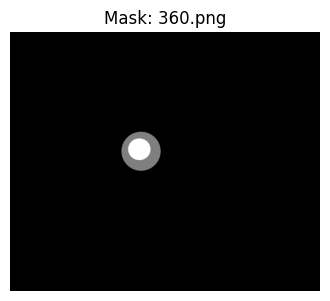

🖼️ 361.png - Unique values: {np.uint8(0), np.uint8(1), np.uint8(2)}


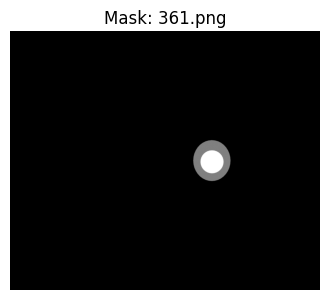

🖼️ 362.png - Unique values: {np.uint8(0), np.uint8(1), np.uint8(2)}


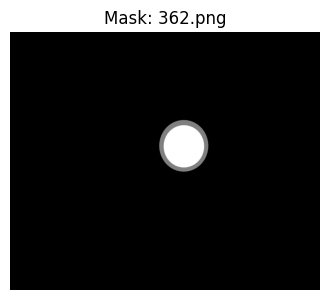

🖼️ 363.png - Unique values: {np.uint8(0), np.uint8(1), np.uint8(2)}


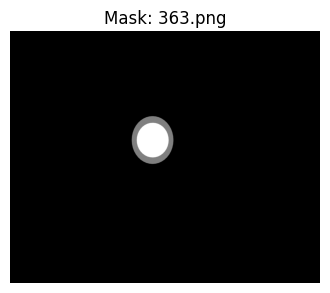

🖼️ 364.png - Unique values: {np.uint8(0), np.uint8(1), np.uint8(2)}


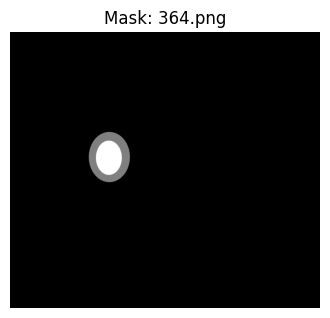

🖼️ 365.png - Unique values: {np.uint8(0), np.uint8(1), np.uint8(2)}


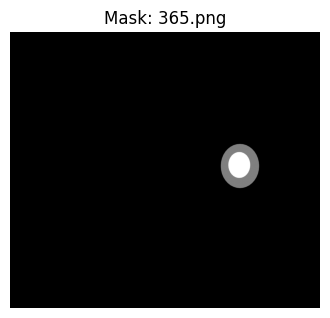

🖼️ 366.png - Unique values: {np.uint8(0), np.uint8(1), np.uint8(2)}


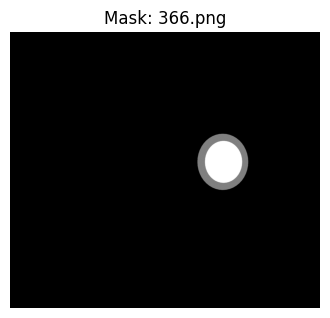

🖼️ 367.png - Unique values: {np.uint8(0), np.uint8(1), np.uint8(2)}


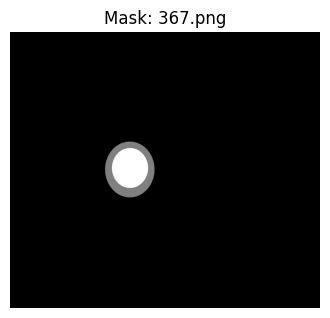

🖼️ 368.png - Unique values: {np.uint8(0), np.uint8(1), np.uint8(2)}


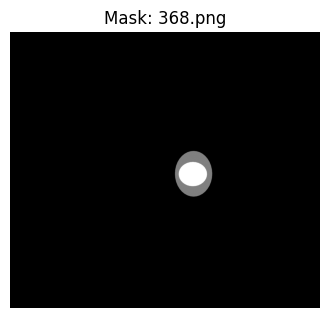

🖼️ 369.png - Unique values: {np.uint8(0), np.uint8(1), np.uint8(2)}


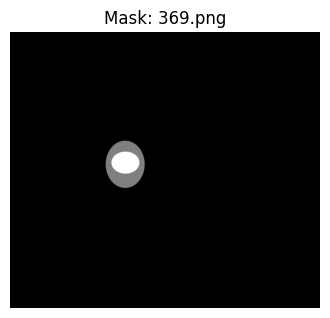

🖼️ 370.png - Unique values: {np.uint8(0), np.uint8(1), np.uint8(2)}


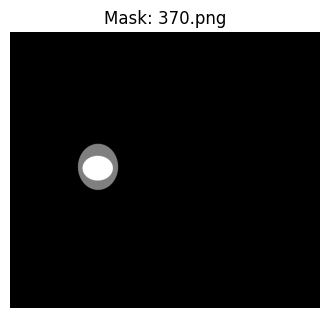

🖼️ 371.png - Unique values: {np.uint8(0), np.uint8(1), np.uint8(2)}


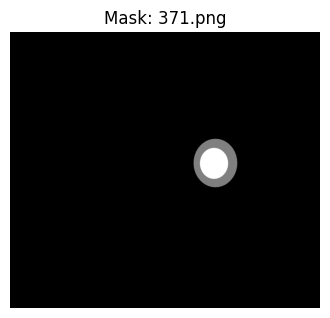

🖼️ 372.png - Unique values: {np.uint8(0), np.uint8(1), np.uint8(2)}


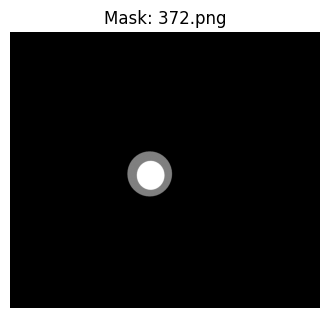

🖼️ 373.png - Unique values: {np.uint8(0), np.uint8(1), np.uint8(2)}


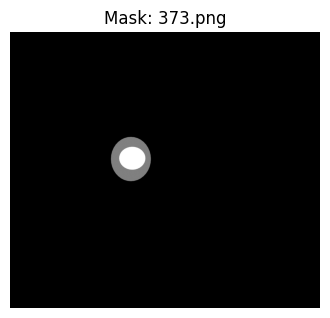

🖼️ 374.png - Unique values: {np.uint8(0), np.uint8(1), np.uint8(2)}


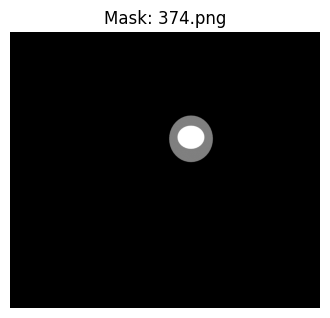

🖼️ 375.png - Unique values: {np.uint8(0), np.uint8(1), np.uint8(2)}


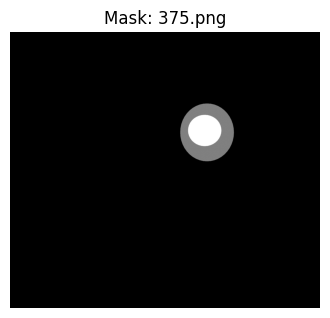

🖼️ 376.png - Unique values: {np.uint8(0), np.uint8(1), np.uint8(2)}


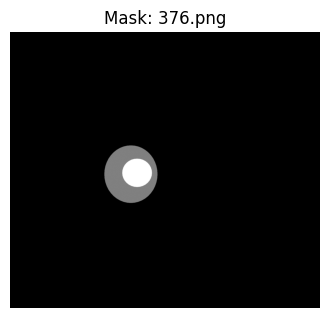

🖼️ 377.png - Unique values: {np.uint8(0), np.uint8(1), np.uint8(2)}


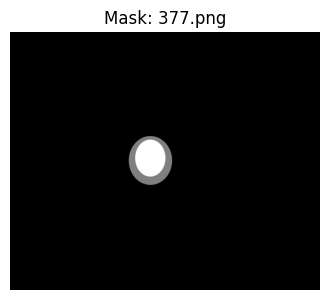

🖼️ 378.png - Unique values: {np.uint8(0), np.uint8(1), np.uint8(2)}


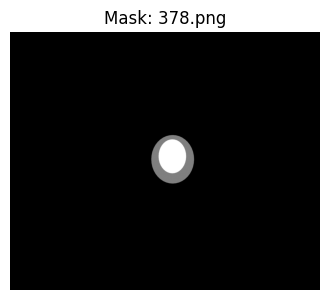

🖼️ 379.png - Unique values: {np.uint8(0), np.uint8(1), np.uint8(2)}


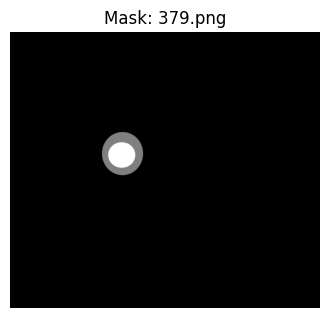

🖼️ 380.png - Unique values: {np.uint8(0), np.uint8(1), np.uint8(2)}


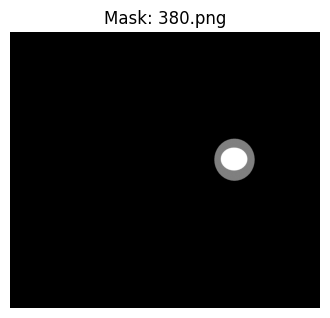

🖼️ 381.png - Unique values: {np.uint8(0), np.uint8(1), np.uint8(2)}


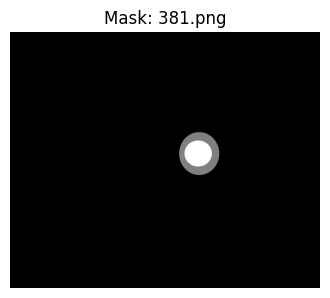

🖼️ 382.png - Unique values: {np.uint8(0), np.uint8(1), np.uint8(2)}


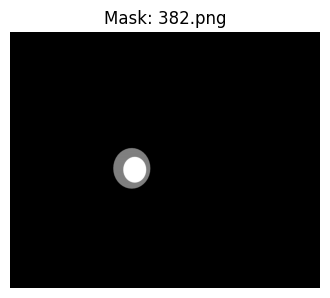

🖼️ 383.png - Unique values: {np.uint8(0), np.uint8(1), np.uint8(2)}


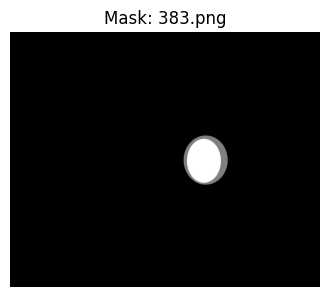

🖼️ 384.png - Unique values: {np.uint8(0), np.uint8(1), np.uint8(2)}


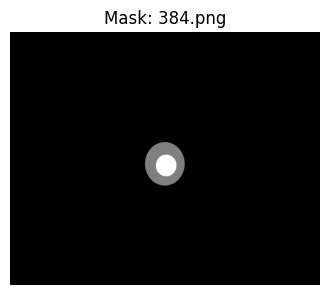

🖼️ 385.png - Unique values: {np.uint8(0), np.uint8(1), np.uint8(2)}


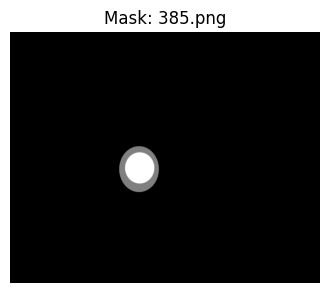

🖼️ 386.png - Unique values: {np.uint8(0), np.uint8(1), np.uint8(2)}


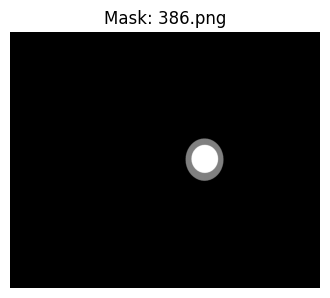

🖼️ 387.png - Unique values: {np.uint8(0), np.uint8(1), np.uint8(2)}


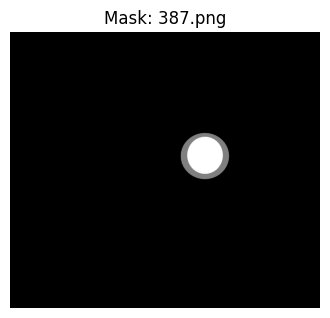

🖼️ 388.png - Unique values: {np.uint8(0), np.uint8(1), np.uint8(2)}


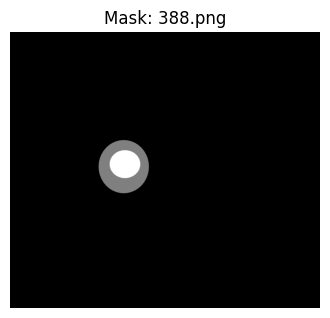

🖼️ 389.png - Unique values: {np.uint8(0), np.uint8(1), np.uint8(2)}


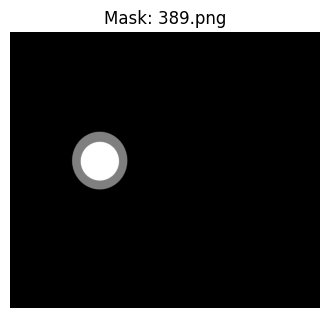

🖼️ 390.png - Unique values: {np.uint8(0), np.uint8(1), np.uint8(2)}


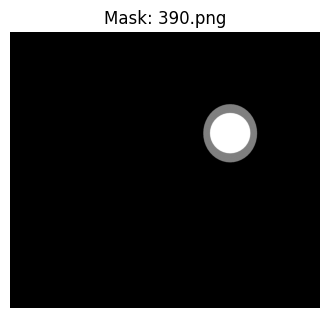

🖼️ 391.png - Unique values: {np.uint8(0), np.uint8(1), np.uint8(2)}


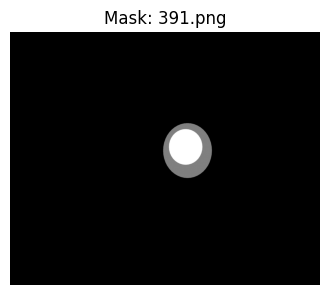

🖼️ 392.png - Unique values: {np.uint8(0), np.uint8(1), np.uint8(2)}


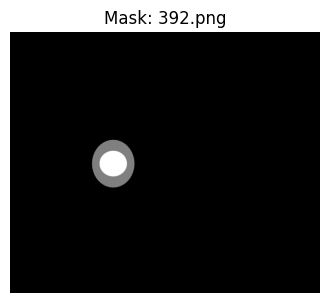

🖼️ 393.png - Unique values: {np.uint8(0), np.uint8(1), np.uint8(2)}


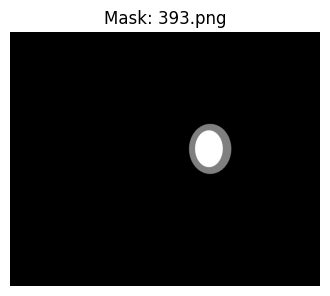

🖼️ 394.png - Unique values: {np.uint8(0), np.uint8(1), np.uint8(2)}


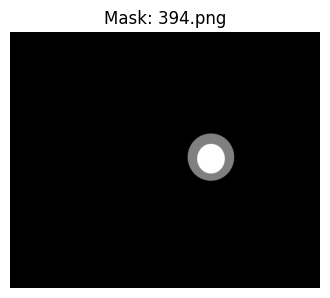

🖼️ 395.png - Unique values: {np.uint8(0), np.uint8(1), np.uint8(2)}


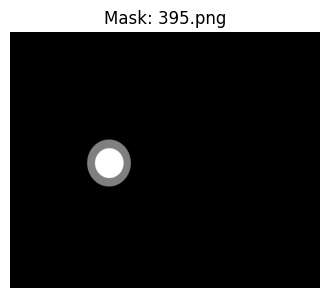

🖼️ 396.png - Unique values: {np.uint8(0), np.uint8(1), np.uint8(2)}


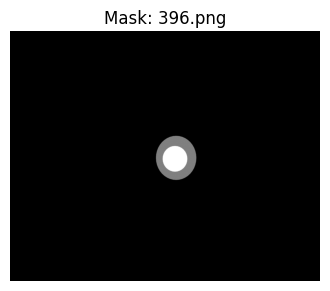

🖼️ 397.png - Unique values: {np.uint8(0), np.uint8(1), np.uint8(2)}


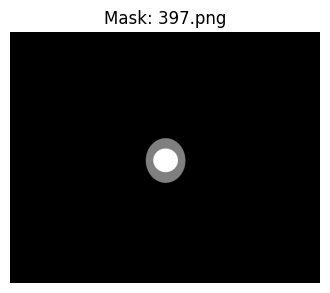

🖼️ 398.png - Unique values: {np.uint8(0), np.uint8(1), np.uint8(2)}


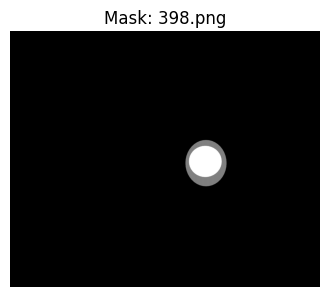

🖼️ 399.png - Unique values: {np.uint8(0), np.uint8(1), np.uint8(2)}


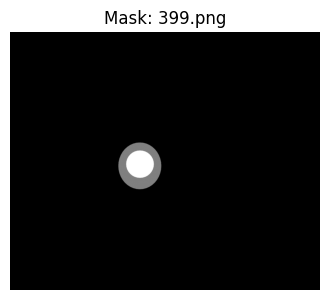

🖼️ 400.png - Unique values: {np.uint8(0), np.uint8(1), np.uint8(2)}


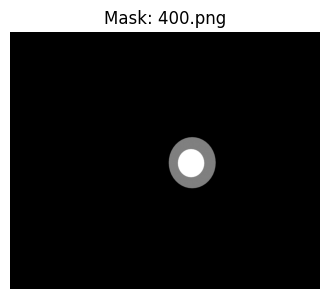

🖼️ 401.png - Unique values: {np.uint8(0), np.uint8(1), np.uint8(2)}


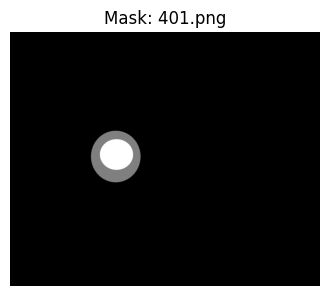

🖼️ 402.png - Unique values: {np.uint8(0), np.uint8(1), np.uint8(2)}


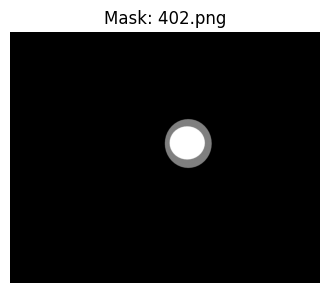

🖼️ 403.png - Unique values: {np.uint8(0), np.uint8(1), np.uint8(2)}


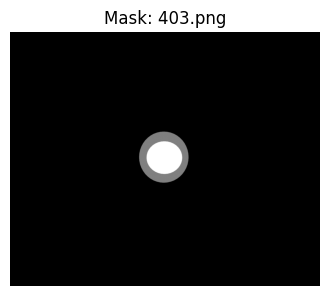

🖼️ 404.png - Unique values: {np.uint8(0), np.uint8(1), np.uint8(2)}


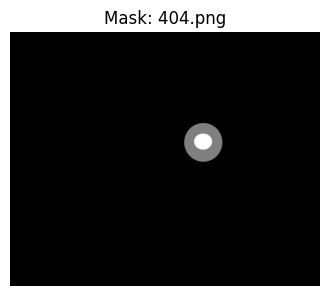

🖼️ 405.png - Unique values: {np.uint8(0), np.uint8(1), np.uint8(2)}


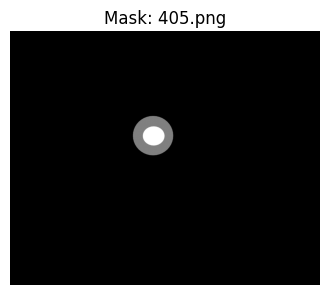

🖼️ 406.png - Unique values: {np.uint8(0), np.uint8(1), np.uint8(2)}


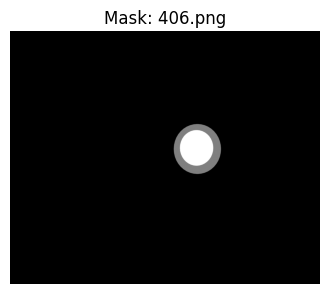

🖼️ 407.png - Unique values: {np.uint8(0), np.uint8(1), np.uint8(2)}


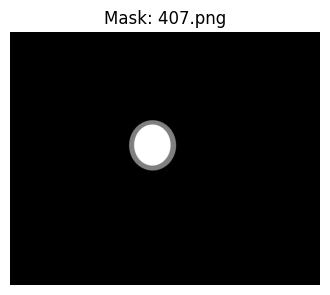

🖼️ 408.png - Unique values: {np.uint8(0), np.uint8(1), np.uint8(2)}


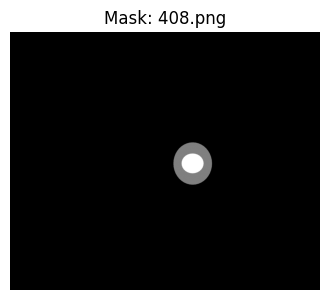

🖼️ 409.png - Unique values: {np.uint8(0), np.uint8(1), np.uint8(2)}


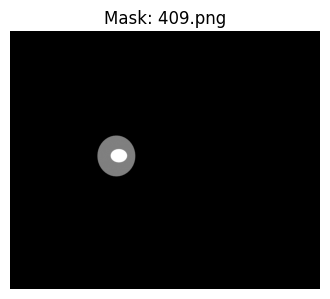

🖼️ 410.png - Unique values: {np.uint8(0), np.uint8(1), np.uint8(2)}


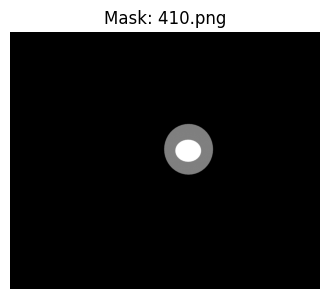

🖼️ 411.png - Unique values: {np.uint8(0), np.uint8(1), np.uint8(2)}


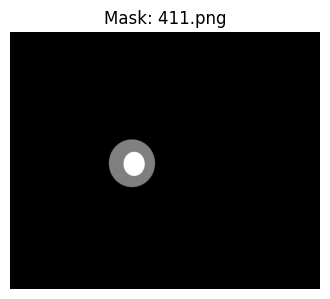

🖼️ 412.png - Unique values: {np.uint8(0), np.uint8(1), np.uint8(2)}


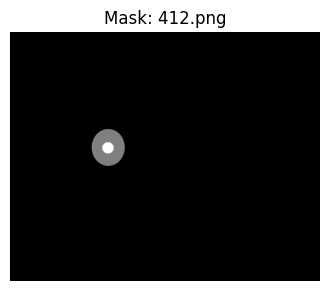

🖼️ 413.png - Unique values: {np.uint8(0), np.uint8(1), np.uint8(2)}


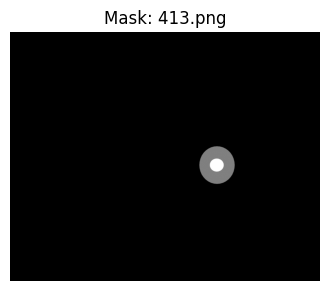

🖼️ 414.png - Unique values: {np.uint8(0), np.uint8(1), np.uint8(2)}


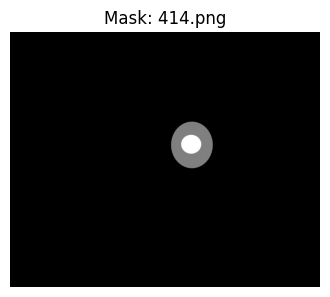

🖼️ 415.png - Unique values: {np.uint8(0), np.uint8(1), np.uint8(2)}


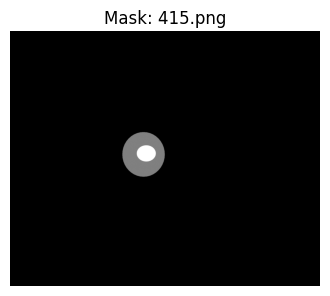

🖼️ 416.png - Unique values: {np.uint8(0), np.uint8(1), np.uint8(2)}


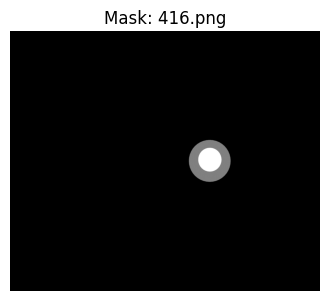

🖼️ 417.png - Unique values: {np.uint8(0), np.uint8(1), np.uint8(2)}


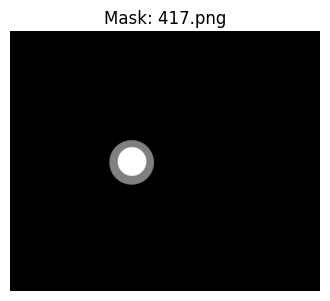

🖼️ 418.png - Unique values: {np.uint8(0), np.uint8(1), np.uint8(2)}


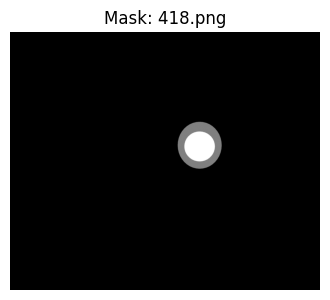

🖼️ 419.png - Unique values: {np.uint8(0), np.uint8(1), np.uint8(2)}


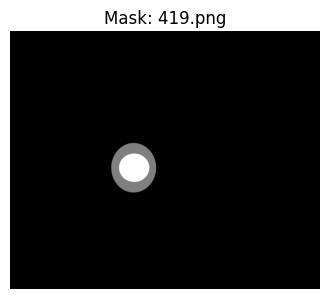

🖼️ 420.png - Unique values: {np.uint8(0), np.uint8(1), np.uint8(2)}


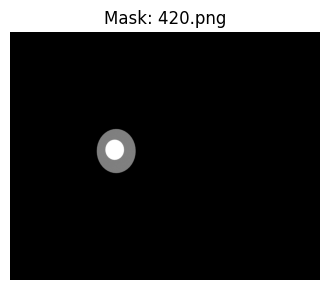

🖼️ 421.png - Unique values: {np.uint8(0), np.uint8(1), np.uint8(2)}


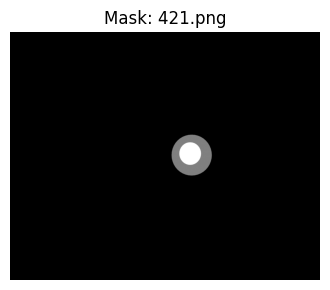

🖼️ 422.png - Unique values: {np.uint8(0), np.uint8(1), np.uint8(2)}


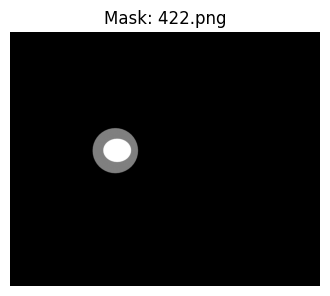

🖼️ 423.png - Unique values: {np.uint8(0), np.uint8(1), np.uint8(2)}


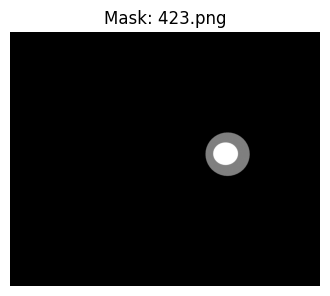

🖼️ 424.png - Unique values: {np.uint8(0), np.uint8(1), np.uint8(2)}


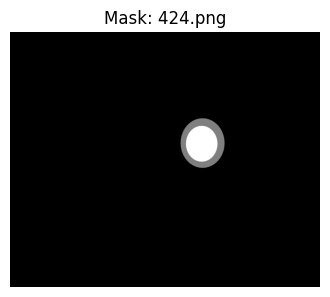

🖼️ 425.png - Unique values: {np.uint8(0), np.uint8(1), np.uint8(2)}


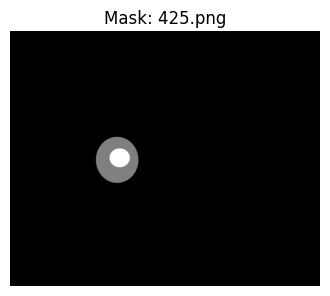

🖼️ 426.png - Unique values: {np.uint8(0), np.uint8(1), np.uint8(2)}


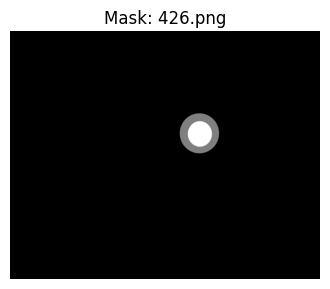

🖼️ 427.png - Unique values: {np.uint8(0), np.uint8(1), np.uint8(2)}


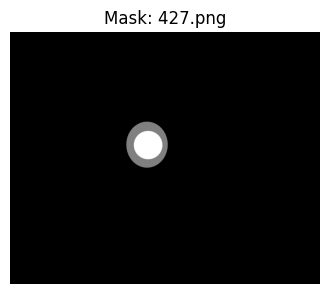

🖼️ 428.png - Unique values: {np.uint8(0), np.uint8(1), np.uint8(2)}


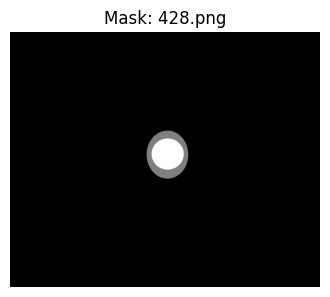

🖼️ 429.png - Unique values: {np.uint8(0), np.uint8(1), np.uint8(2)}


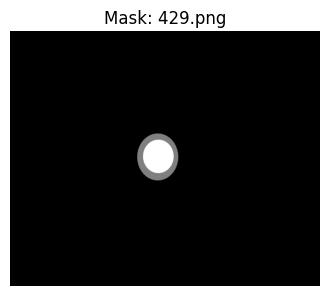

🖼️ 430.png - Unique values: {np.uint8(0), np.uint8(1), np.uint8(2)}


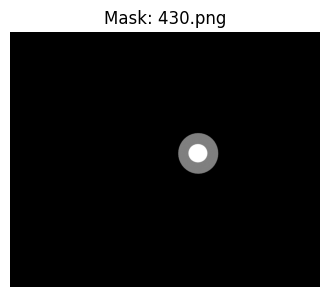

🖼️ 431.png - Unique values: {np.uint8(0), np.uint8(1), np.uint8(2)}


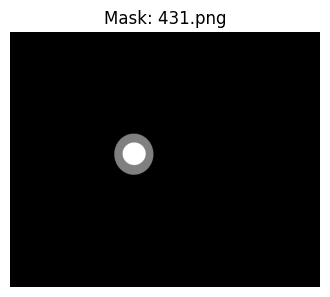

🖼️ 432.png - Unique values: {np.uint8(0), np.uint8(1), np.uint8(2)}


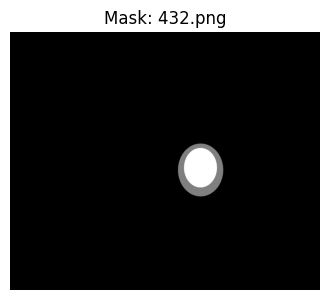

🖼️ 433.png - Unique values: {np.uint8(0), np.uint8(1), np.uint8(2)}


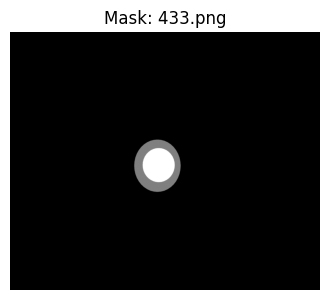

🖼️ 434.png - Unique values: {np.uint8(0), np.uint8(1), np.uint8(2)}


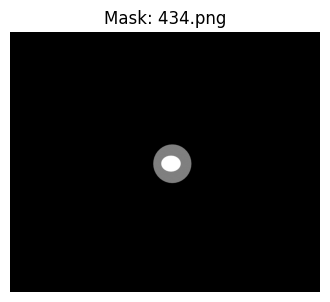

🖼️ 435.png - Unique values: {np.uint8(0), np.uint8(1), np.uint8(2)}


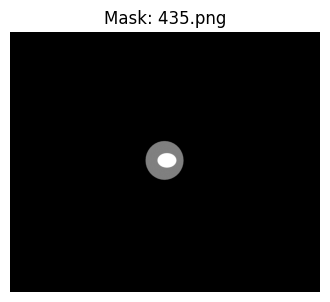

🖼️ 436.png - Unique values: {np.uint8(0), np.uint8(1), np.uint8(2)}


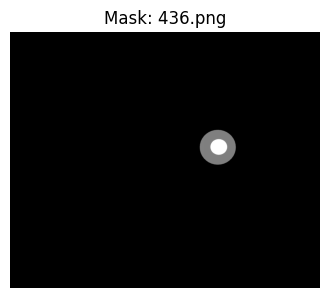

🖼️ 437.png - Unique values: {np.uint8(0), np.uint8(1), np.uint8(2)}


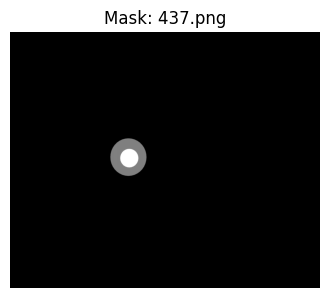

🖼️ 438.png - Unique values: {np.uint8(0), np.uint8(1), np.uint8(2)}


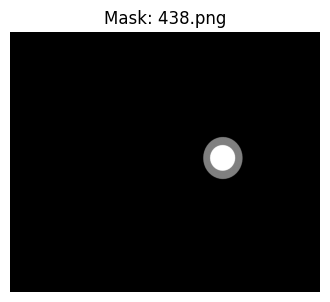

🖼️ 439.png - Unique values: {np.uint8(0), np.uint8(1), np.uint8(2)}


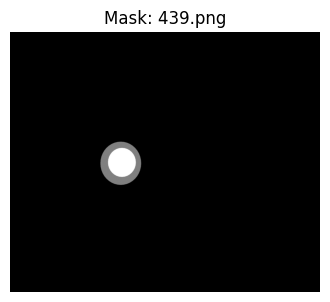

🖼️ 440.png - Unique values: {np.uint8(0), np.uint8(1), np.uint8(2)}


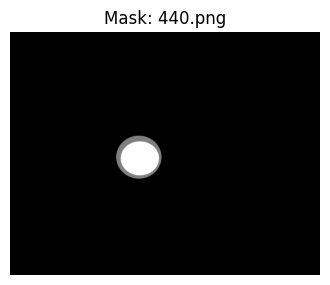

🖼️ 441.png - Unique values: {np.uint8(0), np.uint8(1), np.uint8(2)}


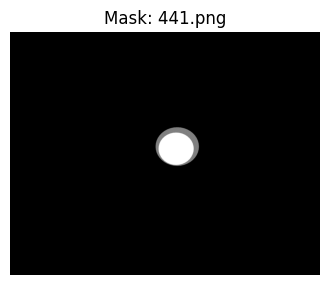

🖼️ 442.png - Unique values: {np.uint8(0), np.uint8(1), np.uint8(2)}


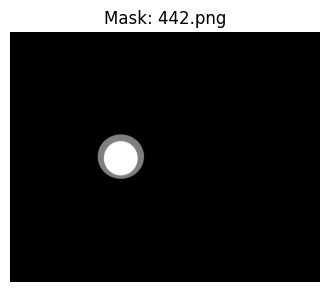

🖼️ 443.png - Unique values: {np.uint8(0), np.uint8(1), np.uint8(2)}


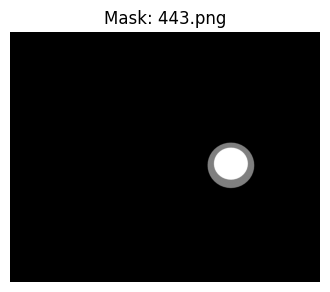

🖼️ 444.png - Unique values: {np.uint8(0), np.uint8(1), np.uint8(2)}


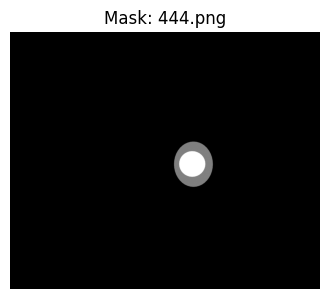

🖼️ 445.png - Unique values: {np.uint8(0), np.uint8(1), np.uint8(2)}


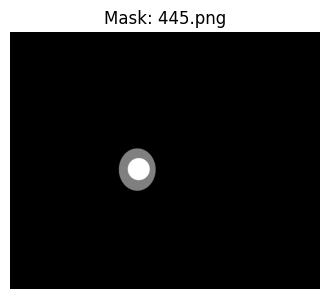

🖼️ 446.png - Unique values: {np.uint8(0), np.uint8(1), np.uint8(2)}


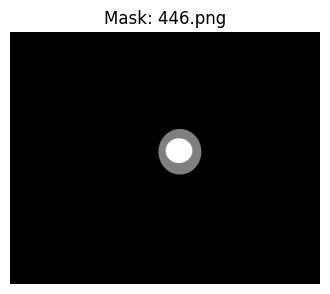

🖼️ 447.png - Unique values: {np.uint8(0), np.uint8(1), np.uint8(2)}


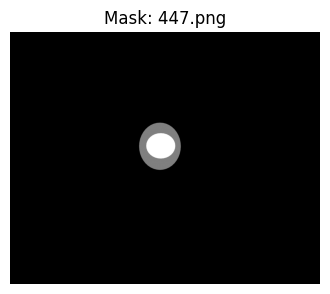

🖼️ 448.png - Unique values: {np.uint8(0), np.uint8(1), np.uint8(2)}


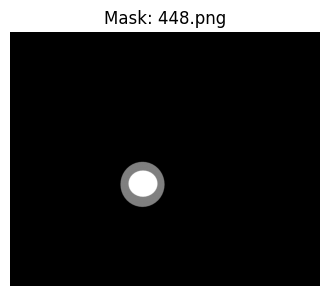

🖼️ 449.png - Unique values: {np.uint8(0), np.uint8(1), np.uint8(2)}


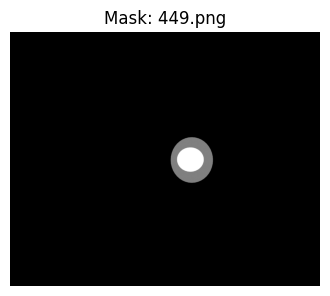

🖼️ 450.png - Unique values: {np.uint8(0), np.uint8(1), np.uint8(2)}


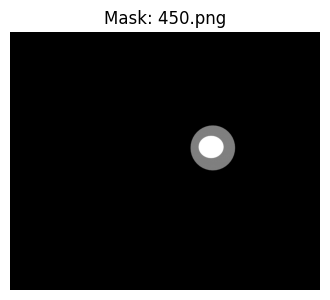

🖼️ 451.png - Unique values: {np.uint8(0), np.uint8(1), np.uint8(2)}


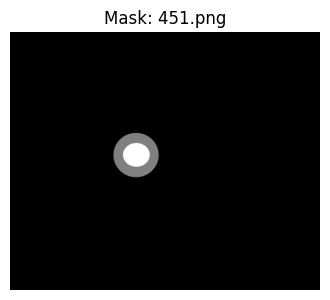

🖼️ 452.png - Unique values: {np.uint8(0), np.uint8(1), np.uint8(2)}


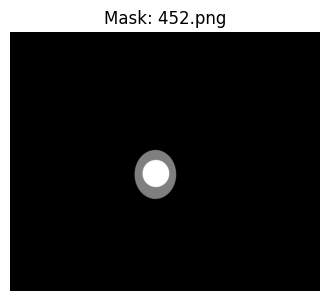

🖼️ 453.png - Unique values: {np.uint8(0), np.uint8(1), np.uint8(2)}


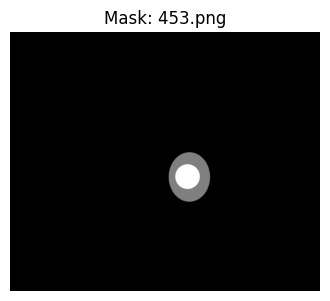

🖼️ 454.png - Unique values: {np.uint8(0), np.uint8(1), np.uint8(2)}


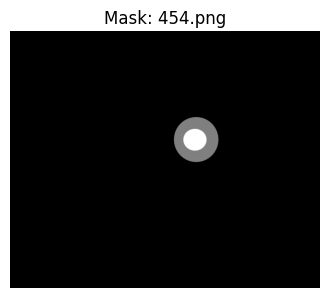

🖼️ 455.png - Unique values: {np.uint8(0), np.uint8(1), np.uint8(2)}


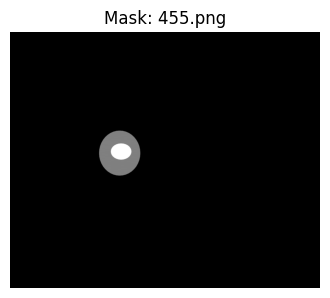

🖼️ 456.png - Unique values: {np.uint8(0), np.uint8(1), np.uint8(2)}


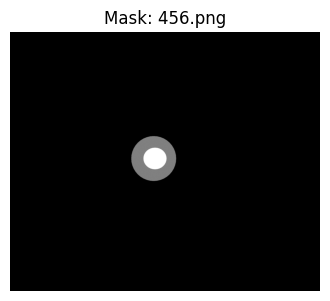

🖼️ 457.png - Unique values: {np.uint8(0), np.uint8(1), np.uint8(2)}


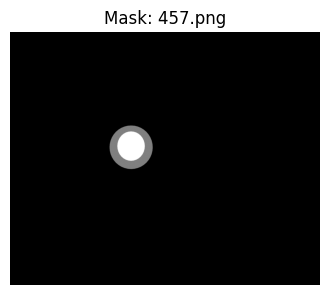

🖼️ 458.png - Unique values: {np.uint8(0), np.uint8(1), np.uint8(2)}


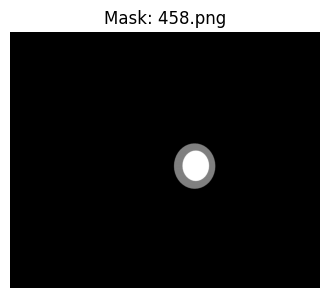

🖼️ 459.png - Unique values: {np.uint8(0), np.uint8(1), np.uint8(2)}


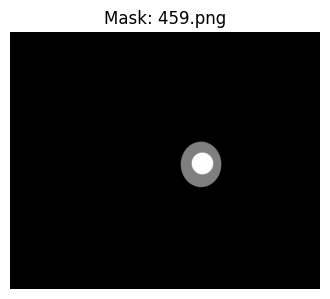

🖼️ 460.png - Unique values: {np.uint8(0), np.uint8(1), np.uint8(2)}


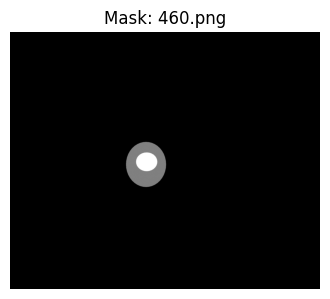

🖼️ 461.png - Unique values: {np.uint8(0), np.uint8(1), np.uint8(2)}


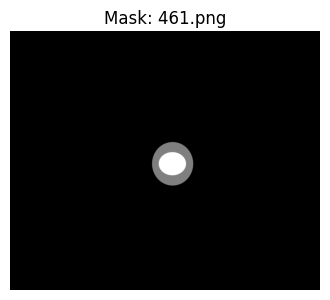

🖼️ 462.png - Unique values: {np.uint8(0), np.uint8(1), np.uint8(2)}


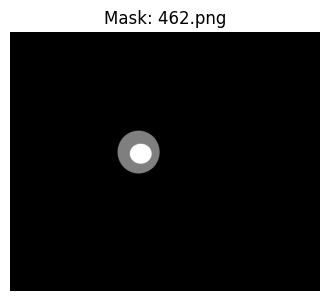

🖼️ 463.png - Unique values: {np.uint8(0), np.uint8(1), np.uint8(2)}


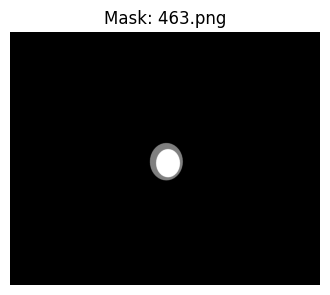

🖼️ 464.png - Unique values: {np.uint8(0), np.uint8(1), np.uint8(2)}


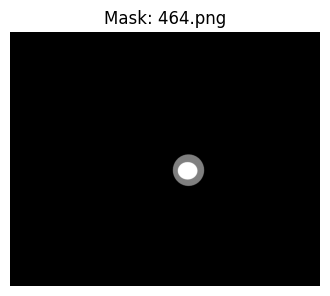

🖼️ 465.png - Unique values: {np.uint8(0), np.uint8(1), np.uint8(2)}


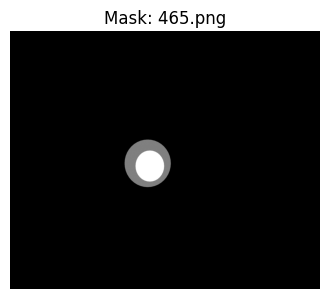

🖼️ 466.png - Unique values: {np.uint8(0), np.uint8(1), np.uint8(2)}


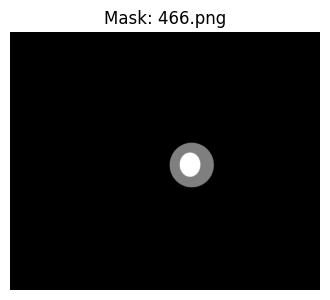

🖼️ 467.png - Unique values: {np.uint8(0), np.uint8(1), np.uint8(2)}


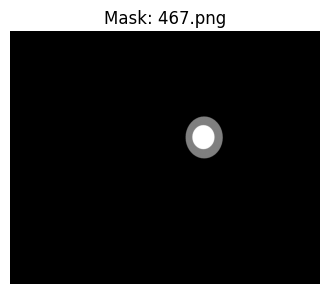

🖼️ 468.png - Unique values: {np.uint8(0), np.uint8(1), np.uint8(2)}


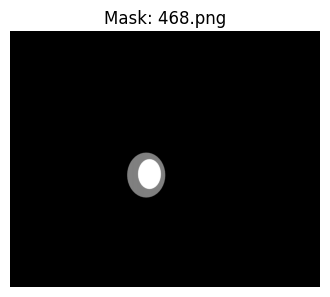

🖼️ 469.png - Unique values: {np.uint8(0), np.uint8(1), np.uint8(2)}


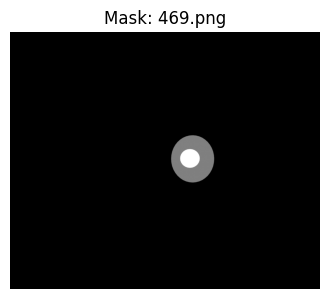

🖼️ 470.png - Unique values: {np.uint8(0), np.uint8(1), np.uint8(2)}


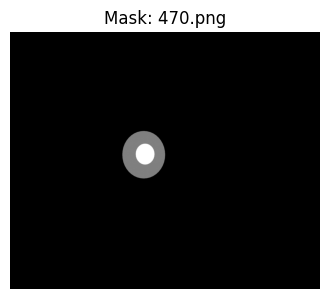

🖼️ 471.png - Unique values: {np.uint8(0), np.uint8(1), np.uint8(2)}


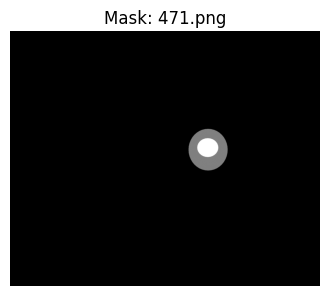

🖼️ 472.png - Unique values: {np.uint8(0), np.uint8(1), np.uint8(2)}


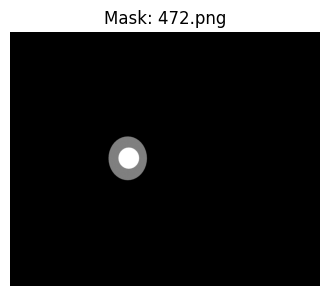

🖼️ 473.png - Unique values: {np.uint8(0), np.uint8(1), np.uint8(2)}


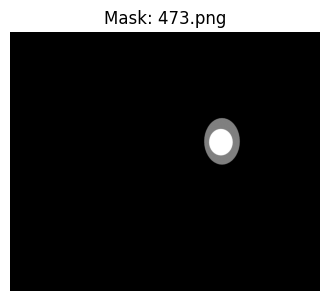

🖼️ 474.png - Unique values: {np.uint8(0), np.uint8(1), np.uint8(2)}


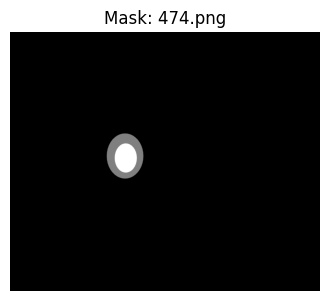

🖼️ 475.png - Unique values: {np.uint8(0), np.uint8(1), np.uint8(2)}


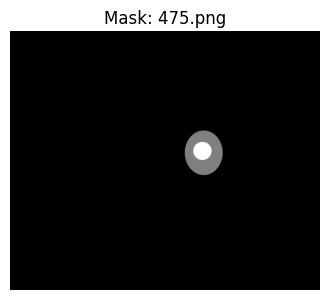

🖼️ 476.png - Unique values: {np.uint8(0), np.uint8(1), np.uint8(2)}


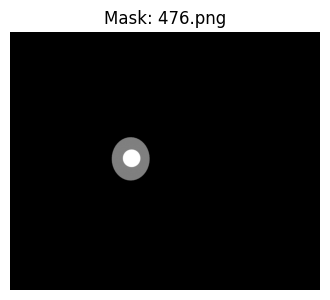

🖼️ 477.png - Unique values: {np.uint8(0), np.uint8(1), np.uint8(2)}


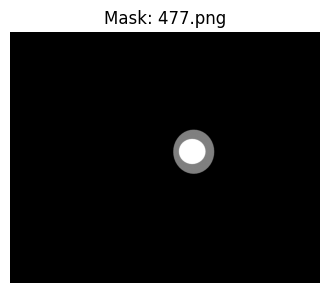

🖼️ 478.png - Unique values: {np.uint8(0), np.uint8(1), np.uint8(2)}


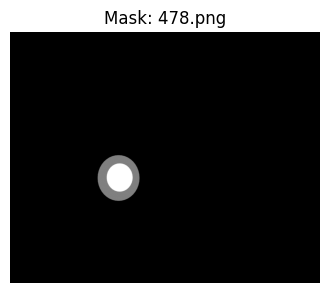

🖼️ 479.png - Unique values: {np.uint8(0), np.uint8(1), np.uint8(2)}


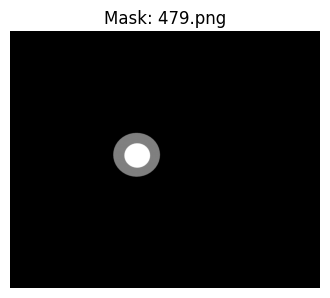

🖼️ 480.png - Unique values: {np.uint8(0), np.uint8(1), np.uint8(2)}


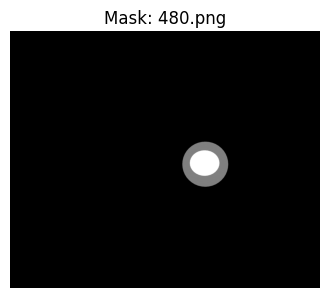

🖼️ 481.png - Unique values: {np.uint8(0), np.uint8(1), np.uint8(2)}


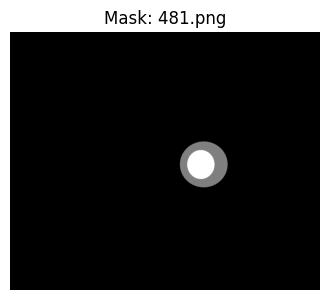

🖼️ 482.png - Unique values: {np.uint8(0), np.uint8(1), np.uint8(2)}


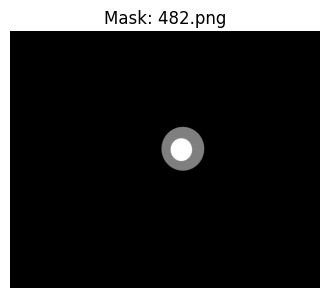

🖼️ 483.png - Unique values: {np.uint8(0), np.uint8(1), np.uint8(2)}


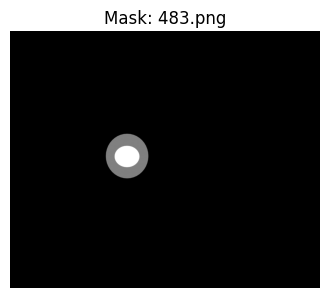

🖼️ 484.png - Unique values: {np.uint8(0), np.uint8(1), np.uint8(2)}


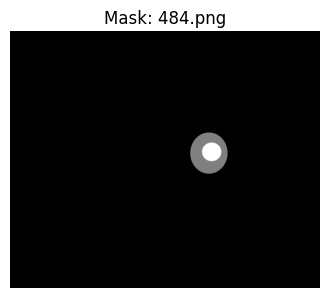

🖼️ 485.png - Unique values: {np.uint8(0), np.uint8(1), np.uint8(2)}


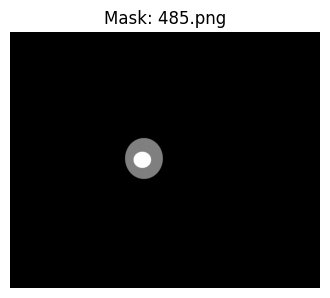

🖼️ 486.png - Unique values: {np.uint8(0), np.uint8(1), np.uint8(2)}


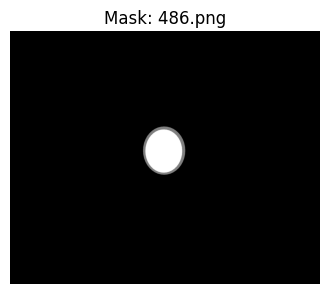

🖼️ 487.png - Unique values: {np.uint8(0), np.uint8(1), np.uint8(2)}


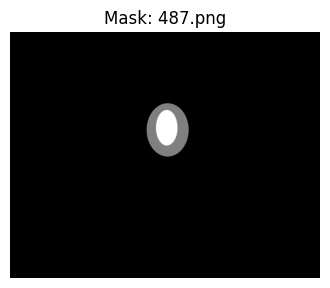

🖼️ 488.png - Unique values: {np.uint8(0), np.uint8(1), np.uint8(2)}


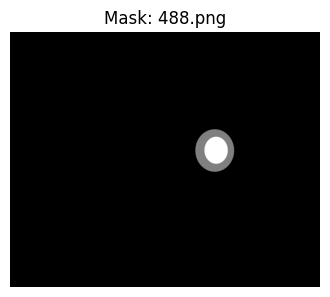

🖼️ 489.png - Unique values: {np.uint8(0), np.uint8(1), np.uint8(2)}


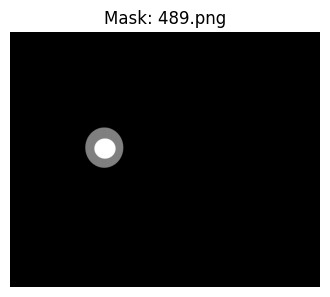

🖼️ 490.png - Unique values: {np.uint8(0), np.uint8(1), np.uint8(2)}


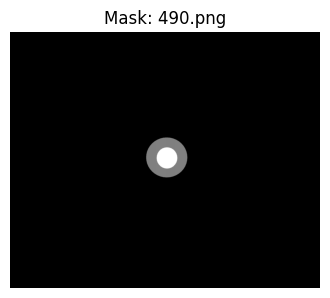

🖼️ 491.png - Unique values: {np.uint8(0), np.uint8(1), np.uint8(2)}


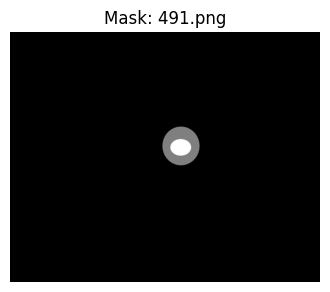

🖼️ 492.png - Unique values: {np.uint8(0), np.uint8(1), np.uint8(2)}


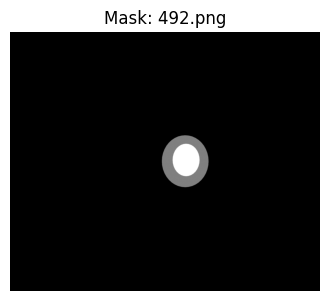

🖼️ 493.png - Unique values: {np.uint8(0), np.uint8(1), np.uint8(2)}


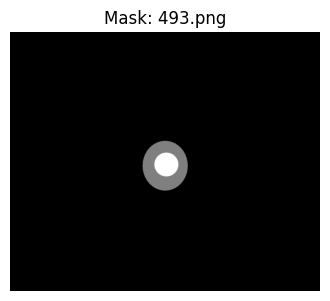

🖼️ 494.png - Unique values: {np.uint8(0), np.uint8(1), np.uint8(2)}


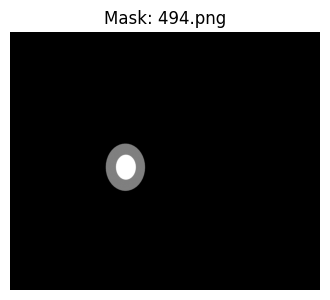

🖼️ 495.png - Unique values: {np.uint8(0), np.uint8(1), np.uint8(2)}


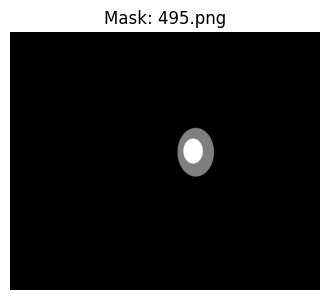

🖼️ 496.png - Unique values: {np.uint8(0), np.uint8(1), np.uint8(2)}


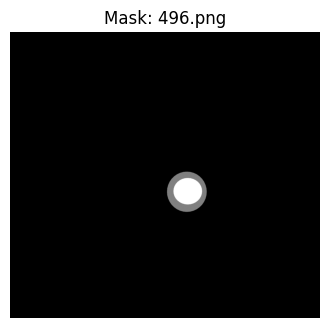

🖼️ 497.png - Unique values: {np.uint8(0), np.uint8(1), np.uint8(2)}


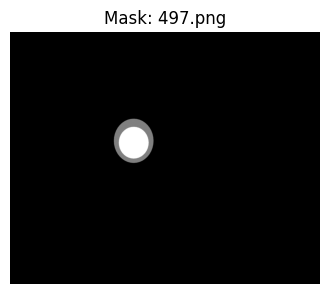

🖼️ 498.png - Unique values: {np.uint8(0), np.uint8(1), np.uint8(2)}


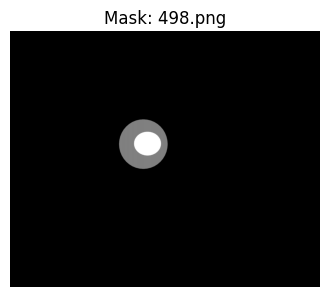

🖼️ 499.png - Unique values: {np.uint8(0), np.uint8(1), np.uint8(2)}


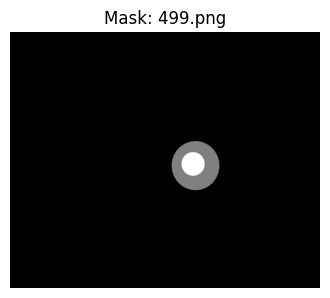

🖼️ 500.png - Unique values: {np.uint8(0), np.uint8(1), np.uint8(2)}


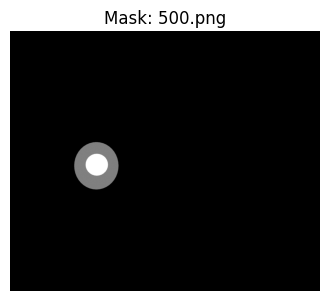

🖼️ 501.png - Unique values: {np.uint8(0), np.uint8(1), np.uint8(2)}


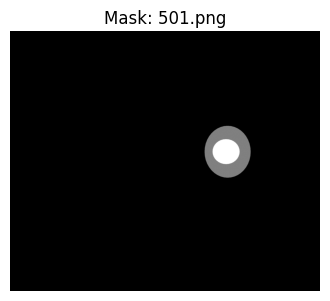

🖼️ 502.png - Unique values: {np.uint8(0), np.uint8(1), np.uint8(2)}


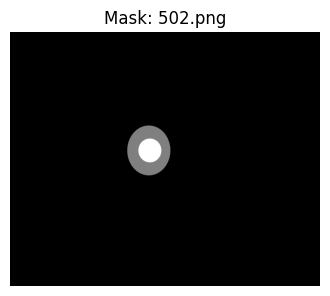

🖼️ 503.png - Unique values: {np.uint8(0), np.uint8(1), np.uint8(2)}


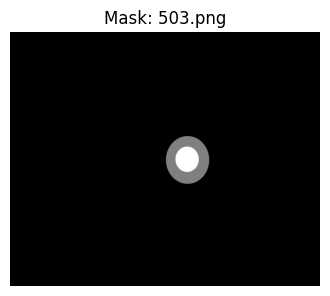

🖼️ 504.png - Unique values: {np.uint8(0), np.uint8(1), np.uint8(2)}


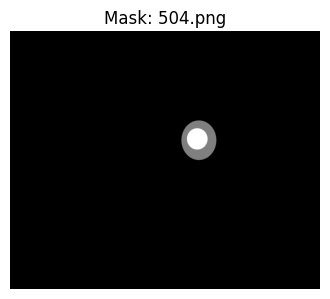

🖼️ 505.png - Unique values: {np.uint8(0), np.uint8(1), np.uint8(2)}


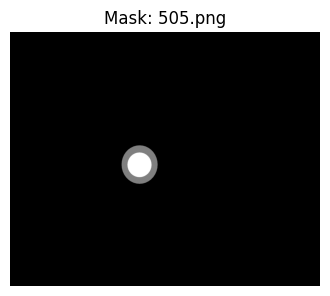

🖼️ 506.png - Unique values: {np.uint8(0), np.uint8(1), np.uint8(2)}


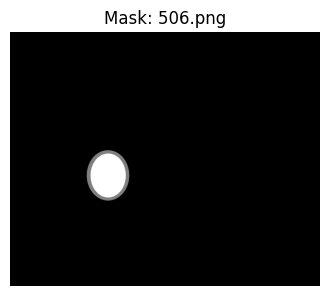

🖼️ 507.png - Unique values: {np.uint8(0), np.uint8(1), np.uint8(2)}


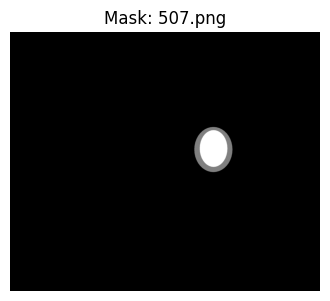

🖼️ 508.png - Unique values: {np.uint8(0), np.uint8(1), np.uint8(2)}


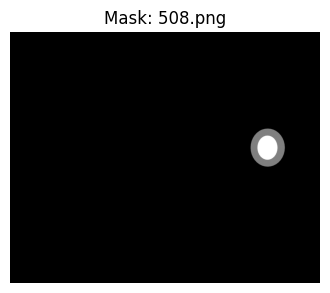

🖼️ 509.png - Unique values: {np.uint8(0), np.uint8(1), np.uint8(2)}


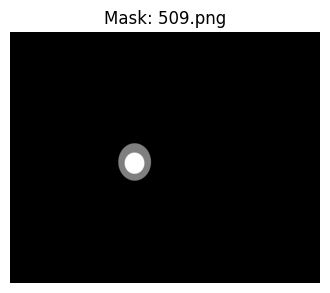

🖼️ 510.png - Unique values: {np.uint8(0), np.uint8(1), np.uint8(2)}


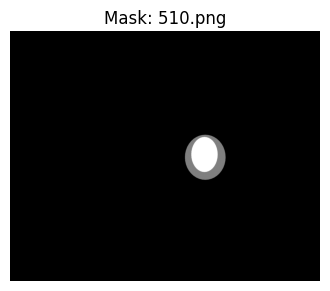

🖼️ 511.png - Unique values: {np.uint8(0), np.uint8(1), np.uint8(2)}


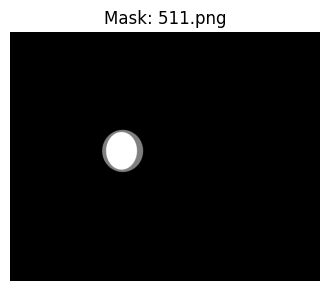

🖼️ 512.png - Unique values: {np.uint8(0), np.uint8(1), np.uint8(2)}


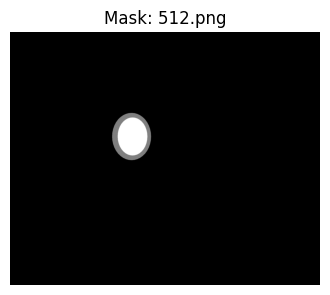

🖼️ 513.png - Unique values: {np.uint8(0), np.uint8(1), np.uint8(2)}


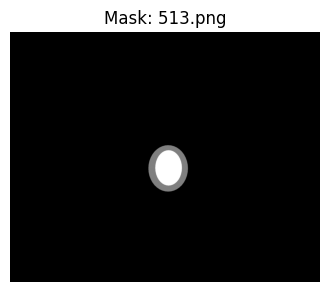

🖼️ 514.png - Unique values: {np.uint8(0), np.uint8(1), np.uint8(2)}


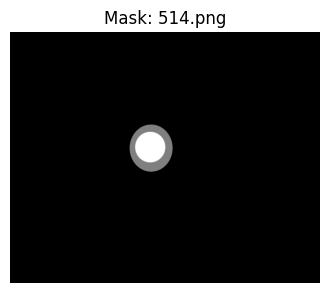

🖼️ 515.png - Unique values: {np.uint8(0), np.uint8(1), np.uint8(2)}


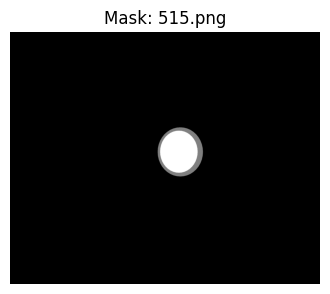

🖼️ 516.png - Unique values: {np.uint8(0), np.uint8(1), np.uint8(2)}


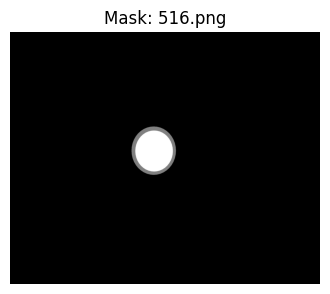

🖼️ 517.png - Unique values: {np.uint8(0), np.uint8(1), np.uint8(2)}


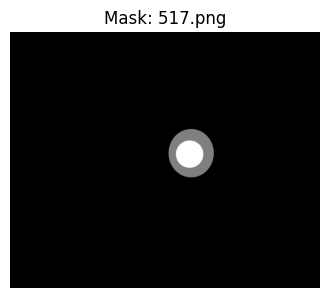

🖼️ 518.png - Unique values: {np.uint8(0), np.uint8(1), np.uint8(2)}


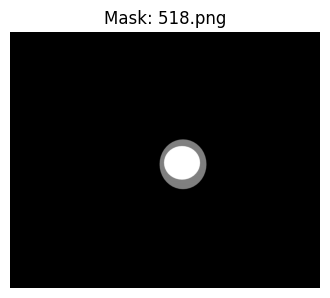

🖼️ 519.png - Unique values: {np.uint8(0), np.uint8(1), np.uint8(2)}


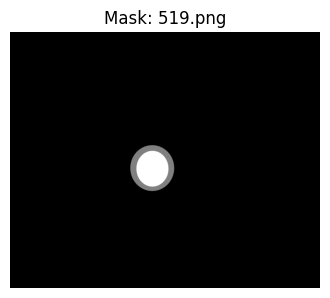

🖼️ 520.png - Unique values: {np.uint8(0), np.uint8(1), np.uint8(2)}


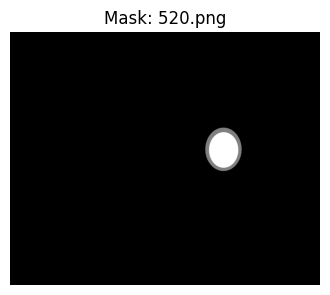

🖼️ 521.png - Unique values: {np.uint8(0), np.uint8(1), np.uint8(2)}


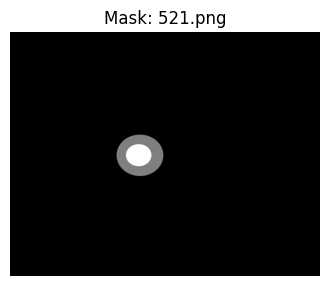

🖼️ 522.png - Unique values: {np.uint8(0), np.uint8(1), np.uint8(2)}


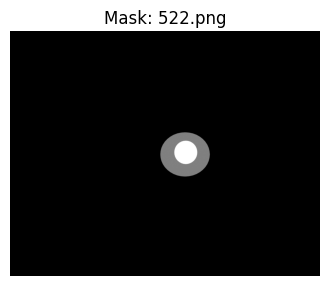

🖼️ 523.png - Unique values: {np.uint8(0), np.uint8(1), np.uint8(2)}


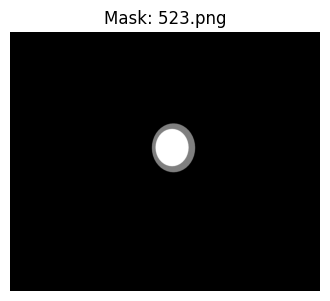

🖼️ 524.png - Unique values: {np.uint8(0), np.uint8(1), np.uint8(2)}


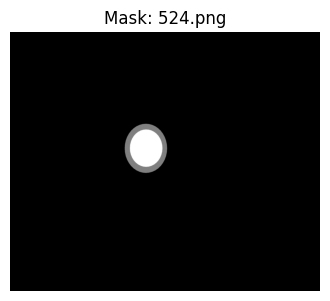

🖼️ 525.png - Unique values: {np.uint8(0), np.uint8(1), np.uint8(2)}


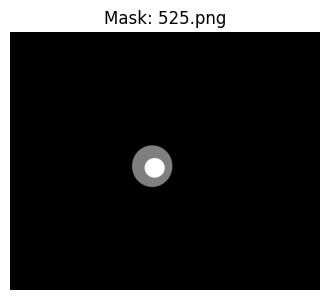

🖼️ 526.png - Unique values: {np.uint8(0), np.uint8(1), np.uint8(2)}


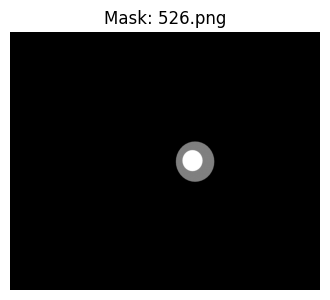

🖼️ 527.png - Unique values: {np.uint8(0), np.uint8(1), np.uint8(2)}


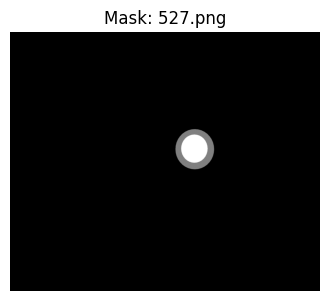

🖼️ 528.png - Unique values: {np.uint8(0), np.uint8(1), np.uint8(2)}


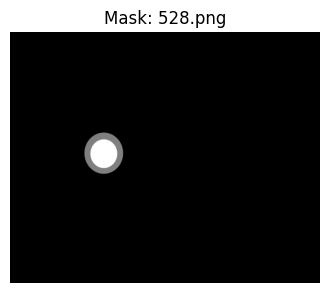

🖼️ 529.png - Unique values: {np.uint8(0), np.uint8(1), np.uint8(2)}


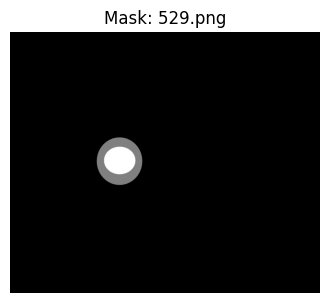

🖼️ 530.png - Unique values: {np.uint8(0), np.uint8(1), np.uint8(2)}


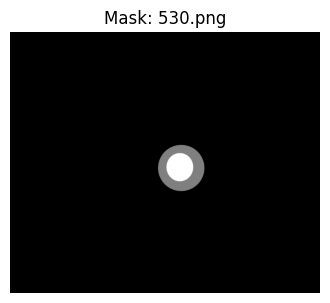

🖼️ 531.png - Unique values: {np.uint8(0), np.uint8(1), np.uint8(2)}


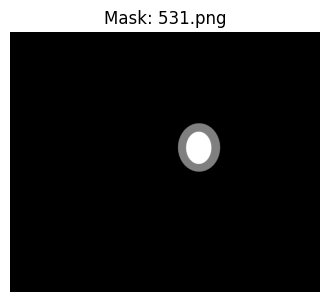

🖼️ 532.png - Unique values: {np.uint8(0), np.uint8(1), np.uint8(2)}


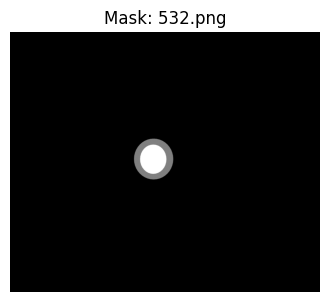

🖼️ 533.png - Unique values: {np.uint8(0), np.uint8(1), np.uint8(2)}


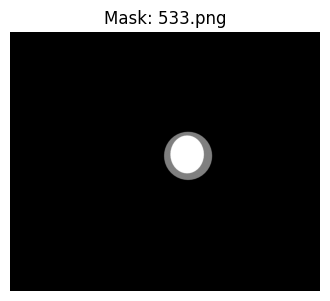

🖼️ 534.png - Unique values: {np.uint8(0), np.uint8(1), np.uint8(2)}


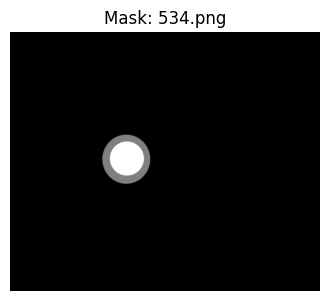

🖼️ 535.png - Unique values: {np.uint8(0), np.uint8(1), np.uint8(2)}


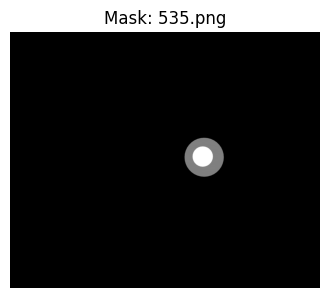

🖼️ 536.png - Unique values: {np.uint8(0), np.uint8(1), np.uint8(2)}


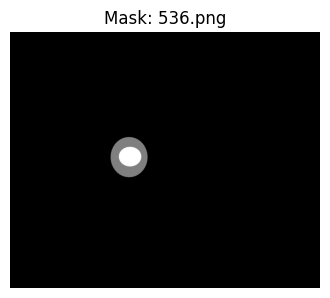

🖼️ 537.png - Unique values: {np.uint8(0), np.uint8(1), np.uint8(2)}


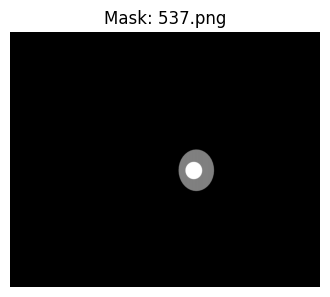

🖼️ 538.png - Unique values: {np.uint8(0), np.uint8(1), np.uint8(2)}


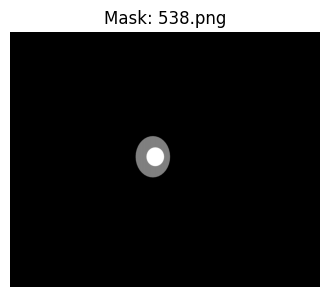

🖼️ 539.png - Unique values: {np.uint8(0), np.uint8(1), np.uint8(2)}


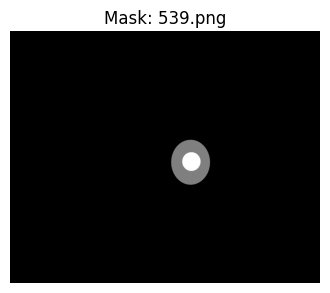

🖼️ 540.png - Unique values: {np.uint8(0), np.uint8(1), np.uint8(2)}


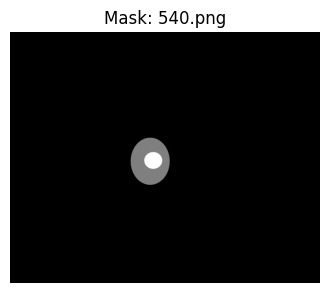

🖼️ 541.png - Unique values: {np.uint8(0), np.uint8(1), np.uint8(2)}


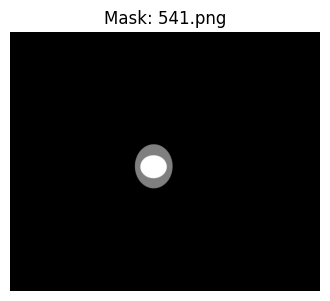

🖼️ 542.png - Unique values: {np.uint8(0), np.uint8(1), np.uint8(2)}


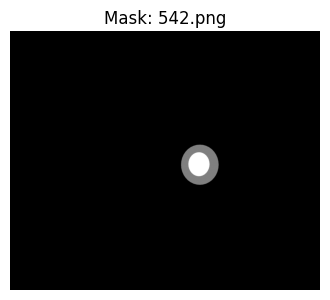

🖼️ 543.png - Unique values: {np.uint8(0), np.uint8(1), np.uint8(2)}


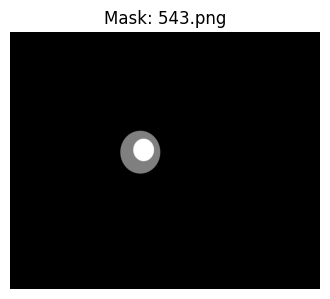

🖼️ 544.png - Unique values: {np.uint8(0), np.uint8(1), np.uint8(2)}


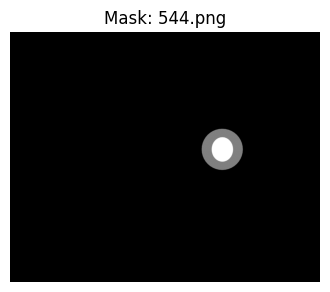

🖼️ 545.png - Unique values: {np.uint8(0), np.uint8(1), np.uint8(2)}


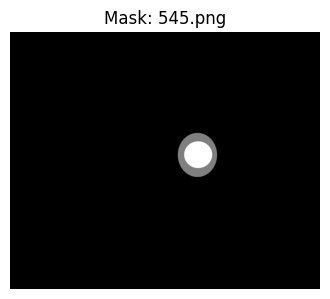

🖼️ 546.png - Unique values: {np.uint8(0), np.uint8(1), np.uint8(2)}


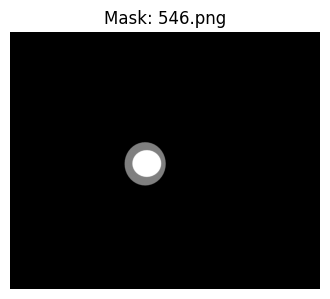

🖼️ 547.png - Unique values: {np.uint8(0), np.uint8(1), np.uint8(2)}


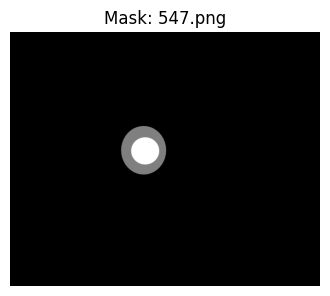

🖼️ 548.png - Unique values: {np.uint8(0), np.uint8(1), np.uint8(2)}


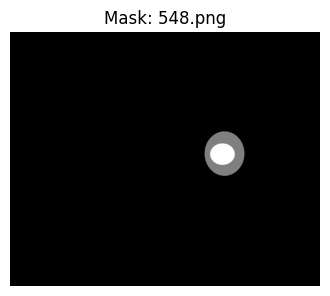

🖼️ 549.png - Unique values: {np.uint8(0), np.uint8(1), np.uint8(2)}


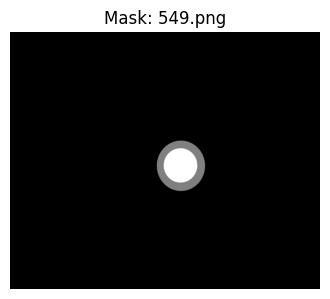

🖼️ 550.png - Unique values: {np.uint8(0), np.uint8(1), np.uint8(2)}


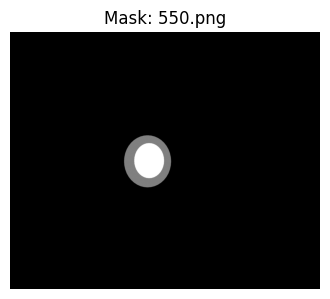

🖼️ 551.png - Unique values: {np.uint8(0), np.uint8(1), np.uint8(2)}


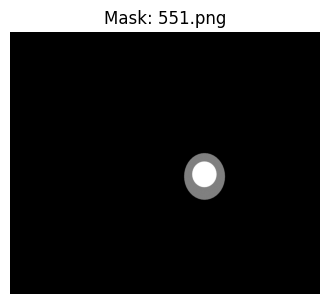

🖼️ 552.png - Unique values: {np.uint8(0), np.uint8(1), np.uint8(2)}


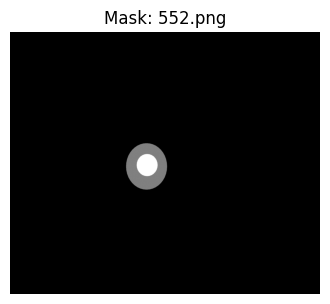

🖼️ 553.png - Unique values: {np.uint8(0), np.uint8(1), np.uint8(2)}


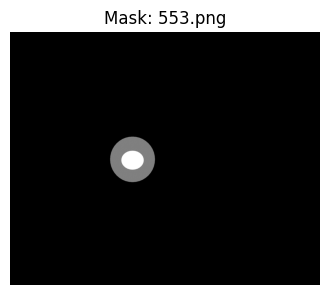

🖼️ 554.png - Unique values: {np.uint8(0), np.uint8(1), np.uint8(2)}


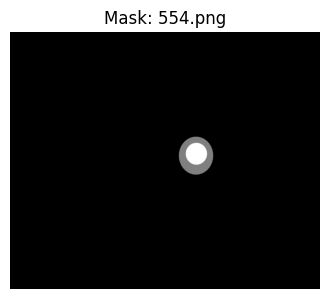

🖼️ 555.png - Unique values: {np.uint8(0), np.uint8(1), np.uint8(2)}


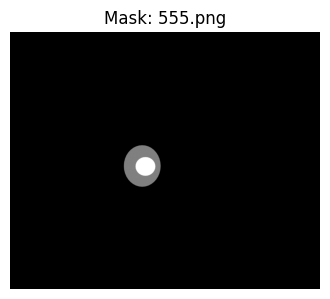

🖼️ 556.png - Unique values: {np.uint8(0), np.uint8(1), np.uint8(2)}


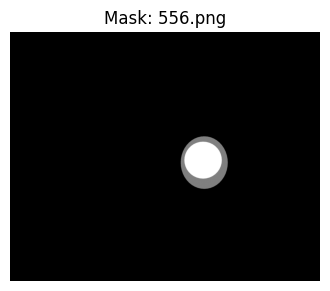

🖼️ 557.png - Unique values: {np.uint8(0), np.uint8(1), np.uint8(2)}


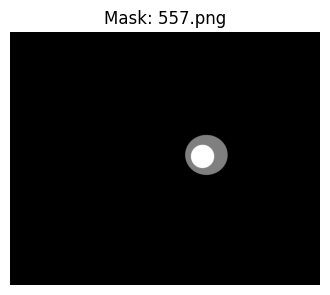

🖼️ 558.png - Unique values: {np.uint8(0), np.uint8(1), np.uint8(2)}


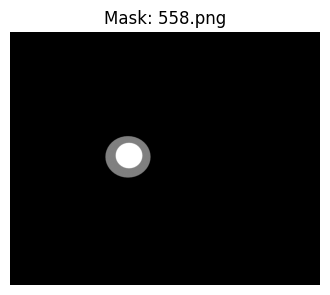

🖼️ 559.png - Unique values: {np.uint8(0), np.uint8(1), np.uint8(2)}


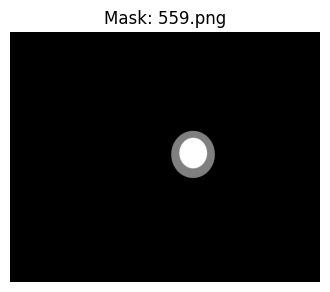

🖼️ 560.png - Unique values: {np.uint8(0), np.uint8(1), np.uint8(2)}


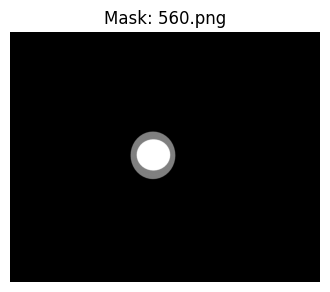

🖼️ 561.png - Unique values: {np.uint8(0), np.uint8(1), np.uint8(2)}


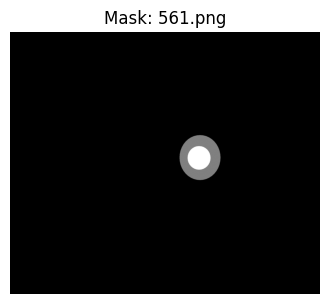

🖼️ 562.png - Unique values: {np.uint8(0), np.uint8(1), np.uint8(2)}


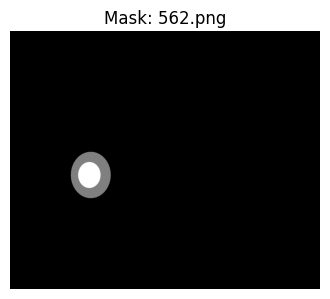

🖼️ 563.png - Unique values: {np.uint8(0), np.uint8(1), np.uint8(2)}


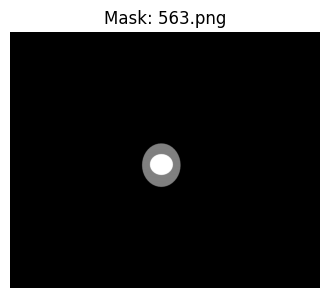

🖼️ 564.png - Unique values: {np.uint8(0), np.uint8(1), np.uint8(2)}


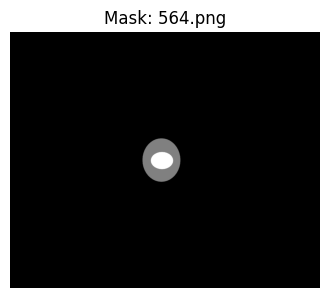

🖼️ 565.png - Unique values: {np.uint8(0), np.uint8(1), np.uint8(2)}


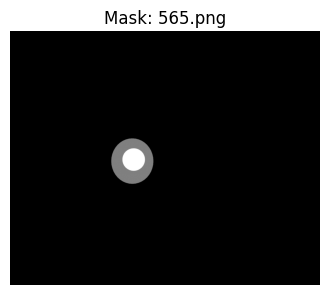

🖼️ 566.png - Unique values: {np.uint8(0), np.uint8(1), np.uint8(2)}


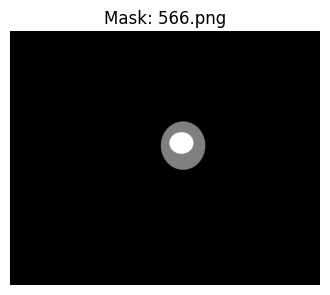

🖼️ 567.png - Unique values: {np.uint8(0), np.uint8(1), np.uint8(2)}


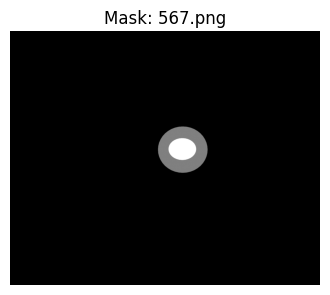

🖼️ 568.png - Unique values: {np.uint8(0), np.uint8(1), np.uint8(2)}


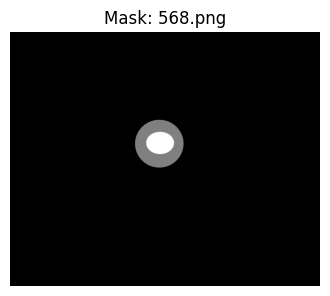

🖼️ 569.png - Unique values: {np.uint8(0), np.uint8(1), np.uint8(2)}


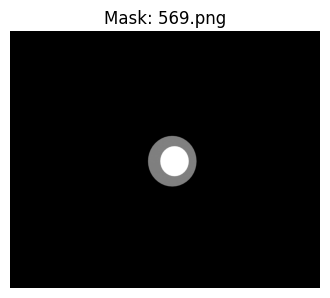

🖼️ 570.png - Unique values: {np.uint8(0), np.uint8(1), np.uint8(2)}


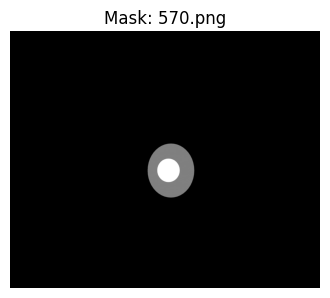

🖼️ 571.png - Unique values: {np.uint8(0), np.uint8(1), np.uint8(2)}


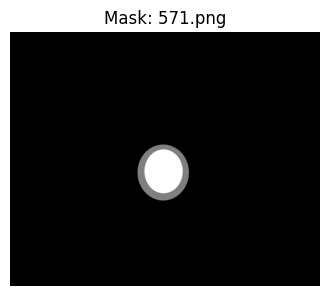

🖼️ 572.png - Unique values: {np.uint8(0), np.uint8(1), np.uint8(2)}


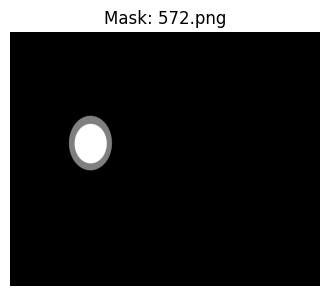

🖼️ 573.png - Unique values: {np.uint8(0), np.uint8(1), np.uint8(2)}


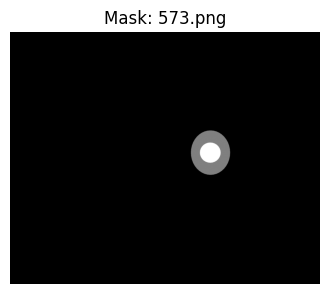

🖼️ 574.png - Unique values: {np.uint8(0), np.uint8(1), np.uint8(2)}


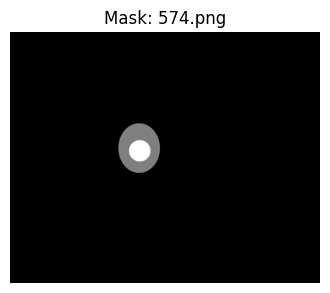

🖼️ 575.png - Unique values: {np.uint8(0), np.uint8(1), np.uint8(2)}


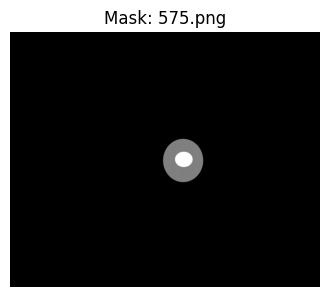

🖼️ 576.png - Unique values: {np.uint8(0), np.uint8(1), np.uint8(2)}


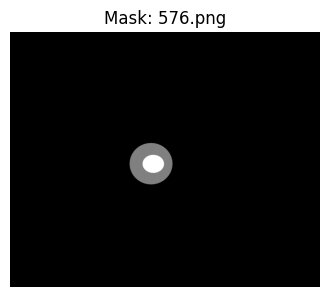

🖼️ 577.png - Unique values: {np.uint8(0), np.uint8(1), np.uint8(2)}


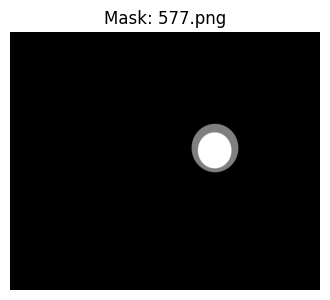

🖼️ 578.png - Unique values: {np.uint8(0), np.uint8(1), np.uint8(2)}


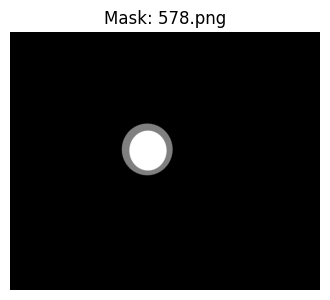

🖼️ 579.png - Unique values: {np.uint8(0), np.uint8(1), np.uint8(2)}


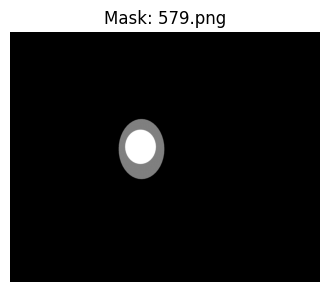

🖼️ 580.png - Unique values: {np.uint8(0), np.uint8(1), np.uint8(2)}


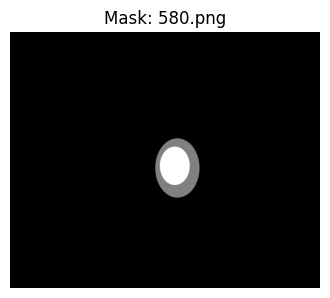

🖼️ 581.png - Unique values: {np.uint8(0), np.uint8(1), np.uint8(2)}


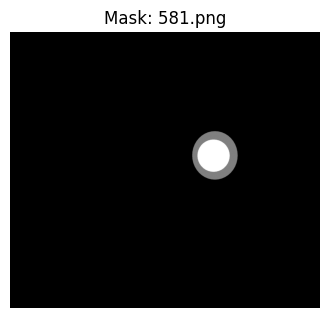

🖼️ 582.png - Unique values: {np.uint8(0), np.uint8(1), np.uint8(2)}


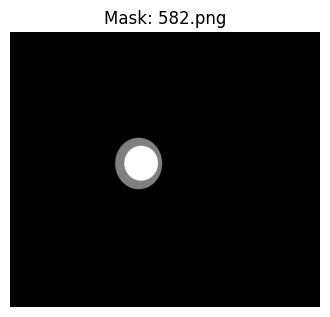

🖼️ 583.png - Unique values: {np.uint8(0), np.uint8(1), np.uint8(2)}


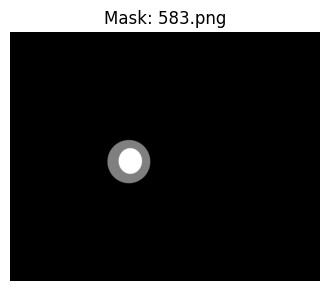

🖼️ 584.png - Unique values: {np.uint8(0), np.uint8(1), np.uint8(2)}


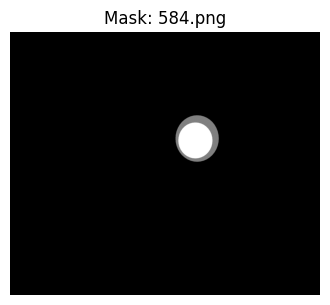

🖼️ 585.png - Unique values: {np.uint8(0), np.uint8(1), np.uint8(2)}


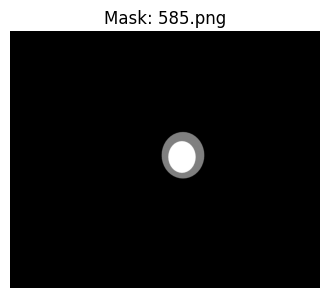

🖼️ 586.png - Unique values: {np.uint8(0), np.uint8(1), np.uint8(2)}


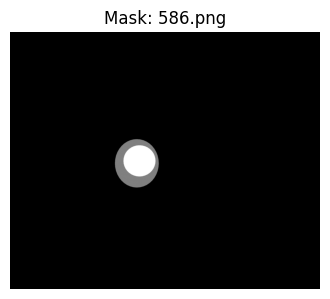

🖼️ 587.png - Unique values: {np.uint8(0), np.uint8(1), np.uint8(2)}


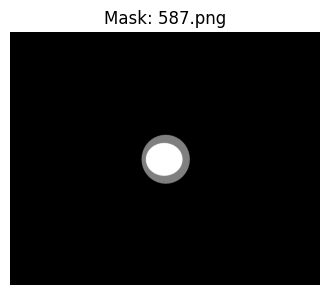

🖼️ 588.png - Unique values: {np.uint8(0), np.uint8(1), np.uint8(2)}


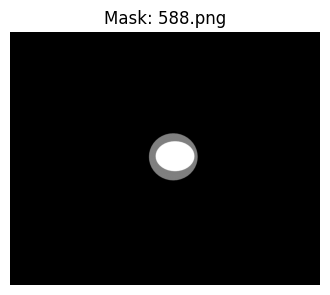

🖼️ 589.png - Unique values: {np.uint8(0), np.uint8(1), np.uint8(2)}


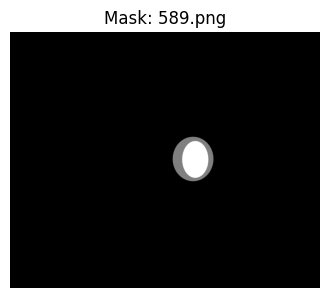

🖼️ 590.png - Unique values: {np.uint8(0), np.uint8(1), np.uint8(2)}


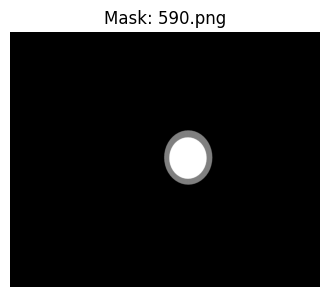

🖼️ 591.png - Unique values: {np.uint8(0), np.uint8(1), np.uint8(2)}


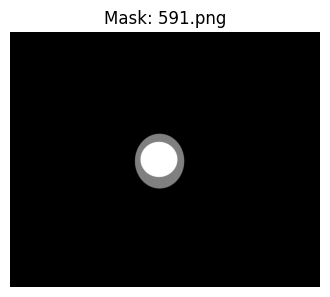

🖼️ 592.png - Unique values: {np.uint8(0), np.uint8(1), np.uint8(2)}


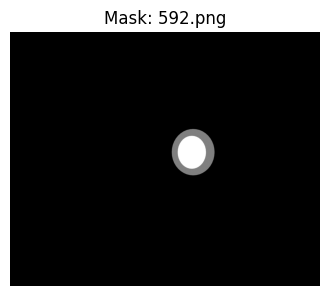

🖼️ 593.png - Unique values: {np.uint8(0), np.uint8(1), np.uint8(2)}


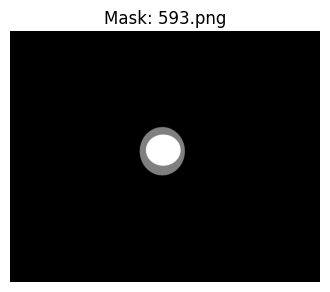

🖼️ 594.png - Unique values: {np.uint8(0), np.uint8(1), np.uint8(2)}


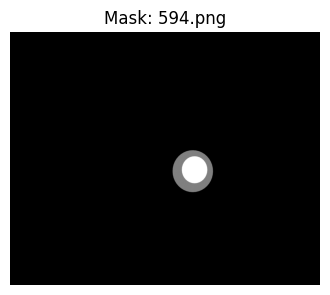

🖼️ 595.png - Unique values: {np.uint8(0), np.uint8(1), np.uint8(2)}


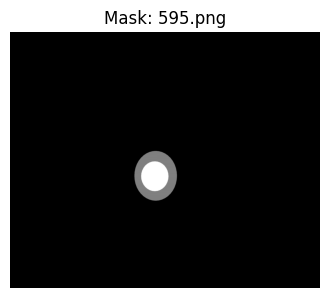

🖼️ 596.png - Unique values: {np.uint8(0), np.uint8(1), np.uint8(2)}


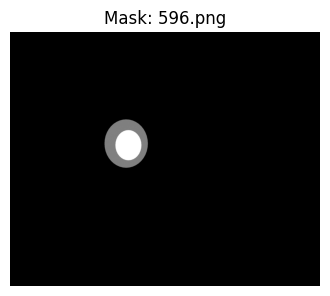

🖼️ 597.png - Unique values: {np.uint8(0), np.uint8(1), np.uint8(2)}


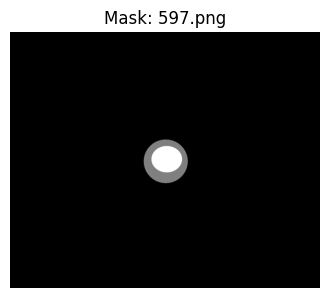

🖼️ 598.png - Unique values: {np.uint8(0), np.uint8(1), np.uint8(2)}


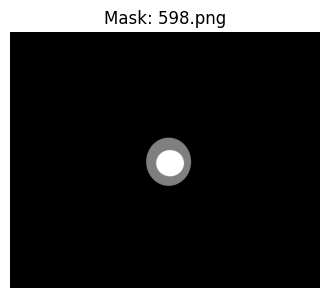

🖼️ 599.png - Unique values: {np.uint8(0), np.uint8(1), np.uint8(2)}


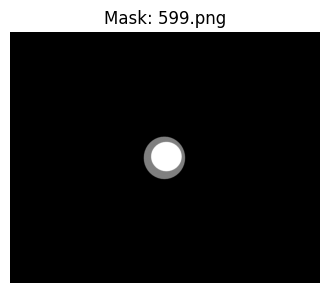

🖼️ 600.png - Unique values: {np.uint8(0), np.uint8(1), np.uint8(2)}


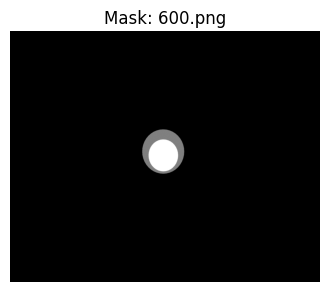

🖼️ 601.png - Unique values: {np.uint8(0), np.uint8(1), np.uint8(2)}


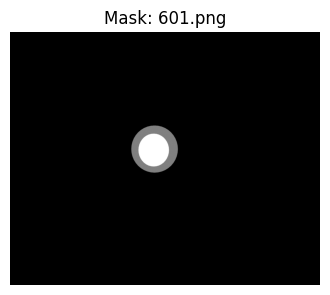

🖼️ 602.png - Unique values: {np.uint8(0), np.uint8(1), np.uint8(2)}


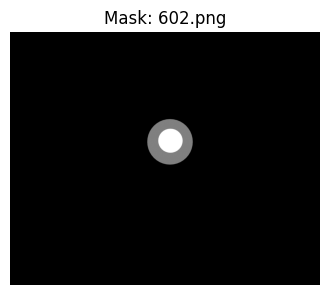

🖼️ 603.png - Unique values: {np.uint8(0), np.uint8(1), np.uint8(2)}


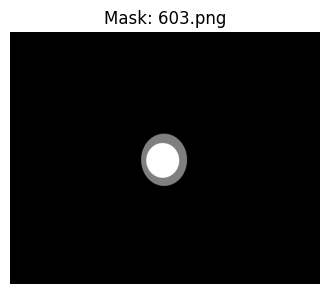

🖼️ 604.png - Unique values: {np.uint8(0), np.uint8(1), np.uint8(2)}


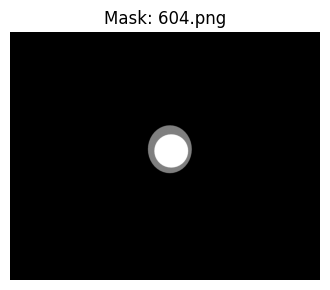

🖼️ 605.png - Unique values: {np.uint8(0), np.uint8(1), np.uint8(2)}


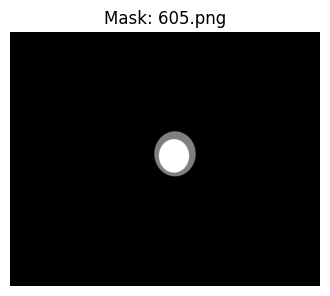

🖼️ 606.png - Unique values: {np.uint8(0), np.uint8(1), np.uint8(2)}


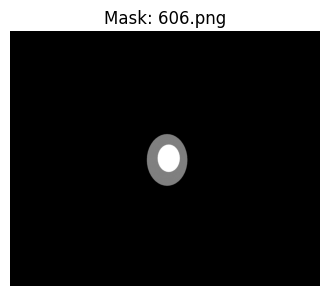

🖼️ 607.png - Unique values: {np.uint8(0), np.uint8(1), np.uint8(2)}


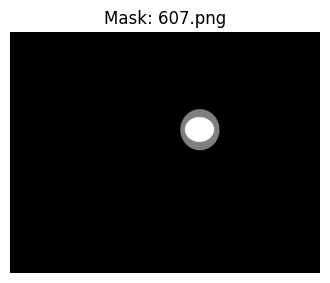

🖼️ 608.png - Unique values: {np.uint8(0), np.uint8(1), np.uint8(2)}


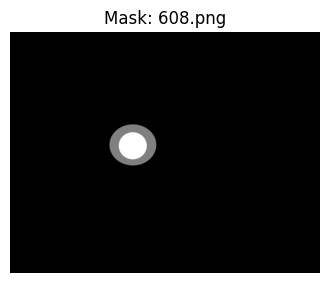

🖼️ 609.png - Unique values: {np.uint8(0), np.uint8(1), np.uint8(2)}


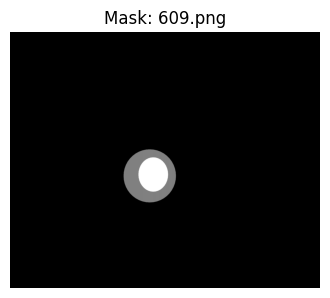

🖼️ 610.png - Unique values: {np.uint8(0), np.uint8(1), np.uint8(2)}


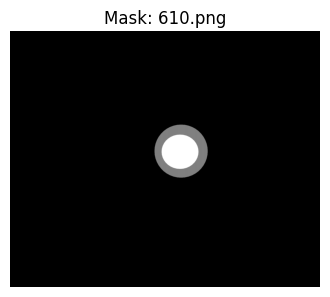

🖼️ 611.png - Unique values: {np.uint8(0), np.uint8(1), np.uint8(2)}


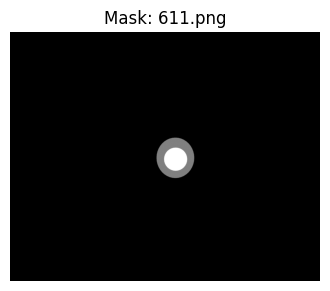

🖼️ 612.png - Unique values: {np.uint8(0), np.uint8(1), np.uint8(2)}


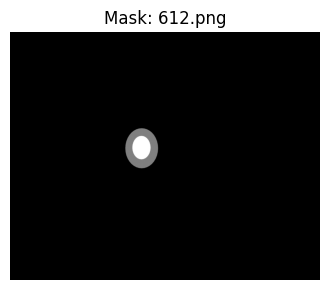

🖼️ 613.png - Unique values: {np.uint8(0), np.uint8(1), np.uint8(2)}


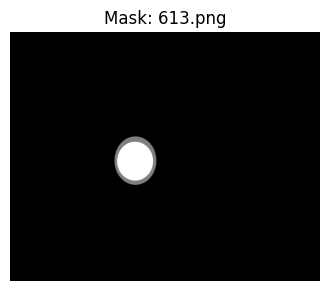

🖼️ 614.png - Unique values: {np.uint8(0), np.uint8(1), np.uint8(2)}


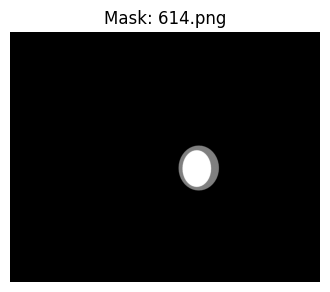

🖼️ 615.png - Unique values: {np.uint8(0), np.uint8(1), np.uint8(2)}


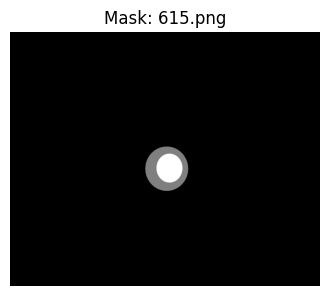

🖼️ 616.png - Unique values: {np.uint8(0), np.uint8(1), np.uint8(2)}


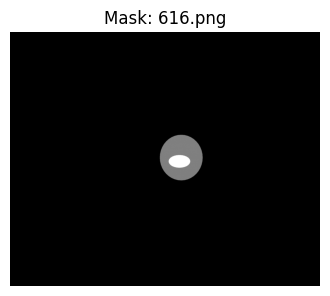

🖼️ 617.png - Unique values: {np.uint8(0), np.uint8(1), np.uint8(2)}


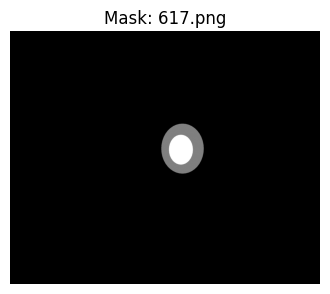

🖼️ 618.png - Unique values: {np.uint8(0), np.uint8(1), np.uint8(2)}


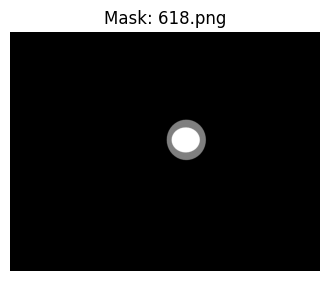

🖼️ 619.png - Unique values: {np.uint8(0), np.uint8(1), np.uint8(2)}


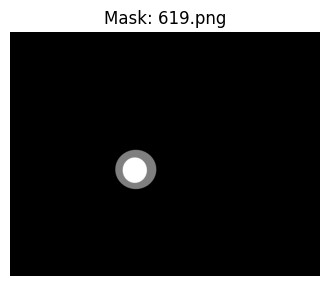

🖼️ 620.png - Unique values: {np.uint8(0), np.uint8(1), np.uint8(2)}


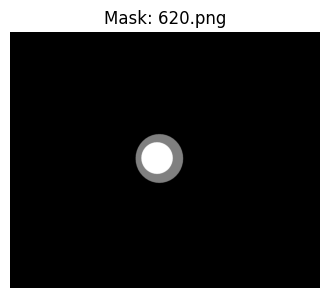

🖼️ 621.png - Unique values: {np.uint8(0), np.uint8(1), np.uint8(2)}


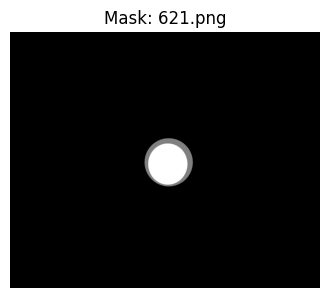

🖼️ 622.png - Unique values: {np.uint8(0), np.uint8(1), np.uint8(2)}


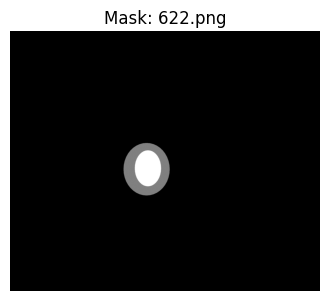

🖼️ 623.png - Unique values: {np.uint8(0), np.uint8(1), np.uint8(2)}


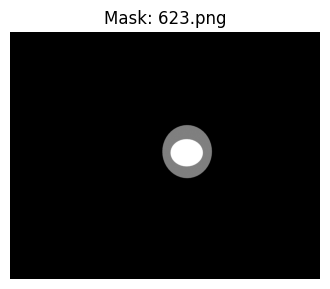

🖼️ 624.png - Unique values: {np.uint8(0), np.uint8(1), np.uint8(2)}


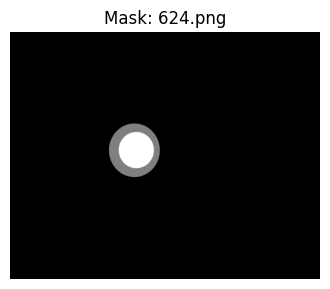

🖼️ 625.png - Unique values: {np.uint8(0), np.uint8(1), np.uint8(2)}


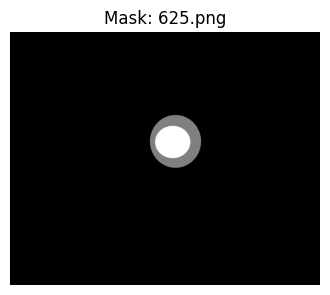

🖼️ 626.png - Unique values: {np.uint8(0), np.uint8(1), np.uint8(2)}


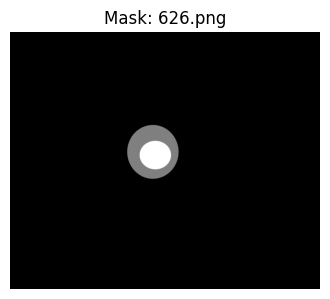

🖼️ 627.png - Unique values: {np.uint8(0), np.uint8(1), np.uint8(2)}


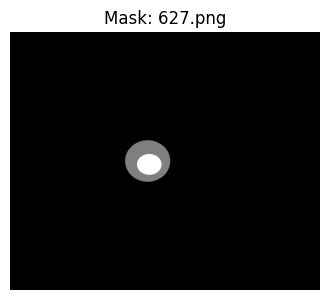

🖼️ 628.png - Unique values: {np.uint8(0), np.uint8(1), np.uint8(2)}


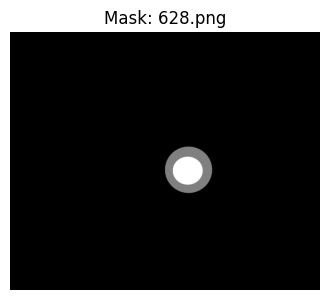

🖼️ 629.png - Unique values: {np.uint8(0), np.uint8(1), np.uint8(2)}


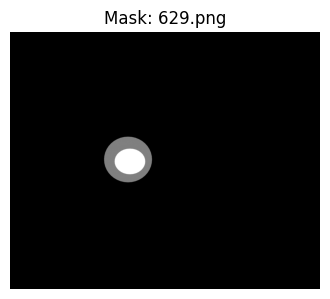

🖼️ 630.png - Unique values: {np.uint8(0), np.uint8(1), np.uint8(2)}


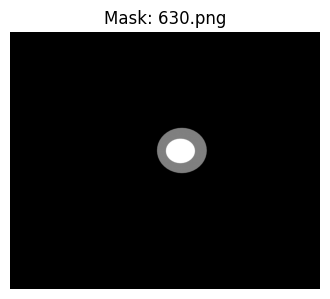

🖼️ 631.png - Unique values: {np.uint8(0), np.uint8(1), np.uint8(2)}


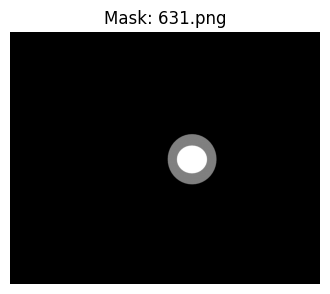

🖼️ 632.png - Unique values: {np.uint8(0), np.uint8(1), np.uint8(2)}


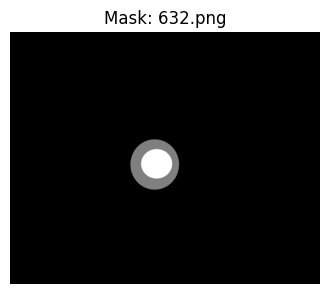

🖼️ 633.png - Unique values: {np.uint8(0), np.uint8(1), np.uint8(2)}


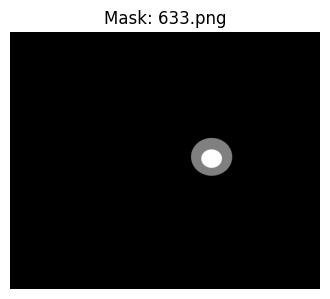

🖼️ 634.png - Unique values: {np.uint8(0), np.uint8(1), np.uint8(2)}


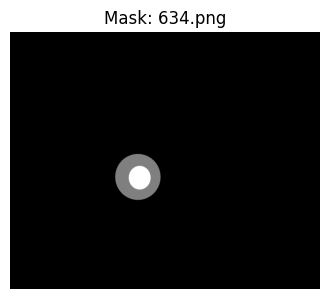

🖼️ 635.png - Unique values: {np.uint8(0), np.uint8(1), np.uint8(2)}


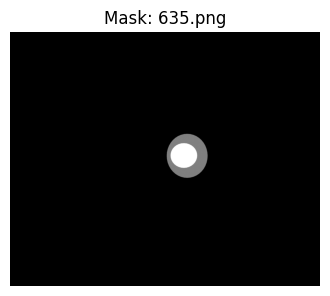

🖼️ 636.png - Unique values: {np.uint8(0), np.uint8(1), np.uint8(2)}


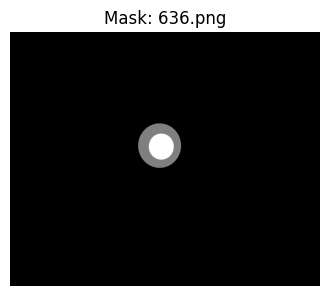

🖼️ 637.png - Unique values: {np.uint8(0), np.uint8(1), np.uint8(2)}


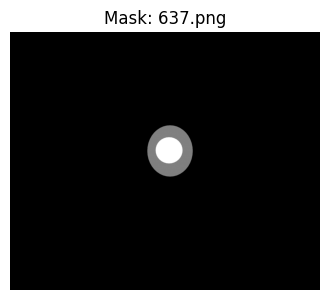

🖼️ 638.png - Unique values: {np.uint8(0), np.uint8(1), np.uint8(2)}


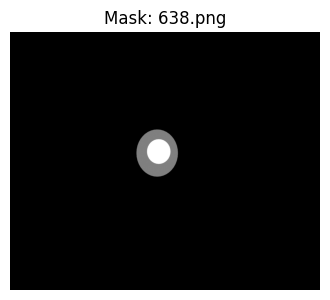

🖼️ 639.png - Unique values: {np.uint8(0), np.uint8(1), np.uint8(2)}


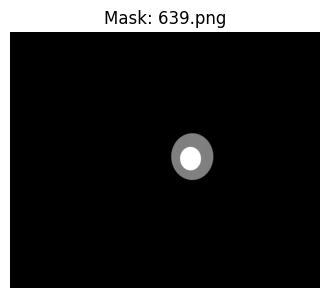

🖼️ 640.png - Unique values: {np.uint8(0), np.uint8(1), np.uint8(2)}


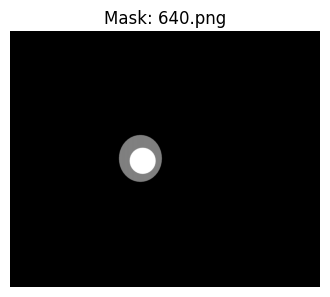

🖼️ 641.png - Unique values: {np.uint8(0), np.uint8(1), np.uint8(2)}


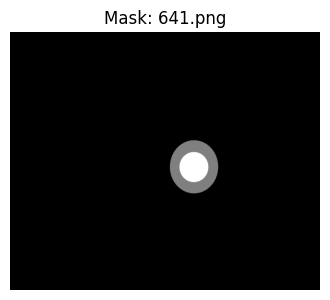

🖼️ 642.png - Unique values: {np.uint8(0), np.uint8(1), np.uint8(2)}


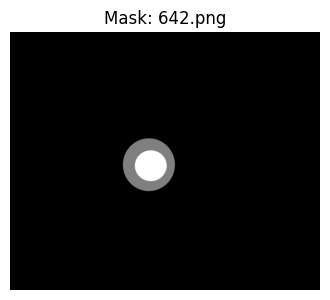

🖼️ 643.png - Unique values: {np.uint8(0), np.uint8(1), np.uint8(2)}


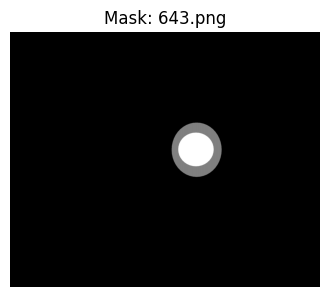

🖼️ 644.png - Unique values: {np.uint8(0), np.uint8(1), np.uint8(2)}


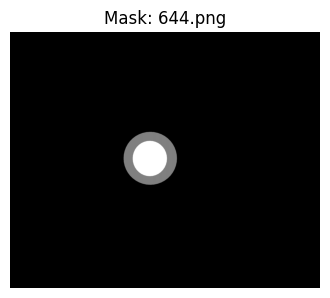

🖼️ 645.png - Unique values: {np.uint8(0), np.uint8(1), np.uint8(2)}


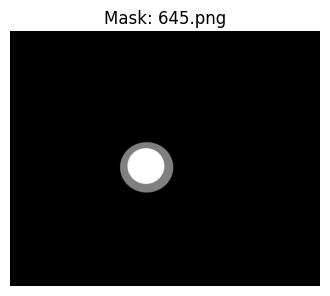

🖼️ 646.png - Unique values: {np.uint8(0), np.uint8(1), np.uint8(2)}


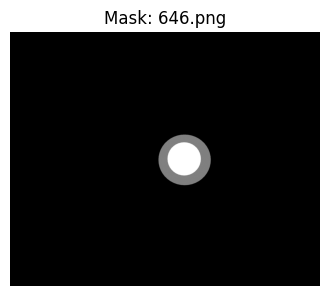

🖼️ 647.png - Unique values: {np.uint8(0), np.uint8(1), np.uint8(2)}


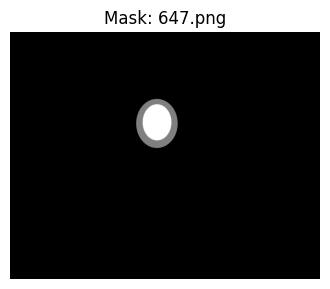

🖼️ 648.png - Unique values: {np.uint8(0), np.uint8(1), np.uint8(2)}


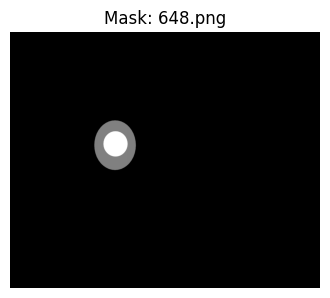

🖼️ 649.png - Unique values: {np.uint8(0), np.uint8(1), np.uint8(2)}


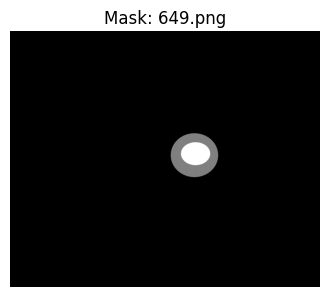

🖼️ 650.png - Unique values: {np.uint8(0), np.uint8(1), np.uint8(2)}


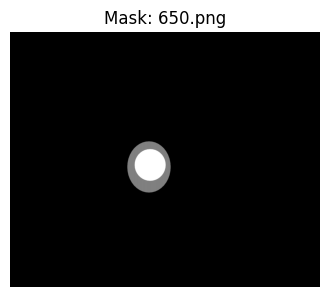

In [42]:
import cv2
import matplotlib.pyplot as plt
import os
import glob

# Define the directory containing mask images
mask_dir = "D:/ProjectML2 - Glaucoma/Dataset/ORIGA/masks/"  # Change this to your actual directory

# Get all mask file paths (assuming they are PNGs)
mask_paths = glob.glob(os.path.join(mask_dir, "*.png"))

# Check if masks are found
if not mask_paths:
    print(f"❌ No mask images found in {mask_dir}")
else:
    print(f"✅ Found {len(mask_paths)} mask images!")

    # Process each mask
    for mask_path in mask_paths:
        # Load mask
        mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)

        # Check if OpenCV loaded the image correctly
        if mask is None:
            print(f"❌ Failed to load {mask_path}")
            continue

        # Check unique values in the mask
        unique_values = set(mask.flatten())
        print(f"🖼️ {os.path.basename(mask_path)} - Unique values: {unique_values}")

        # Display the mask
        plt.figure(figsize=(4, 4))
        plt.imshow(mask, cmap="gray")
        plt.title(f"Mask: {os.path.basename(mask_path)}")
        plt.axis("off")
        plt.show()


✅ Successfully loaded D:/ProjectML2 - Glaucoma/Dataset/ORIGA/masks/001.png
Unique values in mask: [0 1 2]


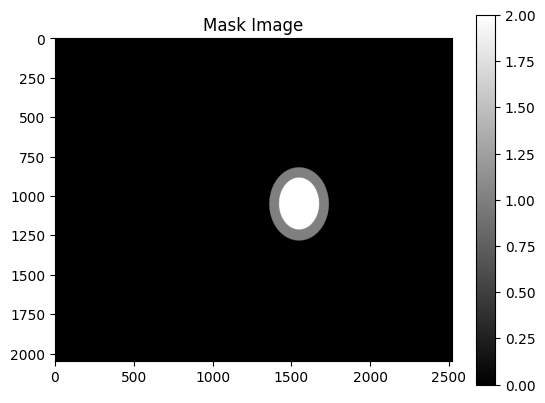

In [44]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import os

# Load one mask for debugging
mask_path = "D:/ProjectML2 - Glaucoma/Dataset/ORIGA/masks/001.png"  # Change to any specific mask file

mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)

# Check if the image is loaded
if mask is None:
    print(f"❌ Failed to load {mask_path}")
else:
    print(f"✅ Successfully loaded {mask_path}")

# Check unique values in the mask
unique_values = np.unique(mask)
print("Unique values in mask:", unique_values)

# Display the mask
plt.imshow(mask, cmap="gray")
plt.title("Mask Image")
plt.colorbar()
plt.show()


In [45]:
import cv2
import numpy as np
import pandas as pd
import os
import glob

# Define the directory containing masks
mask_dir = "D:/ProjectML2 - Glaucoma/Dataset/ORIGA/masks/"  # Change this path

# Get all mask file paths
mask_paths = glob.glob(os.path.join(mask_dir, "*.png"))

# Initialize storage for extracted features
data = []

# Process each mask
for mask_path in mask_paths:
    # Load mask
    mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)

    if mask is None:
        print(f"❌ Failed to load {mask_path}")
        continue

    # Extract cup and disc regions
    disc_mask = np.uint8(mask == 1) * 255  # Convert disc pixels to 255
    cup_mask = np.uint8(mask == 2) * 255   # Convert cup pixels to 255

    # Find contours for disc
    disc_contours, _ = cv2.findContours(disc_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    cup_contours, _ = cv2.findContours(cup_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    if len(disc_contours) == 0 or len(cup_contours) == 0:
        print(f"⚠️ Warning: No valid disc or cup detected in {mask_path}. Skipping...")
        continue

    # Get the largest contours
    disc_contour = max(disc_contours, key=cv2.contourArea)
    cup_contour = max(cup_contours, key=cv2.contourArea)

    # Compute areas
    disc_area = cv2.contourArea(disc_contour)
    cup_area = cv2.contourArea(cup_contour)

    # Compute Cup-to-Disc Ratio (CDR)
    cdr = cup_area / disc_area if disc_area > 0 else 0

    # Store data
    filename = os.path.basename(mask_path)
    data.append([filename, cup_area, disc_area, cdr])

# Convert to DataFrame
df = pd.DataFrame(data, columns=["Filename", "Cup Area", "Disc Area", "CDR"])

# Save to CSV
output_path = "D:/ProjectML2 - Glaucoma/Dataset/ORIGA/cdr_values.csv"
df.to_csv(output_path, index=False)

print(f"✅ CDR values computed and saved successfully to {output_path}!")


✅ CDR values computed and saved successfully to D:/ProjectML2 - Glaucoma/Dataset/ORIGA/cdr_values.csv!


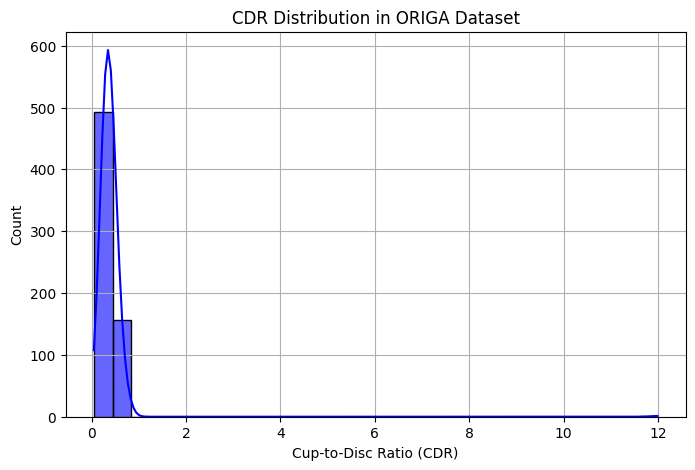

In [46]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load the computed CDR values CSV file
cdr_csv_path = "D:/ProjectML2 - Glaucoma/Dataset/ORIGA/cdr_values.csv"

# Read the CSV file
df_cdr = pd.read_csv(cdr_csv_path)

# Plot histogram to visualize CDR distribution
plt.figure(figsize=(8, 5))
sns.histplot(df_cdr["CDR"], bins=30, kde=True, color="blue", alpha=0.6)
plt.xlabel("Cup-to-Disc Ratio (CDR)")
plt.ylabel("Count")
plt.title("CDR Distribution in ORIGA Dataset")
plt.grid(True)
plt.show()


In [47]:
# Compute basic statistics of CDR values
cdr_stats = df_cdr["CDR"].describe()

# Print the statistics
print("CDR Statistics:\n", cdr_stats)


CDR Statistics:
 count    650.000000
mean       0.382885
std        0.472097
min        0.044594
25%        0.277276
50%        0.351741
75%        0.438091
max       11.988069
Name: CDR, dtype: float64


In [49]:
# Identify images with CDR > 1 (potential errors)
outliers = df_cdr[df_cdr["CDR"] > 1]

# Print the filenames of outliers
print("⚠️ Outliers detected (CDR > 1):\n", outliers)


⚠️ Outliers detected (CDR > 1):
   Filename  Cup Area  Disc Area        CDR
2  003.png  112532.0     9387.0  11.988069


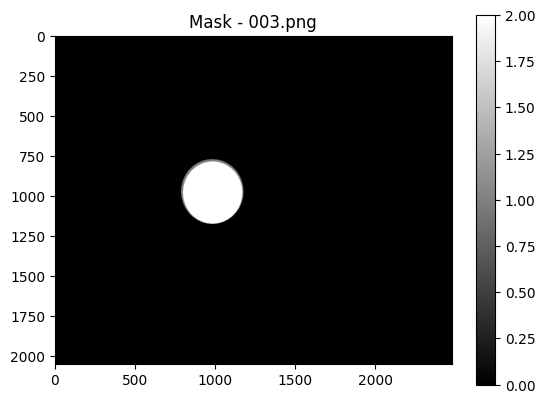

In [50]:
import cv2
import matplotlib.pyplot as plt

# Load the suspected mask
mask_path = "D:/ProjectML2 - Glaucoma/Dataset/ORIGA/masks/003.png"
mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)

# Show the mask
plt.imshow(mask, cmap="gray")
plt.title("Mask - 003.png")
plt.colorbar()
plt.show()


In [51]:
import numpy as np

# Get unique values in the mask
unique_values = np.unique(mask)
print("Unique values in 003.png:", unique_values)


Unique values in 003.png: [0 1 2]


In [52]:
# Swap labels (if needed)
mask_fixed = np.where(mask == 1, 2, mask)
mask_fixed = np.where(mask == 2, 1, mask_fixed)

# Save corrected mask
cv2.imwrite("D:/ProjectML2 - Glaucoma/Dataset/ORIGA/masks_fixed/003.png", mask_fixed)
print("✅ Fixed mask saved!")


✅ Fixed mask saved!


In [53]:
import cv2
import numpy as np
import pandas as pd
import os
import glob
import matplotlib.pyplot as plt

# Define the directory containing masks
mask_dir = "D:/ProjectML2 - Glaucoma/Dataset/ORIGA/masks/"
fixed_mask_dir = "D:/ProjectML2 - Glaucoma/Dataset/ORIGA/masks_fixed/"  # Store corrected masks
os.makedirs(fixed_mask_dir, exist_ok=True)

# Get all mask file paths
mask_paths = glob.glob(os.path.join(mask_dir, "*.png"))

# Initialize storage for extracted features
data = []

# Process each mask
for mask_path in mask_paths:
    filename = os.path.basename(mask_path)

    # Load mask
    mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)

    if mask is None:
        print(f"❌ Failed to load {filename}")
        continue

    # Get unique values in the mask
    unique_values = np.unique(mask)
    
    # Expected unique values: [0, 1, 2] (background, disc, cup)
    if set(unique_values) != {0, 1, 2}:
        print(f"⚠️ Warning: Unexpected labels {unique_values} in {filename}. Skipping...")
        continue  # Skip corrupted masks

    # Threshold to get binary regions
    cup_mask = (mask == 2).astype(np.uint8)
    disc_mask = (mask >= 1).astype(np.uint8)  # Both cup & disc will be part of this

    # Find contours
    cup_contours, _ = cv2.findContours(cup_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    disc_contours, _ = cv2.findContours(disc_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    if len(cup_contours) == 0 or len(disc_contours) == 0:
        print(f"⚠️ Warning: Missing contours in {filename}. Skipping...")
        continue

    # Get largest contour for each region
    cup_area = max([cv2.contourArea(cnt) for cnt in cup_contours], default=0)
    disc_area = max([cv2.contourArea(cnt) for cnt in disc_contours], default=0)

    # Compute Cup-to-Disc Ratio (CDR)
    cdr = cup_area / disc_area if disc_area > 0 else 0

    # Check for outliers (CDR > 1)
    if cdr > 1:
        print(f"🚨 Outlier detected in {filename} (CDR = {cdr:.3f}). Attempting to fix...")

        # Auto-correct labels (swap 1 and 2)
        mask_fixed = np.where(mask == 1, 2, mask)
        mask_fixed = np.where(mask == 2, 1, mask_fixed)

        # Save corrected mask
        cv2.imwrite(os.path.join(fixed_mask_dir, filename), mask_fixed)

        # Recompute with fixed mask
        cup_mask = (mask_fixed == 2).astype(np.uint8)
        disc_mask = (mask_fixed >= 1).astype(np.uint8)

        cup_contours, _ = cv2.findContours(cup_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        disc_contours, _ = cv2.findContours(disc_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

        cup_area = max([cv2.contourArea(cnt) for cnt in cup_contours], default=0)
        disc_area = max([cv2.contourArea(cnt) for cnt in disc_contours], default=0)
        cdr = cup_area / disc_area if disc_area > 0 else 0

        print(f"✅ Fixed CDR for {filename}: {cdr:.3f}")

    # Store data
    data.append([filename, cup_area, disc_area, cdr])

# Convert to DataFrame
df_cdr = pd.DataFrame(data, columns=["Filename", "Cup Area", "Disc Area", "CDR"])

# Save to CSV
output_path = "D:/ProjectML2 - Glaucoma/Dataset/ORIGA/cdr_values_fixed.csv"
df_cdr.to_csv(output_path, index=False)

print(f"✅ CDR values computed and saved successfully to {output_path}!")


✅ CDR values computed and saved successfully to D:/ProjectML2 - Glaucoma/Dataset/ORIGA/cdr_values_fixed.csv!


In [55]:
import pandas as pd

# Load the datasets
cdr_df = pd.read_csv("D:/ProjectML2 - Glaucoma/Dataset/ORIGA/cdr_values_fixed.csv")
origa_list_df = pd.read_csv("D:/ProjectML2 - Glaucoma/Dataset/ORIGA/OrigaList.csv")

# Convert filenames to match formats (remove extensions for merging)
cdr_df["Filename"] = cdr_df["Filename"].str.replace(".png", "", regex=True)
origa_list_df["Filename"] = origa_list_df["Filename"].str.replace(".jpg", "", regex=True)

# Merge datasets on Filename
merged_df = origa_list_df.merge(cdr_df, on="Filename", how="left")

# Save merged dataset
merged_df.to_csv("D:/ProjectML2 - Glaucoma/Dataset/ORIGA/origa_final.csv", index=False)

print("✅ Merged dataset saved successfully as origa_final.csv!")


✅ Merged dataset saved successfully as origa_final.csv!


In [56]:
import pandas as pd

# Load the merged dataset
df = pd.read_csv("D:/ProjectML2 - Glaucoma/Dataset/ORIGA/origa_final.csv")

# Check for missing values
print(df.isnull().sum())

# Display basic statistics of CDR values
print(df["CDR"].describe())

# Check unique glaucoma labels
print("Glaucoma Labels:", df["Glaucoma"].unique())


Eye          0
Filename     0
ExpCDR       0
Set          0
Glaucoma     0
Cup Area     0
Disc Area    0
CDR          0
dtype: int64
count    650.000000
mean       0.365849
std        0.124506
min        0.044594
25%        0.277276
50%        0.351741
75%        0.438091
max        0.914998
Name: CDR, dtype: float64
Glaucoma Labels: [0 1]


In [57]:
from sklearn.preprocessing import MinMaxScaler
import pandas as pd

# Load dataset
df = pd.read_csv("D:/ProjectML2 - Glaucoma/Dataset/ORIGA/origa_final.csv")

# Initialize scaler
scaler = MinMaxScaler()

# Normalize CDR column
df["CDR_Norm"] = scaler.fit_transform(df[["CDR"]])

# Save the updated dataset
df.to_csv("D:/ProjectML2 - Glaucoma/Dataset/ORIGA/origa_final_normalized.csv", index=False)

print("✅ CDR normalized and saved successfully!")


✅ CDR normalized and saved successfully!


In [59]:
# Check the column names in the dataset
print(df.columns)


Index(['Eye', 'Filename', 'ExpCDR', 'Set', 'Glaucoma', 'Cup Area', 'Disc Area',
       'CDR'],
      dtype='object')


In [60]:
# Normalize the CDR column
df['CDR_Norm'] = (df['CDR'] - df['CDR'].min()) / (df['CDR'].max() - df['CDR'].min())

# Check the result
print(df[['CDR', 'CDR_Norm']].head())


        CDR  CDR_Norm
0  0.475576  0.495151
1  0.494058  0.516386
2  0.914998  1.000000
3  0.516107  0.541717
4  0.451586  0.467590


In [61]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score

# Features and labels
X_image = df['Filename'].values  # assuming you use image filenames
X_cdr = df[['CDR_Norm']].values  # normalized CDR values
y = df['Glaucoma'].values  # Glaucoma labels (0 or 1)

# Split data into train and test
X_train, X_test, y_train, y_test = train_test_split(X_cdr, y, test_size=0.2, random_state=42)

# Train a Random Forest model
model = RandomForestClassifier(random_state=42)
model.fit(X_train, y_train)

# Predict on the test set
y_pred = model.predict(X_test)

# Evaluate the model
print("Accuracy Score:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))


Accuracy Score: 0.676923076923077

Classification Report:
               precision    recall  f1-score   support

           0       0.81      0.73      0.77        96
           1       0.41      0.53      0.46        34

    accuracy                           0.68       130
   macro avg       0.61      0.63      0.62       130
weighted avg       0.71      0.68      0.69       130



In [62]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

# Define the model
rf_model = RandomForestClassifier(random_state=42)

# Define parameter grid for tuning
param_grid = {
    'n_estimators': [100, 200, 300],  # Number of trees
    'max_depth': [None, 10, 20, 30],  # Maximum depth of each tree
    'min_samples_split': [2, 5, 10],  # Minimum number of samples required to split an internal node
    'min_samples_leaf': [1, 2, 4],  # Minimum number of samples required to be at a leaf node
    'bootstrap': [True, False]  # Whether to use bootstrap sampling
}

# GridSearchCV to tune hyperparameters
grid_search = GridSearchCV(estimator=rf_model, param_grid=param_grid, cv=5, verbose=2, n_jobs=-1)

# Fit the model
grid_search.fit(X_train, y_train)

# Print the best parameters
print(f"Best Parameters: {grid_search.best_params_}")

# Get the best estimator
best_rf_model = grid_search.best_estimator_

# Evaluate the tuned model
y_pred_tuned = best_rf_model.predict(X_test)

# Evaluate accuracy and classification report
print(f"Tuned Accuracy: {accuracy_score(y_test, y_pred_tuned)}")
print("Tuned Classification Report:")
print(classification_report(y_test, y_pred_tuned))


Fitting 5 folds for each of 216 candidates, totalling 1080 fits
Best Parameters: {'bootstrap': True, 'max_depth': None, 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 100}
Tuned Accuracy: 0.7076923076923077
Tuned Classification Report:
              precision    recall  f1-score   support

           0       0.80      0.80      0.80        96
           1       0.44      0.44      0.44        34

    accuracy                           0.71       130
   macro avg       0.62      0.62      0.62       130
weighted avg       0.71      0.71      0.71       130



In [63]:
from imblearn.over_sampling import SMOTE

# Initialize SMOTE
smote = SMOTE(sampling_strategy='auto', random_state=42)

# Apply SMOTE to balance the data
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

# Train the model on the balanced dataset
rf_model_smote = RandomForestClassifier(random_state=42)
rf_model_smote.fit(X_train_smote, y_train_smote)

# Predict on the test set
y_pred_smote = rf_model_smote.predict(X_test)

# Evaluate accuracy and classification report
print(f"SMOTE Model Accuracy: {accuracy_score(y_test, y_pred_smote)}")
print("SMOTE Model Classification Report:")
print(classification_report(y_test, y_pred_smote))


SMOTE Model Accuracy: 0.6
SMOTE Model Classification Report:
              precision    recall  f1-score   support

           0       0.80      0.61      0.69        96
           1       0.34      0.56      0.42        34

    accuracy                           0.60       130
   macro avg       0.57      0.59      0.56       130
weighted avg       0.68      0.60      0.62       130



In [64]:
# Assuming 'df' contains the merged dataset with CDR
# Split features and labels
X = df[['CDR_Norm']]  # Add more features if needed (e.g., image features)
y = df['Glaucoma']

# Split data into train and test
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train a classifier
rf_model_cdr = RandomForestClassifier(random_state=42)
rf_model_cdr.fit(X_train, y_train)

# Predict on the test set
y_pred_cdr = rf_model_cdr.predict(X_test)

# Evaluate the model
print(f"Model Accuracy with CDR: {accuracy_score(y_test, y_pred_cdr)}")
print("Model Classification Report with CDR:")
print(classification_report(y_test, y_pred_cdr))


Model Accuracy with CDR: 0.676923076923077
Model Classification Report with CDR:
              precision    recall  f1-score   support

           0       0.81      0.73      0.77        96
           1       0.41      0.53      0.46        34

    accuracy                           0.68       130
   macro avg       0.61      0.63      0.62       130
weighted avg       0.71      0.68      0.69       130



In [65]:
from xgboost import XGBClassifier

# Train XGBoost model
xgb_model = XGBClassifier(random_state=42)
xgb_model.fit(X_train, y_train)

# Predict on the test set
y_pred_xgb = xgb_model.predict(X_test)

# Evaluate the model
print(f"XGBoost Model Accuracy: {accuracy_score(y_test, y_pred_xgb)}")
print("XGBoost Model Classification Report:")
print(classification_report(y_test, y_pred_xgb))


XGBoost Model Accuracy: 0.7307692307692307
XGBoost Model Classification Report:
              precision    recall  f1-score   support

           0       0.80      0.84      0.82        96
           1       0.48      0.41      0.44        34

    accuracy                           0.73       130
   macro avg       0.64      0.63      0.63       130
weighted avg       0.72      0.73      0.72       130



In [66]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import make_scorer, f1_score

# Define the model and parameter grid for Random Forest
rf_model = RandomForestClassifier(random_state=42, class_weight='balanced')
param_grid_rf = {
    'n_estimators': [100, 200, 300, 400],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'bootstrap': [True, False]
}

# Use f1-score for the minority class (if you want to focus on Class 1, you can compute a custom scorer)
scorer = make_scorer(f1_score, pos_label=1)

rf_random = RandomizedSearchCV(estimator=rf_model, 
                               param_distributions=param_grid_rf, 
                               n_iter=50, cv=5, 
                               scoring=scorer, 
                               random_state=42, n_jobs=-1, verbose=2)

rf_random.fit(X_train, y_train)
print("Best RF Parameters:", rf_random.best_params_)


Fitting 5 folds for each of 50 candidates, totalling 250 fits
Best RF Parameters: {'n_estimators': 100, 'min_samples_split': 10, 'min_samples_leaf': 4, 'max_depth': 30, 'bootstrap': True}


In [67]:
from xgboost import XGBClassifier
from sklearn.model_selection import RandomizedSearchCV

xgb_model = XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='logloss')
param_grid_xgb = {
    'n_estimators': [50, 100, 200, 300],
    'max_depth': [3, 5, 7, 10],
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0]
}

xgb_random = RandomizedSearchCV(estimator=xgb_model,
                                param_distributions=param_grid_xgb,
                                n_iter=50, cv=5,
                                scoring=scorer,
                                random_state=42, n_jobs=-1, verbose=2)

xgb_random.fit(X_train, y_train)
print("Best XGBoost Parameters:", xgb_random.best_params_)


Fitting 5 folds for each of 50 candidates, totalling 250 fits
Best XGBoost Parameters: {'subsample': 0.8, 'n_estimators': 300, 'max_depth': 5, 'learning_rate': 0.1, 'colsample_bytree': 0.6}


D:\ProjectML2 - Glaucoma\pytorchGlaucoma\Lib\site-packages\xgboost\training.py:183: UserWarning: [03:40:31] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


In [68]:
from sklearn.ensemble import StackingClassifier
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier

# Define the best tuned models using your hyperparameters
best_rf = RandomForestClassifier(
    n_estimators=100, 
    min_samples_split=10, 
    min_samples_leaf=4, 
    max_depth=30, 
    bootstrap=True,
    random_state=42,
    class_weight='balanced'  # if needed to address imbalance
)

best_xgb = XGBClassifier(
    subsample=0.8,
    n_estimators=300,
    max_depth=5,
    learning_rate=0.1,
    colsample_bytree=0.6,
    random_state=42,
    use_label_encoder=False,
    eval_metric='logloss'
)

# Create a stacking ensemble using a Logistic Regression as the final estimator
estimators = [
    ('rf', best_rf),
    ('xgb', best_xgb)
]

stacking_model = StackingClassifier(
    estimators=estimators,
    final_estimator=LogisticRegression(max_iter=1000, random_state=42),
    cv=5,
    n_jobs=-1
)

# Assuming X_train and y_train are your feature matrix and target vector,
# e.g., X_train might be a fusion of deep image features and CDR_Norm.
stacking_model.fit(X_train, y_train)

# Evaluate on test data
from sklearn.metrics import classification_report, accuracy_score
y_pred = stacking_model.predict(X_test)

print("Stacking Ensemble Accuracy:", accuracy_score(y_test, y_pred))
print("Stacking Ensemble Classification Report:\n", classification_report(y_test, y_pred))


Stacking Ensemble Accuracy: 0.7230769230769231
Stacking Ensemble Classification Report:
               precision    recall  f1-score   support

           0       0.78      0.86      0.82        96
           1       0.46      0.32      0.38        34

    accuracy                           0.72       130
   macro avg       0.62      0.59      0.60       130
weighted avg       0.70      0.72      0.71       130



In [71]:
import os
import torch
import torchvision.transforms as transforms
from torchvision.models import resnet50, ResNet50_Weights
from PIL import Image
import numpy as np
import pandas as pd

# Update the directory for fundus images
image_dir = "D:/ProjectML2 - Glaucoma/Dataset/ORIGA/Images/"

# Check if the directory exists
if not os.path.exists(image_dir):
    raise FileNotFoundError(f"The folder {image_dir} does not exist. Please check your path.")

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Use the new weights parameter for ResNet50
weights = ResNet50_Weights.IMAGENET1K_V1
resnet = resnet50(weights=weights)
resnet.fc = torch.nn.Identity()  # Remove the final FC layer to extract feature vectors
resnet = resnet.to(device)
resnet.eval()

# Define image transformation using standard ImageNet normalization values
transform = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

features = []
filenames = []

# Process each image file in the directory
for file in os.listdir(image_dir):
    if file.lower().endswith((".png", ".jpg", ".jpeg")):
        img_path = os.path.join(image_dir, file)
        try:
            image = Image.open(img_path).convert("RGB")
        except Exception as e:
            print(f"Error loading {img_path}: {e}")
            continue
        
        image_tensor = transform(image).unsqueeze(0).to(device)
        with torch.no_grad():
            feature_vector = resnet(image_tensor).cpu().numpy().flatten()
        features.append(feature_vector)
        filenames.append(file.split('.')[0])  # store filename without extension

# Create a DataFrame for the extracted image features
df_img_features = pd.DataFrame(features, columns=[f"feat_{i}" for i in range(features[0].shape[0])])
df_img_features["Filename"] = filenames

# Save the features to CSV
output_csv = "D:/ProjectML2 - Glaucoma/Dataset/ORIGA/resnet_features.csv"
df_img_features.to_csv(output_csv, index=False)
print("✅ Image features extracted and saved successfully to:", output_csv)


✅ Image features extracted and saved successfully to: D:/ProjectML2 - Glaucoma/Dataset/ORIGA/resnet_features.csv


In [72]:
import pandas as pd

# Load image features extracted from fundus images
df_img = pd.read_csv("D:/ProjectML2 - Glaucoma/Dataset/ORIGA/resnet_features.csv")
df_img["Filename"] = df_img["Filename"].astype(str)

# Load the clinical dataset with normalized CDR and labels
df_clinical = pd.read_csv("D:/ProjectML2 - Glaucoma/Dataset/ORIGA/origa_final_normalized.csv")
df_clinical["Filename"] = df_clinical["Filename"].astype(str)

# Merge the two datasets on the 'Filename' column.
# Note: Adjust the column names if needed (e.g., remove file extensions if they differ).
merged_df = pd.merge(df_img, df_clinical[["Filename", "CDR_Norm", "Glaucoma"]], on="Filename", how="inner")

# Save the merged dataset to CSV
output_csv = "D:/ProjectML2 - Glaucoma/Dataset/ORIGA/merged_features.csv"
merged_df.to_csv(output_csv, index=False)

print("✅ Merged image features with clinical data saved successfully to:", output_csv)


✅ Merged image features with clinical data saved successfully to: D:/ProjectML2 - Glaucoma/Dataset/ORIGA/merged_features.csv


In [73]:
import pandas as pd
from sklearn.model_selection import train_test_split

# Load the merged dataset
merged_csv = "D:/ProjectML2 - Glaucoma/Dataset/ORIGA/merged_features.csv"
df = pd.read_csv(merged_csv)

# Identify the feature columns: deep image features (columns starting with "feat_") and the normalized CDR
feature_cols = [col for col in df.columns if col.startswith("feat_")]
feature_cols.append("CDR_Norm")  # add the clinical feature

# Target variable
y = df["Glaucoma"].values

# Feature matrix
X = df[feature_cols].values

# Split the dataset (80% training, 20% testing)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print("✅ Dataset split successfully!")


✅ Dataset split successfully!


In [74]:
from sklearn.ensemble import RandomForestClassifier, StackingClassifier, VotingClassifier
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report

# Define tuned Random Forest
rf_model = RandomForestClassifier(
    n_estimators=100,
    min_samples_split=10,
    min_samples_leaf=4,
    max_depth=30,
    bootstrap=True,
    random_state=42,
    class_weight='balanced'
)

# Define tuned XGBoost
xgb_model = XGBClassifier(
    subsample=0.8,
    n_estimators=300,
    max_depth=5,
    learning_rate=0.1,
    colsample_bytree=0.6,
    random_state=42,
    use_label_encoder=False,
    eval_metric='logloss'
)

# Create the stacking ensemble using a logistic regression meta-classifier
estimators = [
    ('rf', rf_model),
    ('xgb', xgb_model)
]

stacking_model = StackingClassifier(
    estimators=estimators,
    final_estimator=LogisticRegression(max_iter=1000, random_state=42),
    cv=5,
    n_jobs=-1
)

# Train the stacking ensemble
stacking_model.fit(X_train, y_train)

# Predict on the test set
y_pred = stacking_model.predict(X_test)

# Evaluate the performance
accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred)

print("✅ Stacking Ensemble Accuracy:", accuracy)
print("✅ Stacking Ensemble Classification Report:\n", report)


✅ Stacking Ensemble Accuracy: 0.7461538461538462
✅ Stacking Ensemble Classification Report:
               precision    recall  f1-score   support

           0       0.80      0.88      0.84        96
           1       0.52      0.38      0.44        34

    accuracy                           0.75       130
   macro avg       0.66      0.63      0.64       130
weighted avg       0.73      0.75      0.73       130



In [77]:
from sklearn.metrics import f1_score, make_scorer

# Create a custom scorer for F1-score focusing on Class 1 (glaucoma)
f1_glaucoma_scorer = make_scorer(f1_score, pos_label=1)


In [78]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV

# Define the Random Forest model (using class_weight='balanced' to address imbalance)
rf_model = RandomForestClassifier(random_state=42, class_weight='balanced')

# Define the parameter grid to search over
param_grid_rf = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'bootstrap': [True, False]
}

# Set up RandomizedSearchCV with our custom scorer
rf_random = RandomizedSearchCV(estimator=rf_model,
                               param_distributions=param_grid_rf,
                               scoring=f1_glaucoma_scorer,
                               cv=5,
                               n_iter=50,
                               random_state=42,
                               n_jobs=-1,
                               verbose=2)

# Fit the hyperparameter search on your training data (assume X_train and y_train are defined)
rf_random.fit(X_train, y_train)

# Print the best parameters found
print("Best RF Parameters:", rf_random.best_params_)


Fitting 5 folds for each of 50 candidates, totalling 250 fits
Best RF Parameters: {'n_estimators': 100, 'min_samples_split': 10, 'min_samples_leaf': 4, 'max_depth': 30, 'bootstrap': False}


In [81]:
from xgboost import XGBClassifier
from sklearn.metrics import f1_score, make_scorer
from sklearn.model_selection import RandomizedSearchCV

# Custom scorer to focus on F1-score for glaucoma (Class 1)
f1_class1_scorer = make_scorer(f1_score, pos_label=1)

# Parameter distribution for tuning XGBoost
param_dist_xgb = {
    'n_estimators': [100, 200, 300, 400],
    'max_depth': [3, 5, 7, 10],
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0]
}

# Initialize the XGBoost classifier
xgb_model = XGBClassifier(
    random_state=42,
    use_label_encoder=False,
    eval_metric='logloss'
)

# Perform hyperparameter tuning using RandomizedSearchCV
xgb_search = RandomizedSearchCV(
    estimator=xgb_model,
    param_distributions=param_dist_xgb,
    n_iter=20,        # Reduced from 50
    cv=3,             # Reduced folds from 5
    scoring=f1_class1_scorer,
    random_state=42,
    n_jobs=1,         # Limit to one core if needed
    verbose=2
)



# Fit the model using your training data (assumed to be X_train, y_train)
xgb_search.fit(X_train, y_train)

print("Best XGBoost Parameters:", xgb_search.best_params_)


Fitting 3 folds for each of 20 candidates, totalling 60 fits


D:\ProjectML2 - Glaucoma\pytorchGlaucoma\Lib\site-packages\xgboost\training.py:183: UserWarning: [04:04:31] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=10, n_estimators=300, subsample=0.6; total time=   7.0s


D:\ProjectML2 - Glaucoma\pytorchGlaucoma\Lib\site-packages\xgboost\training.py:183: UserWarning: [04:04:38] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=10, n_estimators=300, subsample=0.6; total time=   6.8s


D:\ProjectML2 - Glaucoma\pytorchGlaucoma\Lib\site-packages\xgboost\training.py:183: UserWarning: [04:04:45] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=10, n_estimators=300, subsample=0.6; total time=   7.1s


D:\ProjectML2 - Glaucoma\pytorchGlaucoma\Lib\site-packages\xgboost\training.py:183: UserWarning: [04:04:52] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.6, learning_rate=0.1, max_depth=5, n_estimators=400, subsample=0.8; total time=   3.6s


D:\ProjectML2 - Glaucoma\pytorchGlaucoma\Lib\site-packages\xgboost\training.py:183: UserWarning: [04:04:56] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.6, learning_rate=0.1, max_depth=5, n_estimators=400, subsample=0.8; total time=   3.6s


D:\ProjectML2 - Glaucoma\pytorchGlaucoma\Lib\site-packages\xgboost\training.py:183: UserWarning: [04:05:00] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.6, learning_rate=0.1, max_depth=5, n_estimators=400, subsample=0.8; total time=   3.7s


D:\ProjectML2 - Glaucoma\pytorchGlaucoma\Lib\site-packages\xgboost\training.py:183: UserWarning: [04:05:03] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, learning_rate=0.2, max_depth=3, n_estimators=400, subsample=0.8; total time=   2.1s


D:\ProjectML2 - Glaucoma\pytorchGlaucoma\Lib\site-packages\xgboost\training.py:183: UserWarning: [04:05:06] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, learning_rate=0.2, max_depth=3, n_estimators=400, subsample=0.8; total time=   2.2s


D:\ProjectML2 - Glaucoma\pytorchGlaucoma\Lib\site-packages\xgboost\training.py:183: UserWarning: [04:05:08] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, learning_rate=0.2, max_depth=3, n_estimators=400, subsample=0.8; total time=   2.4s


D:\ProjectML2 - Glaucoma\pytorchGlaucoma\Lib\site-packages\xgboost\training.py:183: UserWarning: [04:05:10] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=5, n_estimators=300, subsample=0.6; total time=   3.2s


D:\ProjectML2 - Glaucoma\pytorchGlaucoma\Lib\site-packages\xgboost\training.py:183: UserWarning: [04:05:14] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=5, n_estimators=300, subsample=0.6; total time=   3.2s


D:\ProjectML2 - Glaucoma\pytorchGlaucoma\Lib\site-packages\xgboost\training.py:183: UserWarning: [04:05:17] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=5, n_estimators=300, subsample=0.6; total time=   3.3s


D:\ProjectML2 - Glaucoma\pytorchGlaucoma\Lib\site-packages\xgboost\training.py:183: UserWarning: [04:05:20] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=1.0, learning_rate=0.01, max_depth=5, n_estimators=300, subsample=0.6; total time=   6.4s


D:\ProjectML2 - Glaucoma\pytorchGlaucoma\Lib\site-packages\xgboost\training.py:183: UserWarning: [04:05:27] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=1.0, learning_rate=0.01, max_depth=5, n_estimators=300, subsample=0.6; total time=   6.7s


D:\ProjectML2 - Glaucoma\pytorchGlaucoma\Lib\site-packages\xgboost\training.py:183: UserWarning: [04:05:34] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=1.0, learning_rate=0.01, max_depth=5, n_estimators=300, subsample=0.6; total time=   6.6s


D:\ProjectML2 - Glaucoma\pytorchGlaucoma\Lib\site-packages\xgboost\training.py:183: UserWarning: [04:05:40] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=1.0, learning_rate=0.01, max_depth=5, n_estimators=200, subsample=0.8; total time=   4.7s


D:\ProjectML2 - Glaucoma\pytorchGlaucoma\Lib\site-packages\xgboost\training.py:183: UserWarning: [04:05:45] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=1.0, learning_rate=0.01, max_depth=5, n_estimators=200, subsample=0.8; total time=   5.0s


D:\ProjectML2 - Glaucoma\pytorchGlaucoma\Lib\site-packages\xgboost\training.py:183: UserWarning: [04:05:50] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=1.0, learning_rate=0.01, max_depth=5, n_estimators=200, subsample=0.8; total time=   5.0s


D:\ProjectML2 - Glaucoma\pytorchGlaucoma\Lib\site-packages\xgboost\training.py:183: UserWarning: [04:05:55] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, learning_rate=0.05, max_depth=5, n_estimators=300, subsample=0.8; total time=   4.3s


D:\ProjectML2 - Glaucoma\pytorchGlaucoma\Lib\site-packages\xgboost\training.py:183: UserWarning: [04:06:00] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, learning_rate=0.05, max_depth=5, n_estimators=300, subsample=0.8; total time=   4.3s


D:\ProjectML2 - Glaucoma\pytorchGlaucoma\Lib\site-packages\xgboost\training.py:183: UserWarning: [04:06:04] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, learning_rate=0.05, max_depth=5, n_estimators=300, subsample=0.8; total time=   4.5s


D:\ProjectML2 - Glaucoma\pytorchGlaucoma\Lib\site-packages\xgboost\training.py:183: UserWarning: [04:06:09] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.6, learning_rate=0.01, max_depth=7, n_estimators=200, subsample=1.0; total time=   6.0s


D:\ProjectML2 - Glaucoma\pytorchGlaucoma\Lib\site-packages\xgboost\training.py:183: UserWarning: [04:06:15] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.6, learning_rate=0.01, max_depth=7, n_estimators=200, subsample=1.0; total time=   5.9s


D:\ProjectML2 - Glaucoma\pytorchGlaucoma\Lib\site-packages\xgboost\training.py:183: UserWarning: [04:06:21] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.6, learning_rate=0.01, max_depth=7, n_estimators=200, subsample=1.0; total time=   6.2s


D:\ProjectML2 - Glaucoma\pytorchGlaucoma\Lib\site-packages\xgboost\training.py:183: UserWarning: [04:06:27] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.6, learning_rate=0.05, max_depth=7, n_estimators=400, subsample=0.8; total time=   5.6s


D:\ProjectML2 - Glaucoma\pytorchGlaucoma\Lib\site-packages\xgboost\training.py:183: UserWarning: [04:06:33] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.6, learning_rate=0.05, max_depth=7, n_estimators=400, subsample=0.8; total time=   5.8s


D:\ProjectML2 - Glaucoma\pytorchGlaucoma\Lib\site-packages\xgboost\training.py:183: UserWarning: [04:06:39] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.6, learning_rate=0.05, max_depth=7, n_estimators=400, subsample=0.8; total time=   6.2s


D:\ProjectML2 - Glaucoma\pytorchGlaucoma\Lib\site-packages\xgboost\training.py:183: UserWarning: [04:06:45] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, learning_rate=0.2, max_depth=10, n_estimators=300, subsample=1.0; total time=   2.8s


D:\ProjectML2 - Glaucoma\pytorchGlaucoma\Lib\site-packages\xgboost\training.py:183: UserWarning: [04:06:48] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, learning_rate=0.2, max_depth=10, n_estimators=300, subsample=1.0; total time=   2.9s


D:\ProjectML2 - Glaucoma\pytorchGlaucoma\Lib\site-packages\xgboost\training.py:183: UserWarning: [04:06:51] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, learning_rate=0.2, max_depth=10, n_estimators=300, subsample=1.0; total time=   3.1s


D:\ProjectML2 - Glaucoma\pytorchGlaucoma\Lib\site-packages\xgboost\training.py:183: UserWarning: [04:06:54] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=1.0, learning_rate=0.05, max_depth=10, n_estimators=100, subsample=1.0; total time=   3.3s


D:\ProjectML2 - Glaucoma\pytorchGlaucoma\Lib\site-packages\xgboost\training.py:183: UserWarning: [04:06:57] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=1.0, learning_rate=0.05, max_depth=10, n_estimators=100, subsample=1.0; total time=   3.6s


D:\ProjectML2 - Glaucoma\pytorchGlaucoma\Lib\site-packages\xgboost\training.py:183: UserWarning: [04:07:01] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=1.0, learning_rate=0.05, max_depth=10, n_estimators=100, subsample=1.0; total time=   3.9s


D:\ProjectML2 - Glaucoma\pytorchGlaucoma\Lib\site-packages\xgboost\training.py:183: UserWarning: [04:07:05] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=1.0, learning_rate=0.05, max_depth=5, n_estimators=200, subsample=0.6; total time=   4.1s


D:\ProjectML2 - Glaucoma\pytorchGlaucoma\Lib\site-packages\xgboost\training.py:183: UserWarning: [04:07:09] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=1.0, learning_rate=0.05, max_depth=5, n_estimators=200, subsample=0.6; total time=   4.0s


D:\ProjectML2 - Glaucoma\pytorchGlaucoma\Lib\site-packages\xgboost\training.py:183: UserWarning: [04:07:13] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=1.0, learning_rate=0.05, max_depth=5, n_estimators=200, subsample=0.6; total time=   4.4s


D:\ProjectML2 - Glaucoma\pytorchGlaucoma\Lib\site-packages\xgboost\training.py:183: UserWarning: [04:07:18] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, learning_rate=0.05, max_depth=10, n_estimators=200, subsample=1.0; total time=   5.0s


D:\ProjectML2 - Glaucoma\pytorchGlaucoma\Lib\site-packages\xgboost\training.py:183: UserWarning: [04:07:23] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, learning_rate=0.05, max_depth=10, n_estimators=200, subsample=1.0; total time=   4.3s


D:\ProjectML2 - Glaucoma\pytorchGlaucoma\Lib\site-packages\xgboost\training.py:183: UserWarning: [04:07:27] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, learning_rate=0.05, max_depth=10, n_estimators=200, subsample=1.0; total time=   4.4s


D:\ProjectML2 - Glaucoma\pytorchGlaucoma\Lib\site-packages\xgboost\training.py:183: UserWarning: [04:07:32] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, learning_rate=0.2, max_depth=5, n_estimators=300, subsample=1.0; total time=   2.3s


D:\ProjectML2 - Glaucoma\pytorchGlaucoma\Lib\site-packages\xgboost\training.py:183: UserWarning: [04:07:34] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, learning_rate=0.2, max_depth=5, n_estimators=300, subsample=1.0; total time=   2.3s


D:\ProjectML2 - Glaucoma\pytorchGlaucoma\Lib\site-packages\xgboost\training.py:183: UserWarning: [04:07:37] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, learning_rate=0.2, max_depth=5, n_estimators=300, subsample=1.0; total time=   2.6s


D:\ProjectML2 - Glaucoma\pytorchGlaucoma\Lib\site-packages\xgboost\training.py:183: UserWarning: [04:07:40] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=1.0, learning_rate=0.2, max_depth=3, n_estimators=300, subsample=0.6; total time=   1.9s


D:\ProjectML2 - Glaucoma\pytorchGlaucoma\Lib\site-packages\xgboost\training.py:183: UserWarning: [04:07:42] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=1.0, learning_rate=0.2, max_depth=3, n_estimators=300, subsample=0.6; total time=   1.9s


D:\ProjectML2 - Glaucoma\pytorchGlaucoma\Lib\site-packages\xgboost\training.py:183: UserWarning: [04:07:43] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=1.0, learning_rate=0.2, max_depth=3, n_estimators=300, subsample=0.6; total time=   2.0s


D:\ProjectML2 - Glaucoma\pytorchGlaucoma\Lib\site-packages\xgboost\training.py:183: UserWarning: [04:07:46] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.6, learning_rate=0.2, max_depth=5, n_estimators=400, subsample=1.0; total time=   2.6s


D:\ProjectML2 - Glaucoma\pytorchGlaucoma\Lib\site-packages\xgboost\training.py:183: UserWarning: [04:07:48] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.6, learning_rate=0.2, max_depth=5, n_estimators=400, subsample=1.0; total time=   2.5s


D:\ProjectML2 - Glaucoma\pytorchGlaucoma\Lib\site-packages\xgboost\training.py:183: UserWarning: [04:07:51] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.6, learning_rate=0.2, max_depth=5, n_estimators=400, subsample=1.0; total time=   2.6s


D:\ProjectML2 - Glaucoma\pytorchGlaucoma\Lib\site-packages\xgboost\training.py:183: UserWarning: [04:07:54] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, learning_rate=0.05, max_depth=7, n_estimators=100, subsample=0.8; total time=   2.7s


D:\ProjectML2 - Glaucoma\pytorchGlaucoma\Lib\site-packages\xgboost\training.py:183: UserWarning: [04:07:56] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, learning_rate=0.05, max_depth=7, n_estimators=100, subsample=0.8; total time=   2.6s


D:\ProjectML2 - Glaucoma\pytorchGlaucoma\Lib\site-packages\xgboost\training.py:183: UserWarning: [04:07:59] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, learning_rate=0.05, max_depth=7, n_estimators=100, subsample=0.8; total time=   2.7s


D:\ProjectML2 - Glaucoma\pytorchGlaucoma\Lib\site-packages\xgboost\training.py:183: UserWarning: [04:08:02] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.6, learning_rate=0.05, max_depth=3, n_estimators=300, subsample=0.8; total time=   2.9s


D:\ProjectML2 - Glaucoma\pytorchGlaucoma\Lib\site-packages\xgboost\training.py:183: UserWarning: [04:08:05] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.6, learning_rate=0.05, max_depth=3, n_estimators=300, subsample=0.8; total time=   2.9s


D:\ProjectML2 - Glaucoma\pytorchGlaucoma\Lib\site-packages\xgboost\training.py:183: UserWarning: [04:08:08] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.6, learning_rate=0.05, max_depth=3, n_estimators=300, subsample=0.8; total time=   3.0s


D:\ProjectML2 - Glaucoma\pytorchGlaucoma\Lib\site-packages\xgboost\training.py:183: UserWarning: [04:08:11] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=10, n_estimators=300, subsample=1.0; total time=   3.7s


D:\ProjectML2 - Glaucoma\pytorchGlaucoma\Lib\site-packages\xgboost\training.py:183: UserWarning: [04:08:15] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=10, n_estimators=300, subsample=1.0; total time=   3.9s


D:\ProjectML2 - Glaucoma\pytorchGlaucoma\Lib\site-packages\xgboost\training.py:183: UserWarning: [04:08:19] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=10, n_estimators=300, subsample=1.0; total time=   4.2s


D:\ProjectML2 - Glaucoma\pytorchGlaucoma\Lib\site-packages\xgboost\training.py:183: UserWarning: [04:08:23] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.6, learning_rate=0.2, max_depth=3, n_estimators=400, subsample=0.6; total time=   2.2s


D:\ProjectML2 - Glaucoma\pytorchGlaucoma\Lib\site-packages\xgboost\training.py:183: UserWarning: [04:08:25] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.6, learning_rate=0.2, max_depth=3, n_estimators=400, subsample=0.6; total time=   2.3s


D:\ProjectML2 - Glaucoma\pytorchGlaucoma\Lib\site-packages\xgboost\training.py:183: UserWarning: [04:08:28] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.6, learning_rate=0.2, max_depth=3, n_estimators=400, subsample=0.6; total time=   2.4s


D:\ProjectML2 - Glaucoma\pytorchGlaucoma\Lib\site-packages\xgboost\training.py:183: UserWarning: [04:08:30] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Best XGBoost Parameters: {'subsample': 1.0, 'n_estimators': 300, 'max_depth': 5, 'learning_rate': 0.2, 'colsample_bytree': 0.8}


In [82]:
import pandas as pd

# Load deep image features from the CSV file
df_img_features = pd.read_csv("D:/ProjectML2 - Glaucoma/Dataset/ORIGA/resnet_features.csv")
df_img_features["Filename"] = df_img_features["Filename"].astype(str)

# Load clinical data with normalized CDR and labels
df_clinical = pd.read_csv("D:/ProjectML2 - Glaucoma/Dataset/ORIGA/origa_final_normalized.csv")
df_clinical["Filename"] = df_clinical["Filename"].astype(str)

# If clinical filenames have an extension (e.g., '001.jpg'), remove it for matching
df_clinical["Filename"] = df_clinical["Filename"].str.split('.').str[0]

# Merge the two datasets on the 'Filename' column
merged_df = pd.merge(df_img_features, df_clinical[["Filename", "CDR_Norm", "Glaucoma"]], on="Filename", how="inner")

# Save the merged dataset to CSV
output_csv = "D:/ProjectML2 - Glaucoma/Dataset/ORIGA/merged_features.csv"
merged_df.to_csv(output_csv, index=False)
print("✅ Merged dataset saved as", output_csv)


✅ Merged dataset saved as D:/ProjectML2 - Glaucoma/Dataset/ORIGA/merged_features.csv


In [83]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import StackingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier

# Load the merged dataset
merged_csv = "D:/ProjectML2 - Glaucoma/Dataset/ORIGA/merged_features.csv"
df = pd.read_csv(merged_csv)

# Identify feature columns:
# All deep image features (columns starting with 'feat_') and clinical feature 'CDR_Norm'
feature_cols = [col for col in df.columns if col.startswith("feat_")]
feature_cols.append("CDR_Norm")

# Target variable (Glaucoma label)
y = df["Glaucoma"].values

# Feature matrix
X = df[feature_cols].values

# Split data (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print("✅ Data split successfully!")

# Define tuned Random Forest (parameters from hyperparameter tuning)
rf_model = RandomForestClassifier(
    n_estimators=100,
    min_samples_split=10,
    min_samples_leaf=4,
    max_depth=30,
    bootstrap=False,
    random_state=42,
    class_weight='balanced'
)

# Define tuned XGBoost (parameters from hyperparameter tuning)
xgb_model = XGBClassifier(
    subsample=1.0,
    n_estimators=300,
    max_depth=5,
    learning_rate=0.2,
    colsample_bytree=0.8,
    random_state=42,
    use_label_encoder=False,
    eval_metric='logloss'
)

# Create stacking ensemble with Logistic Regression as meta-classifier
estimators = [
    ('rf', rf_model),
    ('xgb', xgb_model)
]

stacking_model = StackingClassifier(
    estimators=estimators,
    final_estimator=LogisticRegression(max_iter=1000, random_state=42),
    cv=5,
    n_jobs=-1
)

# Train the stacking model
stacking_model.fit(X_train, y_train)
print("✅ Stacking ensemble trained!")

# Evaluate the model on test data
y_pred = stacking_model.predict(X_test)
print("Stacking Ensemble Accuracy:", accuracy_score(y_test, y_pred))
print("Stacking Ensemble Classification Report:\n", classification_report(y_test, y_pred))


✅ Data split successfully!
✅ Stacking ensemble trained!
Stacking Ensemble Accuracy: 0.7615384615384615
Stacking Ensemble Classification Report:
               precision    recall  f1-score   support

           0       0.81      0.89      0.85        96
           1       0.56      0.41      0.47        34

    accuracy                           0.76       130
   macro avg       0.68      0.65      0.66       130
weighted avg       0.74      0.76      0.75       130



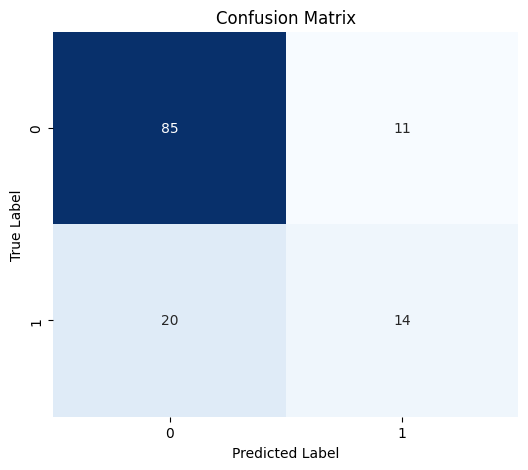

In [84]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Compute confusion matrix on test set predictions
cm = confusion_matrix(y_test, y_pred)

# Create a heatmap of the confusion matrix
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()


In [85]:
import numpy as np
from sklearn.metrics import accuracy_score, recall_score, precision_score

# Suppose y_prob are predicted probabilities for the positive class (glaucoma)
y_prob = stacking_model.predict_proba(X_test)[:, 1]

best_threshold = 0.5
best_recall = 0.0

# Search thresholds from 0.1 to 0.9
for thresh in np.arange(0.1, 1.0, 0.05):
    y_pred_thresh = (y_prob >= thresh).astype(int)
    recall = recall_score(y_test, y_pred_thresh, pos_label=1)
    if recall > best_recall:
        best_recall = recall
        best_threshold = thresh

print(f"Best threshold for recall: {best_threshold}, recall: {best_recall:.3f}")


Best threshold for recall: 0.1, recall: 0.971


In [86]:
import numpy as np
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import confusion_matrix

# Get predicted probabilities for Class 1 (glaucoma)
y_prob = stacking_model.predict_proba(X_test)[:, 1]


In [87]:
best_threshold = 0.5
best_recall = 0.0
thresholds = np.arange(0.1, 1.0, 0.05)

for thresh in thresholds:
    y_pred_thresh = (y_prob >= thresh).astype(int)
    recall_val = recall_score(y_test, y_pred_thresh, pos_label=1)
    if recall_val > best_recall:
        best_recall = recall_val
        best_threshold = thresh

print(f"Best threshold: {best_threshold:.2f}, Best recall: {best_recall:.3f}")


Best threshold: 0.10, Best recall: 0.971


In [88]:
# Final predictions using best threshold
y_pred_custom = (y_prob >= best_threshold).astype(int)

acc_custom = accuracy_score(y_test, y_pred_custom)
prec_custom = precision_score(y_test, y_pred_custom, pos_label=1)
rec_custom = recall_score(y_test, y_pred_custom, pos_label=1)
f1_custom = f1_score(y_test, y_pred_custom, pos_label=1)

print(f"Custom Threshold: {best_threshold:.2f}")
print(f"Accuracy: {acc_custom:.3f}")
print(f"Precision: {prec_custom:.3f}")
print(f"Recall: {rec_custom:.3f}")
print(f"F1-score: {f1_custom:.3f}")

cm_custom = confusion_matrix(y_test, y_pred_custom)
print("Confusion Matrix:\n", cm_custom)


Custom Threshold: 0.10
Accuracy: 0.277
Precision: 0.262
Recall: 0.971
F1-score: 0.412
Confusion Matrix:
 [[ 3 93]
 [ 1 33]]


In [89]:
best_f1 = 0.0
best_threshold_f1 = 0.5

for thresh in np.arange(0.1, 1.0, 0.01):
    y_pred_thresh = (y_prob >= thresh).astype(int)
    f1 = f1_score(y_test, y_pred_thresh, pos_label=1)
    if f1 > best_f1:
        best_f1 = f1
        best_threshold_f1 = thresh

print("Best threshold for F1:", best_threshold_f1, "F1-score:", best_f1)


Best threshold for F1: 0.16999999999999998 F1-score: 0.5544554455445545


In [90]:
y_pred_custom = (y_prob >= 0.17).astype(int)
acc_custom = accuracy_score(y_test, y_pred_custom)
prec_custom = precision_score(y_test, y_pred_custom, pos_label=1)
rec_custom = recall_score(y_test, y_pred_custom, pos_label=1)
f1_custom = f1_score(y_test, y_pred_custom, pos_label=1)
cm_custom = confusion_matrix(y_test, y_pred_custom)

print(f"Threshold: 0.17")
print(f"Accuracy: {acc_custom:.3f}")
print(f"Precision: {prec_custom:.3f}")
print(f"Recall: {rec_custom:.3f}")
print(f"F1-score: {f1_custom:.3f}")
print("Confusion Matrix:\n", cm_custom)


Threshold: 0.17
Accuracy: 0.654
Precision: 0.418
Recall: 0.824
F1-score: 0.554
Confusion Matrix:
 [[57 39]
 [ 6 28]]


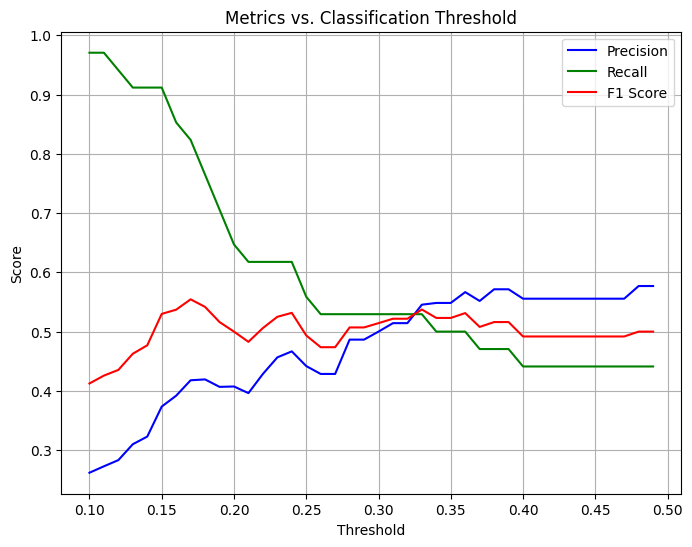

In [91]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import precision_score, recall_score, f1_score

# Assuming y_prob are your predicted probabilities for the glaucoma class (Class 1)
thresholds = np.arange(0.1, 0.5, 0.01)
precisions = []
recalls = []
f1s = []

for thresh in thresholds:
    y_pred_thresh = (y_prob >= thresh).astype(int)
    precisions.append(precision_score(y_test, y_pred_thresh, pos_label=1))
    recalls.append(recall_score(y_test, y_pred_thresh, pos_label=1))
    f1s.append(f1_score(y_test, y_pred_thresh, pos_label=1))

plt.figure(figsize=(8,6))
plt.plot(thresholds, precisions, label="Precision", color='blue')
plt.plot(thresholds, recalls, label="Recall", color='green')
plt.plot(thresholds, f1s, label="F1 Score", color='red')
plt.xlabel("Threshold")
plt.ylabel("Score")
plt.legend()
plt.title("Metrics vs. Classification Threshold")
plt.grid(True)
plt.show()


In [92]:
from sklearn.ensemble import RandomForestClassifier

# Increase the penalty for minority class misclassifications
rf_model_weighted = RandomForestClassifier(
    random_state=42,
    class_weight={0: 1.0, 1: 3.0},  # Example: 3x penalty for glaucoma misclassification
    n_estimators=100,
    max_depth=30,
    min_samples_split=10,
    min_samples_leaf=4,
    bootstrap=False
)
rf_model_weighted.fit(X_train, y_train)


RandomForestClassifier(bootstrap=False, class_weight={0: 1.0, 1: 3.0},
                       max_depth=30, min_samples_leaf=4, min_samples_split=10,
                       random_state=42)

In [93]:
from xgboost import XGBClassifier

# Compute scale_pos_weight for XGBoost = (number of negatives / number of positives)
num_neg = sum(y_train == 0)
num_pos = sum(y_train == 1)
scale_pos_weight = num_neg / num_pos
print("scale_pos_weight:", scale_pos_weight)

xgb_model_weighted = XGBClassifier(
    random_state=42,
    scale_pos_weight=scale_pos_weight,  # This adjusts for the imbalance
    subsample=1.0,
    n_estimators=300,
    max_depth=5,
    learning_rate=0.2,
    colsample_bytree=0.8,
    use_label_encoder=False,
    eval_metric='logloss'
)
xgb_model_weighted.fit(X_train, y_train)


scale_pos_weight: 2.8805970149253732


D:\ProjectML2 - Glaucoma\pytorchGlaucoma\Lib\site-packages\xgboost\training.py:183: UserWarning: [04:22:50] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.8, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, feature_weights=None, gamma=None,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.2, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=5, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=300, n_jobs=None,
              num_parallel_tree=None, ...)

In [94]:
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split

# Suppose X and y are your fused features and labels
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Apply SMOTE to the training set only
smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

# Train your model (e.g., XGBoost) on the SMOTE-enhanced data
xgb_model_smote = XGBClassifier(
    random_state=42,
    use_label_encoder=False,
    eval_metric='logloss'
)
xgb_model_smote.fit(X_train_smote, y_train_smote)

# Evaluate on the original test set
y_prob_smote = xgb_model_smote.predict_proba(X_test)[:, 1]
# Then do threshold tuning or direct predict
y_pred_smote = (y_prob_smote >= 0.5).astype(int)  # or custom threshold


D:\ProjectML2 - Glaucoma\pytorchGlaucoma\Lib\site-packages\xgboost\training.py:183: UserWarning: [04:23:00] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


In [95]:
from sklearn.ensemble import RandomForestClassifier

rf_model_weighted = RandomForestClassifier(
    random_state=42,
    class_weight={0: 1.0, 1: 3.0},  # Example: 3x penalty for glaucoma
    n_estimators=100,
    max_depth=30,
    min_samples_split=10,
    min_samples_leaf=4,
    bootstrap=False
)


In [96]:
rf_model_weighted.fit(X_train, y_train)
y_prob_rf_weighted = rf_model_weighted.predict_proba(X_test)[:, 1]


In [97]:
num_neg = sum(y_train == 0)
num_pos = sum(y_train == 1)
scale_pos_weight = num_neg / num_pos
print("Scale Pos Weight:", scale_pos_weight)


Scale Pos Weight: 2.8805970149253732


In [98]:
from xgboost import XGBClassifier

xgb_model_weighted = XGBClassifier(
    random_state=42,
    use_label_encoder=False,
    eval_metric='logloss',
    scale_pos_weight=scale_pos_weight,
    subsample=1.0,
    n_estimators=300,
    max_depth=5,
    learning_rate=0.2,
    colsample_bytree=0.8
)

xgb_model_weighted.fit(X_train, y_train)
y_prob_xgb_weighted = xgb_model_weighted.predict_proba(X_test)[:, 1]


D:\ProjectML2 - Glaucoma\pytorchGlaucoma\Lib\site-packages\xgboost\training.py:183: UserWarning: [04:25:08] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


In [99]:
from imblearn.over_sampling import SMOTE

smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)
print("Class distribution after SMOTE:", 
      sum(y_train_smote == 0), "negatives,", 
      sum(y_train_smote == 1), "positives")


Class distribution after SMOTE: 386 negatives, 386 positives


In [100]:
# Example with XGBoost
xgb_model_smote = XGBClassifier(
    random_state=42,
    use_label_encoder=False,
    eval_metric='logloss'
    # Optionally, also set scale_pos_weight if needed
)
xgb_model_smote.fit(X_train_smote, y_train_smote)

y_prob_smote = xgb_model_smote.predict_proba(X_test)[:, 1]


D:\ProjectML2 - Glaucoma\pytorchGlaucoma\Lib\site-packages\xgboost\training.py:183: UserWarning: [04:25:33] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


In [101]:
from xgboost import XGBClassifier

xgb_model_weighted = XGBClassifier(
    random_state=42,
    use_label_encoder=False,  # This triggers the warning; it's safe to ignore
    eval_metric='logloss',
    scale_pos_weight=2.8806,  # Using the computed value
    subsample=1.0,
    n_estimators=300,
    max_depth=5,
    learning_rate=0.2,
    colsample_bytree=0.8
)

xgb_model_weighted.fit(X_train, y_train)


D:\ProjectML2 - Glaucoma\pytorchGlaucoma\Lib\site-packages\xgboost\training.py:183: UserWarning: [04:26:14] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.8, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, feature_weights=None, gamma=None,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.2, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=5, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=300, n_jobs=None,
              num_parallel_tree=None, ...)

In [102]:
import numpy as np
from sklearn.metrics import f1_score, recall_score, precision_score

y_prob_weighted = xgb_model_weighted.predict_proba(X_test)[:, 1]

best_f1 = 0.0
best_threshold = 0.5
for thresh in np.arange(0.1, 0.5, 0.01):
    y_pred_thresh = (y_prob_weighted >= thresh).astype(int)
    f1 = f1_score(y_test, y_pred_thresh, pos_label=1)
    if f1 > best_f1:
        best_f1 = f1
        best_threshold = thresh

print(f"Best threshold for weighted XGBoost: {best_threshold:.2f}, F1-score: {best_f1:.3f}")


Best threshold for weighted XGBoost: 0.29, F1-score: 0.587


Class distribution after SMOTE: 386 negatives, 386 positives


D:\ProjectML2 - Glaucoma\pytorchGlaucoma\Lib\site-packages\xgboost\training.py:183: UserWarning: [04:27:36] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Best threshold for SMOTE model: 0.10, F1-score: 0.592
SMOTE Model Accuracy: 0.692
SMOTE Model Precision: 0.453
SMOTE Model Recall: 0.853
SMOTE Model F1-score: 0.592
SMOTE Model Confusion Matrix:
 [[61 35]
 [ 5 29]]


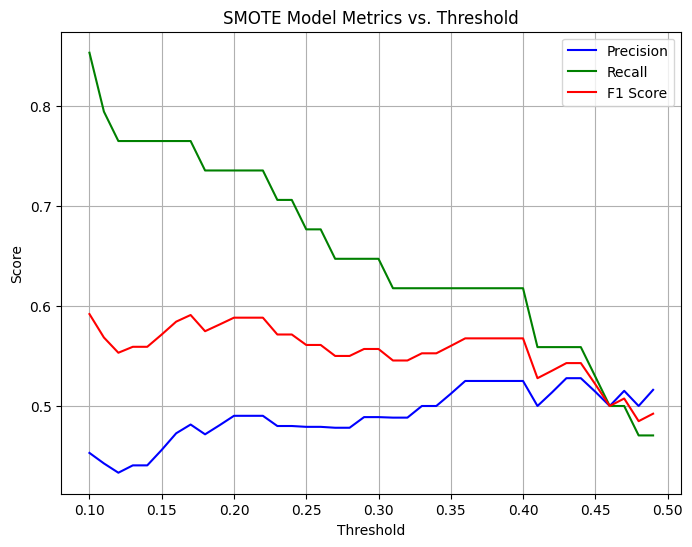

In [103]:
from imblearn.over_sampling import SMOTE
from xgboost import XGBClassifier
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score, confusion_matrix
import numpy as np
import matplotlib.pyplot as plt

# 1. Apply SMOTE on the training data (assume X_train, y_train are defined)
smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)
print("Class distribution after SMOTE:", sum(y_train_smote==0), "negatives,", sum(y_train_smote==1), "positives")

# 2. Train XGBoost on SMOTE data
xgb_model_smote = XGBClassifier(
    random_state=42,
    use_label_encoder=False,
    eval_metric='logloss',
    subsample=1.0,
    n_estimators=300,
    max_depth=5,
    learning_rate=0.2,
    colsample_bytree=0.8
)
xgb_model_smote.fit(X_train_smote, y_train_smote)

# 3. Get predicted probabilities on the original test set
y_prob_smote = xgb_model_smote.predict_proba(X_test)[:, 1]

# 4. Threshold tuning: sweep thresholds from 0.1 to 0.5 to maximize F1 for Class 1
thresholds = np.arange(0.1, 0.5, 0.01)
best_f1 = 0.0
best_threshold = 0.5

for thresh in thresholds:
    y_pred_thresh = (y_prob_smote >= thresh).astype(int)
    f1 = f1_score(y_test, y_pred_thresh, pos_label=1)
    if f1 > best_f1:
        best_f1 = f1
        best_threshold = thresh

print(f"Best threshold for SMOTE model: {best_threshold:.2f}, F1-score: {best_f1:.3f}")

# 5. Evaluate the model at the chosen threshold
y_pred_smote = (y_prob_smote >= best_threshold).astype(int)

acc_smote = accuracy_score(y_test, y_pred_smote)
prec_smote = precision_score(y_test, y_pred_smote, pos_label=1)
rec_smote = recall_score(y_test, y_pred_smote, pos_label=1)
f1_smote = f1_score(y_test, y_pred_smote, pos_label=1)
cm_smote = confusion_matrix(y_test, y_pred_smote)

print(f"SMOTE Model Accuracy: {acc_smote:.3f}")
print(f"SMOTE Model Precision: {prec_smote:.3f}")
print(f"SMOTE Model Recall: {rec_smote:.3f}")
print(f"SMOTE Model F1-score: {f1_smote:.3f}")
print("SMOTE Model Confusion Matrix:\n", cm_smote)

# 6. (Optional) Plotting metric curves for further visualization
precisions = []
recalls = []
f1s = []
for thresh in thresholds:
    y_pred_temp = (y_prob_smote >= thresh).astype(int)
    precisions.append(precision_score(y_test, y_pred_temp, pos_label=1))
    recalls.append(recall_score(y_test, y_pred_temp, pos_label=1))
    f1s.append(f1_score(y_test, y_pred_temp, pos_label=1))

plt.figure(figsize=(8,6))
plt.plot(thresholds, precisions, label="Precision", color='blue')
plt.plot(thresholds, recalls, label="Recall", color='green')
plt.plot(thresholds, f1s, label="F1 Score", color='red')
plt.xlabel("Threshold")
plt.ylabel("Score")
plt.legend()
plt.title("SMOTE Model Metrics vs. Threshold")
plt.grid(True)
plt.show()


In [104]:
import numpy as np
from xgboost import XGBClassifier
from sklearn.metrics import f1_score, precision_score, recall_score, accuracy_score, confusion_matrix

# Weighted XGBoost (scale_pos_weight approach)
num_neg = sum(y_train == 0)
num_pos = sum(y_train == 1)
scale_pos_weight = num_neg / num_pos  # ~2.88 for your dataset

xgb_weighted = XGBClassifier(
    random_state=42,
    use_label_encoder=False,
    eval_metric='logloss',
    scale_pos_weight=scale_pos_weight,
    subsample=1.0,
    n_estimators=300,
    max_depth=5,
    learning_rate=0.2,
    colsample_bytree=0.8
)

xgb_weighted.fit(X_train, y_train)
y_prob_weighted = xgb_weighted.predict_proba(X_test)[:, 1]

# Threshold tuning for Weighted XGBoost
thresholds = np.arange(0.1, 0.5, 0.01)
best_f1_w = 0.0
best_thresh_w = 0.5

for t in thresholds:
    y_pred_temp = (y_prob_weighted >= t).astype(int)
    f1_temp = f1_score(y_test, y_pred_temp, pos_label=1)
    if f1_temp > best_f1_w:
        best_f1_w = f1_temp
        best_thresh_w = t

y_pred_weighted = (y_prob_weighted >= best_thresh_w).astype(int)
acc_w = accuracy_score(y_test, y_pred_weighted)
prec_w = precision_score(y_test, y_pred_weighted, pos_label=1)
rec_w = recall_score(y_test, y_pred_weighted, pos_label=1)
f1_w = f1_score(y_test, y_pred_weighted, pos_label=1)
cm_w = confusion_matrix(y_test, y_pred_weighted)

print(f"=== Weighted XGBoost ===")
print(f"Best Threshold: {best_thresh_w:.2f}, F1: {best_f1_w:.3f}")
print(f"Accuracy: {acc_w:.3f}, Precision: {prec_w:.3f}, Recall: {rec_w:.3f}")
print("Confusion Matrix:\n", cm_w)


D:\ProjectML2 - Glaucoma\pytorchGlaucoma\Lib\site-packages\xgboost\training.py:183: UserWarning: [04:29:55] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


=== Weighted XGBoost ===
Best Threshold: 0.29, F1: 0.587
Accuracy: 0.762, Precision: 0.537, Recall: 0.647
Confusion Matrix:
 [[77 19]
 [12 22]]


In [105]:
from imblearn.over_sampling import SMOTE

# Apply SMOTE to training data
smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

xgb_smote = XGBClassifier(
    random_state=42,
    use_label_encoder=False,
    eval_metric='logloss',
    subsample=1.0,
    n_estimators=300,
    max_depth=5,
    learning_rate=0.2,
    colsample_bytree=0.8
)

xgb_smote.fit(X_train_smote, y_train_smote)
y_prob_smote = xgb_smote.predict_proba(X_test)[:, 1]

# Threshold tuning for SMOTE XGBoost
best_f1_s = 0.0
best_thresh_s = 0.5

for t in thresholds:
    y_pred_temp = (y_prob_smote >= t).astype(int)
    f1_temp = f1_score(y_test, y_pred_temp, pos_label=1)
    if f1_temp > best_f1_s:
        best_f1_s = f1_temp
        best_thresh_s = t

y_pred_smote = (y_prob_smote >= best_thresh_s).astype(int)
acc_s = accuracy_score(y_test, y_pred_smote)
prec_s = precision_score(y_test, y_pred_smote, pos_label=1)
rec_s = recall_score(y_test, y_pred_smote, pos_label=1)
f1_s = f1_score(y_test, y_pred_smote, pos_label=1)
cm_s = confusion_matrix(y_test, y_pred_smote)

print(f"=== SMOTE XGBoost ===")
print(f"Best Threshold: {best_thresh_s:.2f}, F1: {best_f1_s:.3f}")
print(f"Accuracy: {acc_s:.3f}, Precision: {prec_s:.3f}, Recall: {rec_s:.3f}")
print("Confusion Matrix:\n", cm_s)


D:\ProjectML2 - Glaucoma\pytorchGlaucoma\Lib\site-packages\xgboost\training.py:183: UserWarning: [04:30:14] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


=== SMOTE XGBoost ===
Best Threshold: 0.10, F1: 0.592
Accuracy: 0.692, Precision: 0.453, Recall: 0.853
Confusion Matrix:
 [[61 35]
 [ 5 29]]


In [108]:
weighted_xgb_model = xgb_weighted
smote_xgb_model = xgb_smote


In [109]:
probs_weighted = weighted_xgb_model.predict_proba(X_test)[:, 1]
probs_smote = smote_xgb_model.predict_proba(X_test)[:, 1]


In [110]:
import numpy as np
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

# Assuming you have trained models: weighted_xgb_model, smote_xgb_model
# And test set features: X_test

# Get probability predictions from both models
probs_weighted = weighted_xgb_model.predict_proba(X_test)[:, 1]  # Probabilities for class 1
probs_smote = smote_xgb_model.predict_proba(X_test)[:, 1]

# Compute the average probability (soft voting)
ensemble_probs = (probs_weighted + probs_smote) / 2

# Apply best threshold (determined from tuning, e.g., 0.17 - 0.29)
optimal_threshold = 0.25  # Adjust based on tuning results
ensemble_preds = (ensemble_probs >= optimal_threshold).astype(int)

# Evaluate Performance
accuracy = accuracy_score(y_test, ensemble_preds)
precision = precision_score(y_test, ensemble_preds)
recall = recall_score(y_test, ensemble_preds)
f1 = f1_score(y_test, ensemble_preds)
conf_matrix = confusion_matrix(y_test, ensemble_preds)

# Print Results
print(f"Soft Voting Ensemble Accuracy: {accuracy:.3f}")
print(f"Precision: {precision:.3f}")
print(f"Recall: {recall:.3f}")
print(f"F1-score: {f1:.3f}")
print("Confusion Matrix:")
print(conf_matrix)

Soft Voting Ensemble Accuracy: 0.754
Precision: 0.522
Recall: 0.706
F1-score: 0.600
Confusion Matrix:
[[74 22]
 [10 24]]


IndentationError: unindent does not match any outer indentation level (<tokenize>, line 29)

In [112]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, random_split
from torchvision import models
import torch.optim as optim

# Device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Create train/test split
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=16)

# Load pretrained ResNet50
model = models.resnet50(weights=models.ResNet50_Weights.DEFAULT)
model.fc = nn.Linear(model.fc.in_features, 2)  # 2 classes: Glaucoma vs Non
model = model.to(device)

# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)

# Training loop (short for now)
epochs = 5
for epoch in range(epochs):
    model.train()
    running_loss = 0.0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    print(f"Epoch [{epoch+1}/{epochs}] - Loss: {running_loss / len(train_loader):.4f}")


Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to C:\Users\ASUS/.cache\torch\hub\checkpoints\resnet50-11ad3fa6.pth
100%|█████████████████████████████████████| 97.8M/97.8M [00:13<00:00, 7.88MB/s]


TypeError: join() argument must be str, bytes, or os.PathLike object, not 'int64'

In [119]:
import os
import pandas as pd
from PIL import Image
from torch.utils.data import Dataset
import torchvision.transforms as transforms

class ORIGADataset(Dataset):
    def __init__(self, csv_path, image_dir, transform=None):
        self.data = pd.read_csv(csv_path)
        self.image_dir = image_dir
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        row = self.data.iloc[idx]

        # Convert integer filename to string like '001.png'
        filename = str(row['Filename']).zfill(3) + ".png"
        img_path = os.path.join(self.image_dir, filename)

        image = Image.open(img_path).convert('RGB')
        label = int(row['Glaucoma'])

        if self.transform:
            image = self.transform(image)
        
        return image, label


In [120]:
# Image transformations
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])

# Paths
csv_path = "D:/ProjectML2 - Glaucoma/Dataset/ORIGA/origa_final.csv"
image_dir = "D:/ProjectML2 - Glaucoma/Dataset/ORIGA/Images"

# Create Dataset
dataset = ORIGADataset(csv_path, image_dir, transform)


In [122]:
import os
import pandas as pd

# Load your CSV
csv_path = "D:/ProjectML2 - Glaucoma/Dataset/ORIGA/origa_final.csv"
image_dir = "D:/ProjectML2 - Glaucoma/Dataset/ORIGA/Images"
df = pd.read_csv(csv_path)

# Filter rows where corresponding image exists
df['Filename_str'] = df['Filename'].apply(lambda x: str(x).zfill(3) + ".png")
df['Exists'] = df['Filename_str'].apply(lambda fname: os.path.exists(os.path.join(image_dir, fname)))

# Keep only existing image rows
df = df[df['Exists']].drop(columns=['Exists', 'Filename_str'])

# Save filtered version
filtered_csv_path = "D:/ProjectML2 - Glaucoma/Dataset/ORIGA/origa_final_filtered.csv"
df.to_csv(filtered_csv_path, index=False)

print("✅ Filtered CSV saved:", filtered_csv_path)


✅ Filtered CSV saved: D:/ProjectML2 - Glaucoma/Dataset/ORIGA/origa_final_filtered.csv


In [132]:
import os
import pandas as pd
from PIL import Image
from torch.utils.data import Dataset
import torchvision.transforms as transforms

class ORIGADataset(Dataset):
    def __init__(self, csv_path, image_dir, transform=None):
        self.data = pd.read_csv(csv_path)
        self.image_dir = image_dir
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        while True:
            row = self.data.iloc[idx]
            # Ensure filename is in string format and padded (e.g., 001.png)
            filename = str(row['Filename']).zfill(3) + ".png"
            img_path = os.path.join(self.image_dir, filename)

            try:
                image = Image.open(img_path).convert('RGB')
                label = int(row['Glaucoma'])

                if self.transform:
                    image = self.transform(image)

                return image, label

            except FileNotFoundError:
                print(f"⚠️ Skipping missing image: {filename}")
                idx = (idx + 1) % len(self.data)


In [133]:
# Transformations
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])

# Dataset paths
csv_path = "D:/ProjectML2 - Glaucoma/Dataset/ORIGA/origa_final.csv"
image_dir = "D:/ProjectML2 - Glaucoma/Dataset/ORIGA/Images"

# Initialize Dataset
dataset = ORIGADataset(csv_path, image_dir, transform)


In [135]:
import pandas as pd
import os
from PIL import Image
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms

# ORIGA dataset paths
origa_root = r"D:\ProjectML2 - Glaucoma\Dataset\ORIGA"
origa_img_dir = os.path.join(origa_root, "Images_Square")  # Adjust if using a different folder
origa_csv_path = os.path.join(origa_root, "OrigaList.csv")

# Transforms
origa_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Custom Dataset class
class OrigaDataset(Dataset):
    def __init__(self, csv_file, img_dir, transform=None):
        self.data = pd.read_csv(csv_file)
        self.img_dir = img_dir
        self.transform = transform
        
        # Map labels (assuming 'Glaucoma' column exists)
        if 'Glaucoma' in self.data.columns:
            self.data['label'] = self.data['Glaucoma'].apply(lambda x: 1 if str(x).lower() == 'glaucoma' or x == 1 else 0)
        else:
            raise ValueError("Column 'Glaucoma' not found in CSV.")

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        # Use 'Filename' column (adjust based on your CSV)
        img_name = self.data.iloc[idx]['Filename']
        img_path = os.path.join(self.img_dir, f"{img_name}.jpg")  # Adjust extension if needed (.png?)

        try:
            image = Image.open(img_path).convert("RGB")
        except FileNotFoundError:
            print(f"⚠️ Image not found: {img_path}. Skipping.")
            return None, None  # Handle gracefully in DataLoader

        label = self.data.iloc[idx]['label']

        if self.transform:
            image = self.transform(image)

        return image, label

# Load dataset
origa_dataset = OrigaDataset(csv_file=origa_csv_path, img_dir=origa_img_dir, transform=origa_transforms)
origa_loader = DataLoader(origa_dataset, batch_size=32, shuffle=True, num_workers=2)

print(f"Loaded ORIGA dataset with {len(origa_dataset)} samples.")

Loaded ORIGA dataset with 650 samples.
